# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk
from varseek.utils import make_bus_df, add_variant_type

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "32"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6", "vk_count_out_w37_k41_combined_final")
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_NOT_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_NOT_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_NOT_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis", "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6")
fastq_files = [os.path.join(fastqs_dir, "ERR204838_1.fastq.gz"), os.path.join(fastqs_dir, "ERR204838_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
use_combined = True
modify_bam = False  # convert 256 flag to 0

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

fps = set(fp_df.index.tolist())
print(fps)
fp_df.head()

{'ENST00000392132:c.1613T>C', 'ENST00000390321:c.143C>T', 'ENST00000227157:c.683G>C', 'ENST00000243583:c.422A>G', 'ENST00000258662:c.595C>T', 'ENST00000524315:c.446A>G', 'ENST00000305135:c.3942C>T', 'ENST00000266087:c.1276C>T', 'ENST00000399967:c.1036G>T', 'ENST00000603600:c.205C>A', 'ENST00000370489:c.1005T>C', 'ENST00000250405:c.352G>A', 'ENST00000336294:c.947A>G', 'ENST00000390634:c.191C>T', 'ENST00000356239:c.9378C>T', 'ENST00000253024:c.2471A>C', 'ENST00000264932:c.2084G>A', 'ENST00000322067:c.1094C>T', 'ENST00000357254:c.1189G>C', 'ENST00000311085:c.6197A>C', 'ENST00000337872:c.1080A>C', 'ENST00000361573:c.525G>A', 'ENST00000470914:c.505C>T', 'ENST00000326648:c.1187A>C', 'ENST00000293373:c.2921A>C', 'ENST00000294309:c.2126A>G', 'ENST00000306107:c.1781T>C', 'ENST00000331789:c.1209G>C', 'ENST00000603111:c.33G>T', 'ENST00000233143:c.184G>A', 'ENST00000293879:c.1872C>T', 'ENST00000295951:c.2558C>T', 'ENST00000570496:c.346G>C', 'ENST00000221403:c.634T>C', 'ENST00000356091:c.513C>A', '

,vcrs_count
gene_id,
ENST00000390312:c.218G>A,1848.0
ENST00000336023:c.614A>G,1493.0
ENST00000579721:c.870G>C,1464.0
ENST00000496168:c.382G>A,1382.0
ENST00000579721:c.41C>T,1346.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=True,
        disable_clean=True,
        disable_summarize=True
        # quality_control_fastqs=True, cut_front=True, cut_tail=True  # equivalent to the fastp step above
        # qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g,
    )

### Map the reads to the VCRS to which they aligned

In [9]:
bus_df = make_bus_df(kb_count_out_dir, fastq_file_list=fastq_file, technology=technology, parity=parity, bustools=bustools, mm=mm)
bus_df = bus_df.drop(columns=["transcript_names"]).rename(columns={"gene_names": "variant_names"})
filtered_bus_df = bus_df[bus_df["variant_names"].apply(lambda x: len(x) == 1)]  # remove multi-mapping reads
# filtered_bus_df = filtered_bus_df.loc[filtered_bus_df['barcode'] == "AAAAAAAAAAAAAAAA"]  # since I'm only using the 1st file
filtered_bus_df["variant_names_str"] = filtered_bus_df["variant_names"].apply(lambda x: x[0])  # cast to string
filtered_bus_df = filtered_bus_df[(filtered_bus_df["variant_names_str"].isin(fps)) & (filtered_bus_df["counted_in_count_matrix"])]
print(f"Number of reads in filtered bus file: {len(filtered_bus_df)}")
filtered_bus_df.head()

00:13:54 - INFO - loading in transcripts


00:13:54 - INFO - loading in ec matrix


00:13:54 - INFO - loading in barcodes


Processing FASTQ headers: 0it [00:00, ?it/s]

Processing FASTQ headers: 47639it [00:00, 455768.25it/s]

Processing FASTQ headers: 99932it [00:00, 482868.65it/s]

Processing FASTQ headers: 151946it [00:00, 489275.65it/s]

Processing FASTQ headers: 203767it [00:00, 495415.15it/s]

Processing FASTQ headers: 255589it [00:00, 499158.49it/s]

Processing FASTQ headers: 307534it [00:00, 501065.64it/s]

Processing FASTQ headers: 359589it [00:00, 500073.89it/s]

Processing FASTQ headers: 411649it [00:00, 504393.96it/s]

Processing FASTQ headers: 463549it [00:00, 507472.00it/s]

Processing FASTQ headers: 515372it [00:01, 509537.78it/s]

Processing FASTQ headers: 567193it [00:01, 508622.80it/s]

Processing FASTQ headers: 619287it [00:01, 506519.06it/s]

Processing FASTQ headers: 671342it [00:01, 504816.74it/s]

Processing FASTQ headers: 723386it [00:01, 504464.73it/s]

Processing FASTQ headers: 774576it [00:01, 506563.68it/s]

Processing FASTQ headers: 825241it [00:01, 500772.56it/s]

Processing FASTQ headers: 875331it [00:01, 495905.19it/s]

Processing FASTQ headers: 926211it [00:01, 495070.13it/s]

Processing FASTQ headers: 975908it [00:01, 495623.34it/s]

Processing FASTQ headers: 1025477it [00:02, 492988.93it/s]

Processing FASTQ headers: 1077144it [00:02, 494980.50it/s]

Processing FASTQ headers: 1128733it [00:02, 494326.95it/s]

Processing FASTQ headers: 1180324it [00:02, 494908.75it/s]

Processing FASTQ headers: 1232064it [00:02, 495911.84it/s]

Processing FASTQ headers: 1283884it [00:02, 495771.49it/s]

Processing FASTQ headers: 1335706it [00:02, 495494.59it/s]

Processing FASTQ headers: 1386927it [00:02, 500364.23it/s]

Processing FASTQ headers: 1436978it [00:02, 496342.54it/s]

Processing FASTQ headers: 1486622it [00:02, 492411.73it/s]

Processing FASTQ headers: 1537568it [00:03, 491803.82it/s]

Processing FASTQ headers: 1589374it [00:03, 491376.06it/s]

Processing FASTQ headers: 1639393it [00:03, 493944.55it/s]

Processing FASTQ headers: 1688798it [00:03, 489463.20it/s]

Processing FASTQ headers: 1740080it [00:03, 487784.32it/s]

Processing FASTQ headers: 1791670it [00:03, 488496.75it/s]

Processing FASTQ headers: 1843261it [00:03, 489260.87it/s]

Processing FASTQ headers: 1894209it [00:03, 495137.01it/s]

Processing FASTQ headers: 1943744it [00:03, 489682.40it/s]

Processing FASTQ headers: 1993767it [00:04, 484775.57it/s]

Processing FASTQ headers: 2044499it [00:04, 491348.00it/s]

Processing FASTQ headers: 2093666it [00:04, 472309.27it/s]

Processing FASTQ headers: 2143231it [00:04, 479018.33it/s]

Processing FASTQ headers: 2191268it [00:04, 474726.72it/s]

Processing FASTQ headers: 2242079it [00:04, 484463.36it/s]

Processing FASTQ headers: 2290617it [00:04, 477940.48it/s]

Processing FASTQ headers: 2338484it [00:04, 477204.63it/s]

Processing FASTQ headers: 2388276it [00:04, 483303.11it/s]

Processing FASTQ headers: 2436653it [00:04, 475359.11it/s]

Processing FASTQ headers: 2485144it [00:05, 478160.00it/s]

Processing FASTQ headers: 2533678it [00:05, 480277.56it/s]

Processing FASTQ headers: 2581739it [00:05, 470577.90it/s]

Processing FASTQ headers: 2631838it [00:05, 479500.57it/s]

Processing FASTQ headers: 2680138it [00:05, 479833.62it/s]

Processing FASTQ headers: 2731959it [00:05, 484920.09it/s]

Processing FASTQ headers: 2783659it [00:05, 490498.99it/s]

Processing FASTQ headers: 2835249it [00:05, 489597.94it/s]

Processing FASTQ headers: 2886838it [00:05, 492927.60it/s]

Processing FASTQ headers: 2938629it [00:05, 496556.98it/s]

Processing FASTQ headers: 2990451it [00:06, 498960.31it/s]

Processing FASTQ headers: 3042248it [00:06, 503387.33it/s]

Processing FASTQ headers: 3093837it [00:06, 503384.45it/s]

Processing FASTQ headers: 3145427it [00:06, 504067.64it/s]

Processing FASTQ headers: 3197158it [00:06, 504253.74it/s]

Processing FASTQ headers: 3248979it [00:06, 502410.85it/s]

Processing FASTQ headers: 3300801it [00:06, 500828.28it/s]

Processing FASTQ headers: 3352519it [00:06, 498975.59it/s]

Processing FASTQ headers: 3404109it [00:06, 499293.08it/s]

Processing FASTQ headers: 3455700it [00:07, 499242.49it/s]

Processing FASTQ headers: 3507414it [00:07, 497989.33it/s]

Processing FASTQ headers: 3559236it [00:07, 497242.28it/s]

Processing FASTQ headers: 3610564it [00:07, 501917.26it/s]

Processing FASTQ headers: 3660771it [00:07, 496284.96it/s]

Processing FASTQ headers: 3710414it [00:07, 492811.13it/s]

Processing FASTQ headers: 3761329it [00:07, 492860.18it/s]

Processing FASTQ headers: 3812920it [00:07, 491475.12it/s]

Processing FASTQ headers: 3864756it [00:07, 491291.27it/s]

Processing FASTQ headers: 3916577it [00:07, 490838.46it/s]

Processing FASTQ headers: 3968399it [00:08, 491739.47it/s]

Processing FASTQ headers: 4020087it [00:08, 491742.18it/s]

Processing FASTQ headers: 4071675it [00:08, 490212.41it/s]

Processing FASTQ headers: 4123265it [00:08, 491170.12it/s]

Processing FASTQ headers: 4174945it [00:08, 490128.26it/s]

Processing FASTQ headers: 4226490it [00:08, 497447.02it/s]

Processing FASTQ headers: 4276264it [00:08, 491821.98it/s]

Processing FASTQ headers: 4325715it [00:08, 484758.62it/s]

Processing FASTQ headers: 4377358it [00:08, 486801.51it/s]

Processing FASTQ headers: 4428948it [00:08, 489006.52it/s]

Processing FASTQ headers: 4480538it [00:09, 489637.93it/s]

Processing FASTQ headers: 4532261it [00:09, 489874.67it/s]

Processing FASTQ headers: 4581254it [00:09, 489505.98it/s]

Processing FASTQ headers: 4631197it [00:09, 485360.63it/s]

Processing FASTQ headers: 4682271it [00:09, 492763.95it/s]

Processing FASTQ headers: 4731572it [00:09, 487326.08it/s]

Processing FASTQ headers: 4781128it [00:09, 489695.78it/s]

Processing FASTQ headers: 4830118it [00:09, 477898.02it/s]

Processing FASTQ headers: 4880152it [00:09, 484439.55it/s]

Processing FASTQ headers: 4928658it [00:10, 475293.26it/s]

Processing FASTQ headers: 4976254it [00:10, 475386.43it/s]

Processing FASTQ headers: 5023840it [00:10, 471244.81it/s]

Processing FASTQ headers: 5070998it [00:10, 471199.14it/s]

Processing FASTQ headers: 5118142it [00:10, 470825.98it/s]

Processing FASTQ headers: 5167021it [00:10, 469160.09it/s]

Processing FASTQ headers: 5218846it [00:10, 478480.47it/s]

Processing FASTQ headers: 5270671it [00:10, 483054.26it/s]

Processing FASTQ headers: 5322340it [00:10, 490376.47it/s]

Processing FASTQ headers: 5373934it [00:10, 495310.43it/s]

Processing FASTQ headers: 5425527it [00:11, 498895.75it/s]

Processing FASTQ headers: 5477368it [00:11, 501555.93it/s]

Processing FASTQ headers: 5529192it [00:11, 500694.59it/s]

Processing FASTQ headers: 5581263it [00:11, 506579.61it/s]

Processing FASTQ headers: 5632547it [00:11, 508427.36it/s]

Processing FASTQ headers: 5684137it [00:11, 508706.56it/s]

Processing FASTQ headers: 5735910it [00:11, 508036.96it/s]

Processing FASTQ headers: 5787736it [00:11, 504117.83it/s]

Processing FASTQ headers: 5839561it [00:11, 504023.13it/s]

Processing FASTQ headers: 5891220it [00:11, 505532.85it/s]

Processing FASTQ headers: 5942813it [00:12, 506375.76it/s]

Processing FASTQ headers: 5994406it [00:12, 506362.68it/s]

Processing FASTQ headers: 6046206it [00:12, 502845.16it/s]

Processing FASTQ headers: 6098032it [00:12, 502046.61it/s]

Processing FASTQ headers: 6149855it [00:12, 500222.13it/s]

Processing FASTQ headers: 6201537it [00:12, 499827.57it/s]

Processing FASTQ headers: 6253130it [00:12, 499675.09it/s]

Processing FASTQ headers: 6304723it [00:12, 498526.63it/s]

Processing FASTQ headers: 6356474it [00:12, 498803.24it/s]

Processing FASTQ headers: 6408299it [00:12, 499218.00it/s]

Processing FASTQ headers: 6460122it [00:13, 497577.11it/s]

Processing FASTQ headers: 6511884it [00:13, 495256.17it/s]

Processing FASTQ headers: 6563476it [00:13, 492895.43it/s]

Processing FASTQ headers: 6615068it [00:13, 493926.33it/s]

Processing FASTQ headers: 6666661it [00:13, 495516.39it/s]

Processing FASTQ headers: 6718529it [00:13, 494816.55it/s]

Processing FASTQ headers: 6770046it [00:13, 500728.07it/s]

Processing FASTQ headers: 6820140it [00:13, 494967.00it/s]

Processing FASTQ headers: 6869655it [00:13, 490641.56it/s]

Processing FASTQ headers: 6920752it [00:14, 491325.50it/s]

Processing FASTQ headers: 6972344it [00:14, 491242.64it/s]

Processing FASTQ headers: 7023730it [00:14, 497842.48it/s]

Processing FASTQ headers: 7073537it [00:14, 491829.04it/s]

Processing FASTQ headers: 7122971it [00:14, 486946.62it/s]

Processing FASTQ headers: 7173463it [00:14, 492207.84it/s]

Processing FASTQ headers: 7222709it [00:14, 487094.19it/s]

Processing FASTQ headers: 7272758it [00:14, 491031.29it/s]

Processing FASTQ headers: 7321884it [00:14, 486696.40it/s]

Processing FASTQ headers: 7370573it [00:14, 484890.32it/s]

Processing FASTQ headers: 7419075it [00:15, 480220.61it/s]

Processing FASTQ headers: 7469607it [00:15, 487621.82it/s]

Processing FASTQ headers: 7518391it [00:15, 478082.41it/s]

Processing FASTQ headers: 7568144it [00:15, 483783.66it/s]

Processing FASTQ headers: 7616568it [00:15, 477924.42it/s]

Processing FASTQ headers: 7666410it [00:15, 483947.54it/s]

Processing FASTQ headers: 7715114it [00:15, 478615.52it/s]

Processing FASTQ headers: 7766947it [00:15, 483493.16it/s]

Processing FASTQ headers: 7818768it [00:15, 490153.96it/s]

Processing FASTQ headers: 7870484it [00:15, 494624.13it/s]

Processing FASTQ headers: 7922074it [00:16, 499527.09it/s]

Processing FASTQ headers: 7973664it [00:16, 503188.26it/s]

Processing FASTQ headers: 8025443it [00:16, 501722.88it/s]

Processing FASTQ headers: 8077265it [00:16, 502288.76it/s]

Processing FASTQ headers: 8129089it [00:16, 504761.82it/s]

Processing FASTQ headers: 8180681it [00:16, 508039.03it/s]

Processing FASTQ headers: 8232272it [00:16, 506654.97it/s]

Processing FASTQ headers: 8282946it [00:16, 503894.74it/s]

Processing FASTQ headers: 8333342it [00:16, 500880.50it/s]

Processing FASTQ headers: 8383435it [00:17, 497837.28it/s]

Processing FASTQ headers: 8434666it [00:17, 498557.04it/s]

Processing FASTQ headers: 8486256it [00:17, 499817.32it/s]

Processing FASTQ headers: 8537845it [00:17, 498867.73it/s]

Processing FASTQ headers: 8589511it [00:17, 500699.47it/s]

Processing FASTQ headers: 8641352it [00:17, 500537.43it/s]

Processing FASTQ headers: 8693173it [00:17, 499612.83it/s]

Processing FASTQ headers: 8744978it [00:17, 496454.02it/s]

Processing FASTQ headers: 8796567it [00:17, 497552.86it/s]

Processing FASTQ headers: 8848155it [00:17, 498775.80it/s]

Processing FASTQ headers: 8899746it [00:18, 499241.25it/s]

Processing FASTQ headers: 8951594it [00:18, 499396.01it/s]

Processing FASTQ headers: 9003415it [00:18, 496826.93it/s]

Processing FASTQ headers: 9055237it [00:18, 496643.07it/s]

Processing FASTQ headers: 9106906it [00:18, 497106.87it/s]

Processing FASTQ headers: 9158496it [00:18, 498310.39it/s]

Processing FASTQ headers: 9210086it [00:18, 498147.36it/s]

Processing FASTQ headers: 9261141it [00:18, 501767.34it/s]

Processing FASTQ headers: 9311329it [00:18, 493443.66it/s]

Processing FASTQ headers: 9360730it [00:18, 488108.23it/s]

Processing FASTQ headers: 9412535it [00:19, 496862.65it/s]

Processing FASTQ headers: 9462257it [00:19, 492077.41it/s]

Processing FASTQ headers: 9511493it [00:19, 485609.48it/s]

Processing FASTQ headers: 9562650it [00:19, 487225.62it/s]

Processing FASTQ headers: 9614391it [00:19, 487443.67it/s]

Processing FASTQ headers: 9665685it [00:19, 494862.46it/s]

Processing FASTQ headers: 9715203it [00:19, 488122.96it/s]

Processing FASTQ headers: 9764276it [00:19, 488880.45it/s]

Processing FASTQ headers: 9813187it [00:19, 482442.02it/s]

Processing FASTQ headers: 9863638it [00:20, 480058.24it/s]

Processing FASTQ headers: 9914136it [00:20, 487322.63it/s]

Processing FASTQ headers: 9962905it [00:20, 480365.61it/s]

Processing FASTQ headers: 10010977it [00:20, 479959.83it/s]

Processing FASTQ headers: 10060364it [00:20, 484053.61it/s]

Processing FASTQ headers: 10108794it [00:20, 477510.59it/s]

Processing FASTQ headers: 10157365it [00:20, 479919.26it/s]

Processing FASTQ headers: 10205934it [00:20, 470770.07it/s]

Processing FASTQ headers: 10254740it [00:20, 475823.38it/s]

Processing FASTQ headers: 10304184it [00:20, 478311.43it/s]

Processing FASTQ headers: 10355774it [00:21, 487601.41it/s]

Processing FASTQ headers: 10407364it [00:21, 494041.91it/s]

Processing FASTQ headers: 10458759it [00:21, 497671.29it/s]

Processing FASTQ headers: 10510120it [00:21, 501652.13it/s]

Processing FASTQ headers: 10561480it [00:21, 504034.08it/s]

Processing FASTQ headers: 10613108it [00:21, 504929.36it/s]

Processing FASTQ headers: 10664699it [00:21, 507488.85it/s]

Processing FASTQ headers: 10716195it [00:21, 509327.69it/s]

Processing FASTQ headers: 10767555it [00:21, 510328.33it/s]

Processing FASTQ headers: 10818913it [00:21, 506917.86it/s]

Processing FASTQ headers: 10870490it [00:22, 508450.60it/s]

Processing FASTQ headers: 10922081it [00:22, 507572.34it/s]

Processing FASTQ headers: 10973670it [00:22, 506359.53it/s]

Processing FASTQ headers: 11025086it [00:22, 506119.10it/s]

Processing FASTQ headers: 11076447it [00:22, 501184.69it/s]

Processing FASTQ headers: 11127808it [00:22, 503904.73it/s]

Processing FASTQ headers: 11179363it [00:22, 503341.90it/s]

Processing FASTQ headers: 11230955it [00:22, 500836.68it/s]

Processing FASTQ headers: 11282545it [00:22, 501269.62it/s]

Processing FASTQ headers: 11334028it [00:22, 502214.38it/s]

Processing FASTQ headers: 11385388it [00:23, 502125.10it/s]

Processing FASTQ headers: 11436750it [00:23, 502379.49it/s]

Processing FASTQ headers: 11488190it [00:23, 501522.24it/s]

Processing FASTQ headers: 11539801it [00:23, 502427.55it/s]

Processing FASTQ headers: 11591391it [00:23, 502119.09it/s]

Processing FASTQ headers: 11642981it [00:23, 502512.98it/s]

Processing FASTQ headers: 11694358it [00:23, 500808.87it/s]

Processing FASTQ headers: 11745719it [00:23, 498524.62it/s]

Processing FASTQ headers: 11797080it [00:23, 499397.01it/s]

Processing FASTQ headers: 11848616it [00:23, 499047.24it/s]

Processing FASTQ headers: 11900206it [00:24, 497419.73it/s]

Processing FASTQ headers: 11951796it [00:24, 496511.27it/s]

Processing FASTQ headers: 12003358it [00:24, 494892.96it/s]

Processing FASTQ headers: 12054720it [00:24, 496058.33it/s]

Processing FASTQ headers: 12106082it [00:24, 497324.70it/s]

Processing FASTQ headers: 12157442it [00:24, 495080.28it/s]

Processing FASTQ headers: 12209001it [00:24, 491375.66it/s]

Processing FASTQ headers: 12260593it [00:24, 490890.94it/s]

Processing FASTQ headers: 12312183it [00:24, 490242.81it/s]

Processing FASTQ headers: 12363648it [00:25, 488717.12it/s]

Processing FASTQ headers: 12414363it [00:25, 494040.04it/s]

Processing FASTQ headers: 12463791it [00:25, 486109.11it/s]

Processing FASTQ headers: 12513284it [00:25, 482748.63it/s]

Processing FASTQ headers: 12561712it [00:25, 483189.38it/s]

Processing FASTQ headers: 12610608it [00:25, 484879.88it/s]

Processing FASTQ headers: 12659362it [00:25, 485661.31it/s]

Processing FASTQ headers: 12710120it [00:25, 490088.05it/s]

Processing FASTQ headers: 12761701it [00:25, 497266.40it/s]

Processing FASTQ headers: 12814284it [00:25, 505762.64it/s]

Processing FASTQ headers: 12866105it [00:26, 509471.55it/s]

Processing FASTQ headers: 12917065it [00:26, 508798.44it/s]

Processing FASTQ headers: 12968298it [00:26, 509848.73it/s]

Processing FASTQ headers: 13021128it [00:26, 515364.50it/s]

Processing FASTQ headers: 13075037it [00:26, 522463.07it/s]

Processing FASTQ headers: 13127289it [00:26, 514711.91it/s]

Processing FASTQ headers: 13178789it [00:26, 514445.72it/s]

Processing FASTQ headers: 13230254it [00:26, 511382.14it/s]

Processing FASTQ headers: 13281408it [00:26, 510946.96it/s]

Processing FASTQ headers: 13332722it [00:26, 511199.73it/s]

Processing FASTQ headers: 13384085it [00:27, 511035.16it/s]

Processing FASTQ headers: 13435450it [00:27, 510885.48it/s]

Processing FASTQ headers: 13486833it [00:27, 508996.82it/s]

Processing FASTQ headers: 13538473it [00:27, 509781.69it/s]

Processing FASTQ headers: 13590067it [00:27, 508481.75it/s]

Processing FASTQ headers: 13641660it [00:27, 508249.81it/s]

Processing FASTQ headers: 13693023it [00:27, 506643.21it/s]

Processing FASTQ headers: 13744387it [00:27, 502731.05it/s]

Processing FASTQ headers: 13795750it [00:27, 504412.49it/s]

Processing FASTQ headers: 13847359it [00:27, 504314.77it/s]

Processing FASTQ headers: 13898953it [00:28, 505116.20it/s]

Processing FASTQ headers: 13950545it [00:28, 505288.52it/s]

Processing FASTQ headers: 14001990it [00:28, 502803.23it/s]

Processing FASTQ headers: 14053354it [00:28, 502892.58it/s]

Processing FASTQ headers: 14104717it [00:28, 501684.23it/s]

Processing FASTQ headers: 14156212it [00:28, 501659.10it/s]

Processing FASTQ headers: 14207804it [00:28, 501196.98it/s]

Processing FASTQ headers: 14259397it [00:28, 497806.48it/s]

Processing FASTQ headers: 14310981it [00:28, 499010.48it/s]

Processing FASTQ headers: 14362346it [00:29, 499624.98it/s]

Processing FASTQ headers: 14413710it [00:29, 500334.20it/s]

Processing FASTQ headers: 14465073it [00:29, 500469.08it/s]

Processing FASTQ headers: 14516629it [00:29, 496653.14it/s]

Processing FASTQ headers: 14568222it [00:29, 497219.34it/s]

Processing FASTQ headers: 14619816it [00:29, 496498.12it/s]

Processing FASTQ headers: 14671320it [00:29, 493271.99it/s]

Processing FASTQ headers: 14722058it [00:29, 497370.46it/s]

Processing FASTQ headers: 14771814it [00:29, 492821.61it/s]

Processing FASTQ headers: 14821110it [00:29, 489192.73it/s]

Processing FASTQ headers: 14872393it [00:30, 488844.11it/s]

Processing FASTQ headers: 14923985it [00:30, 488794.66it/s]

Processing FASTQ headers: 14973972it [00:30, 492017.60it/s]

Processing FASTQ headers: 15023187it [00:30, 483363.12it/s]

Processing FASTQ headers: 15073151it [00:30, 488109.77it/s]

Processing FASTQ headers: 15121994it [00:30, 481058.99it/s]

Processing FASTQ headers: 15172636it [00:30, 485560.71it/s]

Processing FASTQ headers: 15224922it [00:30, 489051.81it/s]

Processing FASTQ headers: 15276929it [00:30, 493535.01it/s]

Processing FASTQ headers: 15328751it [00:30, 497424.27it/s]

Processing FASTQ headers: 15380572it [00:31, 500053.70it/s]

Processing FASTQ headers: 15432524it [00:31, 502647.17it/s]

Processing FASTQ headers: 15484579it [00:31, 501003.52it/s]

Processing FASTQ headers: 15536639it [00:31, 503799.09it/s]

Processing FASTQ headers: 15588532it [00:31, 506815.76it/s]

Processing FASTQ headers: 15640356it [00:31, 507887.09it/s]

Processing FASTQ headers: 15692176it [00:31, 507861.52it/s]

Processing FASTQ headers: 15744278it [00:31, 505074.59it/s]

Processing FASTQ headers: 15796332it [00:31, 503240.22it/s]

Processing FASTQ headers: 15848369it [00:31, 502908.83it/s]

Processing FASTQ headers: 15900190it [00:32, 500874.73it/s]

Processing FASTQ headers: 15952012it [00:32, 500196.01it/s]

Processing FASTQ headers: 16003833it [00:32, 498508.55it/s]

Processing FASTQ headers: 16055933it [00:32, 498896.91it/s]

Processing FASTQ headers: 16107988it [00:32, 497966.17it/s]

Processing FASTQ headers: 16159879it [00:32, 497817.40it/s]

Processing FASTQ headers: 16211501it [00:32, 496376.70it/s]

Processing FASTQ headers: 16263091it [00:32, 497775.98it/s]

Processing FASTQ headers: 16314681it [00:32, 498780.96it/s]

Processing FASTQ headers: 16366469it [00:33, 499022.86it/s]

Processing FASTQ headers: 16418290it [00:33, 498847.18it/s]

Processing FASTQ headers: 16470112it [00:33, 496135.85it/s]

Processing FASTQ headers: 16521845it [00:33, 496882.08it/s]

Processing FASTQ headers: 16573435it [00:33, 497199.13it/s]

Processing FASTQ headers: 16625026it [00:33, 497500.97it/s]

Processing FASTQ headers: 16676616it [00:33, 497841.60it/s]

Processing FASTQ headers: 16728098it [00:33, 502799.04it/s]

Processing FASTQ headers: 16778392it [00:33, 498240.08it/s]

Processing FASTQ headers: 16828228it [00:33, 494097.17it/s]

Processing FASTQ headers: 16879127it [00:34, 491981.31it/s]

Processing FASTQ headers: 16930718it [00:34, 494329.91it/s]

Processing FASTQ headers: 16982308it [00:34, 492411.06it/s]

Processing FASTQ headers: 17033898it [00:34, 492577.70it/s]

Processing FASTQ headers: 17085773it [00:34, 491784.98it/s]

Processing FASTQ headers: 17137594it [00:34, 490965.06it/s]

Processing FASTQ headers: 17189109it [00:34, 497966.33it/s]

Processing FASTQ headers: 17238934it [00:34, 489548.37it/s]

Processing FASTQ headers: 17287989it [00:34, 484462.67it/s]

Processing FASTQ headers: 17339578it [00:35, 485027.22it/s]

Processing FASTQ headers: 17391039it [00:35, 493612.04it/s]

Processing FASTQ headers: 17440439it [00:35, 486899.46it/s]

Processing FASTQ headers: 17489451it [00:35, 487835.63it/s]

Processing FASTQ headers: 17538261it [00:35, 481721.35it/s]

Processing FASTQ headers: 17588214it [00:35, 486943.18it/s]

Processing FASTQ headers: 17636938it [00:35, 481500.24it/s]

Processing FASTQ headers: 17685115it [00:35, 480709.90it/s]

Processing FASTQ headers: 17734422it [00:35, 476516.63it/s]

Processing FASTQ headers: 17786277it [00:35, 483497.82it/s]

Processing FASTQ headers: 17838099it [00:36, 488580.40it/s]

Processing FASTQ headers: 17889875it [00:36, 491429.10it/s]

Processing FASTQ headers: 17941466it [00:36, 492747.72it/s]

Processing FASTQ headers: 17993055it [00:36, 496086.77it/s]

Processing FASTQ headers: 18044769it [00:36, 498371.18it/s]

Processing FASTQ headers: 18096589it [00:36, 500559.53it/s]

Processing FASTQ headers: 18148411it [00:36, 504391.60it/s]

Processing FASTQ headers: 18200055it [00:36, 505655.49it/s]

Processing FASTQ headers: 18251644it [00:36, 505668.85it/s]

Processing FASTQ headers: 18303254it [00:36, 505565.25it/s]

Processing FASTQ headers: 18355118it [00:37, 504468.52it/s]

Processing FASTQ headers: 18406940it [00:37, 502586.53it/s]

Processing FASTQ headers: 18458737it [00:37, 499949.34it/s]

Processing FASTQ headers: 18510327it [00:37, 501047.62it/s]

Processing FASTQ headers: 18561916it [00:37, 501656.57it/s]

Processing FASTQ headers: 18613507it [00:37, 501511.47it/s]

Processing FASTQ headers: 18665376it [00:37, 500984.06it/s]

Processing FASTQ headers: 18717198it [00:37, 498220.32it/s]

Processing FASTQ headers: 18769018it [00:37, 497425.04it/s]

Processing FASTQ headers: 18820646it [00:38, 497337.80it/s]

Processing FASTQ headers: 18872237it [00:38, 497341.66it/s]

Processing FASTQ headers: 18923826it [00:38, 498067.10it/s]

Processing FASTQ headers: 18975607it [00:38, 495779.05it/s]

Processing FASTQ headers: 19027428it [00:38, 496883.97it/s]

Processing FASTQ headers: 19079249it [00:38, 496089.66it/s]

Processing FASTQ headers: 19130994it [00:38, 495357.44it/s]

Processing FASTQ headers: 19182583it [00:38, 493705.05it/s]

Processing FASTQ headers: 19234173it [00:38, 494546.04it/s]

Processing FASTQ headers: 19285762it [00:38, 495813.20it/s]

Processing FASTQ headers: 19335346it [00:39, 466372.23it/s]

Processing FASTQ headers: 19382282it [00:39, 384352.98it/s]

Processing FASTQ headers: 19423111it [00:39, 342692.69it/s]

Processing FASTQ headers: 19459548it [00:39, 326151.35it/s]

Processing FASTQ headers: 19493595it [00:39, 304335.82it/s]

Processing FASTQ headers: 19525028it [00:39, 305914.35it/s]

Processing FASTQ headers: 19558615it [00:39, 312448.51it/s]

Processing FASTQ headers: 19596135it [00:39, 324827.46it/s]

Processing FASTQ headers: 19633655it [00:40, 332978.58it/s]

Processing FASTQ headers: 19671378it [00:40, 338824.55it/s]

Processing FASTQ headers: 19713779it [00:40, 360836.55it/s]

Processing FASTQ headers: 19762840it [00:40, 397788.45it/s]

Processing FASTQ headers: 19812269it [00:40, 425689.57it/s]

Processing FASTQ headers: 19859613it [00:40, 434820.47it/s]

Processing FASTQ headers: 19909482it [00:40, 453483.62it/s]

Processing FASTQ headers: 19958103it [00:40, 455309.14it/s]

Processing FASTQ headers: 20008549it [00:40, 469687.64it/s]

Processing FASTQ headers: 20056970it [00:40, 466630.43it/s]

Processing FASTQ headers: 20105350it [00:41, 471656.11it/s]

Processing FASTQ headers: 20155721it [00:41, 481109.73it/s]

Processing FASTQ headers: 20203913it [00:41, 473212.26it/s]

Processing FASTQ headers: 20254207it [00:41, 481944.50it/s]

Processing FASTQ headers: 20302474it [00:41, 478641.20it/s]

Processing FASTQ headers: 20353252it [00:41, 483752.04it/s]

Processing FASTQ headers: 20405077it [00:41, 489468.36it/s]

Processing FASTQ headers: 20456698it [00:41, 492314.11it/s]

Processing FASTQ headers: 20508291it [00:41, 496700.25it/s]

Processing FASTQ headers: 20559909it [00:42, 501321.98it/s]

Processing FASTQ headers: 20611775it [00:42, 501657.71it/s]

Processing FASTQ headers: 20663597it [00:42, 504804.60it/s]

Processing FASTQ headers: 20715311it [00:42, 505910.64it/s]

Processing FASTQ headers: 20766902it [00:42, 507967.59it/s]

Processing FASTQ headers: 20818495it [00:42, 507666.09it/s]

Processing FASTQ headers: 20870316it [00:42, 506345.63it/s]

Processing FASTQ headers: 20922143it [00:42, 501564.53it/s]

Processing FASTQ headers: 20973967it [00:42, 501117.05it/s]

Processing FASTQ headers: 21025578it [00:42, 502771.80it/s]

Processing FASTQ headers: 21077171it [00:43, 502984.80it/s]

Processing FASTQ headers: 21128764it [00:43, 504019.91it/s]

Processing FASTQ headers: 21180612it [00:43, 501762.65it/s]

Processing FASTQ headers: 21232438it [00:43, 501550.01it/s]

Processing FASTQ headers: 21284262it [00:43, 500733.42it/s]

Processing FASTQ headers: 21335894it [00:43, 499658.93it/s]

Processing FASTQ headers: 21387487it [00:43, 498960.25it/s]

Processing FASTQ headers: 21439080it [00:43, 497149.65it/s]

Processing FASTQ headers: 21490881it [00:43, 497954.02it/s]

Processing FASTQ headers: 21542705it [00:43, 498112.59it/s]

Processing FASTQ headers: 21594529it [00:44, 496960.74it/s]

Processing FASTQ headers: 21646241it [00:44, 495407.87it/s]

Processing FASTQ headers: 21697833it [00:44, 494521.14it/s]

Processing FASTQ headers: 21749426it [00:44, 495389.11it/s]

Processing FASTQ headers: 21801081it [00:44, 496019.69it/s]

Processing FASTQ headers: 21852935it [00:44, 495746.43it/s]

Processing FASTQ headers: 21904760it [00:44, 494715.23it/s]

Processing FASTQ headers: 21956222it [00:44, 500493.51it/s]

Processing FASTQ headers: 22006291it [00:44, 497007.89it/s]

Processing FASTQ headers: 22056004it [00:45, 493115.18it/s]

Processing FASTQ headers: 22106702it [00:45, 492256.99it/s]

Processing FASTQ headers: 22158442it [00:45, 492334.99it/s]

Processing FASTQ headers: 22209555it [00:45, 497827.39it/s]

Processing FASTQ headers: 22259355it [00:45, 492169.10it/s]

Processing FASTQ headers: 22309198it [00:45, 487856.64it/s]

Processing FASTQ headers: 22360794it [00:45, 487914.65it/s]

Processing FASTQ headers: 22411820it [00:45, 494427.03it/s]

Processing FASTQ headers: 22461289it [00:45, 489800.64it/s]

Processing FASTQ headers: 22511053it [00:45, 487018.17it/s]

Processing FASTQ headers: 22562030it [00:46, 493690.05it/s]

Processing FASTQ headers: 22611425it [00:46, 485354.85it/s]

Processing FASTQ headers: 22659999it [00:46, 485438.39it/s]

Processing FASTQ headers: 22708695it [00:46, 482182.09it/s]

Processing FASTQ headers: 22760237it [00:46, 491982.68it/s]

Processing FASTQ headers: 22809466it [00:46, 485975.64it/s]

Processing FASTQ headers: 22858954it [00:46, 485311.86it/s]

Processing FASTQ headers: 22910775it [00:46, 487707.11it/s]

Processing FASTQ headers: 22962596it [00:46, 492314.67it/s]

Processing FASTQ headers: 23014221it [00:46, 496023.07it/s]

Processing FASTQ headers: 23065811it [00:47, 498548.38it/s]

Processing FASTQ headers: 23117400it [00:47, 501656.03it/s]

Processing FASTQ headers: 23169271it [00:47, 499554.19it/s]

Processing FASTQ headers: 23221094it [00:47, 502059.35it/s]

Processing FASTQ headers: 23272828it [00:47, 506239.94it/s]

Processing FASTQ headers: 23324419it [00:47, 508271.61it/s]

Processing FASTQ headers: 23376009it [00:47, 510084.47it/s]

Processing FASTQ headers: 23427807it [00:47, 506031.48it/s]

Processing FASTQ headers: 23479629it [00:47, 504325.88it/s]

Processing FASTQ headers: 23531450it [00:47, 503653.29it/s]

Processing FASTQ headers: 23583093it [00:48, 503478.47it/s]

Processing FASTQ headers: 23634683it [00:48, 503316.20it/s]

Processing FASTQ headers: 23686273it [00:48, 500965.59it/s]

Processing FASTQ headers: 23738069it [00:48, 500943.67it/s]

Processing FASTQ headers: 23789890it [00:48, 498231.06it/s]

Processing FASTQ headers: 23841712it [00:48, 497510.67it/s]

Processing FASTQ headers: 23893404it [00:48, 497416.79it/s]

Processing FASTQ headers: 23944994it [00:48, 495899.98it/s]

Processing FASTQ headers: 23996582it [00:48, 496332.90it/s]

Processing FASTQ headers: 24048311it [00:49, 498020.21it/s]

Processing FASTQ headers: 24100132it [00:49, 497453.97it/s]

Processing FASTQ headers: 24151954it [00:49, 494965.55it/s]

Processing FASTQ headers: 24203743it [00:49, 496100.97it/s]

Processing FASTQ headers: 24255333it [00:49, 495659.69it/s]

Processing FASTQ headers: 24306922it [00:49, 496689.96it/s]

Processing FASTQ headers: 24358512it [00:49, 497833.77it/s]

Processing FASTQ headers: 24410337it [00:49, 496191.85it/s]

Processing FASTQ headers: 24462158it [00:49, 495541.34it/s]

Processing FASTQ headers: 24513980it [00:49, 493877.12it/s]

Processing FASTQ headers: 24565686it [00:50, 494142.50it/s]

Processing FASTQ headers: 24617277it [00:50, 493501.74it/s]

Processing FASTQ headers: 24668612it [00:50, 499258.80it/s]

Processing FASTQ headers: 24718559it [00:50, 495010.91it/s]

Processing FASTQ headers: 24768074it [00:50, 489243.85it/s]

Processing FASTQ headers: 24819463it [00:50, 488003.57it/s]

Processing FASTQ headers: 24871285it [00:50, 488050.50it/s]

Processing FASTQ headers: 24921526it [00:50, 492212.23it/s]

Processing FASTQ headers: 24970767it [00:50, 486564.93it/s]

Processing FASTQ headers: 25021444it [00:51, 484210.94it/s]

Processing FASTQ headers: 25072517it [00:51, 491928.56it/s]

Processing FASTQ headers: 25121743it [00:51, 484285.35it/s]

Processing FASTQ headers: 25171351it [00:51, 487728.59it/s]

Processing FASTQ headers: 25220158it [00:51, 481699.09it/s]

Processing FASTQ headers: 25270197it [00:51, 478871.02it/s]

Processing FASTQ headers: 25320024it [00:51, 484528.39it/s]

Processing FASTQ headers: 25368512it [00:51, 474854.03it/s]

Processing FASTQ headers: 25419781it [00:51, 478093.45it/s]

Processing FASTQ headers: 25471371it [00:51, 485310.56it/s]

Processing FASTQ headers: 25522961it [00:52, 490134.15it/s]

Processing FASTQ headers: 25574391it [00:52, 495675.84it/s]

Processing FASTQ headers: 25625752it [00:52, 496644.81it/s]

Processing FASTQ headers: 25677113it [00:52, 498995.25it/s]

Processing FASTQ headers: 25728705it [00:52, 501597.34it/s]

Processing FASTQ headers: 25780296it [00:52, 504816.38it/s]

Processing FASTQ headers: 25833089it [00:52, 511658.77it/s]

Processing FASTQ headers: 25884273it [00:52, 509962.45it/s]

Processing FASTQ headers: 25935282it [00:52, 508894.40it/s]

Processing FASTQ headers: 25986180it [00:52, 507508.10it/s]

Processing FASTQ headers: 26037678it [00:53, 506582.81it/s]

Processing FASTQ headers: 26089268it [00:53, 505592.55it/s]

Processing FASTQ headers: 26140718it [00:53, 502678.42it/s]

Processing FASTQ headers: 26192079it [00:53, 502036.78it/s]

Processing FASTQ headers: 26243440it [00:53, 502165.66it/s]

Processing FASTQ headers: 26294960it [00:53, 502003.78it/s]

Processing FASTQ headers: 26346552it [00:53, 500655.02it/s]

Processing FASTQ headers: 26398142it [00:53, 498528.23it/s]

Processing FASTQ headers: 26449659it [00:53, 497710.96it/s]

Processing FASTQ headers: 26501021it [00:53, 497236.43it/s]

Processing FASTQ headers: 26552381it [00:54, 498109.68it/s]

Processing FASTQ headers: 26603751it [00:54, 498998.35it/s]

Processing FASTQ headers: 26655398it [00:54, 497138.76it/s]

Processing FASTQ headers: 26706988it [00:54, 496327.55it/s]

Processing FASTQ headers: 26758578it [00:54, 497267.92it/s]

Processing FASTQ headers: 26809990it [00:54, 496900.26it/s]

Processing FASTQ headers: 26861351it [00:54, 497277.37it/s]

Processing FASTQ headers: 26912712it [00:54, 495853.95it/s]

Processing FASTQ headers: 26964213it [00:54, 496156.30it/s]

Processing FASTQ headers: 27015803it [00:55, 497048.29it/s]

Processing FASTQ headers: 27067393it [00:55, 497024.72it/s]

Processing FASTQ headers: 27118984it [00:55, 494431.05it/s]

Processing FASTQ headers: 27170352it [00:55, 494704.04it/s]

Processing FASTQ headers: 27221714it [00:55, 494665.64it/s]

Processing FASTQ headers: 27273074it [00:55, 494600.30it/s]

Processing FASTQ headers: 27324598it [00:55, 493875.77it/s]

Processing FASTQ headers: 27374708it [00:55, 495972.20it/s]

Processing FASTQ headers: 27424313it [00:55, 491452.63it/s]

Processing FASTQ headers: 27474611it [00:55, 487154.23it/s]

Processing FASTQ headers: 27525120it [00:56, 492392.48it/s]

Processing FASTQ headers: 27574381it [00:56, 486364.47it/s]

Processing FASTQ headers: 27623039it [00:56, 484511.72it/s]

Processing FASTQ headers: 27671503it [00:56, 474245.98it/s]

Processing FASTQ headers: 27718969it [00:56, 474184.82it/s]

Processing FASTQ headers: 27769433it [00:56, 476962.73it/s]

Processing FASTQ headers: 27821026it [00:56, 485713.50it/s]

Processing FASTQ headers: 27872620it [00:56, 489849.38it/s]

Processing FASTQ headers: 27924027it [00:56, 495222.66it/s]

Processing FASTQ headers: 27975392it [00:56, 499510.50it/s]

Processing FASTQ headers: 28026756it [00:57, 501237.38it/s]

Processing FASTQ headers: 28078399it [00:57, 505001.65it/s]

Processing FASTQ headers: 28129989it [00:57, 505265.07it/s]

Processing FASTQ headers: 28182021it [00:57, 509725.15it/s]

Processing FASTQ headers: 28233876it [00:57, 512346.15it/s]

Processing FASTQ headers: 28285121it [00:57, 510884.80it/s]

Processing FASTQ headers: 28336217it [00:57, 510521.15it/s]

Processing FASTQ headers: 28387375it [00:57, 507985.54it/s]

Processing FASTQ headers: 28438969it [00:57, 507762.01it/s]

Processing FASTQ headers: 28490378it [00:57, 507490.80it/s]

Processing FASTQ headers: 28541742it [00:58, 506318.06it/s]

Processing FASTQ headers: 28593106it [00:58, 503806.58it/s]

Processing FASTQ headers: 28644689it [00:58, 502047.94it/s]

Processing FASTQ headers: 28696283it [00:58, 501896.50it/s]

Processing FASTQ headers: 28747877it [00:58, 501726.40it/s]

Processing FASTQ headers: 28799316it [00:58, 500036.65it/s]

Processing FASTQ headers: 28850680it [00:58, 499492.93it/s]

Processing FASTQ headers: 28902043it [00:58, 497370.93it/s]

Processing FASTQ headers: 28953575it [00:58, 498626.28it/s]

Processing FASTQ headers: 29005169it [00:59, 499334.89it/s]

Processing FASTQ headers: 29056761it [00:59, 501102.63it/s]

Processing FASTQ headers: 29108283it [00:59, 497596.62it/s]

Processing FASTQ headers: 29159646it [00:59, 496934.59it/s]

Processing FASTQ headers: 29211010it [00:59, 497471.60it/s]

Processing FASTQ headers: 29262372it [00:59, 497967.99it/s]

Processing FASTQ headers: 29314020it [00:59, 497530.81it/s]

Processing FASTQ headers: 29365432it [00:59, 502383.54it/s]

Processing FASTQ headers: 29415684it [00:59, 499277.63it/s]

Processing FASTQ headers: 29465621it [00:59, 496705.98it/s]

Processing FASTQ headers: 29515334it [01:00, 493162.76it/s]

Processing FASTQ headers: 29566697it [01:00, 493993.38it/s]

Processing FASTQ headers: 29618130it [01:00, 491527.49it/s]

Processing FASTQ headers: 29669748it [01:00, 491979.67it/s]

Processing FASTQ headers: 29721341it [01:00, 492248.21it/s]

Processing FASTQ headers: 29772934it [01:00, 492002.04it/s]

Processing FASTQ headers: 29824306it [01:00, 490748.05it/s]

Processing FASTQ headers: 29875088it [01:00, 495702.92it/s]

Processing FASTQ headers: 29924677it [01:00, 491128.43it/s]

Processing FASTQ headers: 29973919it [01:00, 485608.02it/s]

Processing FASTQ headers: 30025142it [01:01, 493396.36it/s]

Processing FASTQ headers: 30074510it [01:01, 487585.22it/s]

Processing FASTQ headers: 30123925it [01:01, 480842.73it/s]

Processing FASTQ headers: 30173837it [01:01, 486174.87it/s]

Processing FASTQ headers: 30222492it [01:01, 479163.72it/s]

Processing FASTQ headers: 30247010it [01:01, 491476.75it/s]

00:15:14 - INFO - loading in bus df


00:15:14 - INFO - Merging fastq header df and ec_df into bus df


00:15:37 - INFO - Determining what counts in count matrix


00:15:37 - INFO - Saving bus df to /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/kb_count_out_vcrs/bus_df.parquet


00:15:37 - INFO - Finished processing bus df


Number of reads in filtered bus file: 45170


/tmp/ipykernel_2980193/2196594269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bus_df["variant_names_str"] = filtered_bus_df["variant_names"].apply(lambda x: x[0])  # cast to string


,barcode,UMI,EC,read_index,fastq_header,file_index,variant_names,counted_in_count_matrix,count_matrix_value,variant_names_str
0,AAAAAAAAAAAAAAAA,T,0,110692,file1ERR204838.110693,0,[ENST00000564393:c.240C>T],True,1.0,ENST00000564393:c.240C>T
1,AAAAAAAAAAAAAAAA,T,1,110785,file1ERR204838.110786,0,[ENST00000579721:c.945G>A],True,1.0,ENST00000579721:c.945G>A
2,AAAAAAAAAAAAAAAA,T,2,111357,file1ERR204838.111358,0,[ENST00000579721:c.870G>C],True,1.0,ENST00000579721:c.870G>C
3,AAAAAAAAAAAAAAAA,T,3,112037,file1ERR204838.112038,0,[ENST00000483379:c.462C>T],True,1.0,ENST00000483379:c.462C>T
6,AAAAAAAAAAAAAAAA,T,6,114038,file1ERR204838.114039,0,[ENST00000579721:c.41C>T],True,1.0,ENST00000579721:c.41C>T


In [10]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_index=True, suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

# for variant_name in sorted(filtered_bus_df["variant_names_str"].unique()):
#     if ";" in variant_name:
#         continue
    # print(f"{variant_name}: {variant_cdna_to_dbsnp_id[variant_name]}")
    # try:
    #     url_single = f"{url}/{variant_cdna_to_dbsnp_id[variant_name]}?hgvs=1"
    #     response = requests.get(url_single, headers=headers, timeout=10)
    #     response.raise_for_status()  # Raise an exception for HTTP errors
    #     data = response.json()
    #     hgvsg = data[0]["hgvsg"]
    #     print(f"HGVSg: {hgvsg}")

    # except Exception as e:  #* give up
    #     print(f"Error: {e}")

In [11]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,vcrs_count,vcrs_id
0,rs3737543,ENST00000390312,c.218G>A,+,ENST00000390312:c.218G>A,1848.0,vcrs_0
1,rs1057725,ENST00000336023,c.614A>G,-,ENST00000336023:c.614A>G,1493.0,vcrs_1
2,rs114818671,ENST00000579721,c.870G>C,None,ENST00000579721:c.870G>C,1464.0,vcrs_2
3,rs11546099,ENST00000496168,c.382G>A,-,ENST00000496168:c.382G>A,1382.0,vcrs_3
4,rs115527405,ENST00000579721,c.41C>T,None,ENST00000579721:c.41C>T,1346.0,vcrs_4


In [12]:
hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
filtered_bus_df["vcrs_ids"] = filtered_bus_df["variant_names_str"].map(hgvsc_to_vcrs_id_dict)
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

for vcrs_id in sorted(filtered_bus_df["vcrs_ids"].unique()):  # Get unique gene names
    # print(f"Processing {vcrs_id}")
    temp_df = filtered_bus_df[filtered_bus_df["vcrs_ids"] == vcrs_id]  # Filter

    gene_dir = os.path.join(aligned_reads_parent_dir, vcrs_id)
    os.makedirs(gene_dir, exist_ok=True)
    
    aligned_reads_file = os.path.join(gene_dir, "1.fastq")
    with open(aligned_reads_file, "w") as f:
        for header in temp_df['fastq_header']:
            sequence = fastq_indexed[header].seq
            qualities = fastq_indexed[header].qual
            f.write(f"@{header}\n{sequence}\n+\n{qualities}\n")

From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [13]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [14]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": "jmrich@caltech.edu"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

paths = glob.glob(aligned_reads_parent_dir + "/*/")
sorted_paths = sorted(paths, key=lambda x: int(x.rstrip('/').split('_')[-1]))

for folder in tqdm(sorted_paths, total=len(sorted_paths)):
    variant = folder.split("/")[-2]
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    outfolder = f"{bowtie_read_alignments}/{variant}"
    os.makedirs(outfolder, exist_ok=True)
    
    # Align reads to human ref using bowtie2
    variant_sam = os.path.join(outfolder, variant + "_reads.sam")
    if not os.path.isfile(variant_sam):
        subprocess.run(f"{bowtie2} --very-sensitive -k 30 -x {bowtie_reference_prefix} --quiet -p {threads} -q {aligned_reads_parent_dir}/{variant}/1.fastq -S {variant_sam}", shell=True, check=True)
    if not os.path.isfile(variant_sam) or os.path.getsize(variant_sam) == 0:
        false_variants.append(variant_header)
        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant}\n")
            f.write(f"True variant: False\n")
            f.write(f"Observed alleles: 0\n")
            f.write(f"Sequencing depth: 0\n")
            f.write(f"Fraction of ref: 0/0 = 0.00\n")
            f.write(f"Fraction of alt: 0/0 = 0.00\n")
            f.write(f"Fraction of other (should be 0): 0/0 = 0.00\n")
            f.write("--------------------------------\n")
        continue

    # Convert sam to bam
    variant_bam = os.path.join(outfolder, variant + "_reads.bam")
    if not os.path.isfile(variant_bam):
        subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)
    
    # Sort bam file
    variant_bam_sorted_prefix = "final_" + variant + "_sorted_reads"
    variant_bam_sorted = os.path.join(outfolder, variant_bam_sorted_prefix + ".bam")
    if not os.path.isfile(variant_bam_sorted):
        subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

    # make all alignments primary
    if modify_bam:
        variant_bam_sorted_modified = os.path.join(outfolder, variant_bam_sorted_prefix + "_modified.bam")
        if not os.path.isfile(variant_bam_sorted_modified):
            make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
    else:
        variant_bam_sorted_modified = variant_bam_sorted
        
    # Create an index for the sorted bam file (creates a .bai file)
    bam_index_file = os.path.join(outfolder, variant_bam_sorted_modified + ".bai")
    if not os.path.isfile(bam_index_file):
        subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
            
        if true_variant:
            true_variants.append(variant_header)
        else:
            false_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {true_variant}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

  0%|                                                          | 0/1446 [00:00<?, ?it/s]

  0%|                                                | 1/1446 [00:04<1:39:51,  4.15s/it]

  0%|                                                | 2/1446 [00:07<1:34:11,  3.91s/it]

  0%|                                                | 3/1446 [00:12<1:39:30,  4.14s/it]

  0%|▏                                               | 4/1446 [00:15<1:34:14,  3.92s/it]

  0%|▏                                               | 5/1446 [00:20<1:37:56,  4.08s/it]

  0%|▏                                               | 6/1446 [00:24<1:38:26,  4.10s/it]

  0%|▏                                               | 7/1446 [00:27<1:34:06,  3.92s/it]

  1%|▎                                               | 8/1446 [00:31<1:31:34,  3.82s/it]

  1%|▎                                               | 9/1446 [00:35<1:30:26,  3.78s/it]

  1%|▎                                              | 10/1446 [00:39<1:32:32,  3.87s/it]

  1%|▎                                              | 11/1446 [00:43<1:35:22,  3.99s/it]

  1%|▍                                              | 12/1446 [00:47<1:31:32,  3.83s/it]

  1%|▍                                              | 13/1446 [00:52<1:41:03,  4.23s/it]

  1%|▍                                              | 14/1446 [00:55<1:35:36,  4.01s/it]

  1%|▍                                              | 15/1446 [01:00<1:38:07,  4.11s/it]

  1%|▌                                              | 16/1446 [01:03<1:33:55,  3.94s/it]

  1%|▌                                              | 17/1446 [01:07<1:35:22,  4.00s/it]

  1%|▌                                              | 18/1446 [01:10<1:29:55,  3.78s/it]

  1%|▌                                              | 19/1446 [01:14<1:27:08,  3.66s/it]

  1%|▋                                              | 20/1446 [01:17<1:24:33,  3.56s/it]

  1%|▋                                              | 21/1446 [01:21<1:28:59,  3.75s/it]

  2%|▋                                              | 22/1446 [01:25<1:26:02,  3.63s/it]

  2%|▋                                              | 23/1446 [01:28<1:23:57,  3.54s/it]

  2%|▊                                              | 24/1446 [01:32<1:28:29,  3.73s/it]

  2%|▊                                              | 25/1446 [01:36<1:25:26,  3.61s/it]

  2%|▊                                              | 26/1446 [01:39<1:24:06,  3.55s/it]

  2%|▉                                              | 27/1446 [01:43<1:27:40,  3.71s/it]

  2%|▉                                              | 28/1446 [01:47<1:25:57,  3.64s/it]

  2%|▉                                              | 29/1446 [01:50<1:25:32,  3.62s/it]

  2%|▉                                              | 30/1446 [01:54<1:25:08,  3.61s/it]

  2%|█                                              | 31/1446 [01:57<1:24:13,  3.57s/it]

  2%|█                                              | 32/1446 [02:01<1:23:14,  3.53s/it]

  2%|█                                              | 33/1446 [02:04<1:22:55,  3.52s/it]

  2%|█                                              | 34/1446 [02:08<1:22:24,  3.50s/it]

  2%|█▏                                             | 35/1446 [02:11<1:22:03,  3.49s/it]

  2%|█▏                                             | 36/1446 [02:15<1:25:41,  3.65s/it]

  3%|█▏                                             | 37/1446 [02:19<1:24:31,  3.60s/it]

  3%|█▏                                             | 38/1446 [02:22<1:24:22,  3.60s/it]

  3%|█▎                                             | 39/1446 [02:26<1:23:09,  3.55s/it]

  3%|█▎                                             | 40/1446 [02:29<1:22:56,  3.54s/it]

  3%|█▎                                             | 41/1446 [02:33<1:22:09,  3.51s/it]

  3%|█▎                                             | 42/1446 [02:36<1:21:43,  3.49s/it]

  3%|█▍                                             | 43/1446 [02:39<1:21:28,  3.48s/it]

  3%|█▍                                             | 44/1446 [02:43<1:21:41,  3.50s/it]

  3%|█▍                                             | 45/1446 [02:46<1:21:42,  3.50s/it]

  3%|█▍                                             | 46/1446 [02:50<1:22:14,  3.52s/it]

  3%|█▌                                             | 47/1446 [02:53<1:21:38,  3.50s/it]

  3%|█▌                                             | 48/1446 [02:58<1:25:51,  3.69s/it]

  3%|█▌                                             | 49/1446 [03:01<1:24:04,  3.61s/it]

  3%|█▋                                             | 50/1446 [03:05<1:24:44,  3.64s/it]

  4%|█▋                                             | 51/1446 [03:08<1:22:51,  3.56s/it]

  4%|█▋                                             | 52/1446 [03:12<1:21:39,  3.51s/it]

  4%|█▋                                             | 53/1446 [03:15<1:21:16,  3.50s/it]

  4%|█▊                                             | 54/1446 [03:18<1:19:56,  3.45s/it]

  4%|█▊                                             | 55/1446 [03:22<1:19:45,  3.44s/it]

  4%|█▊                                             | 56/1446 [03:25<1:21:08,  3.50s/it]

  4%|█▊                                             | 57/1446 [03:29<1:21:54,  3.54s/it]

  4%|█▉                                             | 58/1446 [03:32<1:21:09,  3.51s/it]

  4%|█▉                                             | 59/1446 [03:36<1:21:58,  3.55s/it]

  4%|█▉                                             | 60/1446 [03:40<1:21:15,  3.52s/it]

  4%|█▉                                             | 61/1446 [03:43<1:21:01,  3.51s/it]

  4%|██                                             | 62/1446 [03:46<1:20:37,  3.50s/it]

  4%|██                                             | 63/1446 [03:50<1:20:22,  3.49s/it]

  4%|██                                             | 64/1446 [03:53<1:20:35,  3.50s/it]

  4%|██                                             | 65/1446 [03:57<1:20:00,  3.48s/it]

  5%|██▏                                            | 66/1446 [04:01<1:21:57,  3.56s/it]

  5%|██▏                                            | 67/1446 [04:04<1:20:57,  3.52s/it]

  5%|██▏                                            | 68/1446 [04:08<1:20:15,  3.49s/it]

  5%|██▏                                            | 69/1446 [04:12<1:27:13,  3.80s/it]

  5%|██▎                                            | 70/1446 [04:16<1:29:24,  3.90s/it]

  5%|██▎                                            | 71/1446 [04:20<1:26:08,  3.76s/it]

  5%|██▎                                            | 72/1446 [04:23<1:23:21,  3.64s/it]

  5%|██▎                                            | 73/1446 [04:27<1:23:46,  3.66s/it]

  5%|██▍                                            | 74/1446 [04:30<1:22:05,  3.59s/it]

  5%|██▍                                            | 75/1446 [04:34<1:21:06,  3.55s/it]

  5%|██▍                                            | 76/1446 [04:37<1:20:26,  3.52s/it]

  5%|██▌                                            | 77/1446 [04:41<1:20:13,  3.52s/it]

  5%|██▌                                            | 78/1446 [04:45<1:25:09,  3.73s/it]

  5%|██▌                                            | 79/1446 [04:48<1:23:21,  3.66s/it]

  6%|██▌                                            | 80/1446 [04:52<1:21:51,  3.60s/it]

  6%|██▋                                            | 81/1446 [04:55<1:22:00,  3.60s/it]

  6%|██▋                                            | 82/1446 [04:59<1:21:52,  3.60s/it]

  6%|██▋                                            | 83/1446 [05:02<1:20:48,  3.56s/it]

  6%|██▋                                            | 84/1446 [05:06<1:18:43,  3.47s/it]

  6%|██▊                                            | 85/1446 [05:09<1:19:57,  3.53s/it]

  6%|██▊                                            | 86/1446 [05:13<1:17:53,  3.44s/it]

  6%|██▊                                            | 87/1446 [05:16<1:19:35,  3.51s/it]

  6%|██▊                                            | 88/1446 [05:19<1:17:51,  3.44s/it]

  6%|██▉                                            | 89/1446 [05:23<1:15:18,  3.33s/it]

  6%|██▉                                            | 90/1446 [05:26<1:17:14,  3.42s/it]

  6%|██▉                                            | 91/1446 [05:30<1:18:28,  3.48s/it]

  6%|██▉                                            | 92/1446 [05:33<1:17:04,  3.42s/it]

  6%|███                                            | 93/1446 [05:36<1:16:23,  3.39s/it]

  7%|███                                            | 94/1446 [05:40<1:18:21,  3.48s/it]

  7%|███                                            | 95/1446 [05:44<1:19:42,  3.54s/it]

  7%|███                                            | 96/1446 [05:47<1:19:21,  3.53s/it]

  7%|███▏                                           | 97/1446 [05:51<1:17:50,  3.46s/it]

  7%|███▏                                           | 98/1446 [05:54<1:17:20,  3.44s/it]

  7%|███▏                                           | 99/1446 [05:57<1:15:26,  3.36s/it]

  7%|███▏                                          | 100/1446 [06:01<1:15:30,  3.37s/it]

  7%|███▏                                          | 101/1446 [06:04<1:15:46,  3.38s/it]

  7%|███▏                                          | 102/1446 [06:07<1:16:02,  3.39s/it]

  7%|███▎                                          | 103/1446 [06:11<1:15:31,  3.37s/it]

  7%|███▎                                          | 104/1446 [06:14<1:15:23,  3.37s/it]

  7%|███▎                                          | 105/1446 [06:17<1:15:04,  3.36s/it]

  7%|███▎                                          | 106/1446 [06:21<1:14:52,  3.35s/it]

  7%|███▍                                          | 107/1446 [06:24<1:14:29,  3.34s/it]

  7%|███▍                                          | 108/1446 [06:28<1:16:50,  3.45s/it]

  8%|███▍                                          | 109/1446 [06:31<1:15:52,  3.40s/it]

  8%|███▍                                          | 110/1446 [06:34<1:15:24,  3.39s/it]

  8%|███▌                                          | 111/1446 [06:38<1:14:54,  3.37s/it]

  8%|███▌                                          | 112/1446 [06:41<1:16:36,  3.45s/it]

  8%|███▌                                          | 113/1446 [06:45<1:15:26,  3.40s/it]

  8%|███▋                                          | 114/1446 [06:49<1:19:35,  3.59s/it]

  8%|███▋                                          | 115/1446 [06:52<1:17:57,  3.51s/it]

  8%|███▋                                          | 116/1446 [06:55<1:15:23,  3.40s/it]

  8%|███▋                                          | 117/1446 [06:58<1:14:52,  3.38s/it]

  8%|███▊                                          | 118/1446 [07:02<1:14:44,  3.38s/it]

  8%|███▊                                          | 119/1446 [07:05<1:14:01,  3.35s/it]

  8%|███▊                                          | 120/1446 [07:08<1:13:51,  3.34s/it]

  8%|███▊                                          | 121/1446 [07:12<1:14:12,  3.36s/it]

  8%|███▉                                          | 122/1446 [07:15<1:13:40,  3.34s/it]

  9%|███▉                                          | 123/1446 [07:18<1:13:33,  3.34s/it]

  9%|███▉                                          | 124/1446 [07:22<1:13:43,  3.35s/it]

  9%|███▉                                          | 125/1446 [07:25<1:12:45,  3.30s/it]

  9%|████                                          | 126/1446 [07:28<1:12:55,  3.31s/it]

  9%|████                                          | 127/1446 [07:32<1:12:58,  3.32s/it]

  9%|████                                          | 128/1446 [07:35<1:12:47,  3.31s/it]

  9%|████                                          | 129/1446 [07:38<1:13:02,  3.33s/it]

  9%|████▏                                         | 130/1446 [07:42<1:12:59,  3.33s/it]

  9%|████▏                                         | 131/1446 [07:45<1:12:46,  3.32s/it]

  9%|████▏                                         | 132/1446 [07:48<1:13:24,  3.35s/it]

  9%|████▏                                         | 133/1446 [07:52<1:13:48,  3.37s/it]

  9%|████▎                                         | 134/1446 [07:55<1:14:16,  3.40s/it]

  9%|████▎                                         | 135/1446 [07:59<1:13:36,  3.37s/it]

  9%|████▎                                         | 136/1446 [08:02<1:12:53,  3.34s/it]

  9%|████▎                                         | 137/1446 [08:05<1:12:55,  3.34s/it]

 10%|████▍                                         | 138/1446 [08:08<1:12:05,  3.31s/it]

 10%|████▍                                         | 139/1446 [08:12<1:12:33,  3.33s/it]

 10%|████▍                                         | 140/1446 [08:15<1:12:22,  3.32s/it]

 10%|████▍                                         | 141/1446 [08:18<1:12:22,  3.33s/it]

 10%|████▌                                         | 142/1446 [08:22<1:12:52,  3.35s/it]

 10%|████▌                                         | 143/1446 [08:25<1:13:05,  3.37s/it]

 10%|████▌                                         | 144/1446 [08:29<1:13:42,  3.40s/it]

 10%|████▌                                         | 145/1446 [08:32<1:12:56,  3.36s/it]

 10%|████▋                                         | 146/1446 [08:35<1:11:36,  3.30s/it]

 10%|████▋                                         | 147/1446 [08:38<1:10:58,  3.28s/it]

 10%|████▋                                         | 148/1446 [08:42<1:11:25,  3.30s/it]

 10%|████▋                                         | 149/1446 [08:45<1:11:20,  3.30s/it]

 10%|████▊                                         | 150/1446 [08:48<1:11:32,  3.31s/it]

 10%|████▊                                         | 151/1446 [08:52<1:12:05,  3.34s/it]

 11%|████▊                                         | 152/1446 [08:55<1:11:52,  3.33s/it]

 11%|████▊                                         | 153/1446 [08:58<1:11:27,  3.32s/it]

 11%|████▉                                         | 154/1446 [09:02<1:12:10,  3.35s/it]

 11%|████▉                                         | 155/1446 [09:05<1:12:08,  3.35s/it]

 11%|████▉                                         | 156/1446 [09:09<1:13:54,  3.44s/it]

 11%|████▉                                         | 157/1446 [09:12<1:13:07,  3.40s/it]

 11%|█████                                         | 158/1446 [09:15<1:12:36,  3.38s/it]

 11%|█████                                         | 159/1446 [09:19<1:16:31,  3.57s/it]

 11%|█████                                         | 160/1446 [09:23<1:16:37,  3.58s/it]

 11%|█████                                         | 161/1446 [09:26<1:15:16,  3.51s/it]

 11%|█████▏                                        | 162/1446 [09:30<1:16:10,  3.56s/it]

 11%|█████▏                                        | 163/1446 [09:33<1:14:41,  3.49s/it]

 11%|█████▏                                        | 164/1446 [09:37<1:13:46,  3.45s/it]

 11%|█████▏                                        | 165/1446 [09:40<1:13:08,  3.43s/it]

 11%|█████▎                                        | 166/1446 [09:44<1:14:04,  3.47s/it]

 12%|█████▎                                        | 167/1446 [09:47<1:13:10,  3.43s/it]

 12%|█████▎                                        | 168/1446 [09:50<1:12:25,  3.40s/it]

 12%|█████▍                                        | 169/1446 [09:54<1:12:30,  3.41s/it]

 12%|█████▍                                        | 170/1446 [09:57<1:12:04,  3.39s/it]

 12%|█████▍                                        | 171/1446 [10:01<1:11:53,  3.38s/it]

 12%|█████▍                                        | 172/1446 [10:04<1:11:51,  3.38s/it]

 12%|█████▌                                        | 173/1446 [10:08<1:15:58,  3.58s/it]

 12%|█████▌                                        | 174/1446 [10:11<1:14:51,  3.53s/it]

 12%|█████▌                                        | 175/1446 [10:15<1:14:05,  3.50s/it]

 12%|█████▌                                        | 176/1446 [10:18<1:14:31,  3.52s/it]

 12%|█████▋                                        | 177/1446 [10:22<1:13:46,  3.49s/it]

 12%|█████▋                                        | 178/1446 [10:25<1:12:49,  3.45s/it]

 12%|█████▋                                        | 179/1446 [10:29<1:12:17,  3.42s/it]

 12%|█████▋                                        | 180/1446 [10:32<1:12:11,  3.42s/it]

 13%|█████▊                                        | 181/1446 [10:36<1:13:59,  3.51s/it]

 13%|█████▊                                        | 182/1446 [10:39<1:12:58,  3.46s/it]

 13%|█████▊                                        | 183/1446 [10:42<1:11:52,  3.41s/it]

 13%|█████▊                                        | 184/1446 [10:46<1:11:28,  3.40s/it]

 13%|█████▉                                        | 185/1446 [10:49<1:11:35,  3.41s/it]

 13%|█████▉                                        | 186/1446 [10:52<1:11:04,  3.38s/it]

 13%|█████▉                                        | 187/1446 [10:56<1:11:22,  3.40s/it]

 13%|█████▉                                        | 188/1446 [10:59<1:11:01,  3.39s/it]

 13%|██████                                        | 189/1446 [11:03<1:12:08,  3.44s/it]

 13%|██████                                        | 190/1446 [11:06<1:11:08,  3.40s/it]

 13%|██████                                        | 191/1446 [11:09<1:10:35,  3.38s/it]

 13%|██████                                        | 192/1446 [11:13<1:10:39,  3.38s/it]

 13%|██████▏                                       | 193/1446 [11:16<1:10:00,  3.35s/it]

 13%|██████▏                                       | 194/1446 [11:19<1:09:38,  3.34s/it]

 13%|██████▏                                       | 195/1446 [11:23<1:09:34,  3.34s/it]

 14%|██████▏                                       | 196/1446 [11:26<1:08:40,  3.30s/it]

 14%|██████▎                                       | 197/1446 [11:29<1:08:41,  3.30s/it]

 14%|██████▎                                       | 198/1446 [11:32<1:07:57,  3.27s/it]

 14%|██████▎                                       | 199/1446 [11:36<1:08:03,  3.27s/it]

 14%|██████▎                                       | 200/1446 [11:39<1:07:23,  3.25s/it]

 14%|██████▍                                       | 201/1446 [11:42<1:07:23,  3.25s/it]

 14%|██████▍                                       | 202/1446 [11:46<1:09:33,  3.36s/it]

 14%|██████▍                                       | 203/1446 [11:49<1:08:16,  3.30s/it]

 14%|██████▍                                       | 204/1446 [11:52<1:08:28,  3.31s/it]

 14%|██████▌                                       | 205/1446 [11:55<1:07:41,  3.27s/it]

 14%|██████▌                                       | 206/1446 [11:59<1:08:02,  3.29s/it]

 14%|██████▌                                       | 207/1446 [12:02<1:07:23,  3.26s/it]

 14%|██████▌                                       | 208/1446 [12:05<1:07:30,  3.27s/it]

 14%|██████▋                                       | 209/1446 [12:08<1:06:50,  3.24s/it]

 15%|██████▋                                       | 210/1446 [12:12<1:09:19,  3.37s/it]

 15%|██████▋                                       | 211/1446 [12:15<1:09:08,  3.36s/it]

 15%|██████▋                                       | 212/1446 [12:19<1:08:45,  3.34s/it]

 15%|██████▊                                       | 213/1446 [12:22<1:08:02,  3.31s/it]

 15%|██████▊                                       | 214/1446 [12:26<1:10:12,  3.42s/it]

 15%|██████▊                                       | 215/1446 [12:29<1:09:03,  3.37s/it]

 15%|██████▊                                       | 216/1446 [12:32<1:08:37,  3.35s/it]

 15%|██████▉                                       | 217/1446 [12:35<1:07:42,  3.31s/it]

 15%|██████▉                                       | 218/1446 [12:39<1:07:27,  3.30s/it]

 15%|██████▉                                       | 219/1446 [12:42<1:07:05,  3.28s/it]

 15%|██████▉                                       | 220/1446 [12:45<1:07:34,  3.31s/it]

 15%|███████                                       | 221/1446 [12:49<1:07:01,  3.28s/it]

 15%|███████                                       | 222/1446 [12:52<1:06:59,  3.28s/it]

 15%|███████                                       | 223/1446 [12:55<1:06:32,  3.26s/it]

 15%|███████▏                                      | 224/1446 [12:59<1:10:30,  3.46s/it]

 16%|███████▏                                      | 225/1446 [13:02<1:09:28,  3.41s/it]

 16%|███████▏                                      | 226/1446 [13:05<1:07:50,  3.34s/it]

 16%|███████▏                                      | 227/1446 [13:09<1:07:44,  3.33s/it]

 16%|███████▎                                      | 228/1446 [13:12<1:07:20,  3.32s/it]

 16%|███████▎                                      | 229/1446 [13:15<1:06:59,  3.30s/it]

 16%|███████▎                                      | 230/1446 [13:19<1:07:05,  3.31s/it]

 16%|███████▎                                      | 231/1446 [13:22<1:06:50,  3.30s/it]

 16%|███████▍                                      | 232/1446 [13:25<1:06:59,  3.31s/it]

 16%|███████▍                                      | 233/1446 [13:28<1:06:40,  3.30s/it]

 16%|███████▍                                      | 234/1446 [13:32<1:09:08,  3.42s/it]

 16%|███████▍                                      | 235/1446 [13:35<1:08:05,  3.37s/it]

 16%|███████▌                                      | 236/1446 [13:39<1:11:35,  3.55s/it]

 16%|███████▌                                      | 237/1446 [13:43<1:10:40,  3.51s/it]

 16%|███████▌                                      | 238/1446 [13:46<1:09:27,  3.45s/it]

 17%|███████▌                                      | 239/1446 [13:49<1:08:27,  3.40s/it]

 17%|███████▋                                      | 240/1446 [13:53<1:08:32,  3.41s/it]

 17%|███████▋                                      | 241/1446 [13:56<1:08:32,  3.41s/it]

 17%|███████▋                                      | 242/1446 [14:00<1:07:58,  3.39s/it]

 17%|███████▋                                      | 243/1446 [14:03<1:07:34,  3.37s/it]

 17%|███████▊                                      | 244/1446 [14:07<1:09:45,  3.48s/it]

 17%|███████▊                                      | 245/1446 [14:10<1:09:02,  3.45s/it]

 17%|███████▊                                      | 246/1446 [14:13<1:08:11,  3.41s/it]

 17%|███████▊                                      | 247/1446 [14:17<1:08:26,  3.42s/it]

 17%|███████▉                                      | 248/1446 [14:20<1:09:29,  3.48s/it]

 17%|███████▉                                      | 249/1446 [14:25<1:15:46,  3.80s/it]

 17%|███████▉                                      | 250/1446 [14:29<1:14:48,  3.75s/it]

 17%|███████▉                                      | 251/1446 [14:32<1:13:54,  3.71s/it]

 17%|████████                                      | 252/1446 [14:36<1:15:33,  3.80s/it]

 17%|████████                                      | 253/1446 [14:40<1:12:50,  3.66s/it]

 18%|████████                                      | 254/1446 [14:43<1:11:01,  3.58s/it]

 18%|████████                                      | 255/1446 [14:46<1:10:14,  3.54s/it]

 18%|████████▏                                     | 256/1446 [14:50<1:09:28,  3.50s/it]

 18%|████████▏                                     | 257/1446 [14:53<1:10:14,  3.54s/it]

 18%|████████▏                                     | 258/1446 [14:57<1:09:12,  3.50s/it]

 18%|████████▏                                     | 259/1446 [15:00<1:08:10,  3.45s/it]

 18%|████████▎                                     | 260/1446 [15:04<1:08:56,  3.49s/it]

 18%|████████▎                                     | 261/1446 [15:07<1:07:34,  3.42s/it]

 18%|████████▎                                     | 262/1446 [15:10<1:06:50,  3.39s/it]

 18%|████████▎                                     | 263/1446 [15:14<1:06:48,  3.39s/it]

 18%|████████▍                                     | 264/1446 [15:18<1:09:45,  3.54s/it]

 18%|████████▍                                     | 265/1446 [15:21<1:08:36,  3.49s/it]

 18%|████████▍                                     | 266/1446 [15:24<1:08:12,  3.47s/it]

 18%|████████▍                                     | 267/1446 [15:28<1:07:50,  3.45s/it]

 19%|████████▌                                     | 268/1446 [15:31<1:07:28,  3.44s/it]

 19%|████████▌                                     | 269/1446 [15:35<1:06:33,  3.39s/it]

 19%|████████▌                                     | 270/1446 [15:38<1:06:14,  3.38s/it]

 19%|████████▌                                     | 271/1446 [15:41<1:06:32,  3.40s/it]

 19%|████████▋                                     | 272/1446 [15:45<1:06:01,  3.37s/it]

 19%|████████▋                                     | 273/1446 [15:48<1:05:44,  3.36s/it]

 19%|████████▋                                     | 274/1446 [15:51<1:05:40,  3.36s/it]

 19%|████████▋                                     | 275/1446 [15:55<1:07:19,  3.45s/it]

 19%|████████▊                                     | 276/1446 [15:58<1:06:50,  3.43s/it]

 19%|████████▊                                     | 277/1446 [16:02<1:06:22,  3.41s/it]

 19%|████████▊                                     | 278/1446 [16:05<1:05:23,  3.36s/it]

 19%|████████▉                                     | 279/1446 [16:08<1:04:59,  3.34s/it]

 19%|████████▉                                     | 280/1446 [16:12<1:04:27,  3.32s/it]

 19%|████████▉                                     | 281/1446 [16:15<1:04:46,  3.34s/it]

 20%|████████▉                                     | 282/1446 [16:18<1:05:24,  3.37s/it]

 20%|█████████                                     | 283/1446 [16:22<1:05:32,  3.38s/it]

 20%|█████████                                     | 284/1446 [16:25<1:05:05,  3.36s/it]

 20%|█████████                                     | 285/1446 [16:29<1:07:02,  3.46s/it]

 20%|█████████                                     | 286/1446 [16:32<1:06:17,  3.43s/it]

 20%|█████████▏                                    | 287/1446 [16:36<1:05:57,  3.41s/it]

 20%|█████████▏                                    | 288/1446 [16:39<1:07:26,  3.49s/it]

 20%|█████████▏                                    | 289/1446 [16:42<1:05:28,  3.40s/it]

 20%|█████████▏                                    | 290/1446 [16:46<1:04:56,  3.37s/it]

 20%|█████████▎                                    | 291/1446 [16:49<1:04:32,  3.35s/it]

 20%|█████████▎                                    | 292/1446 [16:53<1:05:38,  3.41s/it]

 20%|█████████▎                                    | 293/1446 [16:56<1:05:26,  3.41s/it]

 20%|█████████▎                                    | 294/1446 [16:59<1:05:50,  3.43s/it]

 20%|█████████▍                                    | 295/1446 [17:03<1:06:06,  3.45s/it]

 20%|█████████▍                                    | 296/1446 [17:06<1:06:01,  3.44s/it]

 21%|█████████▍                                    | 297/1446 [17:10<1:05:29,  3.42s/it]

 21%|█████████▍                                    | 298/1446 [17:13<1:05:08,  3.40s/it]

 21%|█████████▌                                    | 299/1446 [17:16<1:04:55,  3.40s/it]

 21%|█████████▌                                    | 300/1446 [17:20<1:05:04,  3.41s/it]

 21%|█████████▌                                    | 301/1446 [17:23<1:05:18,  3.42s/it]

 21%|█████████▌                                    | 302/1446 [17:27<1:05:25,  3.43s/it]

 21%|█████████▋                                    | 303/1446 [17:30<1:05:19,  3.43s/it]

 21%|█████████▋                                    | 304/1446 [17:34<1:04:54,  3.41s/it]

 21%|█████████▋                                    | 305/1446 [17:37<1:04:26,  3.39s/it]

 21%|█████████▋                                    | 306/1446 [17:40<1:04:51,  3.41s/it]

 21%|█████████▊                                    | 307/1446 [17:44<1:04:58,  3.42s/it]

 21%|█████████▊                                    | 308/1446 [17:47<1:04:49,  3.42s/it]

 21%|█████████▊                                    | 309/1446 [17:51<1:04:29,  3.40s/it]

 21%|█████████▊                                    | 310/1446 [17:54<1:04:27,  3.40s/it]

 22%|█████████▉                                    | 311/1446 [17:58<1:08:19,  3.61s/it]

 22%|█████████▉                                    | 312/1446 [18:02<1:06:59,  3.54s/it]

 22%|█████████▉                                    | 313/1446 [18:05<1:06:09,  3.50s/it]

 22%|█████████▉                                    | 314/1446 [18:08<1:05:48,  3.49s/it]

 22%|██████████                                    | 315/1446 [18:12<1:05:19,  3.47s/it]

 22%|██████████                                    | 316/1446 [18:15<1:04:26,  3.42s/it]

 22%|██████████                                    | 317/1446 [18:18<1:04:15,  3.41s/it]

 22%|██████████                                    | 318/1446 [18:22<1:02:51,  3.34s/it]

 22%|██████████▏                                   | 319/1446 [18:25<1:03:24,  3.38s/it]

 22%|██████████▏                                   | 320/1446 [18:29<1:03:51,  3.40s/it]

 22%|██████████▏                                   | 321/1446 [18:32<1:04:10,  3.42s/it]

 22%|██████████▏                                   | 322/1446 [18:35<1:03:42,  3.40s/it]

 22%|██████████▎                                   | 323/1446 [18:39<1:04:05,  3.42s/it]

 22%|██████████▎                                   | 324/1446 [18:42<1:04:05,  3.43s/it]

 22%|██████████▎                                   | 325/1446 [18:46<1:03:45,  3.41s/it]

 23%|██████████▎                                   | 326/1446 [18:49<1:03:39,  3.41s/it]

 23%|██████████▍                                   | 327/1446 [18:52<1:03:26,  3.40s/it]

 23%|██████████▍                                   | 328/1446 [18:57<1:06:56,  3.59s/it]

 23%|██████████▍                                   | 329/1446 [19:00<1:06:09,  3.55s/it]

 23%|██████████▍                                   | 330/1446 [19:04<1:07:10,  3.61s/it]

 23%|██████████▌                                   | 331/1446 [19:07<1:05:42,  3.54s/it]

 23%|██████████▌                                   | 332/1446 [19:11<1:05:27,  3.53s/it]

 23%|██████████▌                                   | 333/1446 [19:14<1:05:17,  3.52s/it]

 23%|██████████▋                                   | 334/1446 [19:17<1:04:32,  3.48s/it]

 23%|██████████▋                                   | 335/1446 [19:22<1:08:00,  3.67s/it]

 23%|██████████▋                                   | 336/1446 [19:25<1:06:55,  3.62s/it]

 23%|██████████▋                                   | 337/1446 [19:29<1:05:48,  3.56s/it]

 23%|██████████▊                                   | 338/1446 [19:32<1:04:55,  3.52s/it]

 23%|██████████▊                                   | 339/1446 [19:35<1:04:32,  3.50s/it]

 24%|██████████▊                                   | 340/1446 [19:39<1:04:05,  3.48s/it]

 24%|██████████▊                                   | 341/1446 [19:42<1:03:16,  3.44s/it]

 24%|██████████▉                                   | 342/1446 [19:45<1:02:38,  3.40s/it]

 24%|██████████▉                                   | 343/1446 [19:49<1:02:53,  3.42s/it]

 24%|██████████▉                                   | 344/1446 [19:52<1:02:50,  3.42s/it]

 24%|██████████▉                                   | 345/1446 [19:56<1:03:07,  3.44s/it]

 24%|███████████                                   | 346/1446 [19:59<1:03:05,  3.44s/it]

 24%|███████████                                   | 347/1446 [20:03<1:02:26,  3.41s/it]

 24%|███████████                                   | 348/1446 [20:06<1:02:17,  3.40s/it]

 24%|███████████                                   | 349/1446 [20:09<1:02:12,  3.40s/it]

 24%|███████████▏                                  | 350/1446 [20:13<1:01:46,  3.38s/it]

 24%|███████████▏                                  | 351/1446 [20:16<1:01:27,  3.37s/it]

 24%|███████████▏                                  | 352/1446 [20:19<1:01:23,  3.37s/it]

 24%|███████████▏                                  | 353/1446 [20:23<1:01:03,  3.35s/it]

 24%|███████████▎                                  | 354/1446 [20:26<1:01:00,  3.35s/it]

 25%|███████████▎                                  | 355/1446 [20:29<1:00:52,  3.35s/it]

 25%|███████████▎                                  | 356/1446 [20:33<1:00:57,  3.36s/it]

 25%|███████████▎                                  | 357/1446 [20:36<1:00:43,  3.35s/it]

 25%|███████████▍                                  | 358/1446 [20:39<1:00:19,  3.33s/it]

 25%|███████████▉                                    | 359/1446 [20:43<59:17,  3.27s/it]

 25%|███████████▉                                    | 360/1446 [20:46<59:26,  3.28s/it]

 25%|███████████▉                                    | 361/1446 [20:49<59:48,  3.31s/it]

 25%|████████████                                    | 362/1446 [20:53<59:26,  3.29s/it]

 25%|████████████                                    | 363/1446 [20:56<59:33,  3.30s/it]

 25%|███████████▌                                  | 364/1446 [20:59<1:01:18,  3.40s/it]

 25%|███████████▌                                  | 365/1446 [21:03<1:00:53,  3.38s/it]

 25%|███████████▋                                  | 366/1446 [21:06<1:00:11,  3.34s/it]

 25%|████████████▏                                   | 367/1446 [21:09<59:59,  3.34s/it]

 25%|███████████▋                                  | 368/1446 [21:13<1:00:00,  3.34s/it]

 26%|████████████▏                                   | 369/1446 [21:16<59:36,  3.32s/it]

 26%|████████████▎                                   | 370/1446 [21:19<59:58,  3.34s/it]

 26%|███████████▊                                  | 371/1446 [21:23<1:00:17,  3.37s/it]

 26%|████████████▎                                   | 372/1446 [21:26<59:48,  3.34s/it]

 26%|████████████▍                                   | 373/1446 [21:29<59:34,  3.33s/it]

 26%|████████████▍                                   | 374/1446 [21:33<59:50,  3.35s/it]

 26%|████████████▍                                   | 375/1446 [21:36<59:53,  3.36s/it]

 26%|████████████▍                                   | 376/1446 [21:39<58:48,  3.30s/it]

 26%|████████████▌                                   | 377/1446 [21:43<58:26,  3.28s/it]

 26%|████████████▌                                   | 378/1446 [21:46<58:13,  3.27s/it]

 26%|████████████▌                                   | 379/1446 [21:49<58:09,  3.27s/it]

 26%|████████████▌                                   | 380/1446 [21:52<58:26,  3.29s/it]

 26%|████████████▋                                   | 381/1446 [21:56<59:11,  3.33s/it]

 26%|████████████▋                                   | 382/1446 [21:59<59:06,  3.33s/it]

 26%|████████████▋                                   | 383/1446 [22:03<58:57,  3.33s/it]

 27%|████████████▋                                   | 384/1446 [22:06<58:32,  3.31s/it]

 27%|████████████▊                                   | 385/1446 [22:09<59:00,  3.34s/it]

 27%|████████████▊                                   | 386/1446 [22:12<58:43,  3.32s/it]

 27%|████████████▊                                   | 387/1446 [22:16<57:37,  3.26s/it]

 27%|████████████▉                                   | 388/1446 [22:19<57:57,  3.29s/it]

 27%|████████████▉                                   | 389/1446 [22:22<58:15,  3.31s/it]

 27%|████████████▉                                   | 390/1446 [22:26<58:15,  3.31s/it]

 27%|████████████▉                                   | 391/1446 [22:29<58:17,  3.31s/it]

 27%|████████████▍                                 | 392/1446 [22:33<1:01:49,  3.52s/it]

 27%|████████████▌                                 | 393/1446 [22:36<1:00:52,  3.47s/it]

 27%|████████████▌                                 | 394/1446 [22:40<1:00:00,  3.42s/it]

 27%|█████████████                                   | 395/1446 [22:43<58:56,  3.37s/it]

 27%|█████████████▏                                  | 396/1446 [22:46<59:06,  3.38s/it]

 27%|█████████████▏                                  | 397/1446 [22:50<59:02,  3.38s/it]

 28%|█████████████▏                                  | 398/1446 [22:53<58:49,  3.37s/it]

 28%|█████████████▏                                  | 399/1446 [22:56<59:08,  3.39s/it]

 28%|█████████████▎                                  | 400/1446 [23:00<59:23,  3.41s/it]

 28%|█████████████▎                                  | 401/1446 [23:03<59:25,  3.41s/it]

 28%|█████████████▎                                  | 402/1446 [23:07<59:10,  3.40s/it]

 28%|█████████████▍                                  | 403/1446 [23:10<59:07,  3.40s/it]

 28%|█████████████▍                                  | 404/1446 [23:13<59:00,  3.40s/it]

 28%|█████████████▍                                  | 405/1446 [23:17<59:15,  3.42s/it]

 28%|█████████████▍                                  | 406/1446 [23:20<59:47,  3.45s/it]

 28%|████████████▉                                 | 407/1446 [23:24<1:00:05,  3.47s/it]

 28%|████████████▉                                 | 408/1446 [23:27<1:00:18,  3.49s/it]

 28%|█████████████                                 | 409/1446 [23:31<1:00:23,  3.49s/it]

 28%|█████████████▌                                  | 410/1446 [23:34<58:36,  3.39s/it]

 28%|█████████████▋                                  | 411/1446 [23:37<58:21,  3.38s/it]

 28%|█████████████▋                                  | 412/1446 [23:41<59:09,  3.43s/it]

 29%|█████████████▋                                  | 413/1446 [23:45<59:20,  3.45s/it]

 29%|█████████████▋                                  | 414/1446 [23:48<58:49,  3.42s/it]

 29%|█████████████▊                                  | 415/1446 [23:51<59:05,  3.44s/it]

 29%|█████████████▊                                  | 416/1446 [23:55<59:22,  3.46s/it]

 29%|█████████████▊                                  | 417/1446 [23:58<59:53,  3.49s/it]

 29%|█████████████▉                                  | 418/1446 [24:02<59:36,  3.48s/it]

 29%|█████████████▉                                  | 419/1446 [24:05<58:45,  3.43s/it]

 29%|█████████████▉                                  | 420/1446 [24:09<58:21,  3.41s/it]

 29%|█████████████▉                                  | 421/1446 [24:12<58:10,  3.41s/it]

 29%|██████████████                                  | 422/1446 [24:15<58:20,  3.42s/it]

 29%|██████████████                                  | 423/1446 [24:19<58:31,  3.43s/it]

 29%|██████████████                                  | 424/1446 [24:22<58:28,  3.43s/it]

 29%|██████████████                                  | 425/1446 [24:26<59:52,  3.52s/it]

 29%|██████████████▏                                 | 426/1446 [24:29<59:14,  3.49s/it]

 30%|██████████████▏                                 | 427/1446 [24:33<58:57,  3.47s/it]

 30%|██████████████▏                                 | 428/1446 [24:36<58:35,  3.45s/it]

 30%|██████████████▏                                 | 429/1446 [24:40<57:54,  3.42s/it]

 30%|█████████████▋                                | 430/1446 [24:44<1:00:55,  3.60s/it]

 30%|██████████████▎                                 | 431/1446 [24:47<59:46,  3.53s/it]

 30%|█████████████▋                                | 432/1446 [24:51<1:02:07,  3.68s/it]

 30%|█████████████▊                                | 433/1446 [24:54<1:00:26,  3.58s/it]

 30%|██████████████▍                                 | 434/1446 [24:58<59:39,  3.54s/it]

 30%|██████████████▍                                 | 435/1446 [25:01<58:40,  3.48s/it]

 30%|██████████████▍                                 | 436/1446 [25:05<57:56,  3.44s/it]

 30%|██████████████▌                                 | 437/1446 [25:08<57:38,  3.43s/it]

 30%|██████████████▌                                 | 438/1446 [25:11<57:33,  3.43s/it]

 30%|██████████████▌                                 | 439/1446 [25:15<57:04,  3.40s/it]

 30%|██████████████▌                                 | 440/1446 [25:18<56:18,  3.36s/it]

 30%|██████████████▋                                 | 441/1446 [25:22<57:50,  3.45s/it]

 31%|██████████████▋                                 | 442/1446 [25:25<57:28,  3.43s/it]

 31%|██████████████▋                                 | 443/1446 [25:28<56:16,  3.37s/it]

 31%|██████████████▋                                 | 444/1446 [25:32<56:02,  3.36s/it]

 31%|██████████████▊                                 | 445/1446 [25:35<55:09,  3.31s/it]

 31%|██████████████▊                                 | 446/1446 [25:38<54:23,  3.26s/it]

 31%|██████████████▊                                 | 447/1446 [25:41<54:42,  3.29s/it]

 31%|██████████████▊                                 | 448/1446 [25:45<55:46,  3.35s/it]

 31%|██████████████▉                                 | 449/1446 [25:48<55:11,  3.32s/it]

 31%|██████████████▉                                 | 450/1446 [25:51<55:25,  3.34s/it]

 31%|██████████████▉                                 | 451/1446 [25:55<55:56,  3.37s/it]

 31%|███████████████                                 | 452/1446 [25:58<55:44,  3.37s/it]

 31%|███████████████                                 | 453/1446 [26:02<55:49,  3.37s/it]

 31%|███████████████                                 | 454/1446 [26:05<55:50,  3.38s/it]

 31%|███████████████                                 | 455/1446 [26:08<56:09,  3.40s/it]

 32%|███████████████▏                                | 456/1446 [26:12<56:55,  3.45s/it]

 32%|███████████████▏                                | 457/1446 [26:15<57:00,  3.46s/it]

 32%|███████████████▏                                | 458/1446 [26:19<56:58,  3.46s/it]

 32%|███████████████▏                                | 459/1446 [26:22<56:58,  3.46s/it]

 32%|███████████████▎                                | 460/1446 [26:26<57:04,  3.47s/it]

 32%|███████████████▎                                | 461/1446 [26:29<56:55,  3.47s/it]

 32%|███████████████▎                                | 462/1446 [26:33<56:54,  3.47s/it]

 32%|███████████████▎                                | 463/1446 [26:37<59:57,  3.66s/it]

 32%|███████████████▍                                | 464/1446 [26:40<58:54,  3.60s/it]

 32%|███████████████▍                                | 465/1446 [26:44<58:03,  3.55s/it]

 32%|███████████████▍                                | 466/1446 [26:47<56:54,  3.48s/it]

 32%|███████████████▌                                | 467/1446 [26:51<56:19,  3.45s/it]

 32%|███████████████▌                                | 468/1446 [26:54<56:22,  3.46s/it]

 32%|███████████████▌                                | 469/1446 [26:57<56:18,  3.46s/it]

 33%|███████████████▌                                | 470/1446 [27:01<56:06,  3.45s/it]

 33%|███████████████▋                                | 471/1446 [27:04<56:25,  3.47s/it]

 33%|███████████████▋                                | 472/1446 [27:08<55:43,  3.43s/it]

 33%|███████████████▋                                | 473/1446 [27:11<55:21,  3.41s/it]

 33%|███████████████▋                                | 474/1446 [27:14<54:58,  3.39s/it]

 33%|███████████████▊                                | 475/1446 [27:18<55:12,  3.41s/it]

 33%|███████████████▊                                | 476/1446 [27:21<55:32,  3.44s/it]

 33%|███████████████▊                                | 477/1446 [27:25<56:24,  3.49s/it]

 33%|███████████████▊                                | 478/1446 [27:28<56:08,  3.48s/it]

 33%|███████████████▉                                | 479/1446 [27:32<55:52,  3.47s/it]

 33%|███████████████▉                                | 480/1446 [27:35<55:30,  3.45s/it]

 33%|███████████████▉                                | 481/1446 [27:39<54:51,  3.41s/it]

 33%|████████████████                                | 482/1446 [27:42<54:16,  3.38s/it]

 33%|████████████████                                | 483/1446 [27:45<54:55,  3.42s/it]

 33%|████████████████                                | 484/1446 [27:49<54:43,  3.41s/it]

 34%|████████████████                                | 485/1446 [27:52<54:41,  3.41s/it]

 34%|████████████████▏                               | 486/1446 [27:56<54:35,  3.41s/it]

 34%|████████████████▏                               | 487/1446 [27:59<54:24,  3.40s/it]

 34%|████████████████▏                               | 488/1446 [28:02<54:06,  3.39s/it]

 34%|████████████████▏                               | 489/1446 [28:06<54:25,  3.41s/it]

 34%|████████████████▎                               | 490/1446 [28:09<54:31,  3.42s/it]

 34%|████████████████▎                               | 491/1446 [28:13<56:17,  3.54s/it]

 34%|████████████████▎                               | 492/1446 [28:17<55:40,  3.50s/it]

 34%|████████████████▎                               | 493/1446 [28:21<58:38,  3.69s/it]

 34%|████████████████▍                               | 494/1446 [28:24<57:23,  3.62s/it]

 34%|████████████████▍                               | 495/1446 [28:28<56:28,  3.56s/it]

 34%|████████████████▍                               | 496/1446 [28:31<55:39,  3.52s/it]

 34%|████████████████▍                               | 497/1446 [28:34<55:33,  3.51s/it]

 34%|████████████████▌                               | 498/1446 [28:38<54:58,  3.48s/it]

 35%|████████████████▌                               | 499/1446 [28:42<56:46,  3.60s/it]

 35%|████████████████▌                               | 500/1446 [28:45<55:23,  3.51s/it]

 35%|████████████████▋                               | 501/1446 [28:49<55:11,  3.50s/it]

 35%|████████████████▋                               | 502/1446 [28:52<55:07,  3.50s/it]

 35%|████████████████▋                               | 503/1446 [28:56<55:05,  3.50s/it]

 35%|████████████████▋                               | 504/1446 [28:59<54:54,  3.50s/it]

 35%|████████████████▊                               | 505/1446 [29:03<54:38,  3.48s/it]

 35%|████████████████▊                               | 506/1446 [29:06<54:40,  3.49s/it]

 35%|████████████████▊                               | 507/1446 [29:10<54:42,  3.50s/it]

 35%|████████████████▊                               | 508/1446 [29:13<54:42,  3.50s/it]

 35%|████████████████▉                               | 509/1446 [29:17<58:24,  3.74s/it]

 35%|████████████████▉                               | 510/1446 [29:21<59:21,  3.80s/it]

 35%|████████████████▉                               | 511/1446 [29:25<59:04,  3.79s/it]

 35%|████████████████▉                               | 512/1446 [29:29<58:09,  3.74s/it]

 35%|█████████████████                               | 513/1446 [29:32<57:53,  3.72s/it]

 36%|█████████████████                               | 514/1446 [29:36<56:49,  3.66s/it]

 36%|█████████████████                               | 515/1446 [29:39<55:57,  3.61s/it]

 36%|█████████████████▏                              | 516/1446 [29:43<55:25,  3.58s/it]

 36%|█████████████████▏                              | 517/1446 [29:46<54:51,  3.54s/it]

 36%|█████████████████▏                              | 518/1446 [29:50<54:27,  3.52s/it]

 36%|█████████████████▏                              | 519/1446 [29:53<54:01,  3.50s/it]

 36%|█████████████████▎                              | 520/1446 [29:57<53:46,  3.48s/it]

 36%|█████████████████▎                              | 521/1446 [30:00<53:43,  3.49s/it]

 36%|█████████████████▎                              | 522/1446 [30:04<53:29,  3.47s/it]

 36%|█████████████████▎                              | 523/1446 [30:07<53:32,  3.48s/it]

 36%|█████████████████▍                              | 524/1446 [30:11<53:16,  3.47s/it]

 36%|█████████████████▍                              | 525/1446 [30:14<53:25,  3.48s/it]

 36%|█████████████████▍                              | 526/1446 [30:17<53:06,  3.46s/it]

 36%|█████████████████▍                              | 527/1446 [30:21<53:30,  3.49s/it]

 37%|█████████████████▌                              | 528/1446 [30:25<53:37,  3.50s/it]

 37%|█████████████████▌                              | 529/1446 [30:28<53:32,  3.50s/it]

 37%|█████████████████▌                              | 530/1446 [30:31<52:52,  3.46s/it]

 37%|█████████████████▋                              | 531/1446 [30:35<52:19,  3.43s/it]

 37%|█████████████████▋                              | 532/1446 [30:38<52:00,  3.41s/it]

 37%|█████████████████▋                              | 533/1446 [30:42<51:35,  3.39s/it]

 37%|█████████████████▋                              | 534/1446 [30:44<49:20,  3.25s/it]

 37%|█████████████████▊                              | 535/1446 [30:48<49:44,  3.28s/it]

 37%|█████████████████▊                              | 536/1446 [30:51<49:59,  3.30s/it]

 37%|█████████████████▊                              | 537/1446 [30:54<50:19,  3.32s/it]

 37%|█████████████████▊                              | 538/1446 [30:58<50:52,  3.36s/it]

 37%|█████████████████▉                              | 539/1446 [31:01<51:32,  3.41s/it]

 37%|█████████████████▉                              | 540/1446 [31:05<51:50,  3.43s/it]

 37%|█████████████████▉                              | 541/1446 [31:08<52:02,  3.45s/it]

 37%|█████████████████▉                              | 542/1446 [31:12<52:04,  3.46s/it]

 38%|██████████████████                              | 543/1446 [31:15<52:11,  3.47s/it]

 38%|██████████████████                              | 544/1446 [31:19<52:16,  3.48s/it]

 38%|██████████████████                              | 545/1446 [31:22<51:54,  3.46s/it]

 38%|██████████████████                              | 546/1446 [31:26<51:28,  3.43s/it]

 38%|██████████████████▏                             | 547/1446 [31:29<51:05,  3.41s/it]

 38%|██████████████████▏                             | 548/1446 [31:33<51:57,  3.47s/it]

 38%|██████████████████▏                             | 549/1446 [31:36<50:56,  3.41s/it]

 38%|██████████████████▎                             | 550/1446 [31:39<50:40,  3.39s/it]

 38%|██████████████████▎                             | 551/1446 [31:43<50:14,  3.37s/it]

 38%|██████████████████▎                             | 552/1446 [31:46<49:41,  3.34s/it]

 38%|██████████████████▎                             | 553/1446 [31:50<53:32,  3.60s/it]

 38%|██████████████████▍                             | 554/1446 [31:53<52:28,  3.53s/it]

 38%|██████████████████▍                             | 555/1446 [31:57<51:40,  3.48s/it]

 38%|██████████████████▍                             | 556/1446 [32:00<50:55,  3.43s/it]

 39%|██████████████████▍                             | 557/1446 [32:03<50:38,  3.42s/it]

 39%|██████████████████▌                             | 558/1446 [32:07<51:12,  3.46s/it]

 39%|██████████████████▌                             | 559/1446 [32:11<51:06,  3.46s/it]

 39%|██████████████████▌                             | 560/1446 [32:14<50:27,  3.42s/it]

 39%|██████████████████▌                             | 561/1446 [32:17<50:26,  3.42s/it]

 39%|██████████████████▋                             | 562/1446 [32:21<50:25,  3.42s/it]

 39%|██████████████████▋                             | 563/1446 [32:24<50:34,  3.44s/it]

 39%|██████████████████▋                             | 564/1446 [32:27<49:06,  3.34s/it]

 39%|██████████████████▊                             | 565/1446 [32:31<49:35,  3.38s/it]

 39%|██████████████████▊                             | 566/1446 [32:34<49:43,  3.39s/it]

 39%|██████████████████▊                             | 567/1446 [32:38<49:51,  3.40s/it]

 39%|██████████████████▊                             | 568/1446 [32:41<49:43,  3.40s/it]

 39%|██████████████████▉                             | 569/1446 [32:44<49:45,  3.40s/it]

 39%|██████████████████▉                             | 570/1446 [32:48<50:06,  3.43s/it]

 39%|██████████████████▉                             | 571/1446 [32:51<50:04,  3.43s/it]

 40%|██████████████████▉                             | 572/1446 [32:55<49:33,  3.40s/it]

 40%|███████████████████                             | 573/1446 [32:58<49:13,  3.38s/it]

 40%|███████████████████                             | 574/1446 [33:01<48:53,  3.36s/it]

 40%|███████████████████                             | 575/1446 [33:05<48:57,  3.37s/it]

 40%|███████████████████                             | 576/1446 [33:08<48:48,  3.37s/it]

 40%|███████████████████▏                            | 577/1446 [33:12<49:13,  3.40s/it]

 40%|███████████████████▏                            | 578/1446 [33:15<49:10,  3.40s/it]

 40%|███████████████████▏                            | 579/1446 [33:18<49:10,  3.40s/it]

 40%|███████████████████▎                            | 580/1446 [33:22<48:53,  3.39s/it]

 40%|███████████████████▎                            | 581/1446 [33:25<48:30,  3.36s/it]

 40%|███████████████████▎                            | 582/1446 [33:29<51:02,  3.54s/it]

 40%|███████████████████▎                            | 583/1446 [33:32<50:20,  3.50s/it]

 40%|███████████████████▍                            | 584/1446 [33:36<49:48,  3.47s/it]

 40%|███████████████████▍                            | 585/1446 [33:39<49:17,  3.43s/it]

 41%|███████████████████▍                            | 586/1446 [33:42<48:52,  3.41s/it]

 41%|███████████████████▍                            | 587/1446 [33:46<48:45,  3.41s/it]

 41%|███████████████████▌                            | 588/1446 [33:49<48:51,  3.42s/it]

 41%|███████████████████▌                            | 589/1446 [33:53<48:05,  3.37s/it]

 41%|███████████████████▌                            | 590/1446 [33:56<48:01,  3.37s/it]

 41%|███████████████████▌                            | 591/1446 [33:59<47:55,  3.36s/it]

 41%|███████████████████▋                            | 592/1446 [34:03<47:28,  3.34s/it]

 41%|███████████████████▋                            | 593/1446 [34:06<47:09,  3.32s/it]

 41%|███████████████████▋                            | 594/1446 [34:09<46:50,  3.30s/it]

 41%|███████████████████▊                            | 595/1446 [34:12<47:15,  3.33s/it]

 41%|███████████████████▊                            | 596/1446 [34:16<47:26,  3.35s/it]

 41%|███████████████████▊                            | 597/1446 [34:19<47:33,  3.36s/it]

 41%|███████████████████▊                            | 598/1446 [34:23<47:30,  3.36s/it]

 41%|███████████████████▉                            | 599/1446 [34:26<47:33,  3.37s/it]

 41%|███████████████████▉                            | 600/1446 [34:29<47:36,  3.38s/it]

 42%|███████████████████▉                            | 601/1446 [34:33<47:41,  3.39s/it]

 42%|███████████████████▉                            | 602/1446 [34:36<47:33,  3.38s/it]

 42%|████████████████████                            | 603/1446 [34:40<47:15,  3.36s/it]

 42%|████████████████████                            | 604/1446 [34:43<47:31,  3.39s/it]

 42%|████████████████████                            | 605/1446 [34:47<50:37,  3.61s/it]

 42%|████████████████████                            | 606/1446 [34:50<49:27,  3.53s/it]

 42%|████████████████████▏                           | 607/1446 [34:54<48:54,  3.50s/it]

 42%|████████████████████▏                           | 608/1446 [34:57<48:24,  3.47s/it]

 42%|████████████████████▏                           | 609/1446 [35:00<47:17,  3.39s/it]

 42%|████████████████████▏                           | 610/1446 [35:04<47:19,  3.40s/it]

 42%|████████████████████▎                           | 611/1446 [35:07<47:08,  3.39s/it]

 42%|████████████████████▎                           | 612/1446 [35:11<46:43,  3.36s/it]

 42%|████████████████████▎                           | 613/1446 [35:14<46:48,  3.37s/it]

 42%|████████████████████▍                           | 614/1446 [35:18<48:24,  3.49s/it]

 43%|████████████████████▍                           | 615/1446 [35:21<47:54,  3.46s/it]

 43%|████████████████████▍                           | 616/1446 [35:25<47:42,  3.45s/it]

 43%|████████████████████▍                           | 617/1446 [35:28<47:33,  3.44s/it]

 43%|████████████████████▌                           | 618/1446 [35:32<50:10,  3.64s/it]

 43%|████████████████████▌                           | 619/1446 [35:35<49:25,  3.59s/it]

 43%|████████████████████▌                           | 620/1446 [35:39<48:33,  3.53s/it]

 43%|████████████████████▌                           | 621/1446 [35:42<47:58,  3.49s/it]

 43%|████████████████████▋                           | 622/1446 [35:46<47:20,  3.45s/it]

 43%|████████████████████▋                           | 623/1446 [35:49<46:36,  3.40s/it]

 43%|████████████████████▋                           | 624/1446 [35:53<47:56,  3.50s/it]

 43%|████████████████████▋                           | 625/1446 [35:56<47:19,  3.46s/it]

 43%|████████████████████▊                           | 626/1446 [35:59<46:51,  3.43s/it]

 43%|████████████████████▊                           | 627/1446 [36:03<46:40,  3.42s/it]

 43%|████████████████████▊                           | 628/1446 [36:06<46:06,  3.38s/it]

 43%|████████████████████▉                           | 629/1446 [36:09<46:09,  3.39s/it]

 44%|████████████████████▉                           | 630/1446 [36:13<46:02,  3.38s/it]

 44%|████████████████████▉                           | 631/1446 [36:16<46:12,  3.40s/it]

 44%|████████████████████▉                           | 632/1446 [36:20<46:02,  3.39s/it]

 44%|█████████████████████                           | 633/1446 [36:23<46:03,  3.40s/it]

 44%|█████████████████████                           | 634/1446 [36:27<46:09,  3.41s/it]

 44%|█████████████████████                           | 635/1446 [36:30<45:40,  3.38s/it]

 44%|█████████████████████                           | 636/1446 [36:33<45:51,  3.40s/it]

 44%|█████████████████████▏                          | 637/1446 [36:37<46:03,  3.42s/it]

 44%|█████████████████████▏                          | 638/1446 [36:40<45:51,  3.41s/it]

 44%|█████████████████████▏                          | 639/1446 [36:44<46:15,  3.44s/it]

 44%|█████████████████████▏                          | 640/1446 [36:47<46:19,  3.45s/it]

 44%|█████████████████████▎                          | 641/1446 [36:51<46:11,  3.44s/it]

 44%|█████████████████████▎                          | 642/1446 [36:54<45:50,  3.42s/it]

 44%|█████████████████████▎                          | 643/1446 [36:57<45:47,  3.42s/it]

 45%|█████████████████████▍                          | 644/1446 [37:01<45:28,  3.40s/it]

 45%|█████████████████████▍                          | 645/1446 [37:04<45:07,  3.38s/it]

 45%|█████████████████████▍                          | 646/1446 [37:07<44:58,  3.37s/it]

 45%|█████████████████████▍                          | 647/1446 [37:11<44:55,  3.37s/it]

 45%|█████████████████████▌                          | 648/1446 [37:14<44:41,  3.36s/it]

 45%|█████████████████████▌                          | 649/1446 [37:17<44:23,  3.34s/it]

 45%|█████████████████████▌                          | 650/1446 [37:21<44:40,  3.37s/it]

 45%|█████████████████████▌                          | 651/1446 [37:24<44:36,  3.37s/it]

 45%|█████████████████████▋                          | 652/1446 [37:28<44:37,  3.37s/it]

 45%|█████████████████████▋                          | 653/1446 [37:31<44:38,  3.38s/it]

 45%|█████████████████████▋                          | 654/1446 [37:34<44:37,  3.38s/it]

 45%|█████████████████████▋                          | 655/1446 [37:38<44:39,  3.39s/it]

 45%|█████████████████████▊                          | 656/1446 [37:41<44:28,  3.38s/it]

 45%|█████████████████████▊                          | 657/1446 [37:44<44:30,  3.38s/it]

 46%|█████████████████████▊                          | 658/1446 [37:48<44:53,  3.42s/it]

 46%|█████████████████████▉                          | 659/1446 [37:51<44:43,  3.41s/it]

 46%|█████████████████████▉                          | 660/1446 [37:55<44:57,  3.43s/it]

 46%|█████████████████████▉                          | 661/1446 [37:59<45:53,  3.51s/it]

 46%|█████████████████████▉                          | 662/1446 [38:02<45:45,  3.50s/it]

 46%|██████████████████████                          | 663/1446 [38:05<45:00,  3.45s/it]

 46%|██████████████████████                          | 664/1446 [38:09<44:57,  3.45s/it]

 46%|██████████████████████                          | 665/1446 [38:12<44:37,  3.43s/it]

 46%|██████████████████████                          | 666/1446 [38:16<44:22,  3.41s/it]

 46%|██████████████████████▏                         | 667/1446 [38:19<44:12,  3.40s/it]

 46%|██████████████████████▏                         | 668/1446 [38:22<44:20,  3.42s/it]

 46%|██████████████████████▏                         | 669/1446 [38:26<44:12,  3.41s/it]

 46%|██████████████████████▏                         | 670/1446 [38:29<43:37,  3.37s/it]

 46%|██████████████████████▎                         | 671/1446 [38:32<43:28,  3.37s/it]

 46%|██████████████████████▎                         | 672/1446 [38:36<43:44,  3.39s/it]

 47%|██████████████████████▎                         | 673/1446 [38:40<44:58,  3.49s/it]

 47%|██████████████████████▎                         | 674/1446 [38:43<44:33,  3.46s/it]

 47%|██████████████████████▍                         | 675/1446 [38:46<44:05,  3.43s/it]

 47%|██████████████████████▍                         | 676/1446 [38:50<44:03,  3.43s/it]

 47%|██████████████████████▍                         | 677/1446 [38:53<43:45,  3.41s/it]

 47%|██████████████████████▌                         | 678/1446 [38:56<43:26,  3.39s/it]

 47%|██████████████████████▌                         | 679/1446 [39:00<43:35,  3.41s/it]

 47%|██████████████████████▌                         | 680/1446 [39:03<43:36,  3.42s/it]

 47%|██████████████████████▌                         | 681/1446 [39:07<43:30,  3.41s/it]

 47%|██████████████████████▋                         | 682/1446 [39:10<43:09,  3.39s/it]

 47%|██████████████████████▋                         | 683/1446 [39:14<44:15,  3.48s/it]

 47%|██████████████████████▋                         | 684/1446 [39:17<43:11,  3.40s/it]

 47%|██████████████████████▋                         | 685/1446 [39:20<43:13,  3.41s/it]

 47%|██████████████████████▊                         | 686/1446 [39:24<43:25,  3.43s/it]

 48%|██████████████████████▊                         | 687/1446 [39:28<44:27,  3.51s/it]

 48%|██████████████████████▊                         | 688/1446 [39:31<43:50,  3.47s/it]

 48%|██████████████████████▊                         | 689/1446 [39:34<43:50,  3.47s/it]

 48%|██████████████████████▉                         | 690/1446 [39:38<44:59,  3.57s/it]

 48%|██████████████████████▉                         | 691/1446 [39:42<44:15,  3.52s/it]

 48%|██████████████████████▉                         | 692/1446 [39:45<43:51,  3.49s/it]

 48%|███████████████████████                         | 693/1446 [39:48<43:26,  3.46s/it]

 48%|███████████████████████                         | 694/1446 [39:52<42:32,  3.39s/it]

 48%|███████████████████████                         | 695/1446 [39:55<43:12,  3.45s/it]

 48%|███████████████████████                         | 696/1446 [39:59<42:55,  3.43s/it]

 48%|███████████████████████▏                        | 697/1446 [40:02<42:34,  3.41s/it]

 48%|███████████████████████▏                        | 698/1446 [40:06<42:40,  3.42s/it]

 48%|███████████████████████▏                        | 699/1446 [40:09<42:24,  3.41s/it]

 48%|███████████████████████▏                        | 700/1446 [40:12<42:30,  3.42s/it]

 48%|███████████████████████▎                        | 701/1446 [40:16<42:30,  3.42s/it]

 49%|███████████████████████▎                        | 702/1446 [40:19<42:11,  3.40s/it]

 49%|███████████████████████▎                        | 703/1446 [40:23<44:39,  3.61s/it]

 49%|███████████████████████▎                        | 704/1446 [40:27<43:40,  3.53s/it]

 49%|███████████████████████▍                        | 705/1446 [40:31<45:08,  3.66s/it]

 49%|███████████████████████▍                        | 706/1446 [40:34<43:39,  3.54s/it]

 49%|███████████████████████▍                        | 707/1446 [40:37<42:50,  3.48s/it]

 49%|███████████████████████▌                        | 708/1446 [40:41<44:45,  3.64s/it]

 49%|███████████████████████▌                        | 709/1446 [40:44<43:29,  3.54s/it]

 49%|███████████████████████▌                        | 710/1446 [40:48<43:06,  3.51s/it]

 49%|███████████████████████▌                        | 711/1446 [40:52<45:12,  3.69s/it]

 49%|███████████████████████▋                        | 712/1446 [40:56<44:33,  3.64s/it]

 49%|███████████████████████▋                        | 713/1446 [40:59<43:42,  3.58s/it]

 49%|███████████████████████▋                        | 714/1446 [41:02<43:16,  3.55s/it]

 49%|███████████████████████▋                        | 715/1446 [41:06<42:52,  3.52s/it]

 50%|███████████████████████▊                        | 716/1446 [41:09<42:39,  3.51s/it]

 50%|███████████████████████▊                        | 717/1446 [41:13<42:15,  3.48s/it]

 50%|███████████████████████▊                        | 718/1446 [41:16<41:25,  3.41s/it]

 50%|███████████████████████▊                        | 719/1446 [41:19<41:32,  3.43s/it]

 50%|███████████████████████▉                        | 720/1446 [41:24<43:48,  3.62s/it]

 50%|███████████████████████▉                        | 721/1446 [41:27<43:00,  3.56s/it]

 50%|███████████████████████▉                        | 722/1446 [41:30<42:36,  3.53s/it]

 50%|████████████████████████                        | 723/1446 [41:34<42:21,  3.52s/it]

 50%|████████████████████████                        | 724/1446 [41:37<42:10,  3.50s/it]

 50%|████████████████████████                        | 725/1446 [41:41<42:06,  3.50s/it]

 50%|████████████████████████                        | 726/1446 [41:44<42:04,  3.51s/it]

 50%|████████████████████████▏                       | 727/1446 [41:48<41:36,  3.47s/it]

 50%|████████████████████████▏                       | 728/1446 [41:51<41:11,  3.44s/it]

 50%|████████████████████████▏                       | 729/1446 [41:55<41:15,  3.45s/it]

 50%|████████████████████████▏                       | 730/1446 [41:58<41:07,  3.45s/it]

 51%|████████████████████████▎                       | 731/1446 [42:02<42:11,  3.54s/it]

 51%|████████████████████████▎                       | 732/1446 [42:05<41:54,  3.52s/it]

 51%|████████████████████████▎                       | 733/1446 [42:09<41:25,  3.49s/it]

 51%|████████████████████████▎                       | 734/1446 [42:12<41:10,  3.47s/it]

 51%|████████████████████████▍                       | 735/1446 [42:16<41:01,  3.46s/it]

 51%|████████████████████████▍                       | 736/1446 [42:19<40:55,  3.46s/it]

 51%|████████████████████████▍                       | 737/1446 [42:23<40:51,  3.46s/it]

 51%|████████████████████████▍                       | 738/1446 [42:26<40:53,  3.47s/it]

 51%|████████████████████████▌                       | 739/1446 [42:30<42:36,  3.62s/it]

 51%|████████████████████████▌                       | 740/1446 [42:33<42:05,  3.58s/it]

 51%|████████████████████████▌                       | 741/1446 [42:37<41:38,  3.54s/it]

 51%|████████████████████████▋                       | 742/1446 [42:40<41:37,  3.55s/it]

 51%|████████████████████████▋                       | 743/1446 [42:44<40:36,  3.47s/it]

 51%|████████████████████████▋                       | 744/1446 [42:47<40:06,  3.43s/it]

 52%|████████████████████████▋                       | 745/1446 [42:51<40:16,  3.45s/it]

 52%|████████████████████████▊                       | 746/1446 [42:54<40:27,  3.47s/it]

 52%|████████████████████████▊                       | 747/1446 [42:58<40:29,  3.48s/it]

 52%|████████████████████████▊                       | 748/1446 [43:01<40:42,  3.50s/it]

 52%|████████████████████████▊                       | 749/1446 [43:05<42:28,  3.66s/it]

 52%|████████████████████████▉                       | 750/1446 [43:09<41:48,  3.60s/it]

 52%|████████████████████████▉                       | 751/1446 [43:12<41:01,  3.54s/it]

 52%|████████████████████████▉                       | 752/1446 [43:16<40:44,  3.52s/it]

 52%|████████████████████████▉                       | 753/1446 [43:19<40:28,  3.50s/it]

 52%|█████████████████████████                       | 754/1446 [43:22<40:14,  3.49s/it]

 52%|█████████████████████████                       | 755/1446 [43:26<40:13,  3.49s/it]

 52%|█████████████████████████                       | 756/1446 [43:29<39:55,  3.47s/it]

 52%|█████████████████████████▏                      | 757/1446 [43:33<39:47,  3.46s/it]

 52%|█████████████████████████▏                      | 758/1446 [43:36<39:17,  3.43s/it]

 52%|█████████████████████████▏                      | 759/1446 [43:40<39:07,  3.42s/it]

 53%|█████████████████████████▏                      | 760/1446 [43:43<38:55,  3.40s/it]

 53%|█████████████████████████▎                      | 761/1446 [43:46<38:59,  3.41s/it]

 53%|█████████████████████████▎                      | 762/1446 [43:50<38:58,  3.42s/it]

 53%|█████████████████████████▎                      | 763/1446 [43:53<39:05,  3.43s/it]

 53%|█████████████████████████▎                      | 764/1446 [43:57<38:51,  3.42s/it]

 53%|█████████████████████████▍                      | 765/1446 [44:00<38:56,  3.43s/it]

 53%|█████████████████████████▍                      | 766/1446 [44:04<39:05,  3.45s/it]

 53%|█████████████████████████▍                      | 767/1446 [44:07<39:10,  3.46s/it]

 53%|█████████████████████████▍                      | 768/1446 [44:11<39:15,  3.47s/it]

 53%|█████████████████████████▌                      | 769/1446 [44:14<38:51,  3.44s/it]

 53%|█████████████████████████▌                      | 770/1446 [44:17<39:07,  3.47s/it]

 53%|█████████████████████████▌                      | 771/1446 [44:21<39:22,  3.50s/it]

 53%|█████████████████████████▋                      | 772/1446 [44:24<39:03,  3.48s/it]

 53%|█████████████████████████▋                      | 773/1446 [44:28<38:47,  3.46s/it]

 54%|█████████████████████████▋                      | 774/1446 [44:31<39:00,  3.48s/it]

 54%|█████████████████████████▋                      | 775/1446 [44:35<39:08,  3.50s/it]

 54%|█████████████████████████▊                      | 776/1446 [44:39<39:17,  3.52s/it]

 54%|█████████████████████████▊                      | 777/1446 [44:42<38:47,  3.48s/it]

 54%|█████████████████████████▊                      | 778/1446 [44:46<39:08,  3.52s/it]

 54%|█████████████████████████▊                      | 779/1446 [44:49<38:31,  3.46s/it]

 54%|█████████████████████████▉                      | 780/1446 [44:52<38:38,  3.48s/it]

 54%|█████████████████████████▉                      | 781/1446 [44:56<39:33,  3.57s/it]

 54%|█████████████████████████▉                      | 782/1446 [45:00<39:09,  3.54s/it]

 54%|█████████████████████████▉                      | 783/1446 [45:07<52:01,  4.71s/it]

 54%|██████████████████████████                      | 784/1446 [45:11<50:07,  4.54s/it]

 54%|██████████████████████████                      | 785/1446 [45:15<46:20,  4.21s/it]

 54%|██████████████████████████                      | 786/1446 [45:18<43:41,  3.97s/it]

 54%|██████████████████████████                      | 787/1446 [45:21<41:49,  3.81s/it]

 54%|██████████████████████████▏                     | 788/1446 [45:25<40:46,  3.72s/it]

 55%|██████████████████████████▏                     | 789/1446 [45:29<41:48,  3.82s/it]

 55%|██████████████████████████▏                     | 790/1446 [45:32<40:14,  3.68s/it]

 55%|██████████████████████████▎                     | 791/1446 [45:37<41:40,  3.82s/it]

 55%|██████████████████████████▎                     | 792/1446 [45:40<41:25,  3.80s/it]

 55%|██████████████████████████▎                     | 793/1446 [45:44<41:55,  3.85s/it]

 55%|██████████████████████████▎                     | 794/1446 [45:48<40:17,  3.71s/it]

 55%|██████████████████████████▍                     | 795/1446 [45:51<39:15,  3.62s/it]

 55%|██████████████████████████▍                     | 796/1446 [45:54<38:25,  3.55s/it]

 55%|██████████████████████████▍                     | 797/1446 [45:58<38:08,  3.53s/it]

 55%|██████████████████████████▍                     | 798/1446 [46:01<37:50,  3.50s/it]

 55%|██████████████████████████▌                     | 799/1446 [46:05<37:14,  3.45s/it]

 55%|██████████████████████████▌                     | 800/1446 [46:08<36:07,  3.36s/it]

 55%|██████████████████████████▌                     | 801/1446 [46:11<36:12,  3.37s/it]

 55%|██████████████████████████▌                     | 802/1446 [46:15<36:08,  3.37s/it]

 56%|██████████████████████████▋                     | 803/1446 [46:18<35:33,  3.32s/it]

 56%|██████████████████████████▋                     | 804/1446 [46:21<35:33,  3.32s/it]

 56%|██████████████████████████▋                     | 805/1446 [46:25<35:39,  3.34s/it]

 56%|██████████████████████████▊                     | 806/1446 [46:28<35:49,  3.36s/it]

 56%|██████████████████████████▊                     | 807/1446 [46:32<38:11,  3.59s/it]

 56%|██████████████████████████▊                     | 808/1446 [46:35<37:33,  3.53s/it]

 56%|██████████████████████████▊                     | 809/1446 [46:39<37:07,  3.50s/it]

 56%|██████████████████████████▉                     | 810/1446 [46:42<36:38,  3.46s/it]

 56%|██████████████████████████▉                     | 811/1446 [46:46<36:04,  3.41s/it]

 56%|██████████████████████████▉                     | 812/1446 [46:49<35:23,  3.35s/it]

 56%|██████████████████████████▉                     | 813/1446 [46:52<35:15,  3.34s/it]

 56%|███████████████████████████                     | 814/1446 [46:55<35:26,  3.36s/it]

 56%|███████████████████████████                     | 815/1446 [46:59<36:33,  3.48s/it]

 56%|███████████████████████████                     | 816/1446 [47:03<36:02,  3.43s/it]

 57%|███████████████████████████                     | 817/1446 [47:06<35:16,  3.37s/it]

 57%|███████████████████████████▏                    | 818/1446 [47:09<35:02,  3.35s/it]

 57%|███████████████████████████▏                    | 819/1446 [47:12<35:01,  3.35s/it]

 57%|███████████████████████████▏                    | 820/1446 [47:17<37:32,  3.60s/it]

 57%|███████████████████████████▎                    | 821/1446 [47:20<38:06,  3.66s/it]

 57%|███████████████████████████▎                    | 822/1446 [47:24<37:11,  3.58s/it]

 57%|███████████████████████████▎                    | 823/1446 [47:27<36:17,  3.49s/it]

 57%|███████████████████████████▎                    | 824/1446 [47:30<35:45,  3.45s/it]

 57%|███████████████████████████▍                    | 825/1446 [47:34<35:12,  3.40s/it]

 57%|███████████████████████████▍                    | 826/1446 [47:37<34:52,  3.37s/it]

 57%|███████████████████████████▍                    | 827/1446 [47:40<34:45,  3.37s/it]

 57%|███████████████████████████▍                    | 828/1446 [47:44<34:54,  3.39s/it]

 57%|███████████████████████████▌                    | 829/1446 [47:49<38:53,  3.78s/it]

 57%|███████████████████████████▌                    | 830/1446 [47:52<37:36,  3.66s/it]

 57%|███████████████████████████▌                    | 831/1446 [47:56<38:43,  3.78s/it]

 58%|███████████████████████████▌                    | 832/1446 [47:59<37:32,  3.67s/it]

 58%|███████████████████████████▋                    | 833/1446 [48:03<36:33,  3.58s/it]

 58%|███████████████████████████▋                    | 834/1446 [48:06<35:40,  3.50s/it]

 58%|███████████████████████████▋                    | 835/1446 [48:09<35:22,  3.47s/it]

 58%|███████████████████████████▊                    | 836/1446 [48:13<35:34,  3.50s/it]

 58%|███████████████████████████▊                    | 837/1446 [48:16<35:03,  3.45s/it]

 58%|███████████████████████████▊                    | 838/1446 [48:20<34:43,  3.43s/it]

 58%|███████████████████████████▊                    | 839/1446 [48:23<34:15,  3.39s/it]

 58%|███████████████████████████▉                    | 840/1446 [48:27<35:43,  3.54s/it]

 58%|███████████████████████████▉                    | 841/1446 [48:31<37:31,  3.72s/it]

 58%|███████████████████████████▉                    | 842/1446 [48:34<36:20,  3.61s/it]

 58%|███████████████████████████▉                    | 843/1446 [48:38<35:46,  3.56s/it]

 58%|████████████████████████████                    | 844/1446 [48:42<38:50,  3.87s/it]

 58%|████████████████████████████                    | 845/1446 [48:46<37:26,  3.74s/it]

 59%|████████████████████████████                    | 846/1446 [48:49<36:19,  3.63s/it]

 59%|████████████████████████████                    | 847/1446 [48:53<35:18,  3.54s/it]

 59%|████████████████████████████▏                   | 848/1446 [48:56<34:47,  3.49s/it]

 59%|████████████████████████████▏                   | 849/1446 [48:59<34:35,  3.48s/it]

 59%|████████████████████████████▏                   | 850/1446 [49:03<34:00,  3.42s/it]

 59%|████████████████████████████▏                   | 851/1446 [49:06<33:37,  3.39s/it]

 59%|████████████████████████████▎                   | 852/1446 [49:09<33:34,  3.39s/it]

 59%|████████████████████████████▎                   | 853/1446 [49:13<33:36,  3.40s/it]

 59%|████████████████████████████▎                   | 854/1446 [49:17<34:32,  3.50s/it]

 59%|████████████████████████████▍                   | 855/1446 [49:20<34:15,  3.48s/it]

 59%|████████████████████████████▍                   | 856/1446 [49:23<33:57,  3.45s/it]

 59%|████████████████████████████▍                   | 857/1446 [49:27<35:50,  3.65s/it]

 59%|████████████████████████████▍                   | 858/1446 [49:31<34:59,  3.57s/it]

 59%|████████████████████████████▌                   | 859/1446 [49:34<34:36,  3.54s/it]

 59%|████████████████████████████▌                   | 860/1446 [49:38<35:44,  3.66s/it]

 60%|████████████████████████████▌                   | 861/1446 [49:42<34:31,  3.54s/it]

 60%|████████████████████████████▌                   | 862/1446 [49:45<33:44,  3.47s/it]

 60%|████████████████████████████▋                   | 863/1446 [49:48<33:25,  3.44s/it]

 60%|████████████████████████████▋                   | 864/1446 [49:52<33:06,  3.41s/it]

 60%|████████████████████████████▋                   | 865/1446 [49:55<32:52,  3.39s/it]

 60%|████████████████████████████▋                   | 866/1446 [49:58<32:58,  3.41s/it]

 60%|████████████████████████████▊                   | 867/1446 [50:02<32:40,  3.39s/it]

 60%|████████████████████████████▊                   | 868/1446 [50:05<31:56,  3.32s/it]

 60%|████████████████████████████▊                   | 869/1446 [50:12<42:09,  4.38s/it]

 60%|████████████████████████████▉                   | 870/1446 [50:15<38:55,  4.05s/it]

 60%|████████████████████████████▉                   | 871/1446 [50:18<36:59,  3.86s/it]

 60%|████████████████████████████▉                   | 872/1446 [50:22<35:40,  3.73s/it]

 60%|████████████████████████████▉                   | 873/1446 [50:25<34:37,  3.63s/it]

 60%|█████████████████████████████                   | 874/1446 [50:28<33:18,  3.49s/it]

 61%|█████████████████████████████                   | 875/1446 [50:32<33:02,  3.47s/it]

 61%|█████████████████████████████                   | 876/1446 [50:35<32:34,  3.43s/it]

 61%|█████████████████████████████                   | 877/1446 [50:39<32:21,  3.41s/it]

 61%|█████████████████████████████▏                  | 878/1446 [50:42<31:47,  3.36s/it]

 61%|█████████████████████████████▏                  | 879/1446 [50:45<30:52,  3.27s/it]

 61%|█████████████████████████████▏                  | 880/1446 [50:48<30:48,  3.27s/it]

 61%|█████████████████████████████▏                  | 881/1446 [50:51<30:52,  3.28s/it]

 61%|█████████████████████████████▎                  | 882/1446 [50:55<31:03,  3.30s/it]

 61%|█████████████████████████████▎                  | 883/1446 [50:58<30:20,  3.23s/it]

 61%|█████████████████████████████▎                  | 884/1446 [51:01<30:36,  3.27s/it]

 61%|█████████████████████████████▍                  | 885/1446 [51:05<30:47,  3.29s/it]

 61%|█████████████████████████████▍                  | 886/1446 [51:08<31:10,  3.34s/it]

 61%|█████████████████████████████▍                  | 887/1446 [51:11<31:07,  3.34s/it]

 61%|█████████████████████████████▍                  | 888/1446 [51:15<31:04,  3.34s/it]

 61%|█████████████████████████████▌                  | 889/1446 [51:18<31:05,  3.35s/it]

 62%|█████████████████████████████▌                  | 890/1446 [51:21<31:11,  3.37s/it]

 62%|█████████████████████████████▌                  | 891/1446 [51:25<31:21,  3.39s/it]

 62%|█████████████████████████████▌                  | 892/1446 [51:28<31:17,  3.39s/it]

 62%|█████████████████████████████▋                  | 893/1446 [51:32<31:03,  3.37s/it]

 62%|█████████████████████████████▋                  | 894/1446 [51:36<32:44,  3.56s/it]

 62%|█████████████████████████████▋                  | 895/1446 [51:39<32:10,  3.50s/it]

 62%|█████████████████████████████▋                  | 896/1446 [51:42<31:57,  3.49s/it]

 62%|█████████████████████████████▊                  | 897/1446 [51:46<31:55,  3.49s/it]

 62%|█████████████████████████████▊                  | 898/1446 [51:49<31:46,  3.48s/it]

 62%|█████████████████████████████▊                  | 899/1446 [51:54<33:43,  3.70s/it]

 62%|█████████████████████████████▉                  | 900/1446 [51:58<34:35,  3.80s/it]

 62%|█████████████████████████████▉                  | 901/1446 [52:01<33:34,  3.70s/it]

 62%|█████████████████████████████▉                  | 902/1446 [52:05<32:59,  3.64s/it]

 62%|█████████████████████████████▉                  | 903/1446 [52:08<32:25,  3.58s/it]

 63%|██████████████████████████████                  | 904/1446 [52:12<33:32,  3.71s/it]

 63%|██████████████████████████████                  | 905/1446 [52:15<32:39,  3.62s/it]

 63%|██████████████████████████████                  | 906/1446 [52:19<32:17,  3.59s/it]

 63%|██████████████████████████████                  | 907/1446 [52:23<34:16,  3.82s/it]

 63%|██████████████████████████████▏                 | 908/1446 [52:27<33:12,  3.70s/it]

 63%|██████████████████████████████▏                 | 909/1446 [52:30<32:09,  3.59s/it]

 63%|██████████████████████████████▏                 | 910/1446 [52:34<31:48,  3.56s/it]

 63%|██████████████████████████████▏                 | 911/1446 [52:37<31:38,  3.55s/it]

 63%|██████████████████████████████▎                 | 912/1446 [52:41<31:15,  3.51s/it]

 63%|██████████████████████████████▎                 | 913/1446 [52:44<31:02,  3.50s/it]

 63%|██████████████████████████████▎                 | 914/1446 [52:47<31:05,  3.51s/it]

 63%|██████████████████████████████▎                 | 915/1446 [52:51<31:13,  3.53s/it]

 63%|██████████████████████████████▍                 | 916/1446 [52:55<30:57,  3.51s/it]

 63%|██████████████████████████████▍                 | 917/1446 [52:58<30:51,  3.50s/it]

 63%|██████████████████████████████▍                 | 918/1446 [53:01<30:42,  3.49s/it]

 64%|██████████████████████████████▌                 | 919/1446 [53:05<30:42,  3.50s/it]

 64%|██████████████████████████████▌                 | 920/1446 [53:09<30:42,  3.50s/it]

 64%|██████████████████████████████▌                 | 921/1446 [53:12<30:29,  3.49s/it]

 64%|██████████████████████████████▌                 | 922/1446 [53:16<30:38,  3.51s/it]

 64%|██████████████████████████████▋                 | 923/1446 [53:19<30:11,  3.46s/it]

 64%|██████████████████████████████▋                 | 924/1446 [53:22<30:06,  3.46s/it]

 64%|██████████████████████████████▋                 | 925/1446 [53:26<29:45,  3.43s/it]

 64%|██████████████████████████████▋                 | 926/1446 [53:29<29:36,  3.42s/it]

 64%|██████████████████████████████▊                 | 927/1446 [53:32<29:18,  3.39s/it]

 64%|██████████████████████████████▊                 | 928/1446 [53:36<29:29,  3.42s/it]

 64%|██████████████████████████████▊                 | 929/1446 [53:39<29:26,  3.42s/it]

 64%|██████████████████████████████▊                 | 930/1446 [53:43<29:30,  3.43s/it]

 64%|██████████████████████████████▉                 | 931/1446 [53:46<29:26,  3.43s/it]

 64%|██████████████████████████████▉                 | 932/1446 [53:50<29:22,  3.43s/it]

 65%|██████████████████████████████▉                 | 933/1446 [53:53<29:17,  3.43s/it]

 65%|███████████████████████████████                 | 934/1446 [53:56<29:14,  3.43s/it]

 65%|███████████████████████████████                 | 935/1446 [54:00<29:12,  3.43s/it]

 65%|███████████████████████████████                 | 936/1446 [54:03<29:07,  3.43s/it]

 65%|███████████████████████████████                 | 937/1446 [54:07<28:49,  3.40s/it]

 65%|███████████████████████████████▏                | 938/1446 [54:10<28:41,  3.39s/it]

 65%|███████████████████████████████▏                | 939/1446 [54:14<28:54,  3.42s/it]

 65%|███████████████████████████████▏                | 940/1446 [54:17<28:55,  3.43s/it]

 65%|███████████████████████████████▏                | 941/1446 [54:20<28:56,  3.44s/it]

 65%|███████████████████████████████▎                | 942/1446 [54:24<28:58,  3.45s/it]

 65%|███████████████████████████████▎                | 943/1446 [54:27<28:54,  3.45s/it]

 65%|███████████████████████████████▎                | 944/1446 [54:31<28:47,  3.44s/it]

 65%|███████████████████████████████▎                | 945/1446 [54:34<28:25,  3.40s/it]

 65%|███████████████████████████████▍                | 946/1446 [54:37<28:06,  3.37s/it]

 65%|███████████████████████████████▍                | 947/1446 [54:41<28:14,  3.40s/it]

 66%|███████████████████████████████▍                | 948/1446 [54:44<28:08,  3.39s/it]

 66%|███████████████████████████████▌                | 949/1446 [54:48<27:55,  3.37s/it]

 66%|███████████████████████████████▌                | 950/1446 [54:51<27:54,  3.38s/it]

 66%|███████████████████████████████▌                | 951/1446 [54:54<28:00,  3.40s/it]

 66%|███████████████████████████████▌                | 952/1446 [54:58<28:12,  3.43s/it]

 66%|███████████████████████████████▋                | 953/1446 [55:01<28:11,  3.43s/it]

 66%|███████████████████████████████▋                | 954/1446 [55:05<27:57,  3.41s/it]

 66%|███████████████████████████████▋                | 955/1446 [55:08<28:28,  3.48s/it]

 66%|███████████████████████████████▋                | 956/1446 [55:12<28:04,  3.44s/it]

 66%|███████████████████████████████▊                | 957/1446 [55:15<28:34,  3.51s/it]

 66%|███████████████████████████████▊                | 958/1446 [55:19<28:02,  3.45s/it]

 66%|███████████████████████████████▊                | 959/1446 [55:22<27:53,  3.44s/it]

 66%|███████████████████████████████▊                | 960/1446 [55:26<27:58,  3.45s/it]

 66%|███████████████████████████████▉                | 961/1446 [55:29<27:55,  3.46s/it]

 67%|███████████████████████████████▉                | 962/1446 [55:32<27:21,  3.39s/it]

 67%|███████████████████████████████▉                | 963/1446 [55:36<27:12,  3.38s/it]

 67%|████████████████████████████████                | 964/1446 [55:39<27:27,  3.42s/it]

 67%|████████████████████████████████                | 965/1446 [55:43<27:31,  3.43s/it]

 67%|████████████████████████████████                | 966/1446 [55:46<27:25,  3.43s/it]

 67%|████████████████████████████████                | 967/1446 [55:49<27:22,  3.43s/it]

 67%|████████████████████████████████▏               | 968/1446 [55:53<27:30,  3.45s/it]

 67%|████████████████████████████████▏               | 969/1446 [55:57<29:18,  3.69s/it]

 67%|████████████████████████████████▏               | 970/1446 [56:01<28:37,  3.61s/it]

 67%|████████████████████████████████▏               | 971/1446 [56:04<28:17,  3.57s/it]

 67%|████████████████████████████████▎               | 972/1446 [56:07<27:42,  3.51s/it]

 67%|████████████████████████████████▎               | 973/1446 [56:11<27:33,  3.50s/it]

 67%|████████████████████████████████▎               | 974/1446 [56:14<27:28,  3.49s/it]

 67%|████████████████████████████████▎               | 975/1446 [56:18<27:26,  3.50s/it]

 67%|████████████████████████████████▍               | 976/1446 [56:21<27:23,  3.50s/it]

 68%|████████████████████████████████▍               | 977/1446 [56:25<27:06,  3.47s/it]

 68%|████████████████████████████████▍               | 978/1446 [56:28<26:53,  3.45s/it]

 68%|████████████████████████████████▍               | 979/1446 [56:32<26:50,  3.45s/it]

 68%|████████████████████████████████▌               | 980/1446 [56:35<26:49,  3.45s/it]

 68%|████████████████████████████████▌               | 981/1446 [56:39<26:49,  3.46s/it]

 68%|████████████████████████████████▌               | 982/1446 [56:42<27:26,  3.55s/it]

 68%|████████████████████████████████▋               | 983/1446 [56:46<27:09,  3.52s/it]

 68%|████████████████████████████████▋               | 984/1446 [56:50<28:42,  3.73s/it]

 68%|████████████████████████████████▋               | 985/1446 [56:54<28:09,  3.67s/it]

 68%|████████████████████████████████▋               | 986/1446 [56:57<27:32,  3.59s/it]

 68%|████████████████████████████████▊               | 987/1446 [57:00<27:21,  3.58s/it]

 68%|████████████████████████████████▊               | 988/1446 [57:04<27:13,  3.57s/it]

 68%|████████████████████████████████▊               | 989/1446 [57:08<27:03,  3.55s/it]

 68%|████████████████████████████████▊               | 990/1446 [57:11<26:47,  3.53s/it]

 69%|████████████████████████████████▉               | 991/1446 [57:15<28:20,  3.74s/it]

 69%|████████████████████████████████▉               | 992/1446 [57:19<28:57,  3.83s/it]

 69%|████████████████████████████████▉               | 993/1446 [57:23<27:56,  3.70s/it]

 69%|████████████████████████████████▉               | 994/1446 [57:26<27:15,  3.62s/it]

 69%|█████████████████████████████████               | 995/1446 [57:30<26:47,  3.57s/it]

 69%|█████████████████████████████████               | 996/1446 [57:33<26:36,  3.55s/it]

 69%|█████████████████████████████████               | 997/1446 [57:37<26:21,  3.52s/it]

 69%|█████████████████████████████████▏              | 998/1446 [57:41<27:41,  3.71s/it]

 69%|█████████████████████████████████▏              | 999/1446 [57:44<27:07,  3.64s/it]

 69%|████████████████████████████████▌              | 1000/1446 [57:48<26:28,  3.56s/it]

 69%|████████████████████████████████▌              | 1001/1446 [57:51<26:13,  3.54s/it]

 69%|████████████████████████████████▌              | 1002/1446 [57:55<27:23,  3.70s/it]

 69%|████████████████████████████████▌              | 1003/1446 [57:59<27:14,  3.69s/it]

 69%|████████████████████████████████▋              | 1004/1446 [58:02<26:28,  3.59s/it]

 70%|████████████████████████████████▋              | 1005/1446 [58:05<25:49,  3.51s/it]

 70%|████████████████████████████████▋              | 1006/1446 [58:09<25:38,  3.50s/it]

 70%|████████████████████████████████▋              | 1007/1446 [58:13<26:48,  3.66s/it]

 70%|████████████████████████████████▊              | 1008/1446 [58:16<26:22,  3.61s/it]

 70%|████████████████████████████████▊              | 1009/1446 [58:20<25:59,  3.57s/it]

 70%|████████████████████████████████▊              | 1010/1446 [58:23<25:26,  3.50s/it]

 70%|████████████████████████████████▊              | 1011/1446 [58:27<25:02,  3.45s/it]

 70%|████████████████████████████████▉              | 1012/1446 [58:30<25:53,  3.58s/it]

 70%|████████████████████████████████▉              | 1013/1446 [58:35<27:01,  3.75s/it]

 70%|████████████████████████████████▉              | 1014/1446 [58:38<26:49,  3.73s/it]

 70%|████████████████████████████████▉              | 1015/1446 [58:42<26:03,  3.63s/it]

 70%|█████████████████████████████████              | 1016/1446 [58:45<25:37,  3.58s/it]

 70%|█████████████████████████████████              | 1017/1446 [58:48<25:06,  3.51s/it]

 70%|█████████████████████████████████              | 1018/1446 [58:52<25:01,  3.51s/it]

 70%|█████████████████████████████████              | 1019/1446 [58:55<24:54,  3.50s/it]

 71%|█████████████████████████████████▏             | 1020/1446 [58:59<24:50,  3.50s/it]

 71%|█████████████████████████████████▏             | 1021/1446 [59:02<24:34,  3.47s/it]

 71%|█████████████████████████████████▏             | 1022/1446 [59:06<24:33,  3.48s/it]

 71%|█████████████████████████████████▎             | 1023/1446 [59:09<24:21,  3.46s/it]

 71%|█████████████████████████████████▎             | 1024/1446 [59:13<24:29,  3.48s/it]

 71%|█████████████████████████████████▎             | 1025/1446 [59:16<24:12,  3.45s/it]

 71%|█████████████████████████████████▎             | 1026/1446 [59:20<24:00,  3.43s/it]

 71%|█████████████████████████████████▍             | 1027/1446 [59:23<23:58,  3.43s/it]

 71%|█████████████████████████████████▍             | 1028/1446 [59:27<24:03,  3.45s/it]

 71%|█████████████████████████████████▍             | 1029/1446 [59:30<24:32,  3.53s/it]

 71%|█████████████████████████████████▍             | 1030/1446 [59:34<24:10,  3.49s/it]

 71%|█████████████████████████████████▌             | 1031/1446 [59:37<24:05,  3.48s/it]

 71%|█████████████████████████████████▌             | 1032/1446 [59:41<23:58,  3.47s/it]

 71%|█████████████████████████████████▌             | 1033/1446 [59:44<23:57,  3.48s/it]

 72%|█████████████████████████████████▌             | 1034/1446 [59:48<24:00,  3.50s/it]

 72%|█████████████████████████████████▋             | 1035/1446 [59:51<23:42,  3.46s/it]

 72%|█████████████████████████████████▋             | 1036/1446 [59:54<23:49,  3.49s/it]

 72%|█████████████████████████████████▋             | 1037/1446 [59:58<23:53,  3.51s/it]

 72%|████████████████████████████████▎            | 1038/1446 [1:00:02<23:50,  3.51s/it]

 72%|████████████████████████████████▎            | 1039/1446 [1:00:05<23:41,  3.49s/it]

 72%|████████████████████████████████▎            | 1040/1446 [1:00:09<23:48,  3.52s/it]

 72%|████████████████████████████████▍            | 1041/1446 [1:00:12<23:56,  3.55s/it]

 72%|████████████████████████████████▍            | 1042/1446 [1:00:16<23:34,  3.50s/it]

 72%|████████████████████████████████▍            | 1043/1446 [1:00:19<23:28,  3.50s/it]

 72%|████████████████████████████████▍            | 1044/1446 [1:00:23<23:25,  3.50s/it]

 72%|████████████████████████████████▌            | 1045/1446 [1:00:26<23:16,  3.48s/it]

 72%|████████████████████████████████▌            | 1046/1446 [1:00:30<23:17,  3.49s/it]

 72%|████████████████████████████████▌            | 1047/1446 [1:00:33<23:36,  3.55s/it]

 72%|████████████████████████████████▌            | 1048/1446 [1:00:37<23:05,  3.48s/it]

 73%|████████████████████████████████▋            | 1049/1446 [1:00:40<22:55,  3.46s/it]

 73%|████████████████████████████████▋            | 1050/1446 [1:00:44<23:35,  3.57s/it]

 73%|████████████████████████████████▋            | 1051/1446 [1:00:48<24:59,  3.80s/it]

 73%|████████████████████████████████▋            | 1052/1446 [1:00:51<24:06,  3.67s/it]

 73%|████████████████████████████████▊            | 1053/1446 [1:00:56<25:01,  3.82s/it]

 73%|████████████████████████████████▊            | 1054/1446 [1:00:59<24:17,  3.72s/it]

 73%|████████████████████████████████▊            | 1055/1446 [1:01:03<23:42,  3.64s/it]

 73%|████████████████████████████████▊            | 1056/1446 [1:01:07<24:31,  3.77s/it]

 73%|████████████████████████████████▉            | 1057/1446 [1:01:10<23:36,  3.64s/it]

 73%|████████████████████████████████▉            | 1058/1446 [1:01:13<23:02,  3.56s/it]

 73%|████████████████████████████████▉            | 1059/1446 [1:01:17<22:48,  3.54s/it]

 73%|████████████████████████████████▉            | 1060/1446 [1:01:20<22:34,  3.51s/it]

 73%|█████████████████████████████████            | 1061/1446 [1:01:24<22:28,  3.50s/it]

 73%|█████████████████████████████████            | 1062/1446 [1:01:27<22:19,  3.49s/it]

 74%|█████████████████████████████████            | 1063/1446 [1:01:31<22:02,  3.45s/it]

 74%|█████████████████████████████████            | 1064/1446 [1:01:34<22:06,  3.47s/it]

 74%|█████████████████████████████████▏           | 1065/1446 [1:01:38<22:03,  3.47s/it]

 74%|█████████████████████████████████▏           | 1066/1446 [1:01:41<21:40,  3.42s/it]

 74%|█████████████████████████████████▏           | 1067/1446 [1:01:44<21:48,  3.45s/it]

 74%|█████████████████████████████████▏           | 1068/1446 [1:01:48<21:52,  3.47s/it]

 74%|█████████████████████████████████▎           | 1069/1446 [1:01:51<21:56,  3.49s/it]

 74%|█████████████████████████████████▎           | 1070/1446 [1:01:55<21:31,  3.44s/it]

 74%|█████████████████████████████████▎           | 1071/1446 [1:01:58<21:28,  3.43s/it]

 74%|█████████████████████████████████▎           | 1072/1446 [1:02:02<21:19,  3.42s/it]

 74%|█████████████████████████████████▍           | 1073/1446 [1:02:05<21:11,  3.41s/it]

 74%|█████████████████████████████████▍           | 1074/1446 [1:02:09<21:49,  3.52s/it]

 74%|█████████████████████████████████▍           | 1075/1446 [1:02:12<21:22,  3.46s/it]

 74%|█████████████████████████████████▍           | 1076/1446 [1:02:15<21:11,  3.44s/it]

 74%|█████████████████████████████████▌           | 1077/1446 [1:02:19<21:16,  3.46s/it]

 75%|█████████████████████████████████▌           | 1078/1446 [1:02:23<21:25,  3.49s/it]

 75%|█████████████████████████████████▌           | 1079/1446 [1:02:26<20:53,  3.42s/it]

 75%|█████████████████████████████████▌           | 1080/1446 [1:02:29<20:26,  3.35s/it]

 75%|█████████████████████████████████▋           | 1081/1446 [1:02:32<20:05,  3.30s/it]

 75%|█████████████████████████████████▋           | 1082/1446 [1:02:36<20:06,  3.31s/it]

 75%|█████████████████████████████████▋           | 1083/1446 [1:02:39<20:13,  3.34s/it]

 75%|█████████████████████████████████▋           | 1084/1446 [1:02:42<20:16,  3.36s/it]

 75%|█████████████████████████████████▊           | 1085/1446 [1:02:46<20:14,  3.36s/it]

 75%|█████████████████████████████████▊           | 1086/1446 [1:02:49<20:02,  3.34s/it]

 75%|█████████████████████████████████▊           | 1087/1446 [1:02:52<20:04,  3.36s/it]

 75%|█████████████████████████████████▊           | 1088/1446 [1:02:56<20:11,  3.38s/it]

 75%|█████████████████████████████████▉           | 1089/1446 [1:02:59<20:11,  3.39s/it]

 75%|█████████████████████████████████▉           | 1090/1446 [1:03:03<20:01,  3.37s/it]

 75%|█████████████████████████████████▉           | 1091/1446 [1:03:06<20:03,  3.39s/it]

 76%|█████████████████████████████████▉           | 1092/1446 [1:03:10<20:20,  3.45s/it]

 76%|██████████████████████████████████           | 1093/1446 [1:03:13<20:01,  3.40s/it]

 76%|██████████████████████████████████           | 1094/1446 [1:03:17<20:24,  3.48s/it]

 76%|██████████████████████████████████           | 1095/1446 [1:03:20<20:13,  3.46s/it]

 76%|██████████████████████████████████           | 1096/1446 [1:03:23<20:04,  3.44s/it]

 76%|██████████████████████████████████▏          | 1097/1446 [1:03:27<20:01,  3.44s/it]

 76%|██████████████████████████████████▏          | 1098/1446 [1:03:30<19:47,  3.41s/it]

 76%|██████████████████████████████████▏          | 1099/1446 [1:03:34<19:42,  3.41s/it]

 76%|██████████████████████████████████▏          | 1100/1446 [1:03:37<19:25,  3.37s/it]

 76%|██████████████████████████████████▎          | 1101/1446 [1:03:40<19:19,  3.36s/it]

 76%|██████████████████████████████████▎          | 1102/1446 [1:03:44<19:15,  3.36s/it]

 76%|██████████████████████████████████▎          | 1103/1446 [1:03:48<20:23,  3.57s/it]

 76%|██████████████████████████████████▎          | 1104/1446 [1:03:51<20:06,  3.53s/it]

 76%|██████████████████████████████████▍          | 1105/1446 [1:03:54<19:48,  3.49s/it]

 76%|██████████████████████████████████▍          | 1106/1446 [1:03:58<19:36,  3.46s/it]

 77%|██████████████████████████████████▍          | 1107/1446 [1:04:01<19:21,  3.43s/it]

 77%|██████████████████████████████████▍          | 1108/1446 [1:04:05<19:15,  3.42s/it]

 77%|██████████████████████████████████▌          | 1109/1446 [1:04:08<19:10,  3.42s/it]

 77%|██████████████████████████████████▌          | 1110/1446 [1:04:11<19:18,  3.45s/it]

 77%|██████████████████████████████████▌          | 1111/1446 [1:04:15<19:17,  3.46s/it]

 77%|██████████████████████████████████▌          | 1112/1446 [1:04:19<20:03,  3.60s/it]

 77%|██████████████████████████████████▋          | 1113/1446 [1:04:22<19:36,  3.53s/it]

 77%|██████████████████████████████████▋          | 1114/1446 [1:04:26<19:08,  3.46s/it]

 77%|██████████████████████████████████▋          | 1115/1446 [1:04:29<18:57,  3.44s/it]

 77%|██████████████████████████████████▋          | 1116/1446 [1:04:32<18:52,  3.43s/it]

 77%|██████████████████████████████████▊          | 1117/1446 [1:04:36<18:43,  3.42s/it]

 77%|██████████████████████████████████▊          | 1118/1446 [1:04:39<18:18,  3.35s/it]

 77%|██████████████████████████████████▊          | 1119/1446 [1:04:42<18:23,  3.37s/it]

 77%|██████████████████████████████████▊          | 1120/1446 [1:04:46<18:23,  3.39s/it]

 78%|██████████████████████████████████▉          | 1121/1446 [1:04:49<18:12,  3.36s/it]

 78%|██████████████████████████████████▉          | 1122/1446 [1:04:52<18:09,  3.36s/it]

 78%|██████████████████████████████████▉          | 1123/1446 [1:04:56<18:02,  3.35s/it]

 78%|██████████████████████████████████▉          | 1124/1446 [1:04:59<17:56,  3.34s/it]

 78%|███████████████████████████████████          | 1125/1446 [1:05:03<18:04,  3.38s/it]

 78%|███████████████████████████████████          | 1126/1446 [1:05:06<18:00,  3.38s/it]

 78%|███████████████████████████████████          | 1127/1446 [1:05:09<18:06,  3.40s/it]

 78%|███████████████████████████████████          | 1128/1446 [1:05:13<18:12,  3.44s/it]

 78%|███████████████████████████████████▏         | 1129/1446 [1:05:16<18:02,  3.41s/it]

 78%|███████████████████████████████████▏         | 1130/1446 [1:05:20<18:55,  3.59s/it]

 78%|███████████████████████████████████▏         | 1131/1446 [1:05:24<18:26,  3.51s/it]

 78%|███████████████████████████████████▏         | 1132/1446 [1:05:27<18:10,  3.47s/it]

 78%|███████████████████████████████████▎         | 1133/1446 [1:05:30<18:01,  3.46s/it]

 78%|███████████████████████████████████▎         | 1134/1446 [1:05:34<17:59,  3.46s/it]

 78%|███████████████████████████████████▎         | 1135/1446 [1:05:37<17:47,  3.43s/it]

 79%|███████████████████████████████████▎         | 1136/1446 [1:05:41<17:35,  3.41s/it]

 79%|███████████████████████████████████▍         | 1137/1446 [1:05:44<17:27,  3.39s/it]

 79%|███████████████████████████████████▍         | 1138/1446 [1:05:48<18:20,  3.57s/it]

 79%|███████████████████████████████████▍         | 1139/1446 [1:05:51<18:05,  3.54s/it]

 79%|███████████████████████████████████▍         | 1140/1446 [1:05:55<17:54,  3.51s/it]

 79%|███████████████████████████████████▌         | 1141/1446 [1:05:58<17:45,  3.49s/it]

 79%|███████████████████████████████████▌         | 1142/1446 [1:06:02<17:26,  3.44s/it]

 79%|███████████████████████████████████▌         | 1143/1446 [1:06:05<17:19,  3.43s/it]

 79%|███████████████████████████████████▌         | 1144/1446 [1:06:08<17:11,  3.41s/it]

 79%|███████████████████████████████████▋         | 1145/1446 [1:06:12<17:00,  3.39s/it]

 79%|███████████████████████████████████▋         | 1146/1446 [1:06:15<16:53,  3.38s/it]

 79%|███████████████████████████████████▋         | 1147/1446 [1:06:18<16:45,  3.36s/it]

 79%|███████████████████████████████████▋         | 1148/1446 [1:06:22<16:48,  3.38s/it]

 79%|███████████████████████████████████▊         | 1149/1446 [1:06:25<16:50,  3.40s/it]

 80%|███████████████████████████████████▊         | 1150/1446 [1:06:29<16:48,  3.41s/it]

 80%|███████████████████████████████████▊         | 1151/1446 [1:06:32<16:42,  3.40s/it]

 80%|███████████████████████████████████▊         | 1152/1446 [1:06:36<16:41,  3.41s/it]

 80%|███████████████████████████████████▉         | 1153/1446 [1:06:40<17:32,  3.59s/it]

 80%|███████████████████████████████████▉         | 1154/1446 [1:06:43<17:14,  3.54s/it]

 80%|███████████████████████████████████▉         | 1155/1446 [1:06:47<17:52,  3.69s/it]

 80%|███████████████████████████████████▉         | 1156/1446 [1:06:51<18:25,  3.81s/it]

 80%|████████████████████████████████████         | 1157/1446 [1:06:55<18:38,  3.87s/it]

 80%|████████████████████████████████████         | 1158/1446 [1:06:59<18:59,  3.96s/it]

 80%|████████████████████████████████████         | 1159/1446 [1:07:03<18:04,  3.78s/it]

 80%|████████████████████████████████████         | 1160/1446 [1:07:06<17:29,  3.67s/it]

 80%|████████████████████████████████████▏        | 1161/1446 [1:07:10<18:15,  3.84s/it]

 80%|████████████████████████████████████▏        | 1162/1446 [1:07:14<18:25,  3.89s/it]

 80%|████████████████████████████████████▏        | 1163/1446 [1:07:18<17:33,  3.72s/it]

 80%|████████████████████████████████████▏        | 1164/1446 [1:07:21<17:02,  3.62s/it]

 81%|████████████████████████████████████▎        | 1165/1446 [1:07:25<16:48,  3.59s/it]

 81%|████████████████████████████████████▎        | 1166/1446 [1:07:28<16:38,  3.57s/it]

 81%|████████████████████████████████████▎        | 1167/1446 [1:07:32<16:34,  3.56s/it]

 81%|████████████████████████████████████▎        | 1168/1446 [1:07:35<16:25,  3.55s/it]

 81%|████████████████████████████████████▍        | 1169/1446 [1:07:39<16:15,  3.52s/it]

 81%|████████████████████████████████████▍        | 1170/1446 [1:07:42<16:08,  3.51s/it]

 81%|████████████████████████████████████▍        | 1171/1446 [1:07:46<16:03,  3.50s/it]

 81%|████████████████████████████████████▍        | 1172/1446 [1:07:50<16:49,  3.68s/it]

 81%|████████████████████████████████████▌        | 1173/1446 [1:07:53<16:20,  3.59s/it]

 81%|████████████████████████████████████▌        | 1174/1446 [1:07:56<15:59,  3.53s/it]

 81%|████████████████████████████████████▌        | 1175/1446 [1:08:00<15:51,  3.51s/it]

 81%|████████████████████████████████████▌        | 1176/1446 [1:08:03<15:36,  3.47s/it]

 81%|████████████████████████████████████▋        | 1177/1446 [1:08:07<15:22,  3.43s/it]

 81%|████████████████████████████████████▋        | 1178/1446 [1:08:10<15:21,  3.44s/it]

 82%|████████████████████████████████████▋        | 1179/1446 [1:08:13<15:17,  3.44s/it]

 82%|████████████████████████████████████▋        | 1180/1446 [1:08:17<15:11,  3.43s/it]

 82%|████████████████████████████████████▊        | 1181/1446 [1:08:20<15:08,  3.43s/it]

 82%|████████████████████████████████████▊        | 1182/1446 [1:08:24<15:50,  3.60s/it]

 82%|████████████████████████████████████▊        | 1183/1446 [1:08:28<15:18,  3.49s/it]

 82%|████████████████████████████████████▊        | 1184/1446 [1:08:32<15:59,  3.66s/it]

 82%|████████████████████████████████████▉        | 1185/1446 [1:08:36<16:41,  3.84s/it]

 82%|████████████████████████████████████▉        | 1186/1446 [1:08:40<16:55,  3.91s/it]

 82%|████████████████████████████████████▉        | 1187/1446 [1:08:44<17:08,  3.97s/it]

 82%|████████████████████████████████████▉        | 1188/1446 [1:08:48<17:10,  3.99s/it]

 82%|█████████████████████████████████████        | 1189/1446 [1:08:51<16:17,  3.80s/it]

 82%|█████████████████████████████████████        | 1190/1446 [1:08:55<15:42,  3.68s/it]

 82%|█████████████████████████████████████        | 1191/1446 [1:08:58<15:08,  3.56s/it]

 82%|█████████████████████████████████████        | 1192/1446 [1:09:01<14:46,  3.49s/it]

 83%|█████████████████████████████████████▏       | 1193/1446 [1:09:05<15:00,  3.56s/it]

 83%|█████████████████████████████████████▏       | 1194/1446 [1:09:09<14:43,  3.50s/it]

 83%|█████████████████████████████████████▏       | 1195/1446 [1:09:12<14:20,  3.43s/it]

 83%|█████████████████████████████████████▏       | 1196/1446 [1:09:15<14:29,  3.48s/it]

 83%|█████████████████████████████████████▎       | 1197/1446 [1:09:19<14:22,  3.46s/it]

 83%|█████████████████████████████████████▎       | 1198/1446 [1:09:22<14:09,  3.42s/it]

 83%|█████████████████████████████████████▎       | 1199/1446 [1:09:26<14:02,  3.41s/it]

 83%|█████████████████████████████████████▎       | 1200/1446 [1:09:29<14:03,  3.43s/it]

 83%|█████████████████████████████████████▍       | 1201/1446 [1:09:33<14:26,  3.54s/it]

 83%|█████████████████████████████████████▍       | 1202/1446 [1:09:36<13:50,  3.41s/it]

 83%|█████████████████████████████████████▍       | 1203/1446 [1:09:39<13:54,  3.43s/it]

 83%|█████████████████████████████████████▍       | 1204/1446 [1:09:43<14:35,  3.62s/it]

 83%|█████████████████████████████████████▌       | 1205/1446 [1:09:47<14:16,  3.55s/it]

 83%|█████████████████████████████████████▌       | 1206/1446 [1:09:50<14:14,  3.56s/it]

 83%|█████████████████████████████████████▌       | 1207/1446 [1:09:54<14:04,  3.53s/it]

 84%|█████████████████████████████████████▌       | 1208/1446 [1:09:57<13:50,  3.49s/it]

 84%|█████████████████████████████████████▌       | 1209/1446 [1:10:01<13:33,  3.43s/it]

 84%|█████████████████████████████████████▋       | 1210/1446 [1:10:04<13:25,  3.41s/it]

 84%|█████████████████████████████████████▋       | 1211/1446 [1:10:07<13:22,  3.42s/it]

 84%|█████████████████████████████████████▋       | 1212/1446 [1:10:11<13:13,  3.39s/it]

 84%|█████████████████████████████████████▋       | 1213/1446 [1:10:14<12:48,  3.30s/it]

 84%|█████████████████████████████████████▊       | 1214/1446 [1:10:17<12:45,  3.30s/it]

 84%|█████████████████████████████████████▊       | 1215/1446 [1:10:20<12:43,  3.31s/it]

 84%|█████████████████████████████████████▊       | 1216/1446 [1:10:24<12:53,  3.37s/it]

 84%|█████████████████████████████████████▊       | 1217/1446 [1:10:27<12:51,  3.37s/it]

 84%|█████████████████████████████████████▉       | 1218/1446 [1:10:31<12:45,  3.36s/it]

 84%|█████████████████████████████████████▉       | 1219/1446 [1:10:34<12:41,  3.35s/it]

 84%|█████████████████████████████████████▉       | 1220/1446 [1:10:38<12:56,  3.44s/it]

 84%|█████████████████████████████████████▉       | 1221/1446 [1:10:41<13:02,  3.48s/it]

 85%|██████████████████████████████████████       | 1222/1446 [1:10:45<12:52,  3.45s/it]

 85%|██████████████████████████████████████       | 1223/1446 [1:10:48<12:44,  3.43s/it]

 85%|██████████████████████████████████████       | 1224/1446 [1:10:51<12:42,  3.44s/it]

 85%|██████████████████████████████████████       | 1225/1446 [1:10:55<12:31,  3.40s/it]

 85%|██████████████████████████████████████▏      | 1226/1446 [1:10:59<13:13,  3.61s/it]

 85%|██████████████████████████████████████▏      | 1227/1446 [1:11:02<12:49,  3.52s/it]

 85%|██████████████████████████████████████▏      | 1228/1446 [1:11:05<12:39,  3.48s/it]

 85%|██████████████████████████████████████▏      | 1229/1446 [1:11:09<12:32,  3.47s/it]

 85%|██████████████████████████████████████▎      | 1230/1446 [1:11:12<12:26,  3.45s/it]

 85%|██████████████████████████████████████▎      | 1231/1446 [1:11:16<12:17,  3.43s/it]

 85%|██████████████████████████████████████▎      | 1232/1446 [1:11:19<12:10,  3.41s/it]

 85%|██████████████████████████████████████▎      | 1233/1446 [1:11:22<12:04,  3.40s/it]

 85%|██████████████████████████████████████▍      | 1234/1446 [1:11:26<12:03,  3.41s/it]

 85%|██████████████████████████████████████▍      | 1235/1446 [1:11:29<12:06,  3.44s/it]

 85%|██████████████████████████████████████▍      | 1236/1446 [1:11:33<12:03,  3.44s/it]

 86%|██████████████████████████████████████▍      | 1237/1446 [1:11:36<11:59,  3.44s/it]

 86%|██████████████████████████████████████▌      | 1238/1446 [1:11:40<11:51,  3.42s/it]

 86%|██████████████████████████████████████▌      | 1239/1446 [1:11:43<11:47,  3.42s/it]

 86%|██████████████████████████████████████▌      | 1240/1446 [1:11:47<11:45,  3.42s/it]

 86%|██████████████████████████████████████▌      | 1241/1446 [1:11:51<12:25,  3.64s/it]

 86%|██████████████████████████████████████▋      | 1242/1446 [1:11:54<12:08,  3.57s/it]

 86%|██████████████████████████████████████▋      | 1243/1446 [1:11:57<11:53,  3.52s/it]

 86%|██████████████████████████████████████▋      | 1244/1446 [1:12:01<11:44,  3.49s/it]

 86%|██████████████████████████████████████▋      | 1245/1446 [1:12:04<11:41,  3.49s/it]

 86%|██████████████████████████████████████▊      | 1246/1446 [1:12:08<12:03,  3.62s/it]

 86%|██████████████████████████████████████▊      | 1247/1446 [1:12:12<11:48,  3.56s/it]

 86%|██████████████████████████████████████▊      | 1248/1446 [1:12:15<11:34,  3.51s/it]

 86%|██████████████████████████████████████▊      | 1249/1446 [1:12:19<11:27,  3.49s/it]

 86%|██████████████████████████████████████▉      | 1250/1446 [1:12:22<11:20,  3.47s/it]

 87%|██████████████████████████████████████▉      | 1251/1446 [1:12:26<11:27,  3.52s/it]

 87%|██████████████████████████████████████▉      | 1252/1446 [1:12:29<11:19,  3.50s/it]

 87%|██████████████████████████████████████▉      | 1253/1446 [1:12:33<11:14,  3.49s/it]

 87%|███████████████████████████████████████      | 1254/1446 [1:12:36<11:09,  3.49s/it]

 87%|███████████████████████████████████████      | 1255/1446 [1:12:40<11:06,  3.49s/it]

 87%|███████████████████████████████████████      | 1256/1446 [1:12:43<11:01,  3.48s/it]

 87%|███████████████████████████████████████      | 1257/1446 [1:12:46<10:56,  3.47s/it]

 87%|███████████████████████████████████████▏     | 1258/1446 [1:12:50<10:50,  3.46s/it]

 87%|███████████████████████████████████████▏     | 1259/1446 [1:12:53<10:51,  3.48s/it]

 87%|███████████████████████████████████████▏     | 1260/1446 [1:12:57<10:50,  3.50s/it]

 87%|███████████████████████████████████████▏     | 1261/1446 [1:13:01<10:58,  3.56s/it]

 87%|███████████████████████████████████████▎     | 1262/1446 [1:13:04<10:46,  3.52s/it]

 87%|███████████████████████████████████████▎     | 1263/1446 [1:13:08<10:42,  3.51s/it]

 87%|███████████████████████████████████████▎     | 1264/1446 [1:13:11<10:37,  3.51s/it]

 87%|███████████████████████████████████████▎     | 1265/1446 [1:13:15<10:34,  3.51s/it]

 88%|███████████████████████████████████████▍     | 1266/1446 [1:13:18<10:34,  3.52s/it]

 88%|███████████████████████████████████████▍     | 1267/1446 [1:13:22<10:30,  3.52s/it]

 88%|███████████████████████████████████████▍     | 1268/1446 [1:13:25<10:26,  3.52s/it]

 88%|███████████████████████████████████████▍     | 1269/1446 [1:13:29<10:15,  3.48s/it]

 88%|███████████████████████████████████████▌     | 1270/1446 [1:13:32<10:09,  3.46s/it]

 88%|███████████████████████████████████████▌     | 1271/1446 [1:13:35<10:03,  3.45s/it]

 88%|███████████████████████████████████████▌     | 1272/1446 [1:13:39<09:57,  3.43s/it]

 88%|███████████████████████████████████████▌     | 1273/1446 [1:13:42<10:05,  3.50s/it]

 88%|███████████████████████████████████████▋     | 1274/1446 [1:13:46<09:59,  3.49s/it]

 88%|███████████████████████████████████████▋     | 1275/1446 [1:13:49<09:56,  3.49s/it]

 88%|███████████████████████████████████████▋     | 1276/1446 [1:13:53<09:55,  3.50s/it]

 88%|███████████████████████████████████████▋     | 1277/1446 [1:13:56<09:53,  3.51s/it]

 88%|███████████████████████████████████████▊     | 1278/1446 [1:14:00<09:49,  3.51s/it]

 88%|███████████████████████████████████████▊     | 1279/1446 [1:14:03<09:44,  3.50s/it]

 89%|███████████████████████████████████████▊     | 1280/1446 [1:14:07<09:39,  3.49s/it]

 89%|███████████████████████████████████████▊     | 1281/1446 [1:14:10<09:31,  3.46s/it]

 89%|███████████████████████████████████████▉     | 1282/1446 [1:14:14<09:21,  3.42s/it]

 89%|███████████████████████████████████████▉     | 1283/1446 [1:14:17<09:09,  3.37s/it]

 89%|███████████████████████████████████████▉     | 1284/1446 [1:14:21<09:42,  3.59s/it]

 89%|███████████████████████████████████████▉     | 1285/1446 [1:14:24<09:29,  3.54s/it]

 89%|████████████████████████████████████████     | 1286/1446 [1:14:28<09:48,  3.68s/it]

 89%|████████████████████████████████████████     | 1287/1446 [1:14:32<09:28,  3.58s/it]

 89%|████████████████████████████████████████     | 1288/1446 [1:14:35<09:15,  3.51s/it]

 89%|████████████████████████████████████████     | 1289/1446 [1:14:38<09:03,  3.46s/it]

 89%|████████████████████████████████████████▏    | 1290/1446 [1:14:42<09:05,  3.50s/it]

 89%|████████████████████████████████████████▏    | 1291/1446 [1:14:45<08:59,  3.48s/it]

 89%|████████████████████████████████████████▏    | 1292/1446 [1:14:49<08:49,  3.44s/it]

 89%|████████████████████████████████████████▏    | 1293/1446 [1:14:52<08:41,  3.41s/it]

 89%|████████████████████████████████████████▎    | 1294/1446 [1:14:56<08:37,  3.40s/it]

 90%|████████████████████████████████████████▎    | 1295/1446 [1:14:59<08:45,  3.48s/it]

 90%|████████████████████████████████████████▎    | 1296/1446 [1:15:03<08:35,  3.44s/it]

 90%|████████████████████████████████████████▎    | 1297/1446 [1:15:06<08:29,  3.42s/it]

 90%|████████████████████████████████████████▍    | 1298/1446 [1:15:09<08:27,  3.43s/it]

 90%|████████████████████████████████████████▍    | 1299/1446 [1:15:13<08:23,  3.43s/it]

 90%|████████████████████████████████████████▍    | 1300/1446 [1:15:16<08:15,  3.39s/it]

 90%|████████████████████████████████████████▍    | 1301/1446 [1:15:20<08:13,  3.40s/it]

 90%|████████████████████████████████████████▌    | 1302/1446 [1:15:23<08:13,  3.43s/it]

 90%|████████████████████████████████████████▌    | 1303/1446 [1:15:27<08:13,  3.45s/it]

 90%|████████████████████████████████████████▌    | 1304/1446 [1:15:30<08:11,  3.46s/it]

 90%|████████████████████████████████████████▌    | 1305/1446 [1:15:33<08:07,  3.46s/it]

 90%|████████████████████████████████████████▋    | 1306/1446 [1:15:37<08:24,  3.60s/it]

 90%|████████████████████████████████████████▋    | 1307/1446 [1:15:41<08:18,  3.58s/it]

 90%|████████████████████████████████████████▋    | 1308/1446 [1:15:44<08:03,  3.51s/it]

 91%|████████████████████████████████████████▋    | 1309/1446 [1:15:47<07:48,  3.42s/it]

 91%|████████████████████████████████████████▊    | 1310/1446 [1:15:51<07:45,  3.42s/it]

 91%|████████████████████████████████████████▊    | 1311/1446 [1:15:55<08:07,  3.61s/it]

 91%|████████████████████████████████████████▊    | 1312/1446 [1:15:58<07:57,  3.56s/it]

 91%|████████████████████████████████████████▊    | 1313/1446 [1:16:02<07:57,  3.59s/it]

 91%|████████████████████████████████████████▉    | 1314/1446 [1:16:05<07:46,  3.53s/it]

 91%|████████████████████████████████████████▉    | 1315/1446 [1:16:09<07:38,  3.50s/it]

 91%|████████████████████████████████████████▉    | 1316/1446 [1:16:12<07:31,  3.48s/it]

 91%|████████████████████████████████████████▉    | 1317/1446 [1:16:16<07:23,  3.44s/it]

 91%|█████████████████████████████████████████    | 1318/1446 [1:16:19<07:16,  3.41s/it]

 91%|█████████████████████████████████████████    | 1319/1446 [1:16:22<07:12,  3.40s/it]

 91%|█████████████████████████████████████████    | 1320/1446 [1:16:26<07:08,  3.40s/it]

 91%|█████████████████████████████████████████    | 1321/1446 [1:16:29<07:00,  3.36s/it]

 91%|█████████████████████████████████████████▏   | 1322/1446 [1:16:32<06:57,  3.37s/it]

 91%|█████████████████████████████████████████▏   | 1323/1446 [1:16:36<06:52,  3.35s/it]

 92%|█████████████████████████████████████████▏   | 1324/1446 [1:16:40<07:08,  3.51s/it]

 92%|█████████████████████████████████████████▏   | 1325/1446 [1:16:44<07:20,  3.64s/it]

 92%|█████████████████████████████████████████▎   | 1326/1446 [1:16:47<07:06,  3.55s/it]

 92%|█████████████████████████████████████████▎   | 1327/1446 [1:16:51<07:20,  3.70s/it]

 92%|█████████████████████████████████████████▎   | 1328/1446 [1:16:54<07:07,  3.62s/it]

 92%|█████████████████████████████████████████▎   | 1329/1446 [1:16:58<06:57,  3.57s/it]

 92%|█████████████████████████████████████████▍   | 1330/1446 [1:17:01<06:44,  3.48s/it]

 92%|█████████████████████████████████████████▍   | 1331/1446 [1:17:04<06:36,  3.44s/it]

 92%|█████████████████████████████████████████▍   | 1332/1446 [1:17:08<06:31,  3.43s/it]

 92%|█████████████████████████████████████████▍   | 1333/1446 [1:17:11<06:26,  3.42s/it]

 92%|█████████████████████████████████████████▌   | 1334/1446 [1:17:15<06:17,  3.37s/it]

 92%|█████████████████████████████████████████▌   | 1335/1446 [1:17:18<06:15,  3.39s/it]

 92%|█████████████████████████████████████████▌   | 1336/1446 [1:17:21<06:13,  3.39s/it]

 92%|█████████████████████████████████████████▌   | 1337/1446 [1:17:25<06:09,  3.39s/it]

 93%|█████████████████████████████████████████▋   | 1338/1446 [1:17:28<06:00,  3.34s/it]

 93%|█████████████████████████████████████████▋   | 1339/1446 [1:17:31<05:59,  3.36s/it]

 93%|█████████████████████████████████████████▋   | 1340/1446 [1:17:35<06:00,  3.40s/it]

 93%|█████████████████████████████████████████▋   | 1341/1446 [1:17:38<05:57,  3.41s/it]

 93%|█████████████████████████████████████████▊   | 1342/1446 [1:17:42<05:50,  3.37s/it]

 93%|█████████████████████████████████████████▊   | 1343/1446 [1:17:45<05:46,  3.37s/it]

 93%|█████████████████████████████████████████▊   | 1344/1446 [1:17:48<05:44,  3.38s/it]

 93%|█████████████████████████████████████████▊   | 1345/1446 [1:17:52<05:43,  3.40s/it]

 93%|█████████████████████████████████████████▉   | 1346/1446 [1:17:55<05:40,  3.41s/it]

 93%|█████████████████████████████████████████▉   | 1347/1446 [1:17:59<05:35,  3.39s/it]

 93%|█████████████████████████████████████████▉   | 1348/1446 [1:18:02<05:32,  3.39s/it]

 93%|█████████████████████████████████████████▉   | 1349/1446 [1:18:06<05:49,  3.60s/it]

 93%|██████████████████████████████████████████   | 1350/1446 [1:18:10<05:56,  3.72s/it]

 93%|██████████████████████████████████████████   | 1351/1446 [1:18:14<06:00,  3.80s/it]

 93%|██████████████████████████████████████████   | 1352/1446 [1:18:18<06:09,  3.93s/it]

 94%|██████████████████████████████████████████   | 1353/1446 [1:18:22<06:06,  3.94s/it]

 94%|██████████████████████████████████████████▏  | 1354/1446 [1:18:26<05:58,  3.90s/it]

 94%|██████████████████████████████████████████▏  | 1355/1446 [1:18:31<06:14,  4.11s/it]

 94%|██████████████████████████████████████████▏  | 1356/1446 [1:18:34<05:46,  3.85s/it]

 94%|██████████████████████████████████████████▏  | 1357/1446 [1:18:37<05:27,  3.68s/it]

 94%|██████████████████████████████████████████▎  | 1358/1446 [1:18:41<05:31,  3.76s/it]

 94%|██████████████████████████████████████████▎  | 1359/1446 [1:18:45<05:38,  3.89s/it]

 94%|██████████████████████████████████████████▎  | 1360/1446 [1:18:49<05:36,  3.91s/it]

 94%|██████████████████████████████████████████▎  | 1361/1446 [1:18:53<05:18,  3.74s/it]

 94%|██████████████████████████████████████████▍  | 1362/1446 [1:18:56<05:04,  3.63s/it]

 94%|██████████████████████████████████████████▍  | 1363/1446 [1:19:01<05:28,  3.95s/it]

 94%|██████████████████████████████████████████▍  | 1364/1446 [1:19:04<05:07,  3.75s/it]

 94%|██████████████████████████████████████████▍  | 1365/1446 [1:19:07<04:54,  3.63s/it]

 94%|██████████████████████████████████████████▌  | 1366/1446 [1:19:11<04:44,  3.56s/it]

 95%|██████████████████████████████████████████▌  | 1367/1446 [1:19:14<04:36,  3.50s/it]

 95%|██████████████████████████████████████████▌  | 1368/1446 [1:19:17<04:29,  3.46s/it]

 95%|██████████████████████████████████████████▌  | 1369/1446 [1:19:21<04:24,  3.44s/it]

 95%|██████████████████████████████████████████▋  | 1370/1446 [1:19:24<04:21,  3.44s/it]

 95%|██████████████████████████████████████████▋  | 1371/1446 [1:19:28<04:16,  3.42s/it]

 95%|██████████████████████████████████████████▋  | 1372/1446 [1:19:31<04:13,  3.43s/it]

 95%|██████████████████████████████████████████▋  | 1373/1446 [1:19:35<04:12,  3.46s/it]

 95%|██████████████████████████████████████████▊  | 1374/1446 [1:19:38<04:08,  3.45s/it]

 95%|██████████████████████████████████████████▊  | 1375/1446 [1:19:42<04:04,  3.44s/it]

 95%|██████████████████████████████████████████▊  | 1376/1446 [1:19:45<03:54,  3.35s/it]

 95%|██████████████████████████████████████████▊  | 1377/1446 [1:19:48<03:52,  3.37s/it]

 95%|██████████████████████████████████████████▉  | 1378/1446 [1:19:51<03:49,  3.37s/it]

 95%|██████████████████████████████████████████▉  | 1379/1446 [1:19:55<03:44,  3.35s/it]

 95%|██████████████████████████████████████████▉  | 1380/1446 [1:19:58<03:41,  3.35s/it]

 96%|██████████████████████████████████████████▉  | 1381/1446 [1:20:02<03:38,  3.37s/it]

 96%|███████████████████████████████████████████  | 1382/1446 [1:20:05<03:36,  3.38s/it]

 96%|███████████████████████████████████████████  | 1383/1446 [1:20:08<03:33,  3.39s/it]

 96%|███████████████████████████████████████████  | 1384/1446 [1:20:12<03:30,  3.39s/it]

 96%|███████████████████████████████████████████  | 1385/1446 [1:20:15<03:25,  3.37s/it]

 96%|███████████████████████████████████████████▏ | 1386/1446 [1:20:18<03:21,  3.35s/it]

 96%|███████████████████████████████████████████▏ | 1387/1446 [1:20:22<03:19,  3.38s/it]

 96%|███████████████████████████████████████████▏ | 1388/1446 [1:20:25<03:14,  3.35s/it]

 96%|███████████████████████████████████████████▏ | 1389/1446 [1:20:28<03:10,  3.35s/it]

 96%|███████████████████████████████████████████▎ | 1390/1446 [1:20:32<03:08,  3.37s/it]

 96%|███████████████████████████████████████████▎ | 1391/1446 [1:20:35<03:05,  3.37s/it]

 96%|███████████████████████████████████████████▎ | 1392/1446 [1:20:38<02:59,  3.32s/it]

 96%|███████████████████████████████████████████▎ | 1393/1446 [1:20:42<02:58,  3.36s/it]

 96%|███████████████████████████████████████████▍ | 1394/1446 [1:20:45<02:53,  3.34s/it]

 96%|███████████████████████████████████████████▍ | 1395/1446 [1:20:49<02:51,  3.36s/it]

 97%|███████████████████████████████████████████▍ | 1396/1446 [1:20:52<02:48,  3.38s/it]

 97%|███████████████████████████████████████████▍ | 1397/1446 [1:20:55<02:45,  3.37s/it]

 97%|███████████████████████████████████████████▌ | 1398/1446 [1:20:59<02:42,  3.39s/it]

 97%|███████████████████████████████████████████▌ | 1399/1446 [1:21:02<02:36,  3.34s/it]

 97%|███████████████████████████████████████████▌ | 1400/1446 [1:21:05<02:33,  3.33s/it]

 97%|███████████████████████████████████████████▌ | 1401/1446 [1:21:09<02:29,  3.32s/it]

 97%|███████████████████████████████████████████▋ | 1402/1446 [1:21:12<02:27,  3.34s/it]

 97%|███████████████████████████████████████████▋ | 1403/1446 [1:21:15<02:24,  3.36s/it]

 97%|███████████████████████████████████████████▋ | 1404/1446 [1:21:19<02:20,  3.35s/it]

 97%|███████████████████████████████████████████▋ | 1405/1446 [1:21:22<02:16,  3.33s/it]

 97%|███████████████████████████████████████████▊ | 1406/1446 [1:21:25<02:13,  3.35s/it]

 97%|███████████████████████████████████████████▊ | 1407/1446 [1:21:29<02:10,  3.35s/it]

 97%|███████████████████████████████████████████▊ | 1408/1446 [1:21:32<02:08,  3.38s/it]

 97%|███████████████████████████████████████████▊ | 1409/1446 [1:21:36<02:05,  3.40s/it]

 98%|███████████████████████████████████████████▉ | 1410/1446 [1:21:39<02:01,  3.37s/it]

 98%|███████████████████████████████████████████▉ | 1411/1446 [1:21:42<01:57,  3.37s/it]

 98%|███████████████████████████████████████████▉ | 1412/1446 [1:21:46<01:53,  3.34s/it]

 98%|███████████████████████████████████████████▉ | 1413/1446 [1:21:49<01:50,  3.35s/it]

 98%|████████████████████████████████████████████ | 1414/1446 [1:21:52<01:47,  3.37s/it]

 98%|████████████████████████████████████████████ | 1415/1446 [1:21:55<01:39,  3.20s/it]

 98%|████████████████████████████████████████████ | 1416/1446 [1:21:59<01:37,  3.24s/it]

 98%|████████████████████████████████████████████ | 1417/1446 [1:22:02<01:34,  3.27s/it]

 98%|████████████████████████████████████████████▏| 1418/1446 [1:22:05<01:32,  3.30s/it]

 98%|████████████████████████████████████████████▏| 1419/1446 [1:22:09<01:29,  3.32s/it]

 98%|████████████████████████████████████████████▏| 1420/1446 [1:22:12<01:27,  3.35s/it]

 98%|████████████████████████████████████████████▏| 1421/1446 [1:22:16<01:24,  3.39s/it]

 98%|████████████████████████████████████████████▎| 1422/1446 [1:22:19<01:20,  3.37s/it]

 98%|████████████████████████████████████████████▎| 1423/1446 [1:22:22<01:17,  3.38s/it]

 98%|████████████████████████████████████████████▎| 1424/1446 [1:22:26<01:14,  3.38s/it]

 99%|████████████████████████████████████████████▎| 1425/1446 [1:22:29<01:11,  3.40s/it]

 99%|████████████████████████████████████████████▍| 1426/1446 [1:22:33<01:08,  3.42s/it]

 99%|████████████████████████████████████████████▍| 1427/1446 [1:22:36<01:05,  3.43s/it]

 99%|████████████████████████████████████████████▍| 1428/1446 [1:22:39<01:01,  3.43s/it]

 99%|████████████████████████████████████████████▍| 1429/1446 [1:22:43<00:58,  3.43s/it]

 99%|████████████████████████████████████████████▌| 1430/1446 [1:22:46<00:54,  3.43s/it]

 99%|████████████████████████████████████████████▌| 1431/1446 [1:22:50<00:50,  3.40s/it]

 99%|████████████████████████████████████████████▌| 1432/1446 [1:22:53<00:47,  3.42s/it]

 99%|████████████████████████████████████████████▌| 1433/1446 [1:22:57<00:44,  3.45s/it]

 99%|████████████████████████████████████████████▋| 1434/1446 [1:23:00<00:41,  3.47s/it]

 99%|████████████████████████████████████████████▋| 1435/1446 [1:23:04<00:38,  3.46s/it]

 99%|████████████████████████████████████████████▋| 1436/1446 [1:23:07<00:34,  3.47s/it]

 99%|████████████████████████████████████████████▋| 1437/1446 [1:23:10<00:31,  3.46s/it]

 99%|████████████████████████████████████████████▊| 1438/1446 [1:23:14<00:28,  3.55s/it]

100%|████████████████████████████████████████████▊| 1439/1446 [1:23:18<00:24,  3.50s/it]

100%|████████████████████████████████████████████▊| 1440/1446 [1:23:21<00:20,  3.47s/it]

100%|████████████████████████████████████████████▊| 1441/1446 [1:23:24<00:17,  3.46s/it]

100%|████████████████████████████████████████████▉| 1442/1446 [1:23:28<00:13,  3.46s/it]

100%|████████████████████████████████████████████▉| 1443/1446 [1:23:31<00:10,  3.44s/it]

100%|████████████████████████████████████████████▉| 1444/1446 [1:23:35<00:06,  3.44s/it]

100%|████████████████████████████████████████████▉| 1445/1446 [1:23:38<00:03,  3.44s/it]

100%|█████████████████████████████████████████████| 1446/1446 [1:23:42<00:00,  3.42s/it]

100%|█████████████████████████████████████████████| 1446/1446 [1:23:42<00:00,  3.47s/it]

In [15]:
!cat {overall_txt_out}

Number of true variants: 1070
Number of false variants: 374
True variants list: ['ENST00000390312:c.218G>A', 'ENST00000336023:c.614A>G', 'ENST00000579721:c.870G>C', 'ENST00000496168:c.382G>A', 'ENST00000579721:c.41C>T', 'ENST00000579721:c.448C>T', 'ENST00000344063:c.819A>C', 'ENST00000336023:c.587G>A', 'ENST00000586096:c.69C>T', 'ENST00000452596:c.481G>C', 'ENST00000579721:c.142G>A', 'ENST00000335895:c.439A>G', 'ENST00000579721:c.945G>A', 'ENST00000416804:c.192A>G', 'ENST00000290541:c.755T>C', 'ENST00000293831:c.283G>A', 'ENST00000604405:c.320T>A', 'ENST00000311604:c.205C>T', 'ENST00000303577:c.864A>T', 'ENST00000343139:c.293G>A', 'ENST00000343139:c.245A>T', 'ENST00000398603:c.415A>G', 'ENST00000253452:c.77G>A', 'ENST00000579721:c.89G>A', 'ENST00000290299:c.510A>G', 'ENST00000392132:c.1613T>C', 'ENST00000603423:c.137G>A', 'ENST00000381683:c.1035T>C', 'ENST00000310144:c.1148C>T', 'ENST00000285848:c.1221T>A', 'ENST00000368653:c.8564C>G', 'ENST00000267115:c.448G>A', 'ENST00000261340:c.193

In [16]:
# !cat {detailed_txt_out}

In [17]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/overall_out_NOT_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_NOT_modified_bam.txt


In [18]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

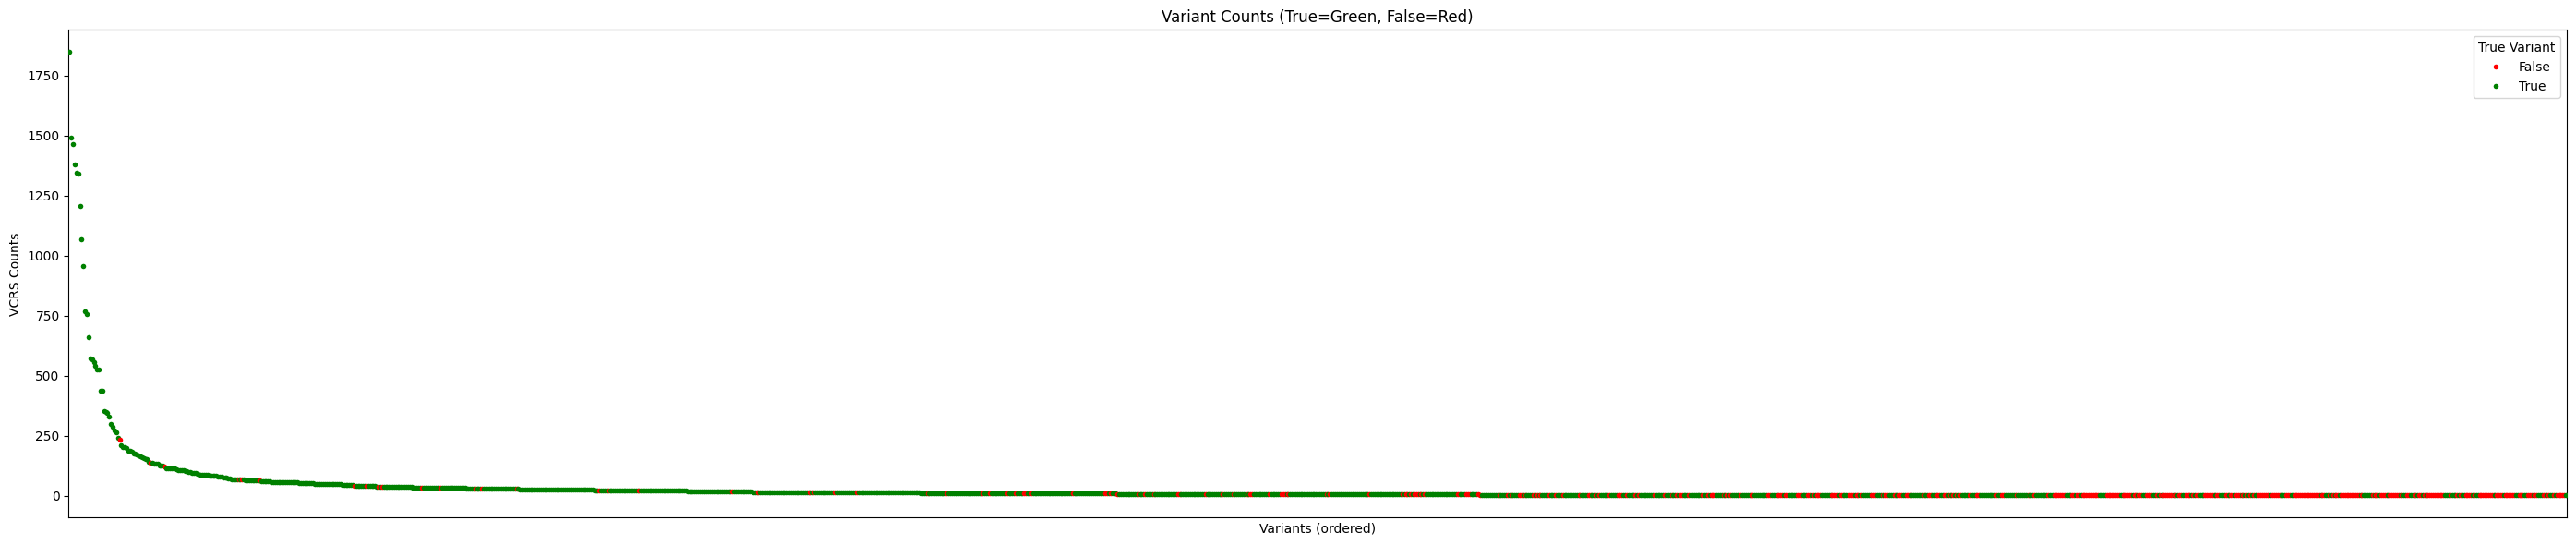

In [19]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "green", False: "red"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Green, False=Red)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.show()


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [20]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [21]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [22]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [23]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [24]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis", "fns.txt")
number_of_variants = None

bowtie_read_alignments_fn = os.path.join(notebook_out_dir, "bowtie_read_alignments_FNs_NOT_modified_bam")
detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_NOT_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_NOT_modified_bam.txt")

In [25]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [26]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [27]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs4970441,ENST00000338591,c.716G>C,+,ENST00000338591:c.716G>C,True,vcrs_0
1,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_1
2,rs8997,ENST00000379389,c.445A>G,+,ENST00000379389:c.445A>G,True,vcrs_2
3,rs2465128,ENST00000379370,c.3116A>G,+,ENST00000379370:c.3116A>G,True,vcrs_3
4,rs10267,ENST00000379370,c.3608T>C,+,ENST00000379370:c.3608T>C,True,vcrs_4


In [28]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": "jmrich@caltech.edu"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    outfolder = f"{bowtie_read_alignments_fn}/{variant}"
    os.makedirs(outfolder, exist_ok=True)

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
            
        if true_variant:
            true_variants.append(variant_header)
        else:
            false_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {true_variant}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

01:46:48: BAM index


01:47:07: Entering the loop


  0%|                                                          | 0/4863 [00:00<?, ?it/s]

  0%|                                                | 1/4863 [00:01<1:21:54,  1.01s/it]

  0%|                                                | 2/4863 [00:01<1:00:20,  1.34it/s]

  0%|                                                  | 3/4863 [00:02<54:02,  1.50it/s]

  0%|                                                  | 4/4863 [00:02<52:02,  1.56it/s]

  0%|                                                  | 5/4863 [00:03<51:48,  1.56it/s]

  0%|                                                  | 6/4863 [00:03<49:38,  1.63it/s]

  0%|                                                  | 7/4863 [00:04<48:10,  1.68it/s]

  0%|                                                  | 8/4863 [00:05<47:12,  1.71it/s]

  0%|                                                  | 9/4863 [00:05<46:36,  1.74it/s]

  0%|                                                 | 10/4863 [00:06<46:06,  1.75it/s]

  0%|                                                 | 11/4863 [00:06<45:46,  1.77it/s]

  0%|                                                 | 12/4863 [00:07<45:34,  1.77it/s]

  0%|▏                                                | 13/4863 [00:07<45:34,  1.77it/s]

  0%|▏                                                | 14/4863 [00:08<45:43,  1.77it/s]

  0%|▏                                                | 15/4863 [00:08<45:44,  1.77it/s]

  0%|▏                                                | 16/4863 [00:09<45:37,  1.77it/s]

  0%|▏                                                | 17/4863 [00:10<45:31,  1.77it/s]

  0%|▏                                                | 18/4863 [00:10<45:21,  1.78it/s]

  0%|▏                                                | 19/4863 [00:11<45:11,  1.79it/s]

  0%|▏                                                | 20/4863 [00:11<45:05,  1.79it/s]

  0%|▏                                                | 21/4863 [00:12<45:03,  1.79it/s]

  0%|▏                                                | 22/4863 [00:12<45:02,  1.79it/s]

  0%|▏                                                | 23/4863 [00:13<45:09,  1.79it/s]

  0%|▏                                                | 24/4863 [00:14<45:07,  1.79it/s]

  1%|▎                                                | 25/4863 [00:14<45:02,  1.79it/s]

  1%|▎                                                | 26/4863 [00:15<44:59,  1.79it/s]

  1%|▎                                                | 27/4863 [00:15<44:57,  1.79it/s]

  1%|▎                                                | 28/4863 [00:16<44:54,  1.79it/s]

  1%|▎                                                | 29/4863 [00:16<44:50,  1.80it/s]

  1%|▎                                                | 30/4863 [00:17<44:51,  1.80it/s]

  1%|▎                                                | 31/4863 [00:17<44:58,  1.79it/s]

  1%|▎                                                | 32/4863 [00:18<46:10,  1.74it/s]

  1%|▎                                                | 33/4863 [00:19<45:48,  1.76it/s]

  1%|▎                                                | 34/4863 [00:19<45:29,  1.77it/s]

  1%|▎                                                | 35/4863 [00:20<45:16,  1.78it/s]

  1%|▎                                                | 36/4863 [00:20<45:05,  1.78it/s]

  1%|▎                                                | 37/4863 [00:21<44:59,  1.79it/s]

  1%|▍                                                | 38/4863 [00:21<45:03,  1.78it/s]

  1%|▍                                                | 39/4863 [00:22<44:59,  1.79it/s]

  1%|▍                                                | 40/4863 [00:22<44:55,  1.79it/s]

  1%|▍                                                | 41/4863 [00:23<44:52,  1.79it/s]

  1%|▍                                              | 42/4863 [00:25<1:10:05,  1.15it/s]

  1%|▍                                              | 43/4863 [00:25<1:02:27,  1.29it/s]

  1%|▍                                              | 44/4863 [00:26<1:05:21,  1.23it/s]

  1%|▍                                              | 45/4863 [00:27<1:08:28,  1.17it/s]

  1%|▍                                              | 46/4863 [00:28<1:15:55,  1.06it/s]

  1%|▍                                              | 47/4863 [00:29<1:16:38,  1.05it/s]

  1%|▍                                              | 48/4863 [00:30<1:15:24,  1.06it/s]

  1%|▍                                              | 49/4863 [00:31<1:06:11,  1.21it/s]

  1%|▍                                              | 50/4863 [00:32<1:06:43,  1.20it/s]

  1%|▍                                              | 51/4863 [00:32<1:10:17,  1.14it/s]

  1%|▌                                              | 52/4863 [00:33<1:11:05,  1.13it/s]

  1%|▌                                              | 53/4863 [00:34<1:11:32,  1.12it/s]

  1%|▌                                              | 54/4863 [00:35<1:03:28,  1.26it/s]

  1%|▌                                                | 55/4863 [00:35<57:49,  1.39it/s]

  1%|▌                                                | 56/4863 [00:36<53:53,  1.49it/s]

  1%|▌                                                | 57/4863 [00:37<51:04,  1.57it/s]

  1%|▌                                                | 58/4863 [00:37<49:15,  1.63it/s]

  1%|▌                                                | 59/4863 [00:38<47:52,  1.67it/s]

  1%|▌                                                | 60/4863 [00:38<46:54,  1.71it/s]

  1%|▌                                                | 61/4863 [00:39<46:16,  1.73it/s]

  1%|▌                                                | 62/4863 [00:39<45:44,  1.75it/s]

  1%|▋                                                | 63/4863 [00:40<45:27,  1.76it/s]

  1%|▋                                                | 64/4863 [00:40<45:13,  1.77it/s]

  1%|▋                                                | 65/4863 [00:41<45:08,  1.77it/s]

  1%|▋                                                | 66/4863 [00:42<45:26,  1.76it/s]

  1%|▋                                                | 67/4863 [00:42<45:15,  1.77it/s]

  1%|▋                                                | 68/4863 [00:43<45:01,  1.78it/s]

  1%|▋                                                | 69/4863 [00:43<44:52,  1.78it/s]

  1%|▋                                                | 70/4863 [00:44<44:46,  1.78it/s]

  1%|▋                                                | 71/4863 [00:44<44:40,  1.79it/s]

  1%|▋                                                | 72/4863 [00:45<44:41,  1.79it/s]

  2%|▋                                                | 73/4863 [00:45<44:38,  1.79it/s]

  2%|▋                                                | 74/4863 [00:46<44:33,  1.79it/s]

  2%|▊                                                | 75/4863 [00:47<50:40,  1.57it/s]

  2%|▊                                                | 76/4863 [00:47<48:52,  1.63it/s]

  2%|▊                                                | 77/4863 [00:48<48:08,  1.66it/s]

  2%|▊                                                | 78/4863 [00:49<46:59,  1.70it/s]

  2%|▊                                                | 79/4863 [00:49<46:14,  1.72it/s]

  2%|▊                                                | 80/4863 [00:50<45:43,  1.74it/s]

  2%|▊                                                | 81/4863 [00:50<45:43,  1.74it/s]

  2%|▊                                                | 82/4863 [00:51<45:20,  1.76it/s]

  2%|▊                                                | 83/4863 [00:51<45:04,  1.77it/s]

  2%|▊                                                | 84/4863 [00:52<49:50,  1.60it/s]

  2%|▊                                                | 85/4863 [00:53<48:13,  1.65it/s]

  2%|▊                                                | 86/4863 [00:53<47:23,  1.68it/s]

  2%|▉                                                | 87/4863 [00:54<46:30,  1.71it/s]

  2%|▉                                                | 88/4863 [00:54<45:54,  1.73it/s]

  2%|▉                                                | 89/4863 [00:55<45:32,  1.75it/s]

  2%|▉                                                | 90/4863 [00:56<45:13,  1.76it/s]

  2%|▉                                                | 91/4863 [00:56<49:16,  1.61it/s]

  2%|▉                                                | 92/4863 [00:57<47:46,  1.66it/s]

  2%|▉                                                | 93/4863 [00:57<46:51,  1.70it/s]

  2%|▉                                                | 94/4863 [00:58<46:09,  1.72it/s]

  2%|▉                                                | 95/4863 [00:58<45:37,  1.74it/s]

  2%|▉                                                | 96/4863 [00:59<45:16,  1.75it/s]

  2%|▉                                                | 97/4863 [01:00<45:03,  1.76it/s]

  2%|▉                                                | 99/4863 [01:00<34:28,  2.30it/s]

  2%|▉                                               | 100/4863 [01:01<36:52,  2.15it/s]

  2%|▉                                               | 101/4863 [01:01<38:46,  2.05it/s]

  2%|█                                               | 102/4863 [01:02<40:15,  1.97it/s]

  2%|█                                               | 103/4863 [01:02<41:24,  1.92it/s]

  2%|█                                               | 104/4863 [01:03<42:12,  1.88it/s]

  2%|█                                               | 105/4863 [01:04<42:48,  1.85it/s]

  2%|█                                               | 106/4863 [01:04<43:14,  1.83it/s]

  2%|█                                               | 107/4863 [01:05<43:38,  1.82it/s]

  2%|█                                               | 108/4863 [01:05<43:48,  1.81it/s]

  2%|█                                               | 109/4863 [01:06<43:56,  1.80it/s]

  2%|█                                               | 110/4863 [01:06<43:58,  1.80it/s]

  2%|█                                               | 111/4863 [01:07<44:12,  1.79it/s]

  2%|█                                               | 112/4863 [01:07<44:27,  1.78it/s]

  2%|█                                               | 113/4863 [01:08<44:24,  1.78it/s]

  2%|█▏                                              | 114/4863 [01:09<44:19,  1.79it/s]

  2%|█▏                                              | 115/4863 [01:09<44:24,  1.78it/s]

  2%|█▏                                              | 116/4863 [01:10<44:17,  1.79it/s]

  2%|█▏                                              | 117/4863 [01:10<44:12,  1.79it/s]

  2%|█▏                                              | 118/4863 [01:11<44:09,  1.79it/s]

  2%|█▏                                              | 119/4863 [01:12<58:10,  1.36it/s]

  2%|█▏                                              | 121/4863 [01:12<41:29,  1.90it/s]

  3%|█▏                                              | 122/4863 [01:13<42:12,  1.87it/s]

  3%|█▏                                              | 123/4863 [01:14<42:43,  1.85it/s]

  3%|█▏                                              | 124/4863 [01:14<43:05,  1.83it/s]

  3%|█▏                                              | 125/4863 [01:15<43:21,  1.82it/s]

  3%|█▏                                              | 126/4863 [01:15<43:36,  1.81it/s]

  3%|█▎                                              | 127/4863 [01:16<43:43,  1.80it/s]

  3%|█▎                                              | 128/4863 [01:16<43:45,  1.80it/s]

  3%|█▎                                              | 129/4863 [01:17<44:12,  1.78it/s]

  3%|█▎                                              | 130/4863 [01:18<44:12,  1.78it/s]

  3%|█▎                                              | 131/4863 [01:18<44:08,  1.79it/s]

  3%|█▎                                              | 132/4863 [01:19<44:05,  1.79it/s]

  3%|█▎                                              | 133/4863 [01:19<44:25,  1.77it/s]

  3%|█▎                                              | 134/4863 [01:20<44:16,  1.78it/s]

  3%|█▎                                              | 135/4863 [01:20<44:18,  1.78it/s]

  3%|█▎                                              | 136/4863 [01:21<44:29,  1.77it/s]

  3%|█▎                                              | 137/4863 [01:21<44:30,  1.77it/s]

  3%|█▎                                              | 138/4863 [01:22<44:29,  1.77it/s]

  3%|█▎                                              | 139/4863 [01:23<44:29,  1.77it/s]

  3%|█▍                                              | 140/4863 [01:23<44:26,  1.77it/s]

  3%|█▍                                              | 141/4863 [01:24<44:45,  1.76it/s]

  3%|█▍                                              | 142/4863 [01:24<44:52,  1.75it/s]

  3%|█▍                                              | 143/4863 [01:25<44:33,  1.77it/s]

  3%|█▍                                              | 144/4863 [01:25<44:23,  1.77it/s]

  3%|█▍                                              | 145/4863 [01:26<44:18,  1.77it/s]

  3%|█▍                                              | 146/4863 [01:27<44:10,  1.78it/s]

  3%|█▍                                              | 147/4863 [01:27<44:07,  1.78it/s]

  3%|█▍                                              | 148/4863 [01:28<43:59,  1.79it/s]

  3%|█▍                                              | 149/4863 [01:28<44:19,  1.77it/s]

  3%|█▍                                              | 150/4863 [01:29<44:57,  1.75it/s]

  3%|█▍                                              | 151/4863 [01:29<45:39,  1.72it/s]

  3%|█▌                                              | 152/4863 [01:30<45:16,  1.73it/s]

  3%|█▌                                              | 153/4863 [01:31<44:46,  1.75it/s]

  3%|█▌                                              | 154/4863 [01:31<44:28,  1.76it/s]

  3%|█▌                                              | 155/4863 [01:32<44:15,  1.77it/s]

  3%|█▌                                              | 156/4863 [01:32<44:03,  1.78it/s]

  3%|█▌                                              | 157/4863 [01:33<44:00,  1.78it/s]

  3%|█▌                                              | 158/4863 [01:33<43:58,  1.78it/s]

  3%|█▌                                              | 159/4863 [01:34<43:50,  1.79it/s]

  3%|█▌                                              | 160/4863 [01:34<43:48,  1.79it/s]

  3%|█▌                                              | 161/4863 [01:35<43:58,  1.78it/s]

  3%|█▌                                              | 162/4863 [01:36<43:50,  1.79it/s]

  3%|█▌                                              | 163/4863 [01:36<44:03,  1.78it/s]

  3%|█▌                                              | 164/4863 [01:37<43:55,  1.78it/s]

  3%|█▋                                              | 165/4863 [01:37<43:56,  1.78it/s]

  3%|█▋                                              | 166/4863 [01:38<43:48,  1.79it/s]

  3%|█▋                                              | 167/4863 [01:38<43:49,  1.79it/s]

  3%|█▋                                              | 168/4863 [01:39<44:06,  1.77it/s]

  3%|█▋                                              | 169/4863 [01:40<44:28,  1.76it/s]

  3%|█▋                                              | 170/4863 [01:40<44:38,  1.75it/s]

  4%|█▋                                              | 171/4863 [01:41<44:15,  1.77it/s]

  4%|█▋                                              | 172/4863 [01:41<44:05,  1.77it/s]

  4%|█▋                                              | 173/4863 [01:42<55:19,  1.41it/s]

  4%|█▋                                              | 174/4863 [01:43<51:46,  1.51it/s]

  4%|█▋                                              | 175/4863 [01:43<49:15,  1.59it/s]

  4%|█▋                                              | 176/4863 [01:44<47:31,  1.64it/s]

  4%|█▋                                              | 177/4863 [01:45<46:35,  1.68it/s]

  4%|█▊                                              | 178/4863 [01:45<45:41,  1.71it/s]

  4%|█▊                                              | 179/4863 [01:46<45:04,  1.73it/s]

  4%|█▊                                              | 180/4863 [01:46<45:05,  1.73it/s]

  4%|█▊                                              | 181/4863 [01:47<44:34,  1.75it/s]

  4%|█▊                                              | 182/4863 [01:47<44:11,  1.77it/s]

  4%|█▊                                              | 184/4863 [01:48<33:55,  2.30it/s]

  4%|█▊                                              | 185/4863 [01:48<36:18,  2.15it/s]

  4%|█▊                                              | 186/4863 [01:49<38:07,  2.04it/s]

  4%|█▊                                              | 187/4863 [01:50<39:34,  1.97it/s]

  4%|█▊                                              | 188/4863 [01:50<40:37,  1.92it/s]

  4%|█▊                                              | 189/4863 [01:51<41:24,  1.88it/s]

  4%|█▉                                              | 190/4863 [01:51<41:59,  1.86it/s]

  4%|█▉                                              | 191/4863 [01:52<42:24,  1.84it/s]

  4%|█▉                                              | 192/4863 [01:52<42:42,  1.82it/s]

  4%|█▉                                              | 193/4863 [01:53<42:50,  1.82it/s]

  4%|█▉                                              | 195/4863 [01:54<36:46,  2.12it/s]

  4%|█▉                                              | 196/4863 [01:54<38:30,  2.02it/s]

  4%|█▉                                              | 197/4863 [01:55<39:45,  1.96it/s]

  4%|█▉                                              | 198/4863 [01:55<40:40,  1.91it/s]

  4%|█▉                                              | 199/4863 [01:56<41:22,  1.88it/s]

  4%|█▉                                              | 200/4863 [01:56<41:59,  1.85it/s]

  4%|█▉                                              | 201/4863 [01:57<42:31,  1.83it/s]

  4%|█▉                                              | 202/4863 [01:58<42:48,  1.81it/s]

  4%|██                                              | 203/4863 [01:58<42:57,  1.81it/s]

  4%|██                                              | 204/4863 [01:59<43:01,  1.80it/s]

  4%|██                                              | 205/4863 [01:59<43:04,  1.80it/s]

  4%|██                                              | 206/4863 [02:00<43:07,  1.80it/s]

  4%|██                                              | 207/4863 [02:00<43:19,  1.79it/s]

  4%|██                                              | 208/4863 [02:01<43:20,  1.79it/s]

  4%|██                                              | 209/4863 [02:02<43:47,  1.77it/s]

  4%|██                                              | 210/4863 [02:02<43:37,  1.78it/s]

  4%|██                                              | 211/4863 [02:03<43:37,  1.78it/s]

  4%|██                                              | 212/4863 [02:03<43:48,  1.77it/s]

  4%|██                                              | 213/4863 [02:04<48:41,  1.59it/s]

  4%|██                                              | 214/4863 [02:05<47:02,  1.65it/s]

  4%|██                                              | 215/4863 [02:05<49:31,  1.56it/s]

  4%|██▏                                             | 216/4863 [02:06<47:38,  1.63it/s]

  4%|██▏                                             | 217/4863 [02:06<46:17,  1.67it/s]

  4%|██▏                                             | 218/4863 [02:07<45:22,  1.71it/s]

  5%|██▏                                             | 219/4863 [02:08<44:40,  1.73it/s]

  5%|██▏                                             | 220/4863 [02:08<44:10,  1.75it/s]

  5%|██▏                                             | 221/4863 [02:09<43:52,  1.76it/s]

  5%|██▏                                             | 222/4863 [02:09<43:39,  1.77it/s]

  5%|██▏                                             | 223/4863 [02:10<43:30,  1.78it/s]

  5%|██▏                                             | 224/4863 [02:10<43:23,  1.78it/s]

  5%|██▏                                             | 225/4863 [02:11<43:16,  1.79it/s]

  5%|██▏                                             | 226/4863 [02:11<43:12,  1.79it/s]

  5%|██▏                                             | 227/4863 [02:12<43:09,  1.79it/s]

  5%|██▎                                             | 228/4863 [02:13<43:08,  1.79it/s]

  5%|██▎                                             | 229/4863 [02:13<43:06,  1.79it/s]

  5%|██▎                                             | 230/4863 [02:14<43:02,  1.79it/s]

  5%|██▎                                             | 231/4863 [02:14<43:01,  1.79it/s]

  5%|██▎                                             | 232/4863 [02:15<43:01,  1.79it/s]

  5%|██▎                                             | 233/4863 [02:15<43:24,  1.78it/s]

  5%|██▎                                             | 234/4863 [02:16<43:42,  1.77it/s]

  5%|██▎                                             | 235/4863 [02:16<43:35,  1.77it/s]

  5%|██▎                                             | 236/4863 [02:17<43:29,  1.77it/s]

  5%|██▎                                             | 237/4863 [02:18<43:19,  1.78it/s]

  5%|██▎                                             | 238/4863 [02:18<43:11,  1.78it/s]

  5%|██▎                                             | 239/4863 [02:19<43:04,  1.79it/s]

  5%|██▎                                             | 240/4863 [02:20<51:23,  1.50it/s]

  5%|██▍                                             | 242/4863 [02:20<37:32,  2.05it/s]

  5%|██▍                                             | 243/4863 [02:21<38:52,  1.98it/s]

  5%|██▍                                             | 244/4863 [02:21<39:56,  1.93it/s]

  5%|██▍                                             | 245/4863 [02:22<40:44,  1.89it/s]

  5%|██▍                                             | 246/4863 [02:22<41:20,  1.86it/s]

  5%|██▍                                             | 247/4863 [02:23<42:01,  1.83it/s]

  5%|██▍                                             | 248/4863 [02:24<42:22,  1.81it/s]

  5%|██▍                                             | 249/4863 [02:24<42:30,  1.81it/s]

  5%|██▍                                             | 250/4863 [02:25<42:37,  1.80it/s]

  5%|██▍                                             | 251/4863 [02:25<42:39,  1.80it/s]

  5%|██▍                                             | 252/4863 [02:26<42:40,  1.80it/s]

  5%|██▍                                             | 253/4863 [02:26<42:44,  1.80it/s]

  5%|██▌                                             | 254/4863 [02:27<56:57,  1.35it/s]

  5%|██▍                                           | 255/4863 [02:29<1:06:13,  1.16it/s]

  5%|██▍                                           | 256/4863 [02:29<1:04:06,  1.20it/s]

  5%|██▍                                           | 257/4863 [02:31<1:13:46,  1.04it/s]

  5%|██▍                                           | 258/4863 [02:32<1:20:36,  1.05s/it]

  5%|██▍                                           | 259/4863 [02:33<1:22:41,  1.08s/it]

  5%|██▍                                           | 260/4863 [02:34<1:24:57,  1.11s/it]

  5%|██▍                                           | 261/4863 [02:35<1:26:27,  1.13s/it]

  5%|██▍                                           | 262/4863 [02:37<1:26:47,  1.13s/it]

  5%|██▍                                           | 263/4863 [02:38<1:27:20,  1.14s/it]

  5%|██▍                                           | 264/4863 [02:39<1:27:54,  1.15s/it]

  5%|██▌                                           | 265/4863 [02:39<1:14:24,  1.03it/s]

  5%|██▌                                           | 266/4863 [02:40<1:04:59,  1.18it/s]

  5%|██▋                                             | 267/4863 [02:41<58:16,  1.31it/s]

  6%|██▋                                             | 268/4863 [02:41<53:35,  1.43it/s]

  6%|██▋                                             | 270/4863 [02:42<38:40,  1.98it/s]

  6%|██▋                                             | 271/4863 [02:42<39:42,  1.93it/s]

  6%|██▋                                             | 272/4863 [02:43<43:26,  1.76it/s]

  6%|██▋                                             | 273/4863 [02:43<43:09,  1.77it/s]

  6%|██▋                                             | 274/4863 [02:44<46:28,  1.65it/s]

  6%|██▋                                             | 275/4863 [02:45<49:52,  1.53it/s]

  6%|██▋                                             | 276/4863 [02:46<47:46,  1.60it/s]

  6%|██▋                                             | 277/4863 [02:46<46:13,  1.65it/s]

  6%|██▋                                             | 278/4863 [02:47<49:26,  1.55it/s]

  6%|██▊                                             | 279/4863 [02:47<47:24,  1.61it/s]

  6%|██▊                                             | 280/4863 [02:48<45:57,  1.66it/s]

  6%|██▊                                             | 281/4863 [02:49<45:49,  1.67it/s]

  6%|██▊                                             | 282/4863 [02:49<44:50,  1.70it/s]

  6%|██▊                                             | 283/4863 [02:50<44:07,  1.73it/s]

  6%|██▊                                             | 284/4863 [02:50<43:42,  1.75it/s]

  6%|██▊                                             | 285/4863 [02:51<43:20,  1.76it/s]

  6%|██▊                                             | 286/4863 [02:51<43:04,  1.77it/s]

  6%|██▊                                             | 287/4863 [02:52<42:58,  1.77it/s]

  6%|██▊                                             | 288/4863 [02:52<42:48,  1.78it/s]

  6%|██▊                                             | 289/4863 [02:53<43:34,  1.75it/s]

  6%|██▊                                             | 290/4863 [02:54<43:19,  1.76it/s]

  6%|██▊                                             | 291/4863 [02:54<43:08,  1.77it/s]

  6%|██▉                                             | 292/4863 [02:55<43:03,  1.77it/s]

  6%|██▉                                             | 293/4863 [02:55<42:58,  1.77it/s]

  6%|██▉                                             | 294/4863 [02:56<43:12,  1.76it/s]

  6%|██▉                                             | 295/4863 [02:56<43:01,  1.77it/s]

  6%|██▉                                             | 296/4863 [02:57<42:52,  1.78it/s]

  6%|██▉                                             | 297/4863 [02:58<42:40,  1.78it/s]

  6%|██▉                                             | 298/4863 [02:58<43:02,  1.77it/s]

  6%|██▉                                             | 299/4863 [02:59<42:49,  1.78it/s]

  6%|██▉                                             | 300/4863 [02:59<42:39,  1.78it/s]

  6%|██▉                                             | 301/4863 [03:00<42:31,  1.79it/s]

  6%|██▉                                             | 302/4863 [03:00<42:27,  1.79it/s]

  6%|██▉                                             | 303/4863 [03:01<42:26,  1.79it/s]

  6%|███                                             | 304/4863 [03:01<42:30,  1.79it/s]

  6%|███                                             | 305/4863 [03:02<42:25,  1.79it/s]

  6%|███                                             | 307/4863 [03:03<32:59,  2.30it/s]

  6%|███                                             | 308/4863 [03:03<35:16,  2.15it/s]

  6%|███                                             | 309/4863 [03:04<37:05,  2.05it/s]

  6%|███                                             | 310/4863 [03:04<38:43,  1.96it/s]

  6%|███                                             | 311/4863 [03:05<42:50,  1.77it/s]

  6%|███                                             | 312/4863 [03:06<42:40,  1.78it/s]

  6%|███                                             | 313/4863 [03:06<42:33,  1.78it/s]

  6%|███                                             | 314/4863 [03:07<42:30,  1.78it/s]

  6%|███                                             | 315/4863 [03:07<42:27,  1.79it/s]

  6%|███                                             | 316/4863 [03:08<42:47,  1.77it/s]

  7%|███▏                                            | 317/4863 [03:08<42:36,  1.78it/s]

  7%|███▏                                            | 318/4863 [03:09<42:34,  1.78it/s]

  7%|███▏                                            | 319/4863 [03:09<42:29,  1.78it/s]

  7%|███▏                                            | 320/4863 [03:10<42:24,  1.79it/s]

  7%|███▏                                            | 321/4863 [03:11<42:26,  1.78it/s]

  7%|███▏                                            | 322/4863 [03:11<42:21,  1.79it/s]

  7%|███▏                                            | 323/4863 [03:12<42:18,  1.79it/s]

  7%|███▏                                            | 324/4863 [03:12<42:16,  1.79it/s]

  7%|███▏                                            | 325/4863 [03:13<42:14,  1.79it/s]

  7%|███▏                                            | 326/4863 [03:13<42:12,  1.79it/s]

  7%|███▏                                            | 327/4863 [03:14<42:12,  1.79it/s]

  7%|███▏                                            | 328/4863 [03:15<43:52,  1.72it/s]

  7%|███▏                                            | 329/4863 [03:15<43:20,  1.74it/s]

  7%|███▎                                            | 330/4863 [03:16<42:55,  1.76it/s]

  7%|███▎                                            | 331/4863 [03:16<42:42,  1.77it/s]

  7%|███▎                                            | 333/4863 [03:17<32:40,  2.31it/s]

  7%|███▎                                            | 334/4863 [03:17<35:06,  2.15it/s]

  7%|███▎                                            | 335/4863 [03:18<36:54,  2.04it/s]

  7%|███▎                                            | 336/4863 [03:18<38:17,  1.97it/s]

  7%|███▎                                            | 337/4863 [03:19<39:17,  1.92it/s]

  7%|███▎                                            | 338/4863 [03:20<40:04,  1.88it/s]

  7%|███▎                                            | 339/4863 [03:20<40:48,  1.85it/s]

  7%|███▎                                            | 340/4863 [03:21<41:06,  1.83it/s]

  7%|███▎                                            | 341/4863 [03:21<41:28,  1.82it/s]

  7%|███▍                                            | 342/4863 [03:22<42:13,  1.78it/s]

  7%|███▍                                            | 343/4863 [03:22<42:11,  1.79it/s]

  7%|███▍                                            | 344/4863 [03:23<42:50,  1.76it/s]

  7%|███▍                                            | 345/4863 [03:24<42:41,  1.76it/s]

  7%|███▍                                            | 346/4863 [03:24<42:28,  1.77it/s]

  7%|███▍                                            | 347/4863 [03:25<42:34,  1.77it/s]

  7%|███▍                                            | 348/4863 [03:25<43:00,  1.75it/s]

  7%|███▍                                            | 349/4863 [03:26<42:40,  1.76it/s]

  7%|███▍                                            | 350/4863 [03:26<42:28,  1.77it/s]

  7%|███▍                                            | 351/4863 [03:27<42:38,  1.76it/s]

  7%|███▍                                            | 352/4863 [03:28<42:26,  1.77it/s]

  7%|███▍                                            | 353/4863 [03:28<42:16,  1.78it/s]

  7%|███▍                                            | 354/4863 [03:29<42:06,  1.78it/s]

  7%|███▌                                            | 355/4863 [03:29<42:06,  1.78it/s]

  7%|███▌                                            | 357/4863 [03:30<32:21,  2.32it/s]

  7%|███▌                                            | 358/4863 [03:30<34:45,  2.16it/s]

  7%|███▌                                            | 359/4863 [03:31<36:35,  2.05it/s]

  7%|███▌                                            | 360/4863 [03:31<38:02,  1.97it/s]

  7%|███▌                                            | 362/4863 [03:32<30:32,  2.46it/s]

  7%|███▌                                            | 363/4863 [03:33<33:14,  2.26it/s]

  7%|███▌                                            | 364/4863 [03:33<35:29,  2.11it/s]

  8%|███▌                                            | 365/4863 [03:34<37:09,  2.02it/s]

  8%|███▌                                            | 366/4863 [03:34<38:23,  1.95it/s]

  8%|███▌                                            | 367/4863 [03:35<39:24,  1.90it/s]

  8%|███▋                                            | 368/4863 [03:35<40:05,  1.87it/s]

  8%|███▋                                            | 369/4863 [03:36<40:34,  1.85it/s]

  8%|███▋                                            | 370/4863 [03:36<41:00,  1.83it/s]

  8%|███▋                                            | 371/4863 [03:37<43:17,  1.73it/s]

  8%|███▋                                            | 372/4863 [03:38<42:50,  1.75it/s]

  8%|███▋                                            | 373/4863 [03:38<42:27,  1.76it/s]

  8%|███▋                                            | 374/4863 [03:39<42:15,  1.77it/s]

  8%|███▋                                            | 375/4863 [03:39<42:04,  1.78it/s]

  8%|███▋                                            | 376/4863 [03:40<41:58,  1.78it/s]

  8%|███▋                                            | 377/4863 [03:40<41:56,  1.78it/s]

  8%|███▋                                            | 378/4863 [03:41<41:57,  1.78it/s]

  8%|███▋                                            | 379/4863 [03:42<43:32,  1.72it/s]

  8%|███▊                                            | 380/4863 [03:42<42:56,  1.74it/s]

  8%|███▊                                            | 381/4863 [03:43<42:35,  1.75it/s]

  8%|███▊                                            | 382/4863 [03:43<42:38,  1.75it/s]

  8%|███▊                                            | 383/4863 [03:44<42:18,  1.76it/s]

  8%|███▊                                            | 384/4863 [03:44<42:22,  1.76it/s]

  8%|███▊                                            | 385/4863 [03:45<42:08,  1.77it/s]

  8%|███▊                                            | 386/4863 [03:46<41:56,  1.78it/s]

  8%|███▊                                            | 387/4863 [03:46<41:50,  1.78it/s]

  8%|███▊                                            | 388/4863 [03:47<41:51,  1.78it/s]

  8%|███▊                                            | 389/4863 [03:47<41:42,  1.79it/s]

  8%|███▊                                            | 390/4863 [03:48<41:35,  1.79it/s]

  8%|███▊                                            | 391/4863 [03:48<41:35,  1.79it/s]

  8%|███▊                                            | 392/4863 [03:49<41:34,  1.79it/s]

  8%|███▉                                            | 393/4863 [03:49<41:33,  1.79it/s]

  8%|███▉                                            | 394/4863 [03:50<44:44,  1.67it/s]

  8%|███▉                                            | 395/4863 [03:51<43:44,  1.70it/s]

  8%|███▉                                            | 396/4863 [03:51<43:05,  1.73it/s]

  8%|███▉                                            | 397/4863 [03:52<43:06,  1.73it/s]

  8%|███▉                                            | 398/4863 [03:52<42:37,  1.75it/s]

  8%|███▉                                            | 399/4863 [03:53<42:14,  1.76it/s]

  8%|███▉                                            | 400/4863 [03:54<42:00,  1.77it/s]

  8%|███▉                                            | 401/4863 [03:54<41:51,  1.78it/s]

  8%|███▉                                            | 402/4863 [03:55<41:41,  1.78it/s]

  8%|███▉                                            | 403/4863 [03:55<41:31,  1.79it/s]

  8%|███▉                                            | 404/4863 [03:56<41:27,  1.79it/s]

  8%|███▉                                            | 405/4863 [03:56<41:28,  1.79it/s]

  8%|████                                            | 406/4863 [03:57<41:43,  1.78it/s]

  8%|████                                            | 407/4863 [03:58<44:25,  1.67it/s]

  8%|████                                            | 408/4863 [03:58<43:30,  1.71it/s]

  8%|████                                            | 409/4863 [03:59<42:52,  1.73it/s]

  8%|████                                            | 410/4863 [03:59<42:28,  1.75it/s]

  8%|████                                            | 411/4863 [04:00<42:07,  1.76it/s]

  8%|████                                            | 412/4863 [04:00<41:52,  1.77it/s]

  8%|████                                            | 413/4863 [04:01<41:42,  1.78it/s]

  9%|████                                            | 414/4863 [04:01<41:32,  1.78it/s]

  9%|████                                            | 415/4863 [04:02<41:29,  1.79it/s]

  9%|████                                            | 416/4863 [04:03<41:44,  1.78it/s]

  9%|████                                            | 417/4863 [04:03<41:46,  1.77it/s]

  9%|████▏                                           | 418/4863 [04:04<41:36,  1.78it/s]

  9%|████▏                                           | 419/4863 [04:04<41:28,  1.79it/s]

  9%|████▏                                           | 420/4863 [04:05<41:23,  1.79it/s]

  9%|████▏                                           | 421/4863 [04:06<54:28,  1.36it/s]

  9%|███▉                                          | 422/4863 [04:07<1:03:56,  1.16it/s]

  9%|████                                          | 423/4863 [04:08<1:10:28,  1.05it/s]

  9%|████                                          | 424/4863 [04:09<1:15:02,  1.01s/it]

  9%|████                                          | 425/4863 [04:10<1:05:01,  1.14it/s]

  9%|████▏                                           | 426/4863 [04:11<57:57,  1.28it/s]

  9%|████▏                                           | 427/4863 [04:11<52:52,  1.40it/s]

  9%|████▏                                           | 428/4863 [04:12<49:19,  1.50it/s]

  9%|████▏                                           | 429/4863 [04:12<46:53,  1.58it/s]

  9%|████▏                                           | 430/4863 [04:13<45:24,  1.63it/s]

  9%|████▎                                           | 431/4863 [04:13<44:09,  1.67it/s]

  9%|████▎                                           | 432/4863 [04:14<43:17,  1.71it/s]

  9%|████▎                                           | 433/4863 [04:15<42:40,  1.73it/s]

  9%|████▎                                           | 434/4863 [04:15<42:10,  1.75it/s]

  9%|████▎                                           | 435/4863 [04:16<41:49,  1.76it/s]

  9%|████▎                                           | 436/4863 [04:16<42:01,  1.76it/s]

  9%|████▎                                           | 437/4863 [04:17<41:43,  1.77it/s]

  9%|████▎                                           | 438/4863 [04:17<41:32,  1.78it/s]

  9%|████▎                                           | 439/4863 [04:18<41:22,  1.78it/s]

  9%|████▎                                           | 440/4863 [04:19<48:37,  1.52it/s]

  9%|████▎                                           | 441/4863 [04:19<46:40,  1.58it/s]

  9%|████▎                                           | 442/4863 [04:20<45:01,  1.64it/s]

  9%|████▎                                           | 443/4863 [04:20<44:15,  1.66it/s]

  9%|████▍                                           | 444/4863 [04:21<43:20,  1.70it/s]

  9%|████▍                                           | 445/4863 [04:22<42:37,  1.73it/s]

  9%|████▍                                           | 446/4863 [04:22<42:08,  1.75it/s]

  9%|████▍                                           | 447/4863 [04:23<41:45,  1.76it/s]

  9%|████▍                                           | 448/4863 [04:23<41:31,  1.77it/s]

  9%|████▍                                           | 449/4863 [04:24<41:24,  1.78it/s]

  9%|████▍                                           | 450/4863 [04:24<41:22,  1.78it/s]

  9%|████▍                                           | 451/4863 [04:25<41:50,  1.76it/s]

  9%|████▍                                           | 452/4863 [04:26<42:24,  1.73it/s]

  9%|████▍                                           | 453/4863 [04:26<41:56,  1.75it/s]

  9%|████▍                                           | 455/4863 [04:27<32:00,  2.29it/s]

  9%|████▌                                           | 456/4863 [04:27<34:17,  2.14it/s]

  9%|████▌                                           | 457/4863 [04:28<36:00,  2.04it/s]

  9%|████▌                                           | 458/4863 [04:28<37:18,  1.97it/s]

  9%|████▌                                           | 459/4863 [04:29<38:34,  1.90it/s]

  9%|████▌                                           | 460/4863 [04:29<39:15,  1.87it/s]

  9%|████▌                                           | 461/4863 [04:30<39:43,  1.85it/s]

 10%|████▌                                           | 462/4863 [04:31<40:20,  1.82it/s]

 10%|████▌                                           | 463/4863 [04:31<40:29,  1.81it/s]

 10%|████▌                                           | 464/4863 [04:32<40:34,  1.81it/s]

 10%|████▌                                           | 465/4863 [04:32<40:37,  1.80it/s]

 10%|████▌                                           | 466/4863 [04:33<40:39,  1.80it/s]

 10%|████▌                                           | 467/4863 [04:33<40:41,  1.80it/s]

 10%|████▌                                           | 468/4863 [04:34<40:43,  1.80it/s]

 10%|████▋                                           | 469/4863 [04:35<40:42,  1.80it/s]

 10%|████▋                                           | 470/4863 [04:35<40:44,  1.80it/s]

 10%|████▋                                           | 471/4863 [04:36<40:44,  1.80it/s]

 10%|████▋                                           | 472/4863 [04:36<40:44,  1.80it/s]

 10%|████▋                                           | 473/4863 [04:37<40:44,  1.80it/s]

 10%|████▋                                           | 474/4863 [04:37<40:44,  1.80it/s]

 10%|████▋                                           | 475/4863 [04:38<40:45,  1.79it/s]

 10%|████▋                                           | 476/4863 [04:38<41:05,  1.78it/s]

 10%|████▋                                           | 477/4863 [04:39<41:03,  1.78it/s]

 10%|████▋                                           | 478/4863 [04:40<40:58,  1.78it/s]

 10%|████▋                                           | 479/4863 [04:40<40:58,  1.78it/s]

 10%|████▋                                           | 480/4863 [04:41<40:53,  1.79it/s]

 10%|████▋                                           | 481/4863 [04:41<40:48,  1.79it/s]

 10%|████▊                                           | 482/4863 [04:42<40:59,  1.78it/s]

 10%|████▊                                           | 483/4863 [04:42<41:50,  1.74it/s]

 10%|████▊                                           | 484/4863 [04:43<41:33,  1.76it/s]

 10%|████▊                                           | 485/4863 [04:44<41:16,  1.77it/s]

 10%|████▊                                           | 486/4863 [04:44<41:03,  1.78it/s]

 10%|████▊                                           | 487/4863 [04:45<40:53,  1.78it/s]

 10%|████▊                                           | 488/4863 [04:45<41:17,  1.77it/s]

 10%|████▊                                           | 489/4863 [04:46<41:08,  1.77it/s]

 10%|████▊                                           | 490/4863 [04:46<40:59,  1.78it/s]

 10%|████▊                                           | 491/4863 [04:47<40:52,  1.78it/s]

 10%|████▊                                           | 492/4863 [04:47<40:49,  1.78it/s]

 10%|████▊                                           | 493/4863 [04:48<40:46,  1.79it/s]

 10%|████▉                                           | 495/4863 [04:49<31:23,  2.32it/s]

 10%|████▉                                           | 496/4863 [04:49<33:44,  2.16it/s]

 10%|████▉                                           | 497/4863 [04:50<35:30,  2.05it/s]

 10%|████▉                                           | 498/4863 [04:50<36:53,  1.97it/s]

 10%|████▉                                           | 499/4863 [04:51<37:55,  1.92it/s]

 10%|████▉                                           | 500/4863 [04:51<38:56,  1.87it/s]

 10%|████▉                                           | 501/4863 [04:52<39:21,  1.85it/s]

 10%|████▉                                           | 502/4863 [04:52<39:43,  1.83it/s]

 10%|████▉                                           | 503/4863 [04:53<40:05,  1.81it/s]

 10%|████▉                                           | 505/4863 [04:54<31:04,  2.34it/s]

 10%|████▉                                           | 506/4863 [04:54<33:23,  2.17it/s]

 10%|█████                                           | 507/4863 [04:55<35:11,  2.06it/s]

 10%|█████                                           | 508/4863 [04:55<36:37,  1.98it/s]

 10%|█████                                           | 509/4863 [04:56<37:58,  1.91it/s]

 10%|█████                                           | 510/4863 [04:56<38:38,  1.88it/s]

 11%|█████                                           | 511/4863 [04:57<39:10,  1.85it/s]

 11%|█████                                           | 512/4863 [04:58<39:30,  1.84it/s]

 11%|█████                                           | 513/4863 [04:58<39:43,  1.83it/s]

 11%|█████                                           | 514/4863 [04:59<39:57,  1.81it/s]

 11%|█████                                           | 515/4863 [04:59<40:05,  1.81it/s]

 11%|█████                                           | 516/4863 [05:00<44:34,  1.63it/s]

 11%|█████                                           | 517/4863 [05:01<43:21,  1.67it/s]

 11%|█████                                           | 518/4863 [05:01<42:27,  1.71it/s]

 11%|█████                                           | 519/4863 [05:02<41:49,  1.73it/s]

 11%|█████▏                                          | 520/4863 [05:02<41:25,  1.75it/s]

 11%|█████▏                                          | 521/4863 [05:03<45:35,  1.59it/s]

 11%|█████▏                                          | 522/4863 [05:04<44:23,  1.63it/s]

 11%|█████▏                                          | 523/4863 [05:04<43:10,  1.68it/s]

 11%|█████▏                                          | 524/4863 [05:05<42:19,  1.71it/s]

 11%|█████▏                                          | 525/4863 [05:05<41:44,  1.73it/s]

 11%|█████▏                                          | 526/4863 [05:06<41:16,  1.75it/s]

 11%|█████▏                                          | 527/4863 [05:06<40:58,  1.76it/s]

 11%|█████▏                                          | 528/4863 [05:07<45:22,  1.59it/s]

 11%|█████▏                                          | 529/4863 [05:08<43:50,  1.65it/s]

 11%|█████▏                                          | 530/4863 [05:08<45:22,  1.59it/s]

 11%|█████▏                                          | 531/4863 [05:09<44:04,  1.64it/s]

 11%|█████▎                                          | 532/4863 [05:09<42:54,  1.68it/s]

 11%|█████▎                                          | 533/4863 [05:10<42:07,  1.71it/s]

 11%|█████▎                                          | 534/4863 [05:11<41:31,  1.74it/s]

 11%|█████▎                                          | 535/4863 [05:11<41:08,  1.75it/s]

 11%|█████▎                                          | 537/4863 [05:12<31:25,  2.29it/s]

 11%|█████▎                                          | 538/4863 [05:12<34:08,  2.11it/s]

 11%|█████▎                                          | 539/4863 [05:13<35:58,  2.00it/s]

 11%|█████▎                                          | 540/4863 [05:13<37:06,  1.94it/s]

 11%|█████▎                                          | 541/4863 [05:14<38:39,  1.86it/s]

 11%|█████▎                                          | 543/4863 [05:15<31:26,  2.29it/s]

 11%|█████▍                                          | 545/4863 [05:15<29:44,  2.42it/s]

 11%|█████▍                                          | 547/4863 [05:16<27:07,  2.65it/s]

 11%|█████▍                                          | 548/4863 [05:17<30:18,  2.37it/s]

 11%|█████▍                                          | 549/4863 [05:17<32:32,  2.21it/s]

 11%|█████▍                                          | 550/4863 [05:18<37:33,  1.91it/s]

 11%|█████▍                                          | 551/4863 [05:18<38:17,  1.88it/s]

 11%|█████▍                                          | 552/4863 [05:19<39:01,  1.84it/s]

 11%|█████▍                                          | 553/4863 [05:20<39:18,  1.83it/s]

 11%|█████▍                                          | 554/4863 [05:20<39:31,  1.82it/s]

 11%|█████▍                                          | 555/4863 [05:21<39:41,  1.81it/s]

 11%|█████▍                                          | 556/4863 [05:21<39:59,  1.80it/s]

 11%|█████▍                                          | 557/4863 [05:22<39:59,  1.79it/s]

 11%|█████▌                                          | 558/4863 [05:22<39:57,  1.80it/s]

 11%|█████▌                                          | 559/4863 [05:23<39:56,  1.80it/s]

 12%|█████▌                                          | 560/4863 [05:23<39:57,  1.80it/s]

 12%|█████▌                                          | 561/4863 [05:24<39:59,  1.79it/s]

 12%|█████▌                                          | 562/4863 [05:25<48:22,  1.48it/s]

 12%|█████▌                                          | 563/4863 [05:26<45:48,  1.56it/s]

 12%|█████▌                                          | 564/4863 [05:26<44:01,  1.63it/s]

 12%|█████▌                                          | 565/4863 [05:27<42:48,  1.67it/s]

 12%|█████▌                                          | 566/4863 [05:27<42:00,  1.70it/s]

 12%|█████▌                                          | 567/4863 [05:28<41:23,  1.73it/s]

 12%|█████▌                                          | 568/4863 [05:28<41:16,  1.73it/s]

 12%|█████▌                                          | 569/4863 [05:29<40:57,  1.75it/s]

 12%|█████▋                                          | 570/4863 [05:29<40:38,  1.76it/s]

 12%|█████▋                                          | 571/4863 [05:30<40:23,  1.77it/s]

 12%|█████▋                                          | 572/4863 [05:31<40:18,  1.77it/s]

 12%|█████▋                                          | 573/4863 [05:31<40:12,  1.78it/s]

 12%|█████▋                                          | 574/4863 [05:32<40:03,  1.78it/s]

 12%|█████▋                                          | 575/4863 [05:32<39:59,  1.79it/s]

 12%|█████▋                                          | 576/4863 [05:33<40:04,  1.78it/s]

 12%|█████▋                                          | 577/4863 [05:33<40:00,  1.79it/s]

 12%|█████▋                                          | 578/4863 [05:34<39:56,  1.79it/s]

 12%|█████▋                                          | 579/4863 [05:35<39:53,  1.79it/s]

 12%|█████▋                                          | 580/4863 [05:35<40:07,  1.78it/s]

 12%|█████▋                                          | 581/4863 [05:36<40:02,  1.78it/s]

 12%|█████▋                                          | 582/4863 [05:36<39:59,  1.78it/s]

 12%|█████▊                                          | 583/4863 [05:37<39:54,  1.79it/s]

 12%|█████▊                                          | 584/4863 [05:37<40:19,  1.77it/s]

 12%|█████▊                                          | 585/4863 [05:38<40:05,  1.78it/s]

 12%|█████▊                                          | 586/4863 [05:38<40:02,  1.78it/s]

 12%|█████▊                                          | 587/4863 [05:39<45:12,  1.58it/s]

 12%|█████▊                                          | 589/4863 [05:40<33:31,  2.13it/s]

 12%|█████▊                                          | 590/4863 [05:40<35:04,  2.03it/s]

 12%|█████▊                                          | 591/4863 [05:41<42:52,  1.66it/s]

 12%|█████▊                                          | 592/4863 [05:42<50:03,  1.42it/s]

 12%|█████▊                                          | 593/4863 [05:43<47:11,  1.51it/s]

 12%|█████▊                                          | 594/4863 [05:44<56:16,  1.26it/s]

 12%|█████▊                                          | 595/4863 [05:44<51:27,  1.38it/s]

 12%|█████▉                                          | 596/4863 [05:45<47:59,  1.48it/s]

 12%|█████▉                                          | 597/4863 [05:46<45:31,  1.56it/s]

 12%|█████▉                                          | 598/4863 [05:46<43:44,  1.63it/s]

 12%|█████▉                                          | 599/4863 [05:47<42:56,  1.66it/s]

 12%|█████▉                                          | 600/4863 [05:47<41:59,  1.69it/s]

 12%|█████▉                                          | 601/4863 [05:48<41:14,  1.72it/s]

 12%|█████▉                                          | 602/4863 [05:48<40:41,  1.74it/s]

 12%|█████▉                                          | 603/4863 [05:49<40:26,  1.76it/s]

 12%|█████▉                                          | 604/4863 [05:50<48:06,  1.48it/s]

 12%|█████▉                                          | 605/4863 [05:50<45:33,  1.56it/s]

 12%|█████▉                                          | 606/4863 [05:51<43:46,  1.62it/s]

 12%|█████▉                                          | 607/4863 [05:52<51:23,  1.38it/s]

 13%|██████                                          | 608/4863 [05:53<47:48,  1.48it/s]

 13%|██████                                          | 609/4863 [05:53<45:22,  1.56it/s]

 13%|██████                                          | 610/4863 [05:54<43:36,  1.63it/s]

 13%|██████                                          | 611/4863 [05:54<42:23,  1.67it/s]

 13%|██████                                          | 612/4863 [05:55<41:33,  1.70it/s]

 13%|██████                                          | 613/4863 [05:55<41:21,  1.71it/s]

 13%|██████                                          | 614/4863 [05:56<41:06,  1.72it/s]

 13%|██████                                          | 615/4863 [05:56<40:40,  1.74it/s]

 13%|██████                                          | 616/4863 [05:57<40:23,  1.75it/s]

 13%|██████                                          | 617/4863 [05:58<40:11,  1.76it/s]

 13%|██████                                          | 618/4863 [05:58<39:55,  1.77it/s]

 13%|██████                                          | 619/4863 [05:59<39:44,  1.78it/s]

 13%|██████                                          | 620/4863 [05:59<39:36,  1.79it/s]

 13%|██████▏                                         | 621/4863 [06:00<39:31,  1.79it/s]

 13%|██████▏                                         | 622/4863 [06:00<39:29,  1.79it/s]

 13%|██████▏                                         | 623/4863 [06:01<39:33,  1.79it/s]

 13%|██████▏                                         | 624/4863 [06:02<39:37,  1.78it/s]

 13%|██████▏                                         | 625/4863 [06:02<39:59,  1.77it/s]

 13%|██████▏                                         | 627/4863 [06:03<30:38,  2.30it/s]

 13%|██████▏                                         | 628/4863 [06:03<32:47,  2.15it/s]

 13%|██████▏                                         | 629/4863 [06:04<45:32,  1.55it/s]

 13%|██████▏                                         | 630/4863 [06:06<55:11,  1.28it/s]

 13%|█████▉                                        | 631/4863 [06:07<1:02:21,  1.13it/s]

 13%|█████▉                                        | 632/4863 [06:08<1:08:03,  1.04it/s]

 13%|██████▏                                         | 633/4863 [06:08<59:44,  1.18it/s]

 13%|██████▎                                         | 634/4863 [06:09<53:52,  1.31it/s]

 13%|██████▎                                         | 636/4863 [06:10<38:32,  1.83it/s]

 13%|██████▎                                         | 637/4863 [06:10<38:41,  1.82it/s]

 13%|██████▎                                         | 638/4863 [06:11<38:48,  1.81it/s]

 13%|██████▎                                         | 639/4863 [06:11<39:12,  1.80it/s]

 13%|██████▎                                         | 640/4863 [06:12<39:17,  1.79it/s]

 13%|██████▎                                         | 641/4863 [06:12<39:39,  1.77it/s]

 13%|██████▎                                         | 642/4863 [06:13<39:33,  1.78it/s]

 13%|██████▎                                         | 643/4863 [06:13<39:25,  1.78it/s]

 13%|██████▎                                         | 644/4863 [06:14<39:23,  1.79it/s]

 13%|██████▎                                         | 645/4863 [06:15<39:17,  1.79it/s]

 13%|██████▍                                         | 646/4863 [06:15<39:34,  1.78it/s]

 13%|██████▍                                         | 647/4863 [06:16<39:33,  1.78it/s]

 13%|██████▍                                         | 648/4863 [06:16<39:23,  1.78it/s]

 13%|██████▍                                         | 649/4863 [06:17<39:42,  1.77it/s]

 13%|██████▍                                         | 650/4863 [06:17<39:52,  1.76it/s]

 13%|██████▍                                         | 651/4863 [06:18<39:51,  1.76it/s]

 13%|██████▍                                         | 652/4863 [06:19<39:37,  1.77it/s]

 13%|██████▍                                         | 653/4863 [06:19<40:07,  1.75it/s]

 13%|██████▍                                         | 654/4863 [06:20<39:52,  1.76it/s]

 13%|██████▍                                         | 655/4863 [06:20<39:43,  1.77it/s]

 13%|██████▍                                         | 656/4863 [06:21<39:34,  1.77it/s]

 14%|██████▍                                         | 657/4863 [06:21<39:29,  1.78it/s]

 14%|██████▍                                         | 658/4863 [06:22<40:57,  1.71it/s]

 14%|██████▌                                         | 659/4863 [06:23<40:22,  1.74it/s]

 14%|██████▌                                         | 660/4863 [06:23<39:57,  1.75it/s]

 14%|██████▌                                         | 661/4863 [06:24<39:45,  1.76it/s]

 14%|██████▌                                         | 662/4863 [06:24<39:35,  1.77it/s]

 14%|██████▌                                         | 663/4863 [06:25<39:42,  1.76it/s]

 14%|██████▌                                         | 664/4863 [06:25<39:31,  1.77it/s]

 14%|██████▌                                         | 665/4863 [06:26<39:24,  1.78it/s]

 14%|██████▌                                         | 666/4863 [06:26<39:16,  1.78it/s]

 14%|██████▌                                         | 667/4863 [06:27<39:11,  1.78it/s]

 14%|██████▌                                         | 668/4863 [06:28<39:07,  1.79it/s]

 14%|██████▌                                         | 669/4863 [06:28<39:07,  1.79it/s]

 14%|██████▌                                         | 670/4863 [06:29<39:03,  1.79it/s]

 14%|██████▌                                         | 671/4863 [06:29<39:01,  1.79it/s]

 14%|██████▋                                         | 672/4863 [06:30<39:01,  1.79it/s]

 14%|██████▋                                         | 673/4863 [06:30<38:55,  1.79it/s]

 14%|██████▋                                         | 674/4863 [06:31<38:54,  1.79it/s]

 14%|██████▋                                         | 675/4863 [06:32<38:50,  1.80it/s]

 14%|██████▋                                         | 676/4863 [06:32<38:54,  1.79it/s]

 14%|██████▋                                         | 677/4863 [06:33<39:12,  1.78it/s]

 14%|██████▋                                         | 678/4863 [06:33<39:24,  1.77it/s]

 14%|██████▋                                         | 679/4863 [06:34<39:13,  1.78it/s]

 14%|██████▋                                         | 680/4863 [06:34<39:05,  1.78it/s]

 14%|██████▋                                         | 681/4863 [06:35<39:00,  1.79it/s]

 14%|██████▋                                         | 682/4863 [06:35<39:12,  1.78it/s]

 14%|██████▋                                         | 683/4863 [06:36<39:08,  1.78it/s]

 14%|██████▊                                         | 684/4863 [06:37<39:01,  1.78it/s]

 14%|██████▊                                         | 685/4863 [06:37<39:02,  1.78it/s]

 14%|██████▊                                         | 686/4863 [06:38<39:20,  1.77it/s]

 14%|██████▊                                         | 687/4863 [06:38<39:07,  1.78it/s]

 14%|██████▊                                         | 688/4863 [06:39<39:10,  1.78it/s]

 14%|██████▊                                         | 689/4863 [06:39<39:02,  1.78it/s]

 14%|██████▊                                         | 690/4863 [06:40<39:01,  1.78it/s]

 14%|██████▊                                         | 691/4863 [06:41<39:04,  1.78it/s]

 14%|██████▊                                         | 692/4863 [06:41<38:58,  1.78it/s]

 14%|██████▊                                         | 693/4863 [06:42<38:52,  1.79it/s]

 14%|██████▊                                         | 694/4863 [06:42<38:53,  1.79it/s]

 14%|██████▊                                         | 695/4863 [06:43<38:49,  1.79it/s]

 14%|██████▊                                         | 696/4863 [06:43<38:45,  1.79it/s]

 14%|██████▉                                         | 697/4863 [06:44<39:04,  1.78it/s]

 14%|██████▉                                         | 698/4863 [06:44<39:00,  1.78it/s]

 14%|██████▉                                         | 699/4863 [06:45<39:24,  1.76it/s]

 14%|██████▉                                         | 700/4863 [06:46<39:09,  1.77it/s]

 14%|██████▉                                         | 701/4863 [06:46<39:01,  1.78it/s]

 14%|██████▉                                         | 702/4863 [06:47<44:13,  1.57it/s]

 14%|██████▉                                         | 703/4863 [06:48<42:37,  1.63it/s]

 14%|██████▉                                         | 704/4863 [06:48<41:28,  1.67it/s]

 14%|██████▉                                         | 705/4863 [06:49<40:36,  1.71it/s]

 15%|██████▉                                         | 706/4863 [06:49<39:59,  1.73it/s]

 15%|██████▉                                         | 707/4863 [06:50<39:52,  1.74it/s]

 15%|██████▉                                         | 708/4863 [06:50<39:33,  1.75it/s]

 15%|███████                                         | 710/4863 [06:51<30:10,  2.29it/s]

 15%|███████                                         | 711/4863 [06:51<32:13,  2.15it/s]

 15%|███████                                         | 712/4863 [06:52<34:21,  2.01it/s]

 15%|███████                                         | 713/4863 [06:53<35:28,  1.95it/s]

 15%|███████                                         | 714/4863 [06:53<36:44,  1.88it/s]

 15%|███████                                         | 715/4863 [06:54<37:15,  1.86it/s]

 15%|███████                                         | 716/4863 [06:54<37:40,  1.83it/s]

 15%|███████                                         | 717/4863 [06:55<37:51,  1.82it/s]

 15%|███████                                         | 718/4863 [06:55<38:02,  1.82it/s]

 15%|███████                                         | 719/4863 [06:56<38:08,  1.81it/s]

 15%|███████                                         | 720/4863 [06:56<38:14,  1.81it/s]

 15%|███████                                         | 721/4863 [06:57<38:23,  1.80it/s]

 15%|███████▏                                        | 722/4863 [06:58<38:28,  1.79it/s]

 15%|███████▏                                        | 723/4863 [06:58<38:27,  1.79it/s]

 15%|███████▏                                        | 724/4863 [06:59<38:28,  1.79it/s]

 15%|███████▏                                        | 725/4863 [06:59<39:51,  1.73it/s]

 15%|███████▏                                        | 726/4863 [07:00<39:24,  1.75it/s]

 15%|███████▏                                        | 727/4863 [07:00<39:07,  1.76it/s]

 15%|███████▏                                        | 728/4863 [07:01<38:59,  1.77it/s]

 15%|███████▏                                        | 729/4863 [07:02<38:47,  1.78it/s]

 15%|███████▏                                        | 730/4863 [07:02<38:38,  1.78it/s]

 15%|███████▏                                        | 731/4863 [07:03<38:32,  1.79it/s]

 15%|███████▏                                        | 732/4863 [07:03<38:30,  1.79it/s]

 15%|███████▏                                        | 733/4863 [07:04<38:27,  1.79it/s]

 15%|███████▏                                        | 734/4863 [07:04<38:26,  1.79it/s]

 15%|███████▎                                        | 735/4863 [07:05<38:23,  1.79it/s]

 15%|███████▎                                        | 736/4863 [07:05<38:22,  1.79it/s]

 15%|███████▎                                        | 737/4863 [07:06<38:33,  1.78it/s]

 15%|███████▎                                        | 738/4863 [07:07<38:28,  1.79it/s]

 15%|███████▎                                        | 739/4863 [07:07<38:34,  1.78it/s]

 15%|███████▎                                        | 740/4863 [07:08<40:36,  1.69it/s]

 15%|███████▎                                        | 741/4863 [07:08<40:11,  1.71it/s]

 15%|███████▎                                        | 742/4863 [07:09<39:45,  1.73it/s]

 15%|███████▎                                        | 743/4863 [07:10<39:18,  1.75it/s]

 15%|███████▎                                        | 744/4863 [07:10<39:22,  1.74it/s]

 15%|███████▎                                        | 745/4863 [07:11<39:04,  1.76it/s]

 15%|███████▎                                        | 746/4863 [07:11<38:48,  1.77it/s]

 15%|███████▎                                        | 747/4863 [07:12<39:04,  1.76it/s]

 15%|███████▍                                        | 748/4863 [07:12<38:50,  1.77it/s]

 15%|███████▍                                        | 749/4863 [07:13<38:37,  1.77it/s]

 15%|███████▍                                        | 750/4863 [07:13<38:29,  1.78it/s]

 15%|███████▍                                        | 751/4863 [07:15<51:02,  1.34it/s]

 15%|███████▍                                        | 752/4863 [07:15<47:07,  1.45it/s]

 15%|███████▍                                        | 753/4863 [07:16<44:43,  1.53it/s]

 16%|███████▍                                        | 754/4863 [07:16<42:47,  1.60it/s]

 16%|███████▍                                        | 756/4863 [07:17<31:52,  2.15it/s]

 16%|███████▍                                        | 757/4863 [07:17<33:29,  2.04it/s]

 16%|███████▍                                        | 758/4863 [07:18<34:41,  1.97it/s]

 16%|███████▍                                        | 759/4863 [07:19<35:38,  1.92it/s]

 16%|███████▌                                        | 760/4863 [07:19<36:18,  1.88it/s]

 16%|███████▌                                        | 761/4863 [07:20<36:47,  1.86it/s]

 16%|███████▌                                        | 762/4863 [07:20<37:08,  1.84it/s]

 16%|███████▌                                        | 763/4863 [07:21<37:22,  1.83it/s]

 16%|███████▌                                        | 764/4863 [07:21<37:41,  1.81it/s]

 16%|███████▌                                        | 765/4863 [07:22<38:01,  1.80it/s]

 16%|███████▌                                        | 766/4863 [07:22<38:02,  1.80it/s]

 16%|███████▌                                        | 767/4863 [07:23<38:01,  1.80it/s]

 16%|███████▌                                        | 768/4863 [07:24<38:04,  1.79it/s]

 16%|███████▌                                        | 769/4863 [07:24<38:05,  1.79it/s]

 16%|███████▌                                        | 770/4863 [07:25<38:02,  1.79it/s]

 16%|███████▌                                        | 771/4863 [07:25<38:15,  1.78it/s]

 16%|███████▌                                        | 772/4863 [07:26<38:13,  1.78it/s]

 16%|███████▋                                        | 773/4863 [07:26<38:08,  1.79it/s]

 16%|███████▋                                        | 774/4863 [07:27<38:08,  1.79it/s]

 16%|███████▋                                        | 775/4863 [07:28<38:15,  1.78it/s]

 16%|███████▋                                        | 776/4863 [07:29<47:16,  1.44it/s]

 16%|███████▋                                        | 777/4863 [07:29<44:27,  1.53it/s]

 16%|███████▋                                        | 779/4863 [07:30<32:39,  2.08it/s]

 16%|███████▋                                        | 780/4863 [07:30<34:00,  2.00it/s]

 16%|███████▋                                        | 781/4863 [07:31<35:18,  1.93it/s]

 16%|███████▋                                        | 782/4863 [07:31<36:01,  1.89it/s]

 16%|███████▋                                        | 783/4863 [07:32<36:34,  1.86it/s]

 16%|███████▋                                        | 784/4863 [07:32<37:18,  1.82it/s]

 16%|███████▋                                        | 785/4863 [07:33<37:30,  1.81it/s]

 16%|███████▊                                        | 786/4863 [07:34<37:36,  1.81it/s]

 16%|███████▊                                        | 787/4863 [07:34<37:41,  1.80it/s]

 16%|███████▊                                        | 788/4863 [07:35<37:45,  1.80it/s]

 16%|███████▊                                        | 789/4863 [07:35<37:46,  1.80it/s]

 16%|███████▊                                        | 790/4863 [07:36<37:59,  1.79it/s]

 16%|███████▊                                        | 791/4863 [07:36<37:56,  1.79it/s]

 16%|███████▊                                        | 792/4863 [07:37<37:54,  1.79it/s]

 16%|███████▊                                        | 793/4863 [07:37<37:54,  1.79it/s]

 16%|███████▊                                        | 794/4863 [07:38<37:51,  1.79it/s]

 16%|███████▊                                        | 795/4863 [07:39<37:53,  1.79it/s]

 16%|███████▊                                        | 796/4863 [07:39<37:51,  1.79it/s]

 16%|███████▊                                        | 797/4863 [07:40<37:50,  1.79it/s]

 16%|███████▉                                        | 798/4863 [07:40<37:54,  1.79it/s]

 16%|███████▉                                        | 799/4863 [07:41<37:53,  1.79it/s]

 16%|███████▉                                        | 800/4863 [07:41<37:51,  1.79it/s]

 16%|███████▉                                        | 801/4863 [07:42<37:53,  1.79it/s]

 16%|███████▉                                        | 802/4863 [07:43<37:50,  1.79it/s]

 17%|███████▉                                        | 803/4863 [07:43<37:47,  1.79it/s]

 17%|███████▉                                        | 804/4863 [07:44<37:43,  1.79it/s]

 17%|███████▉                                        | 805/4863 [07:44<38:10,  1.77it/s]

 17%|███████▉                                        | 806/4863 [07:45<39:33,  1.71it/s]

 17%|███████▉                                        | 807/4863 [07:45<38:56,  1.74it/s]

 17%|███████▉                                        | 808/4863 [07:46<38:35,  1.75it/s]

 17%|███████▉                                        | 809/4863 [07:47<38:18,  1.76it/s]

 17%|███████▉                                        | 810/4863 [07:47<38:37,  1.75it/s]

 17%|████████                                        | 811/4863 [07:48<38:20,  1.76it/s]

 17%|████████                                        | 812/4863 [07:48<38:06,  1.77it/s]

 17%|████████                                        | 813/4863 [07:49<37:56,  1.78it/s]

 17%|████████                                        | 814/4863 [07:49<37:52,  1.78it/s]

 17%|████████                                        | 815/4863 [07:50<37:45,  1.79it/s]

 17%|████████                                        | 816/4863 [07:50<37:42,  1.79it/s]

 17%|████████                                        | 817/4863 [07:51<37:38,  1.79it/s]

 17%|████████                                        | 818/4863 [07:52<37:36,  1.79it/s]

 17%|████████                                        | 820/4863 [07:52<29:01,  2.32it/s]

 17%|████████                                        | 821/4863 [07:53<31:05,  2.17it/s]

 17%|████████                                        | 822/4863 [07:53<32:49,  2.05it/s]

 17%|████████                                        | 823/4863 [07:54<34:08,  1.97it/s]

 17%|████████▏                                       | 824/4863 [07:54<35:07,  1.92it/s]

 17%|████████▏                                       | 825/4863 [07:55<35:50,  1.88it/s]

 17%|████████▏                                       | 826/4863 [07:55<36:21,  1.85it/s]

 17%|████████▏                                       | 827/4863 [07:56<36:41,  1.83it/s]

 17%|████████▏                                       | 828/4863 [07:57<36:54,  1.82it/s]

 17%|████████▏                                       | 829/4863 [07:57<37:14,  1.81it/s]

 17%|████████▏                                       | 830/4863 [07:58<37:16,  1.80it/s]

 17%|████████▏                                       | 831/4863 [07:58<37:36,  1.79it/s]

 17%|████████▏                                       | 832/4863 [07:59<37:41,  1.78it/s]

 17%|████████▏                                       | 833/4863 [07:59<37:52,  1.77it/s]

 17%|████████▏                                       | 834/4863 [08:00<37:47,  1.78it/s]

 17%|████████▏                                       | 835/4863 [08:01<37:40,  1.78it/s]

 17%|████████▎                                       | 836/4863 [08:01<37:36,  1.78it/s]

 17%|████████▎                                       | 837/4863 [08:02<38:15,  1.75it/s]

 17%|████████▎                                       | 838/4863 [08:02<38:00,  1.77it/s]

 17%|████████▎                                       | 839/4863 [08:03<37:51,  1.77it/s]

 17%|████████▎                                       | 840/4863 [08:03<37:43,  1.78it/s]

 17%|████████▎                                       | 841/4863 [08:04<37:42,  1.78it/s]

 17%|████████▎                                       | 842/4863 [08:04<37:36,  1.78it/s]

 17%|████████▎                                       | 843/4863 [08:05<37:39,  1.78it/s]

 17%|████████▎                                       | 844/4863 [08:06<37:33,  1.78it/s]

 17%|████████▎                                       | 845/4863 [08:06<37:28,  1.79it/s]

 17%|████████▎                                       | 846/4863 [08:07<37:25,  1.79it/s]

 17%|████████▎                                       | 847/4863 [08:07<37:29,  1.79it/s]

 17%|████████▎                                       | 848/4863 [08:08<37:33,  1.78it/s]

 17%|████████▍                                       | 849/4863 [08:08<37:35,  1.78it/s]

 17%|████████▍                                       | 850/4863 [08:09<37:35,  1.78it/s]

 17%|████████▍                                       | 851/4863 [08:10<37:28,  1.78it/s]

 18%|████████▍                                       | 852/4863 [08:10<37:25,  1.79it/s]

 18%|████████▍                                       | 853/4863 [08:11<37:25,  1.79it/s]

 18%|████████▍                                       | 854/4863 [08:11<37:22,  1.79it/s]

 18%|████████▍                                       | 855/4863 [08:12<37:20,  1.79it/s]

 18%|████████▍                                       | 856/4863 [08:12<37:22,  1.79it/s]

 18%|████████▍                                       | 857/4863 [08:13<37:16,  1.79it/s]

 18%|████████▍                                       | 858/4863 [08:13<37:15,  1.79it/s]

 18%|████████▍                                       | 859/4863 [08:14<37:14,  1.79it/s]

 18%|████████▍                                       | 860/4863 [08:15<37:15,  1.79it/s]

 18%|████████▍                                       | 861/4863 [08:16<47:04,  1.42it/s]

 18%|████████▌                                       | 862/4863 [08:16<44:04,  1.51it/s]

 18%|████████▌                                       | 863/4863 [08:17<42:01,  1.59it/s]

 18%|████████▌                                       | 864/4863 [08:17<40:37,  1.64it/s]

 18%|████████▌                                       | 865/4863 [08:18<40:03,  1.66it/s]

 18%|████████▌                                       | 866/4863 [08:18<39:09,  1.70it/s]

 18%|████████▌                                       | 867/4863 [08:19<38:35,  1.73it/s]

 18%|████████▌                                       | 868/4863 [08:20<38:05,  1.75it/s]

 18%|████████▌                                       | 869/4863 [08:20<37:50,  1.76it/s]

 18%|████████▌                                       | 870/4863 [08:21<37:44,  1.76it/s]

 18%|████████▌                                       | 871/4863 [08:21<37:34,  1.77it/s]

 18%|████████▌                                       | 872/4863 [08:22<37:29,  1.77it/s]

 18%|████████▌                                       | 873/4863 [08:22<37:25,  1.78it/s]

 18%|████████▋                                       | 874/4863 [08:23<37:15,  1.78it/s]

 18%|████████▋                                       | 875/4863 [08:23<37:13,  1.79it/s]

 18%|████████▋                                       | 876/4863 [08:24<37:12,  1.79it/s]

 18%|████████▋                                       | 877/4863 [08:25<37:08,  1.79it/s]

 18%|████████▋                                       | 878/4863 [08:25<37:36,  1.77it/s]

 18%|████████▋                                       | 879/4863 [08:26<37:25,  1.77it/s]

 18%|████████▋                                       | 880/4863 [08:26<37:16,  1.78it/s]

 18%|████████▋                                       | 881/4863 [08:27<37:12,  1.78it/s]

 18%|████████▋                                       | 882/4863 [08:27<37:09,  1.79it/s]

 18%|████████▋                                       | 883/4863 [08:28<37:09,  1.79it/s]

 18%|████████▋                                       | 884/4863 [08:29<37:39,  1.76it/s]

 18%|████████▋                                       | 885/4863 [08:29<37:28,  1.77it/s]

 18%|████████▋                                       | 886/4863 [08:30<37:20,  1.78it/s]

 18%|████████▊                                       | 887/4863 [08:30<37:09,  1.78it/s]

 18%|████████▊                                       | 888/4863 [08:31<37:08,  1.78it/s]

 18%|████████▊                                       | 889/4863 [08:31<37:02,  1.79it/s]

 18%|████████▊                                       | 890/4863 [08:32<37:00,  1.79it/s]

 18%|████████▊                                       | 891/4863 [08:32<37:01,  1.79it/s]

 18%|████████▊                                       | 892/4863 [08:33<37:14,  1.78it/s]

 18%|████████▊                                       | 893/4863 [08:34<37:08,  1.78it/s]

 18%|████████▊                                       | 894/4863 [08:34<37:04,  1.78it/s]

 18%|████████▊                                       | 895/4863 [08:35<37:05,  1.78it/s]

 18%|████████▊                                       | 896/4863 [08:35<36:59,  1.79it/s]

 18%|████████▊                                       | 897/4863 [08:36<36:55,  1.79it/s]

 18%|████████▊                                       | 898/4863 [08:36<37:04,  1.78it/s]

 18%|████████▊                                       | 899/4863 [08:38<48:42,  1.36it/s]

 19%|████████▉                                       | 900/4863 [08:39<58:05,  1.14it/s]

 19%|████████▌                                     | 901/4863 [08:40<1:04:12,  1.03it/s]

 19%|████████▌                                     | 902/4863 [08:41<1:07:51,  1.03s/it]

 19%|████████▌                                     | 903/4863 [08:42<1:11:23,  1.08s/it]

 19%|████████▌                                     | 904/4863 [08:43<1:12:59,  1.11s/it]

 19%|████████▌                                     | 905/4863 [08:45<1:14:09,  1.12s/it]

 19%|████████▌                                     | 906/4863 [08:46<1:15:09,  1.14s/it]

 19%|████████▌                                     | 907/4863 [08:47<1:15:43,  1.15s/it]

 19%|████████▌                                     | 908/4863 [08:48<1:15:45,  1.15s/it]

 19%|████████▌                                     | 909/4863 [08:49<1:16:07,  1.16s/it]

 19%|████████▌                                     | 910/4863 [08:50<1:12:26,  1.10s/it]

 19%|████████▌                                     | 911/4863 [08:51<1:01:50,  1.07it/s]

 19%|█████████                                       | 912/4863 [08:51<54:23,  1.21it/s]

 19%|████████▋                                     | 913/4863 [08:53<1:01:38,  1.07it/s]

 19%|█████████                                       | 914/4863 [08:53<54:29,  1.21it/s]

 19%|█████████                                       | 915/4863 [08:54<49:24,  1.33it/s]

 19%|█████████                                       | 916/4863 [08:54<45:35,  1.44it/s]

 19%|█████████                                       | 917/4863 [08:55<42:59,  1.53it/s]

 19%|█████████                                       | 918/4863 [08:55<41:14,  1.59it/s]

 19%|█████████                                       | 919/4863 [08:56<39:52,  1.65it/s]

 19%|█████████                                       | 920/4863 [08:57<39:14,  1.67it/s]

 19%|█████████                                       | 921/4863 [08:57<38:27,  1.71it/s]

 19%|█████████                                       | 922/4863 [08:58<37:56,  1.73it/s]

 19%|█████████                                       | 923/4863 [08:58<37:32,  1.75it/s]

 19%|█████████                                       | 924/4863 [08:59<48:47,  1.35it/s]

 19%|█████████▏                                      | 925/4863 [09:00<45:08,  1.45it/s]

 19%|█████████▏                                      | 926/4863 [09:00<42:36,  1.54it/s]

 19%|█████████▏                                      | 927/4863 [09:01<40:46,  1.61it/s]

 19%|█████████▏                                      | 928/4863 [09:02<39:31,  1.66it/s]

 19%|█████████▏                                      | 929/4863 [09:02<38:36,  1.70it/s]

 19%|█████████▏                                      | 930/4863 [09:03<38:00,  1.72it/s]

 19%|█████████▏                                      | 931/4863 [09:03<37:51,  1.73it/s]

 19%|█████████▏                                      | 932/4863 [09:04<37:29,  1.75it/s]

 19%|█████████▏                                      | 934/4863 [09:04<28:36,  2.29it/s]

 19%|█████████▏                                      | 935/4863 [09:05<30:32,  2.14it/s]

 19%|█████████▏                                      | 936/4863 [09:06<32:07,  2.04it/s]

 19%|█████████▏                                      | 937/4863 [09:06<33:16,  1.97it/s]

 19%|█████████▎                                      | 938/4863 [09:07<34:10,  1.91it/s]

 19%|█████████▎                                      | 939/4863 [09:07<35:08,  1.86it/s]

 19%|█████████▎                                      | 940/4863 [09:08<35:29,  1.84it/s]

 19%|█████████▎                                      | 941/4863 [09:08<35:44,  1.83it/s]

 19%|█████████▎                                      | 942/4863 [09:09<35:56,  1.82it/s]

 19%|█████████▎                                      | 943/4863 [09:09<36:10,  1.81it/s]

 19%|█████████▎                                      | 944/4863 [09:10<36:16,  1.80it/s]

 19%|█████████▎                                      | 945/4863 [09:11<36:22,  1.80it/s]

 19%|█████████▎                                      | 946/4863 [09:11<36:20,  1.80it/s]

 19%|█████████▎                                      | 947/4863 [09:12<36:22,  1.79it/s]

 19%|█████████▎                                      | 948/4863 [09:12<36:19,  1.80it/s]

 20%|█████████▎                                      | 949/4863 [09:13<36:37,  1.78it/s]

 20%|█████████▍                                      | 950/4863 [09:13<36:34,  1.78it/s]

 20%|█████████▍                                      | 951/4863 [09:14<37:59,  1.72it/s]

 20%|█████████▍                                      | 952/4863 [09:15<37:29,  1.74it/s]

 20%|█████████▍                                      | 953/4863 [09:15<38:56,  1.67it/s]

 20%|█████████▍                                      | 954/4863 [09:16<38:08,  1.71it/s]

 20%|█████████▍                                      | 955/4863 [09:16<37:35,  1.73it/s]

 20%|█████████▍                                      | 956/4863 [09:17<37:11,  1.75it/s]

 20%|█████████▍                                      | 957/4863 [09:17<37:09,  1.75it/s]

 20%|█████████▍                                      | 958/4863 [09:18<45:39,  1.43it/s]

 20%|█████████▍                                      | 959/4863 [09:19<49:14,  1.32it/s]

 20%|█████████▍                                      | 960/4863 [09:20<45:18,  1.44it/s]

 20%|█████████▍                                      | 961/4863 [09:20<42:34,  1.53it/s]

 20%|█████████▍                                      | 962/4863 [09:21<40:38,  1.60it/s]

 20%|█████████▌                                      | 963/4863 [09:22<39:17,  1.65it/s]

 20%|█████████▌                                      | 964/4863 [09:22<38:21,  1.69it/s]

 20%|█████████▌                                      | 965/4863 [09:23<37:41,  1.72it/s]

 20%|█████████▌                                      | 966/4863 [09:23<37:14,  1.74it/s]

 20%|█████████▌                                      | 967/4863 [09:24<37:13,  1.74it/s]

 20%|█████████▌                                      | 968/4863 [09:24<37:13,  1.74it/s]

 20%|█████████▌                                      | 969/4863 [09:25<43:41,  1.49it/s]

 20%|█████████▌                                      | 970/4863 [09:26<41:25,  1.57it/s]

 20%|█████████▌                                      | 971/4863 [09:26<39:51,  1.63it/s]

 20%|█████████▌                                      | 972/4863 [09:27<38:45,  1.67it/s]

 20%|█████████▌                                      | 973/4863 [09:28<38:06,  1.70it/s]

 20%|█████████▌                                      | 974/4863 [09:28<37:29,  1.73it/s]

 20%|█████████▌                                      | 975/4863 [09:29<37:05,  1.75it/s]

 20%|█████████▋                                      | 976/4863 [09:29<36:48,  1.76it/s]

 20%|█████████▋                                      | 977/4863 [09:30<36:37,  1.77it/s]

 20%|█████████▋                                      | 978/4863 [09:30<36:25,  1.78it/s]

 20%|█████████▋                                      | 979/4863 [09:31<36:26,  1.78it/s]

 20%|█████████▋                                      | 980/4863 [09:31<36:25,  1.78it/s]

 20%|█████████▋                                      | 981/4863 [09:32<37:28,  1.73it/s]

 20%|█████████▋                                      | 982/4863 [09:33<37:04,  1.74it/s]

 20%|█████████▋                                      | 983/4863 [09:33<36:45,  1.76it/s]

 20%|█████████▋                                      | 984/4863 [09:34<36:38,  1.76it/s]

 20%|█████████▋                                      | 985/4863 [09:34<36:45,  1.76it/s]

 20%|█████████▋                                      | 986/4863 [09:35<36:41,  1.76it/s]

 20%|█████████▋                                      | 987/4863 [09:35<36:27,  1.77it/s]

 20%|█████████▊                                      | 988/4863 [09:36<36:21,  1.78it/s]

 20%|█████████▊                                      | 989/4863 [09:37<36:13,  1.78it/s]

 20%|█████████▊                                      | 990/4863 [09:37<36:28,  1.77it/s]

 20%|█████████▊                                      | 991/4863 [09:38<36:28,  1.77it/s]

 20%|█████████▊                                      | 992/4863 [09:38<36:29,  1.77it/s]

 20%|█████████▊                                      | 993/4863 [09:39<36:21,  1.77it/s]

 20%|█████████▊                                      | 994/4863 [09:39<36:14,  1.78it/s]

 20%|█████████▊                                      | 995/4863 [09:40<36:06,  1.79it/s]

 20%|█████████▊                                      | 996/4863 [09:40<36:11,  1.78it/s]

 21%|█████████▊                                      | 997/4863 [09:41<36:07,  1.78it/s]

 21%|█████████▊                                      | 998/4863 [09:42<36:08,  1.78it/s]

 21%|█████████▊                                      | 999/4863 [09:42<36:02,  1.79it/s]

 21%|█████████▋                                     | 1000/4863 [09:43<36:00,  1.79it/s]

 21%|█████████▋                                     | 1001/4863 [09:43<35:56,  1.79it/s]

 21%|█████████▋                                     | 1002/4863 [09:44<35:54,  1.79it/s]

 21%|█████████▋                                     | 1003/4863 [09:45<47:23,  1.36it/s]

 21%|█████████▋                                     | 1004/4863 [09:46<43:55,  1.46it/s]

 21%|█████████▋                                     | 1005/4863 [09:46<41:38,  1.54it/s]

 21%|█████████▋                                     | 1006/4863 [09:47<39:53,  1.61it/s]

 21%|█████████▋                                     | 1007/4863 [09:47<38:38,  1.66it/s]

 21%|█████████▋                                     | 1008/4863 [09:48<37:46,  1.70it/s]

 21%|█████████▊                                     | 1009/4863 [09:48<37:13,  1.73it/s]

 21%|█████████▊                                     | 1010/4863 [09:49<36:48,  1.74it/s]

 21%|█████████▊                                     | 1011/4863 [09:49<36:32,  1.76it/s]

 21%|█████████▊                                     | 1012/4863 [09:50<36:18,  1.77it/s]

 21%|█████████▊                                     | 1013/4863 [09:51<36:18,  1.77it/s]

 21%|█████████▊                                     | 1014/4863 [09:51<36:10,  1.77it/s]

 21%|█████████▊                                     | 1015/4863 [09:52<36:10,  1.77it/s]

 21%|█████████▊                                     | 1016/4863 [09:52<36:01,  1.78it/s]

 21%|█████████▊                                     | 1017/4863 [09:53<35:54,  1.79it/s]

 21%|█████████▊                                     | 1018/4863 [09:53<35:49,  1.79it/s]

 21%|█████████▊                                     | 1019/4863 [09:54<43:34,  1.47it/s]

 21%|█████████▊                                     | 1020/4863 [09:55<41:10,  1.56it/s]

 21%|█████████▊                                     | 1021/4863 [09:55<39:33,  1.62it/s]

 21%|█████████▉                                     | 1022/4863 [09:56<38:32,  1.66it/s]

 21%|█████████▉                                     | 1023/4863 [09:57<37:39,  1.70it/s]

 21%|█████████▉                                     | 1024/4863 [09:57<37:04,  1.73it/s]

 21%|█████████▉                                     | 1025/4863 [09:58<36:37,  1.75it/s]

 21%|█████████▉                                     | 1026/4863 [09:58<36:19,  1.76it/s]

 21%|█████████▉                                     | 1027/4863 [09:59<36:29,  1.75it/s]

 21%|█████████▉                                     | 1028/4863 [09:59<36:12,  1.77it/s]

 21%|█████████▉                                     | 1029/4863 [10:00<36:07,  1.77it/s]

 21%|█████████▉                                     | 1030/4863 [10:01<36:01,  1.77it/s]

 21%|█████████▉                                     | 1031/4863 [10:01<35:53,  1.78it/s]

 21%|█████████▉                                     | 1032/4863 [10:02<35:47,  1.78it/s]

 21%|█████████▉                                     | 1033/4863 [10:02<36:14,  1.76it/s]

 21%|█████████▉                                     | 1034/4863 [10:03<36:04,  1.77it/s]

 21%|██████████                                     | 1035/4863 [10:03<35:55,  1.78it/s]

 21%|██████████                                     | 1036/4863 [10:04<35:47,  1.78it/s]

 21%|██████████                                     | 1037/4863 [10:05<45:15,  1.41it/s]

 21%|██████████                                     | 1038/4863 [10:06<42:41,  1.49it/s]

 21%|██████████                                     | 1039/4863 [10:06<40:35,  1.57it/s]

 21%|██████████                                     | 1040/4863 [10:07<39:02,  1.63it/s]

 21%|██████████                                     | 1041/4863 [10:07<37:57,  1.68it/s]

 21%|██████████                                     | 1042/4863 [10:08<37:11,  1.71it/s]

 21%|██████████                                     | 1043/4863 [10:08<36:39,  1.74it/s]

 21%|██████████                                     | 1044/4863 [10:09<36:17,  1.75it/s]

 21%|██████████                                     | 1045/4863 [10:09<35:59,  1.77it/s]

 22%|██████████                                     | 1046/4863 [10:10<36:15,  1.75it/s]

 22%|██████████                                     | 1047/4863 [10:11<35:59,  1.77it/s]

 22%|██████████▏                                    | 1048/4863 [10:11<36:06,  1.76it/s]

 22%|██████████▏                                    | 1049/4863 [10:12<35:52,  1.77it/s]

 22%|██████████▏                                    | 1050/4863 [10:12<35:46,  1.78it/s]

 22%|██████████▏                                    | 1051/4863 [10:13<40:51,  1.56it/s]

 22%|██████████▏                                    | 1052/4863 [10:14<40:58,  1.55it/s]

 22%|██████████▏                                    | 1053/4863 [10:14<39:16,  1.62it/s]

 22%|██████████▏                                    | 1054/4863 [10:15<38:42,  1.64it/s]

 22%|██████████▏                                    | 1055/4863 [10:15<37:39,  1.69it/s]

 22%|██████████▏                                    | 1058/4863 [10:17<32:07,  1.97it/s]

 22%|██████████▏                                    | 1059/4863 [10:18<40:39,  1.56it/s]

 22%|██████████▏                                    | 1060/4863 [10:19<48:00,  1.32it/s]

 22%|██████████▎                                    | 1061/4863 [10:20<54:21,  1.17it/s]

 22%|██████████▎                                    | 1062/4863 [10:21<59:07,  1.07it/s]

 22%|█████████▊                                   | 1063/4863 [10:22<1:02:47,  1.01it/s]

 22%|█████████▊                                   | 1064/4863 [10:24<1:05:33,  1.04s/it]

 22%|██████████▎                                    | 1065/4863 [10:24<56:57,  1.11it/s]

 22%|██████████▎                                    | 1066/4863 [10:25<50:39,  1.25it/s]

 22%|██████████▎                                    | 1067/4863 [10:25<46:11,  1.37it/s]

 22%|██████████▎                                    | 1068/4863 [10:26<43:17,  1.46it/s]

 22%|██████████▎                                    | 1069/4863 [10:27<42:24,  1.49it/s]

 22%|██████████▎                                    | 1070/4863 [10:27<40:19,  1.57it/s]

 22%|██████████▎                                    | 1071/4863 [10:28<38:50,  1.63it/s]

 22%|██████████▎                                    | 1072/4863 [10:28<37:46,  1.67it/s]

 22%|██████████▎                                    | 1073/4863 [10:29<37:08,  1.70it/s]

 22%|██████████▍                                    | 1074/4863 [10:29<36:32,  1.73it/s]

 22%|██████████▍                                    | 1075/4863 [10:30<36:28,  1.73it/s]

 22%|██████████▍                                    | 1076/4863 [10:30<36:08,  1.75it/s]

 22%|██████████▍                                    | 1077/4863 [10:32<45:31,  1.39it/s]

 22%|██████████▍                                    | 1078/4863 [10:32<42:22,  1.49it/s]

 22%|██████████▍                                    | 1079/4863 [10:33<40:12,  1.57it/s]

 22%|██████████▍                                    | 1080/4863 [10:33<38:42,  1.63it/s]

 22%|██████████▍                                    | 1081/4863 [10:34<37:56,  1.66it/s]

 22%|██████████▍                                    | 1082/4863 [10:34<37:09,  1.70it/s]

 22%|██████████▍                                    | 1083/4863 [10:35<37:17,  1.69it/s]

 22%|██████████▍                                    | 1084/4863 [10:35<36:50,  1.71it/s]

 22%|██████████▍                                    | 1085/4863 [10:36<36:25,  1.73it/s]

 22%|██████████▍                                    | 1086/4863 [10:37<36:00,  1.75it/s]

 22%|██████████▌                                    | 1088/4863 [10:38<35:34,  1.77it/s]

 22%|██████████▌                                    | 1089/4863 [10:38<35:37,  1.77it/s]

 22%|██████████▌                                    | 1090/4863 [10:39<35:35,  1.77it/s]

 22%|██████████▌                                    | 1091/4863 [10:39<35:26,  1.77it/s]

 22%|██████████▌                                    | 1092/4863 [10:40<35:25,  1.77it/s]

 22%|██████████▌                                    | 1093/4863 [10:41<41:22,  1.52it/s]

 22%|██████████▌                                    | 1094/4863 [10:41<39:35,  1.59it/s]

 23%|██████████▌                                    | 1095/4863 [10:42<38:21,  1.64it/s]

 23%|██████████▌                                    | 1096/4863 [10:43<37:40,  1.67it/s]

 23%|██████████▌                                    | 1097/4863 [10:43<36:53,  1.70it/s]

 23%|██████████▌                                    | 1098/4863 [10:44<36:37,  1.71it/s]

 23%|██████████▌                                    | 1099/4863 [10:44<36:08,  1.74it/s]

 23%|██████████▋                                    | 1100/4863 [10:46<50:18,  1.25it/s]

 23%|██████████▋                                    | 1101/4863 [10:46<50:30,  1.24it/s]

 23%|██████████▋                                    | 1102/4863 [10:47<49:23,  1.27it/s]

 23%|██████████▋                                    | 1103/4863 [10:48<45:34,  1.37it/s]

 23%|██████████▋                                    | 1104/4863 [10:48<42:20,  1.48it/s]

 23%|██████████▋                                    | 1105/4863 [10:49<40:11,  1.56it/s]

 23%|██████████▋                                    | 1106/4863 [10:49<39:01,  1.60it/s]

 23%|██████████▋                                    | 1107/4863 [10:50<37:45,  1.66it/s]

 23%|██████████▋                                    | 1108/4863 [10:51<36:54,  1.70it/s]

 23%|██████████▋                                    | 1109/4863 [10:51<37:54,  1.65it/s]

 23%|██████████▋                                    | 1110/4863 [10:52<37:08,  1.68it/s]

 23%|██████████▋                                    | 1111/4863 [10:52<36:47,  1.70it/s]

 23%|██████████▋                                    | 1112/4863 [10:53<36:21,  1.72it/s]

 23%|██████████▊                                    | 1113/4863 [10:54<36:31,  1.71it/s]

 23%|██████████▊                                    | 1114/4863 [10:54<36:03,  1.73it/s]

 23%|██████████▊                                    | 1115/4863 [10:55<35:45,  1.75it/s]

 23%|██████████▊                                    | 1116/4863 [10:55<35:27,  1.76it/s]

 23%|██████████▊                                    | 1117/4863 [10:56<35:18,  1.77it/s]

 23%|██████████▊                                    | 1118/4863 [10:56<35:09,  1.77it/s]

 23%|██████████▊                                    | 1119/4863 [10:57<35:03,  1.78it/s]

 23%|██████████▊                                    | 1120/4863 [10:57<35:35,  1.75it/s]

 23%|██████████▊                                    | 1121/4863 [10:58<35:19,  1.77it/s]

 23%|██████████▊                                    | 1122/4863 [10:59<35:11,  1.77it/s]

 23%|██████████▊                                    | 1123/4863 [10:59<35:01,  1.78it/s]

 23%|██████████▊                                    | 1124/4863 [11:00<35:00,  1.78it/s]

 23%|██████████▊                                    | 1125/4863 [11:00<34:58,  1.78it/s]

 23%|██████████▉                                    | 1126/4863 [11:01<34:55,  1.78it/s]

 23%|██████████▉                                    | 1127/4863 [11:01<34:57,  1.78it/s]

 23%|██████████▉                                    | 1128/4863 [11:02<35:00,  1.78it/s]

 23%|██████████▉                                    | 1129/4863 [11:03<35:11,  1.77it/s]

 23%|██████████▉                                    | 1130/4863 [11:03<35:19,  1.76it/s]

 23%|██████████▉                                    | 1131/4863 [11:04<35:08,  1.77it/s]

 23%|██████████▉                                    | 1132/4863 [11:04<35:00,  1.78it/s]

 23%|██████████▉                                    | 1133/4863 [11:05<34:57,  1.78it/s]

 23%|██████████▉                                    | 1134/4863 [11:05<34:59,  1.78it/s]

 23%|██████████▉                                    | 1135/4863 [11:06<34:58,  1.78it/s]

 23%|██████████▉                                    | 1136/4863 [11:06<34:55,  1.78it/s]

 23%|██████████▉                                    | 1137/4863 [11:07<34:52,  1.78it/s]

 23%|██████████▉                                    | 1138/4863 [11:08<35:03,  1.77it/s]

 23%|███████████                                    | 1139/4863 [11:08<35:14,  1.76it/s]

 23%|███████████                                    | 1140/4863 [11:09<35:09,  1.77it/s]

 23%|███████████                                    | 1141/4863 [11:09<35:02,  1.77it/s]

 23%|███████████                                    | 1142/4863 [11:10<35:02,  1.77it/s]

 24%|███████████                                    | 1143/4863 [11:10<34:53,  1.78it/s]

 24%|███████████                                    | 1144/4863 [11:11<34:45,  1.78it/s]

 24%|███████████                                    | 1145/4863 [11:12<34:41,  1.79it/s]

 24%|███████████                                    | 1146/4863 [11:12<34:40,  1.79it/s]

 24%|███████████                                    | 1147/4863 [11:13<38:20,  1.62it/s]

 24%|███████████                                    | 1148/4863 [11:13<37:11,  1.66it/s]

 24%|███████████                                    | 1149/4863 [11:14<36:23,  1.70it/s]

 24%|███████████                                    | 1150/4863 [11:15<35:45,  1.73it/s]

 24%|███████████                                    | 1151/4863 [11:15<35:28,  1.74it/s]

 24%|███████████▏                                   | 1153/4863 [11:16<27:02,  2.29it/s]

 24%|███████████▏                                   | 1154/4863 [11:16<32:23,  1.91it/s]

 24%|███████████▏                                   | 1155/4863 [11:17<33:03,  1.87it/s]

 24%|███████████▏                                   | 1156/4863 [11:18<33:25,  1.85it/s]

 24%|███████████▏                                   | 1157/4863 [11:18<34:01,  1.82it/s]

 24%|███████████▏                                   | 1159/4863 [11:19<26:32,  2.33it/s]

 24%|███████████▏                                   | 1160/4863 [11:19<28:36,  2.16it/s]

 24%|███████████▏                                   | 1161/4863 [11:20<30:22,  2.03it/s]

 24%|███████████▏                                   | 1162/4863 [11:20<31:25,  1.96it/s]

 24%|███████████▏                                   | 1163/4863 [11:21<32:13,  1.91it/s]

 24%|███████████▏                                   | 1164/4863 [11:21<32:47,  1.88it/s]

 24%|███████████▎                                   | 1166/4863 [11:22<25:49,  2.39it/s]

 24%|███████████▎                                   | 1167/4863 [11:23<27:52,  2.21it/s]

 24%|███████████▎                                   | 1168/4863 [11:23<29:30,  2.09it/s]

 24%|███████████▎                                   | 1169/4863 [11:24<30:49,  2.00it/s]

 24%|███████████▎                                   | 1170/4863 [11:24<31:48,  1.94it/s]

 24%|███████████▎                                   | 1171/4863 [11:25<32:30,  1.89it/s]

 24%|███████████▎                                   | 1172/4863 [11:25<33:15,  1.85it/s]

 24%|███████████▎                                   | 1173/4863 [11:26<33:33,  1.83it/s]

 24%|███████████▎                                   | 1174/4863 [11:27<33:43,  1.82it/s]

 24%|███████████▎                                   | 1175/4863 [11:27<33:56,  1.81it/s]

 24%|███████████▎                                   | 1176/4863 [11:28<40:57,  1.50it/s]

 24%|███████████▍                                   | 1177/4863 [11:29<38:58,  1.58it/s]

 24%|███████████▍                                   | 1178/4863 [11:29<37:37,  1.63it/s]

 24%|███████████▍                                   | 1179/4863 [11:30<36:36,  1.68it/s]

 24%|███████████▍                                   | 1180/4863 [11:30<35:58,  1.71it/s]

 24%|███████████▍                                   | 1181/4863 [11:31<35:23,  1.73it/s]

 24%|███████████▍                                   | 1182/4863 [11:31<35:01,  1.75it/s]

 24%|███████████▍                                   | 1183/4863 [11:32<34:46,  1.76it/s]

 24%|███████████▍                                   | 1184/4863 [11:32<34:35,  1.77it/s]

 24%|███████████▍                                   | 1185/4863 [11:33<35:11,  1.74it/s]

 24%|███████████▍                                   | 1186/4863 [11:34<34:50,  1.76it/s]

 24%|███████████▍                                   | 1187/4863 [11:34<34:35,  1.77it/s]

 24%|███████████▍                                   | 1188/4863 [11:35<34:25,  1.78it/s]

 24%|███████████▍                                   | 1189/4863 [11:35<34:17,  1.79it/s]

 24%|███████████▌                                   | 1190/4863 [11:36<34:12,  1.79it/s]

 24%|███████████▌                                   | 1191/4863 [11:36<34:10,  1.79it/s]

 25%|███████████▌                                   | 1192/4863 [11:37<34:09,  1.79it/s]

 25%|███████████▌                                   | 1193/4863 [11:38<34:09,  1.79it/s]

 25%|███████████▌                                   | 1194/4863 [11:38<34:08,  1.79it/s]

 25%|███████████▌                                   | 1195/4863 [11:39<34:09,  1.79it/s]

 25%|███████████▌                                   | 1196/4863 [11:39<34:07,  1.79it/s]

 25%|███████████▌                                   | 1197/4863 [11:40<34:04,  1.79it/s]

 25%|███████████▌                                   | 1198/4863 [11:40<34:06,  1.79it/s]

 25%|███████████▌                                   | 1199/4863 [11:41<34:01,  1.79it/s]

 25%|███████████▌                                   | 1200/4863 [11:41<34:25,  1.77it/s]

 25%|███████████▌                                   | 1201/4863 [11:42<34:17,  1.78it/s]

 25%|███████████▌                                   | 1202/4863 [11:43<34:09,  1.79it/s]

 25%|███████████▋                                   | 1203/4863 [11:43<34:07,  1.79it/s]

 25%|███████████▋                                   | 1204/4863 [11:44<34:02,  1.79it/s]

 25%|███████████▋                                   | 1205/4863 [11:44<34:14,  1.78it/s]

 25%|███████████▋                                   | 1206/4863 [11:45<34:08,  1.79it/s]

 25%|███████████▋                                   | 1207/4863 [11:45<34:07,  1.79it/s]

 25%|███████████▋                                   | 1208/4863 [11:46<36:03,  1.69it/s]

 25%|███████████▋                                   | 1209/4863 [11:47<35:24,  1.72it/s]

 25%|███████████▋                                   | 1210/4863 [11:47<35:00,  1.74it/s]

 25%|███████████▋                                   | 1211/4863 [11:48<39:15,  1.55it/s]

 25%|███████████▋                                   | 1212/4863 [11:49<37:37,  1.62it/s]

 25%|███████████▋                                   | 1213/4863 [11:49<36:49,  1.65it/s]

 25%|███████████▋                                   | 1214/4863 [11:50<43:15,  1.41it/s]

 25%|███████████▋                                   | 1215/4863 [11:51<40:26,  1.50it/s]

 25%|███████████▊                                   | 1216/4863 [11:51<38:26,  1.58it/s]

 25%|███████████▊                                   | 1217/4863 [11:52<37:20,  1.63it/s]

 25%|███████████▊                                   | 1218/4863 [11:52<36:16,  1.67it/s]

 25%|███████████▊                                   | 1219/4863 [11:53<35:33,  1.71it/s]

 25%|███████████▊                                   | 1220/4863 [11:53<35:13,  1.72it/s]

 25%|███████████▊                                   | 1221/4863 [11:54<36:14,  1.67it/s]

 25%|███████████▊                                   | 1222/4863 [11:55<35:32,  1.71it/s]

 25%|███████████▊                                   | 1223/4863 [11:55<35:01,  1.73it/s]

 25%|███████████▊                                   | 1224/4863 [11:56<34:36,  1.75it/s]

 25%|███████████▊                                   | 1225/4863 [11:56<34:19,  1.77it/s]

 25%|███████████▊                                   | 1226/4863 [11:57<34:07,  1.78it/s]

 25%|███████████▊                                   | 1227/4863 [11:57<34:01,  1.78it/s]

 25%|███████████▊                                   | 1228/4863 [11:58<33:55,  1.79it/s]

 25%|███████████▉                                   | 1229/4863 [11:59<33:52,  1.79it/s]

 25%|███████████▉                                   | 1231/4863 [11:59<26:13,  2.31it/s]

 25%|███████████▉                                   | 1232/4863 [12:00<28:04,  2.15it/s]

 25%|███████████▉                                   | 1233/4863 [12:00<29:32,  2.05it/s]

 25%|███████████▉                                   | 1234/4863 [12:01<30:40,  1.97it/s]

 25%|███████████▉                                   | 1235/4863 [12:01<31:31,  1.92it/s]

 25%|███████████▉                                   | 1236/4863 [12:02<32:06,  1.88it/s]

 25%|███████████▉                                   | 1237/4863 [12:02<32:34,  1.86it/s]

 25%|███████████▉                                   | 1238/4863 [12:03<32:55,  1.84it/s]

 25%|███████████▉                                   | 1239/4863 [12:04<33:08,  1.82it/s]

 25%|███████████▉                                   | 1240/4863 [12:04<33:19,  1.81it/s]

 26%|███████████▉                                   | 1241/4863 [12:05<33:22,  1.81it/s]

 26%|████████████                                   | 1242/4863 [12:05<33:27,  1.80it/s]

 26%|████████████                                   | 1243/4863 [12:06<33:28,  1.80it/s]

 26%|████████████                                   | 1244/4863 [12:06<33:27,  1.80it/s]

 26%|████████████                                   | 1245/4863 [12:07<33:30,  1.80it/s]

 26%|████████████                                   | 1246/4863 [12:07<33:46,  1.79it/s]

 26%|████████████                                   | 1247/4863 [12:08<33:42,  1.79it/s]

 26%|████████████                                   | 1248/4863 [12:09<33:47,  1.78it/s]

 26%|████████████                                   | 1249/4863 [12:09<33:44,  1.79it/s]

 26%|████████████                                   | 1250/4863 [12:10<33:41,  1.79it/s]

 26%|████████████                                   | 1251/4863 [12:10<33:39,  1.79it/s]

 26%|████████████                                   | 1252/4863 [12:11<33:36,  1.79it/s]

 26%|████████████                                   | 1253/4863 [12:11<33:34,  1.79it/s]

 26%|████████████                                   | 1254/4863 [12:12<33:32,  1.79it/s]

 26%|████████████▏                                  | 1255/4863 [12:12<33:37,  1.79it/s]

 26%|████████████▏                                  | 1256/4863 [12:13<33:34,  1.79it/s]

 26%|████████████▏                                  | 1257/4863 [12:14<33:30,  1.79it/s]

 26%|████████████▏                                  | 1258/4863 [12:14<33:29,  1.79it/s]

 26%|████████████▏                                  | 1259/4863 [12:15<33:27,  1.80it/s]

 26%|████████████▏                                  | 1260/4863 [12:15<33:26,  1.80it/s]

 26%|████████████▏                                  | 1261/4863 [12:16<33:25,  1.80it/s]

 26%|████████████▏                                  | 1262/4863 [12:16<33:24,  1.80it/s]

 26%|████████████▏                                  | 1263/4863 [12:17<33:51,  1.77it/s]

 26%|████████████▏                                  | 1264/4863 [12:18<33:42,  1.78it/s]

 26%|████████████▏                                  | 1265/4863 [12:18<33:38,  1.78it/s]

 26%|████████████▏                                  | 1266/4863 [12:19<33:33,  1.79it/s]

 26%|████████████▏                                  | 1267/4863 [12:19<33:33,  1.79it/s]

 26%|████████████▎                                  | 1268/4863 [12:20<33:30,  1.79it/s]

 26%|████████████▎                                  | 1269/4863 [12:20<33:32,  1.79it/s]

 26%|████████████▎                                  | 1270/4863 [12:21<33:29,  1.79it/s]

 26%|████████████▎                                  | 1271/4863 [12:21<33:30,  1.79it/s]

 26%|████████████▎                                  | 1272/4863 [12:22<33:54,  1.76it/s]

 26%|████████████▎                                  | 1273/4863 [12:23<33:44,  1.77it/s]

 26%|████████████▎                                  | 1274/4863 [12:23<34:01,  1.76it/s]

 26%|████████████▎                                  | 1275/4863 [12:24<33:49,  1.77it/s]

 26%|████████████▎                                  | 1276/4863 [12:24<33:41,  1.77it/s]

 26%|████████████▎                                  | 1277/4863 [12:25<33:33,  1.78it/s]

 26%|████████████▎                                  | 1278/4863 [12:25<33:49,  1.77it/s]

 26%|████████████▎                                  | 1279/4863 [12:26<33:40,  1.77it/s]

 26%|████████████▎                                  | 1280/4863 [12:27<33:31,  1.78it/s]

 26%|████████████▍                                  | 1281/4863 [12:27<33:25,  1.79it/s]

 26%|████████████▍                                  | 1282/4863 [12:28<33:25,  1.79it/s]

 26%|████████████▍                                  | 1283/4863 [12:28<33:22,  1.79it/s]

 26%|████████████▍                                  | 1284/4863 [12:29<33:19,  1.79it/s]

 26%|████████████▍                                  | 1285/4863 [12:29<33:17,  1.79it/s]

 26%|████████████▍                                  | 1288/4863 [12:30<20:47,  2.86it/s]

 27%|████████████▍                                  | 1289/4863 [12:31<31:06,  1.91it/s]

 27%|████████████▍                                  | 1290/4863 [12:33<49:06,  1.21it/s]

 27%|████████████▍                                  | 1291/4863 [12:34<53:58,  1.10it/s]

 27%|████████████▍                                  | 1292/4863 [12:35<59:12,  1.01it/s]

 27%|███████████▉                                 | 1293/4863 [12:36<1:02:00,  1.04s/it]

 27%|███████████▉                                 | 1294/4863 [12:38<1:03:44,  1.07s/it]

 27%|████████████▌                                  | 1295/4863 [12:38<55:02,  1.08it/s]

 27%|████████████▌                                  | 1296/4863 [12:39<53:26,  1.11it/s]

 27%|████████████▌                                  | 1297/4863 [12:40<47:30,  1.25it/s]

 27%|████████████▌                                  | 1298/4863 [12:40<43:13,  1.37it/s]

 27%|████████████▌                                  | 1299/4863 [12:41<40:14,  1.48it/s]

 27%|████████████▌                                  | 1300/4863 [12:41<38:20,  1.55it/s]

 27%|████████████▌                                  | 1301/4863 [12:42<36:43,  1.62it/s]

 27%|████████████▌                                  | 1302/4863 [12:42<35:36,  1.67it/s]

 27%|████████████▌                                  | 1303/4863 [12:43<34:48,  1.70it/s]

 27%|████████████▌                                  | 1304/4863 [12:43<34:16,  1.73it/s]

 27%|████████████▌                                  | 1305/4863 [12:44<33:53,  1.75it/s]

 27%|████████████▌                                  | 1306/4863 [12:45<33:37,  1.76it/s]

 27%|████████████▋                                  | 1307/4863 [12:45<33:28,  1.77it/s]

 27%|████████████▋                                  | 1308/4863 [12:46<33:24,  1.77it/s]

 27%|████████████▋                                  | 1309/4863 [12:46<33:20,  1.78it/s]

 27%|████████████▋                                  | 1310/4863 [12:47<33:11,  1.78it/s]

 27%|████████████▋                                  | 1311/4863 [12:47<33:08,  1.79it/s]

 27%|████████████▋                                  | 1312/4863 [12:48<33:03,  1.79it/s]

 27%|████████████▋                                  | 1313/4863 [12:48<33:00,  1.79it/s]

 27%|████████████▋                                  | 1314/4863 [12:49<33:01,  1.79it/s]

 27%|████████████▋                                  | 1315/4863 [12:50<33:14,  1.78it/s]

 27%|████████████▋                                  | 1316/4863 [12:50<33:08,  1.78it/s]

 27%|████████████▋                                  | 1317/4863 [12:51<38:29,  1.54it/s]

 27%|████████████▋                                  | 1318/4863 [12:52<36:54,  1.60it/s]

 27%|████████████▋                                  | 1319/4863 [12:52<35:41,  1.65it/s]

 27%|████████████▊                                  | 1320/4863 [12:53<34:48,  1.70it/s]

 27%|████████████▊                                  | 1321/4863 [12:53<34:32,  1.71it/s]

 27%|████████████▊                                  | 1322/4863 [12:54<34:10,  1.73it/s]

 27%|████████████▊                                  | 1323/4863 [12:55<37:41,  1.57it/s]

 27%|████████████▊                                  | 1324/4863 [12:55<36:17,  1.63it/s]

 27%|████████████▊                                  | 1325/4863 [12:56<35:31,  1.66it/s]

 27%|████████████▊                                  | 1326/4863 [12:57<42:38,  1.38it/s]

 27%|████████████▊                                  | 1327/4863 [12:57<39:40,  1.49it/s]

 27%|████████████▊                                  | 1328/4863 [12:58<37:37,  1.57it/s]

 27%|████████████▊                                  | 1329/4863 [12:58<36:08,  1.63it/s]

 27%|████████████▊                                  | 1330/4863 [12:59<35:09,  1.68it/s]

 27%|████████████▊                                  | 1331/4863 [13:00<35:02,  1.68it/s]

 27%|████████████▊                                  | 1332/4863 [13:00<34:21,  1.71it/s]

 27%|████████████▉                                  | 1333/4863 [13:01<33:53,  1.74it/s]

 27%|████████████▉                                  | 1334/4863 [13:01<33:33,  1.75it/s]

 27%|████████████▉                                  | 1335/4863 [13:03<48:46,  1.21it/s]

 27%|████████████▉                                  | 1336/4863 [13:03<43:58,  1.34it/s]

 27%|████████████▉                                  | 1337/4863 [13:04<40:35,  1.45it/s]

 28%|████████████▉                                  | 1338/4863 [13:05<43:02,  1.37it/s]

 28%|████████████▉                                  | 1339/4863 [13:05<39:56,  1.47it/s]

 28%|████████████▉                                  | 1340/4863 [13:06<37:45,  1.55it/s]

 28%|████████████▉                                  | 1341/4863 [13:06<36:26,  1.61it/s]

 28%|████████████▉                                  | 1342/4863 [13:07<39:37,  1.48it/s]

 28%|████████████▉                                  | 1343/4863 [13:08<37:50,  1.55it/s]

 28%|████████████▉                                  | 1344/4863 [13:08<40:28,  1.45it/s]

 28%|█████████████                                  | 1346/4863 [13:09<29:18,  2.00it/s]

 28%|█████████████                                  | 1347/4863 [13:10<30:08,  1.94it/s]

 28%|█████████████                                  | 1348/4863 [13:10<30:45,  1.90it/s]

 28%|█████████████                                  | 1349/4863 [13:11<31:18,  1.87it/s]

 28%|█████████████                                  | 1351/4863 [13:11<24:44,  2.37it/s]

 28%|█████████████                                  | 1352/4863 [13:12<26:36,  2.20it/s]

 28%|█████████████                                  | 1353/4863 [13:12<28:07,  2.08it/s]

 28%|█████████████                                  | 1354/4863 [13:13<38:05,  1.54it/s]

 28%|█████████████                                  | 1355/4863 [13:14<41:26,  1.41it/s]

 28%|█████████████                                  | 1356/4863 [13:15<38:54,  1.50it/s]

 28%|█████████████                                  | 1357/4863 [13:15<37:03,  1.58it/s]

 28%|█████████████                                  | 1358/4863 [13:16<35:45,  1.63it/s]

 28%|█████████████▏                                 | 1359/4863 [13:17<34:47,  1.68it/s]

 28%|█████████████▏                                 | 1360/4863 [13:17<34:07,  1.71it/s]

 28%|█████████████▏                                 | 1361/4863 [13:18<33:37,  1.74it/s]

 28%|█████████████▏                                 | 1362/4863 [13:18<33:16,  1.75it/s]

 28%|█████████████▏                                 | 1363/4863 [13:19<33:00,  1.77it/s]

 28%|█████████████▏                                 | 1364/4863 [13:19<32:50,  1.78it/s]

 28%|█████████████▏                                 | 1365/4863 [13:20<32:44,  1.78it/s]

 28%|█████████████▏                                 | 1366/4863 [13:20<32:38,  1.79it/s]

 28%|█████████████▏                                 | 1367/4863 [13:21<32:41,  1.78it/s]

 28%|█████████████▏                                 | 1368/4863 [13:22<32:40,  1.78it/s]

 28%|█████████████▏                                 | 1369/4863 [13:22<32:37,  1.78it/s]

 28%|█████████████▏                                 | 1370/4863 [13:23<32:35,  1.79it/s]

 28%|█████████████▎                                 | 1371/4863 [13:24<43:41,  1.33it/s]

 28%|█████████████▎                                 | 1372/4863 [13:25<50:32,  1.15it/s]

 28%|█████████████▎                                 | 1373/4863 [13:26<55:46,  1.04it/s]

 28%|█████████████▎                                 | 1374/4863 [13:27<59:13,  1.02s/it]

 28%|████████████▋                                | 1375/4863 [13:29<1:02:36,  1.08s/it]

 28%|████████████▋                                | 1376/4863 [13:30<1:03:58,  1.10s/it]

 28%|████████████▋                                | 1377/4863 [13:31<1:05:04,  1.12s/it]

 28%|████████████▊                                | 1378/4863 [13:32<1:06:33,  1.15s/it]

 28%|████████████▊                                | 1379/4863 [13:33<1:06:30,  1.15s/it]

 28%|████████████▊                                | 1380/4863 [13:34<1:06:36,  1.15s/it]

 28%|████████████▊                                | 1381/4863 [13:36<1:07:32,  1.16s/it]

 28%|████████████▊                                | 1382/4863 [13:37<1:07:25,  1.16s/it]

 28%|████████████▊                                | 1383/4863 [13:38<1:07:08,  1.16s/it]

 28%|████████████▊                                | 1384/4863 [13:39<1:06:53,  1.15s/it]

 28%|████████████▊                                | 1385/4863 [13:40<1:06:41,  1.15s/it]

 29%|█████████████▍                                 | 1386/4863 [13:41<56:19,  1.03it/s]

 29%|█████████████▍                                 | 1387/4863 [13:41<49:04,  1.18it/s]

 29%|█████████████▍                                 | 1388/4863 [13:42<43:59,  1.32it/s]

 29%|█████████████▍                                 | 1389/4863 [13:42<40:29,  1.43it/s]

 29%|█████████████▍                                 | 1390/4863 [13:43<38:00,  1.52it/s]

 29%|█████████████▍                                 | 1391/4863 [13:44<36:27,  1.59it/s]

 29%|█████████████▍                                 | 1392/4863 [13:44<35:10,  1.64it/s]

 29%|█████████████▍                                 | 1393/4863 [13:45<34:18,  1.69it/s]

 29%|█████████████▍                                 | 1394/4863 [13:45<35:10,  1.64it/s]

 29%|█████████████▌                                 | 1397/4863 [13:46<21:35,  2.67it/s]

 29%|█████████████▌                                 | 1398/4863 [13:46<23:51,  2.42it/s]

 29%|█████████████▌                                 | 1399/4863 [13:47<25:51,  2.23it/s]

 29%|█████████████▌                                 | 1400/4863 [13:48<27:27,  2.10it/s]

 29%|█████████████▌                                 | 1401/4863 [13:48<28:40,  2.01it/s]

 29%|█████████████▌                                 | 1402/4863 [13:49<29:36,  1.95it/s]

 29%|█████████████▌                                 | 1403/4863 [13:49<30:21,  1.90it/s]

 29%|█████████████▌                                 | 1404/4863 [13:50<30:49,  1.87it/s]

 29%|█████████████▌                                 | 1405/4863 [13:50<31:11,  1.85it/s]

 29%|█████████████▌                                 | 1406/4863 [13:51<32:29,  1.77it/s]

 29%|█████████████▌                                 | 1407/4863 [13:52<43:33,  1.32it/s]

 29%|█████████████▌                                 | 1408/4863 [13:53<40:09,  1.43it/s]

 29%|█████████████▌                                 | 1409/4863 [13:53<37:44,  1.53it/s]

 29%|█████████████▋                                 | 1410/4863 [13:54<36:05,  1.59it/s]

 29%|█████████████▋                                 | 1411/4863 [13:54<34:54,  1.65it/s]

 29%|█████████████▋                                 | 1412/4863 [13:55<34:03,  1.69it/s]

 29%|█████████████▋                                 | 1413/4863 [13:56<33:31,  1.71it/s]

 29%|█████████████▋                                 | 1414/4863 [13:56<39:18,  1.46it/s]

 29%|█████████████▋                                 | 1415/4863 [13:57<37:08,  1.55it/s]

 29%|█████████████▋                                 | 1416/4863 [13:58<35:37,  1.61it/s]

 29%|█████████████▋                                 | 1417/4863 [13:58<34:31,  1.66it/s]

 29%|█████████████▋                                 | 1418/4863 [13:59<34:13,  1.68it/s]

 29%|█████████████▋                                 | 1419/4863 [13:59<33:32,  1.71it/s]

 29%|█████████████▋                                 | 1420/4863 [14:00<33:04,  1.73it/s]

 29%|█████████████▋                                 | 1421/4863 [14:00<32:43,  1.75it/s]

 29%|█████████████▋                                 | 1422/4863 [14:01<32:36,  1.76it/s]

 29%|█████████████▊                                 | 1423/4863 [14:02<32:25,  1.77it/s]

 29%|█████████████▊                                 | 1424/4863 [14:02<32:16,  1.78it/s]

 29%|█████████████▊                                 | 1425/4863 [14:03<32:11,  1.78it/s]

 29%|█████████████▊                                 | 1426/4863 [14:03<32:05,  1.78it/s]

 29%|█████████████▊                                 | 1427/4863 [14:04<32:06,  1.78it/s]

 29%|█████████████▊                                 | 1428/4863 [14:04<32:01,  1.79it/s]

 29%|█████████████▊                                 | 1429/4863 [14:05<31:56,  1.79it/s]

 29%|█████████████▊                                 | 1430/4863 [14:05<31:53,  1.79it/s]

 29%|█████████████▊                                 | 1431/4863 [14:06<31:57,  1.79it/s]

 29%|█████████████▊                                 | 1433/4863 [14:07<24:32,  2.33it/s]

 29%|█████████████▊                                 | 1434/4863 [14:07<26:24,  2.16it/s]

 30%|█████████████▊                                 | 1435/4863 [14:08<27:50,  2.05it/s]

 30%|█████████████▉                                 | 1437/4863 [14:08<24:51,  2.30it/s]

 30%|█████████████▉                                 | 1438/4863 [14:09<26:30,  2.15it/s]

 30%|█████████████▉                                 | 1439/4863 [14:10<27:51,  2.05it/s]

 30%|█████████████▉                                 | 1440/4863 [14:10<28:54,  1.97it/s]

 30%|█████████████▉                                 | 1441/4863 [14:11<29:42,  1.92it/s]

 30%|█████████████▉                                 | 1442/4863 [14:11<30:15,  1.88it/s]

 30%|█████████████▉                                 | 1443/4863 [14:12<30:39,  1.86it/s]

 30%|█████████████▉                                 | 1444/4863 [14:12<30:57,  1.84it/s]

 30%|█████████████▉                                 | 1445/4863 [14:13<31:09,  1.83it/s]

 30%|█████████████▉                                 | 1446/4863 [14:13<31:18,  1.82it/s]

 30%|█████████████▉                                 | 1447/4863 [14:14<31:26,  1.81it/s]

 30%|█████████████▉                                 | 1448/4863 [14:15<31:41,  1.80it/s]

 30%|██████████████                                 | 1450/4863 [14:15<24:40,  2.31it/s]

 30%|██████████████                                 | 1451/4863 [14:16<26:24,  2.15it/s]

 30%|██████████████                                 | 1452/4863 [14:16<27:46,  2.05it/s]

 30%|██████████████                                 | 1453/4863 [14:17<33:52,  1.68it/s]

 30%|██████████████                                 | 1454/4863 [14:18<33:19,  1.71it/s]

 30%|██████████████                                 | 1455/4863 [14:18<32:51,  1.73it/s]

 30%|██████████████                                 | 1457/4863 [14:19<31:01,  1.83it/s]

 30%|██████████████                                 | 1458/4863 [14:20<31:08,  1.82it/s]

 30%|██████████████                                 | 1459/4863 [14:20<31:14,  1.82it/s]

 30%|██████████████                                 | 1460/4863 [14:21<31:20,  1.81it/s]

 30%|██████████████                                 | 1461/4863 [14:22<32:37,  1.74it/s]

 30%|██████████████▏                                | 1462/4863 [14:22<37:59,  1.49it/s]

 30%|██████████████▏                                | 1463/4863 [14:23<36:09,  1.57it/s]

 30%|██████████████▏                                | 1464/4863 [14:24<35:10,  1.61it/s]

 30%|██████████████▏                                | 1465/4863 [14:24<34:06,  1.66it/s]

 30%|██████████████▏                                | 1467/4863 [14:25<25:43,  2.20it/s]

 30%|██████████████▏                                | 1468/4863 [14:25<27:08,  2.09it/s]

 30%|██████████████▏                                | 1469/4863 [14:26<28:18,  2.00it/s]

 30%|██████████████▏                                | 1470/4863 [14:26<29:08,  1.94it/s]

 30%|██████████████▏                                | 1471/4863 [14:27<30:13,  1.87it/s]

 30%|██████████████▏                                | 1472/4863 [14:28<30:36,  1.85it/s]

 30%|██████████████▏                                | 1473/4863 [14:28<30:57,  1.83it/s]

 30%|██████████████▏                                | 1474/4863 [14:29<31:04,  1.82it/s]

 30%|██████████████▎                                | 1476/4863 [14:29<24:04,  2.34it/s]

 30%|██████████████▎                                | 1477/4863 [14:30<25:52,  2.18it/s]

 30%|██████████████▎                                | 1478/4863 [14:30<27:22,  2.06it/s]

 30%|██████████████▎                                | 1479/4863 [14:31<28:28,  1.98it/s]

 30%|██████████████▎                                | 1480/4863 [14:31<29:18,  1.92it/s]

 30%|██████████████▎                                | 1481/4863 [14:32<29:52,  1.89it/s]

 30%|██████████████▎                                | 1482/4863 [14:33<30:51,  1.83it/s]

 30%|██████████████▎                                | 1483/4863 [14:34<40:42,  1.38it/s]

 31%|██████████████▎                                | 1484/4863 [14:34<37:56,  1.48it/s]

 31%|██████████████▎                                | 1485/4863 [14:35<35:59,  1.56it/s]

 31%|██████████████▎                                | 1486/4863 [14:35<34:37,  1.63it/s]

 31%|██████████████▎                                | 1487/4863 [14:36<33:39,  1.67it/s]

 31%|██████████████▍                                | 1489/4863 [14:37<25:36,  2.20it/s]

 31%|██████████████▍                                | 1490/4863 [14:38<35:14,  1.60it/s]

 31%|██████████████▍                                | 1491/4863 [14:39<42:57,  1.31it/s]

 31%|██████████████▍                                | 1492/4863 [14:40<48:53,  1.15it/s]

 31%|██████████████▍                                | 1493/4863 [14:41<53:55,  1.04it/s]

 31%|██████████████▍                                | 1494/4863 [14:42<57:52,  1.03s/it]

 31%|█████████████▊                               | 1495/4863 [14:44<1:02:59,  1.12s/it]

 31%|█████████████▊                               | 1496/4863 [14:45<1:03:48,  1.14s/it]

 31%|█████████████▊                               | 1497/4863 [14:46<1:05:11,  1.16s/it]

 31%|█████████████▊                               | 1498/4863 [14:47<1:06:50,  1.19s/it]

 31%|█████████████▊                               | 1499/4863 [14:49<1:06:32,  1.19s/it]

 31%|█████████████▉                               | 1500/4863 [14:50<1:06:35,  1.19s/it]

 31%|█████████████▉                               | 1501/4863 [14:51<1:06:50,  1.19s/it]

 31%|██████████████▌                                | 1503/4863 [14:52<44:22,  1.26it/s]

 31%|██████████████▌                                | 1504/4863 [14:52<41:10,  1.36it/s]

 31%|██████████████▌                                | 1505/4863 [14:53<38:36,  1.45it/s]

 31%|██████████████▌                                | 1506/4863 [14:53<36:39,  1.53it/s]

 31%|██████████████▌                                | 1507/4863 [14:54<35:15,  1.59it/s]

 31%|██████████████▌                                | 1508/4863 [14:54<34:10,  1.64it/s]

 31%|██████████████▌                                | 1509/4863 [14:56<44:34,  1.25it/s]

 31%|██████████████▌                                | 1511/4863 [14:57<39:43,  1.41it/s]

 31%|██████████████▌                                | 1512/4863 [14:58<46:14,  1.21it/s]

 31%|██████████████▌                                | 1513/4863 [14:59<50:51,  1.10it/s]

 31%|██████████████▋                                | 1514/4863 [15:00<54:36,  1.02it/s]

 31%|██████████████                               | 1515/4863 [15:02<1:01:29,  1.10s/it]

 31%|██████████████                               | 1516/4863 [15:03<1:02:28,  1.12s/it]

 31%|██████████████                               | 1517/4863 [15:04<1:03:15,  1.13s/it]

 31%|██████████████▋                                | 1518/4863 [15:05<54:23,  1.02it/s]

 31%|██████████████                               | 1519/4863 [15:07<1:08:23,  1.23s/it]

 31%|██████████████                               | 1520/4863 [15:08<1:13:11,  1.31s/it]

 31%|██████████████                               | 1521/4863 [15:09<1:10:54,  1.27s/it]

 31%|██████████████                               | 1522/4863 [15:10<1:09:20,  1.25s/it]

 31%|██████████████                               | 1523/4863 [15:12<1:09:19,  1.25s/it]

 31%|██████████████                               | 1524/4863 [15:13<1:07:53,  1.22s/it]

 31%|██████████████▋                                | 1525/4863 [15:13<57:05,  1.03s/it]

 31%|██████████████▋                                | 1526/4863 [15:14<49:18,  1.13it/s]

 31%|██████████████▊                                | 1527/4863 [15:15<44:07,  1.26it/s]

 31%|██████████████▊                                | 1528/4863 [15:15<40:13,  1.38it/s]

 31%|██████████████▊                                | 1529/4863 [15:16<37:29,  1.48it/s]

 31%|██████████████▊                                | 1530/4863 [15:16<35:35,  1.56it/s]

 31%|██████████████▊                                | 1531/4863 [15:17<34:17,  1.62it/s]

 32%|██████████████▊                                | 1532/4863 [15:17<33:21,  1.66it/s]

 32%|██████████████▊                                | 1533/4863 [15:18<32:39,  1.70it/s]

 32%|██████████████▊                                | 1534/4863 [15:19<32:20,  1.72it/s]

 32%|██████████████▊                                | 1535/4863 [15:19<31:54,  1.74it/s]

 32%|██████████████▊                                | 1536/4863 [15:20<31:44,  1.75it/s]

 32%|██████████████▊                                | 1537/4863 [15:20<32:15,  1.72it/s]

 32%|██████████████▊                                | 1538/4863 [15:21<31:53,  1.74it/s]

 32%|██████████████▊                                | 1539/4863 [15:21<31:42,  1.75it/s]

 32%|██████████████▉                                | 1540/4863 [15:22<31:31,  1.76it/s]

 32%|██████████████▉                                | 1541/4863 [15:22<31:34,  1.75it/s]

 32%|██████████████▉                                | 1542/4863 [15:23<31:23,  1.76it/s]

 32%|██████████████▉                                | 1543/4863 [15:24<31:34,  1.75it/s]

 32%|██████████████▉                                | 1544/4863 [15:24<31:26,  1.76it/s]

 32%|██████████████▉                                | 1545/4863 [15:25<31:41,  1.75it/s]

 32%|██████████████▉                                | 1546/4863 [15:25<31:24,  1.76it/s]

 32%|██████████████▉                                | 1547/4863 [15:26<31:11,  1.77it/s]

 32%|██████████████▉                                | 1548/4863 [15:26<31:05,  1.78it/s]

 32%|██████████████▉                                | 1549/4863 [15:27<31:02,  1.78it/s]

 32%|██████████████▉                                | 1550/4863 [15:28<31:01,  1.78it/s]

 32%|██████████████▉                                | 1551/4863 [15:28<30:56,  1.78it/s]

 32%|██████████████▉                                | 1552/4863 [15:29<30:49,  1.79it/s]

 32%|███████████████                                | 1553/4863 [15:29<30:50,  1.79it/s]

 32%|███████████████                                | 1554/4863 [15:30<35:00,  1.58it/s]

 32%|███████████████                                | 1555/4863 [15:31<36:12,  1.52it/s]

 32%|███████████████                                | 1557/4863 [15:31<26:49,  2.05it/s]

 32%|███████████████                                | 1558/4863 [15:32<28:03,  1.96it/s]

 32%|███████████████                                | 1559/4863 [15:32<28:42,  1.92it/s]

 32%|███████████████                                | 1560/4863 [15:33<29:31,  1.86it/s]

 32%|███████████████                                | 1561/4863 [15:34<29:52,  1.84it/s]

 32%|███████████████                                | 1562/4863 [15:34<30:04,  1.83it/s]

 32%|███████████████                                | 1563/4863 [15:35<30:15,  1.82it/s]

 32%|███████████████                                | 1564/4863 [15:35<30:22,  1.81it/s]

 32%|███████████████▏                               | 1565/4863 [15:36<30:27,  1.80it/s]

 32%|███████████████▏                               | 1566/4863 [15:36<30:40,  1.79it/s]

 32%|███████████████▏                               | 1567/4863 [15:37<30:40,  1.79it/s]

 32%|███████████████▏                               | 1568/4863 [15:38<30:42,  1.79it/s]

 32%|███████████████▏                               | 1569/4863 [15:38<30:40,  1.79it/s]

 32%|███████████████▏                               | 1570/4863 [15:39<30:42,  1.79it/s]

 32%|███████████████▏                               | 1571/4863 [15:39<30:53,  1.78it/s]

 32%|███████████████▏                               | 1572/4863 [15:40<30:48,  1.78it/s]

 32%|███████████████▏                               | 1573/4863 [15:40<30:44,  1.78it/s]

 32%|███████████████▏                               | 1574/4863 [15:41<30:47,  1.78it/s]

 32%|███████████████▏                               | 1575/4863 [15:41<31:11,  1.76it/s]

 32%|███████████████▏                               | 1576/4863 [15:42<30:58,  1.77it/s]

 32%|███████████████▏                               | 1577/4863 [15:43<31:00,  1.77it/s]

 32%|███████████████▎                               | 1578/4863 [15:43<30:52,  1.77it/s]

 32%|███████████████▎                               | 1579/4863 [15:44<30:45,  1.78it/s]

 32%|███████████████▎                               | 1580/4863 [15:44<30:43,  1.78it/s]

 33%|███████████████▎                               | 1581/4863 [15:45<32:32,  1.68it/s]

 33%|███████████████▎                               | 1582/4863 [15:46<32:01,  1.71it/s]

 33%|███████████████▎                               | 1583/4863 [15:46<31:30,  1.74it/s]

 33%|███████████████▎                               | 1584/4863 [15:47<31:23,  1.74it/s]

 33%|███████████████▎                               | 1585/4863 [15:47<31:05,  1.76it/s]

 33%|███████████████▎                               | 1586/4863 [15:48<30:53,  1.77it/s]

 33%|███████████████▎                               | 1587/4863 [15:48<30:43,  1.78it/s]

 33%|███████████████▎                               | 1588/4863 [15:49<30:34,  1.79it/s]

 33%|███████████████▎                               | 1589/4863 [15:49<30:34,  1.78it/s]

 33%|███████████████▎                               | 1590/4863 [15:50<30:33,  1.79it/s]

 33%|███████████████▍                               | 1591/4863 [15:51<30:31,  1.79it/s]

 33%|███████████████▍                               | 1592/4863 [15:52<40:40,  1.34it/s]

 33%|███████████████▍                               | 1593/4863 [15:53<47:34,  1.15it/s]

 33%|███████████████▍                               | 1594/4863 [15:54<52:06,  1.05it/s]

 33%|███████████████▍                               | 1595/4863 [15:55<55:09,  1.01s/it]

 33%|███████████████▍                               | 1596/4863 [15:56<57:26,  1.05s/it]

 33%|███████████████▍                               | 1597/4863 [15:58<59:35,  1.09s/it]

 33%|██████████████▊                              | 1598/4863 [15:59<1:01:05,  1.12s/it]

 33%|██████████████▊                              | 1599/4863 [16:00<1:01:23,  1.13s/it]

 33%|██████████████▊                              | 1600/4863 [16:01<1:03:17,  1.16s/it]

 33%|███████████████▍                               | 1601/4863 [16:02<53:21,  1.02it/s]

 33%|███████████████▍                               | 1602/4863 [16:02<46:23,  1.17it/s]

 33%|███████████████▍                               | 1603/4863 [16:03<41:32,  1.31it/s]

 33%|███████████████▌                               | 1604/4863 [16:03<38:07,  1.42it/s]

 33%|███████████████▌                               | 1605/4863 [16:04<35:43,  1.52it/s]

 33%|███████████████▌                               | 1606/4863 [16:04<34:14,  1.59it/s]

 33%|███████████████▌                               | 1607/4863 [16:05<33:02,  1.64it/s]

 33%|███████████████▌                               | 1608/4863 [16:06<32:08,  1.69it/s]

 33%|███████████████▌                               | 1609/4863 [16:06<31:32,  1.72it/s]

 33%|███████████████▌                               | 1610/4863 [16:07<31:06,  1.74it/s]

 33%|███████████████▌                               | 1611/4863 [16:07<30:48,  1.76it/s]

 33%|███████████████▌                               | 1612/4863 [16:08<30:50,  1.76it/s]

 33%|███████████████▌                               | 1613/4863 [16:08<30:36,  1.77it/s]

 33%|███████████████▌                               | 1614/4863 [16:09<30:55,  1.75it/s]

 33%|███████████████▌                               | 1615/4863 [16:10<30:46,  1.76it/s]

 33%|███████████████▌                               | 1616/4863 [16:10<30:42,  1.76it/s]

 33%|███████████████▋                               | 1617/4863 [16:11<30:33,  1.77it/s]

 33%|███████████████▋                               | 1618/4863 [16:11<30:31,  1.77it/s]

 33%|███████████████▋                               | 1619/4863 [16:12<35:00,  1.54it/s]

 33%|███████████████▋                               | 1620/4863 [16:13<33:48,  1.60it/s]

 33%|███████████████▋                               | 1621/4863 [16:13<32:40,  1.65it/s]

 33%|███████████████▋                               | 1622/4863 [16:14<31:54,  1.69it/s]

 33%|███████████████▋                               | 1623/4863 [16:14<31:22,  1.72it/s]

 33%|███████████████▋                               | 1624/4863 [16:15<31:01,  1.74it/s]

 33%|███████████████▋                               | 1625/4863 [16:15<30:42,  1.76it/s]

 33%|███████████████▋                               | 1626/4863 [16:16<30:33,  1.77it/s]

 33%|███████████████▋                               | 1627/4863 [16:17<30:23,  1.78it/s]

 33%|███████████████▋                               | 1628/4863 [16:17<30:18,  1.78it/s]

 33%|███████████████▋                               | 1629/4863 [16:18<30:45,  1.75it/s]

 34%|███████████████▊                               | 1630/4863 [16:18<30:31,  1.77it/s]

 34%|███████████████▊                               | 1631/4863 [16:19<30:22,  1.77it/s]

 34%|███████████████▊                               | 1632/4863 [16:19<30:27,  1.77it/s]

 34%|███████████████▊                               | 1633/4863 [16:20<30:19,  1.78it/s]

 34%|███████████████▊                               | 1634/4863 [16:20<30:13,  1.78it/s]

 34%|███████████████▊                               | 1635/4863 [16:21<30:10,  1.78it/s]

 34%|███████████████▊                               | 1636/4863 [16:22<30:05,  1.79it/s]

 34%|███████████████▊                               | 1637/4863 [16:22<30:01,  1.79it/s]

 34%|███████████████▊                               | 1638/4863 [16:23<30:12,  1.78it/s]

 34%|███████████████▊                               | 1639/4863 [16:23<30:07,  1.78it/s]

 34%|███████████████▊                               | 1640/4863 [16:24<30:07,  1.78it/s]

 34%|███████████████▊                               | 1641/4863 [16:24<30:03,  1.79it/s]

 34%|███████████████▊                               | 1642/4863 [16:25<29:59,  1.79it/s]

 34%|███████████████▉                               | 1643/4863 [16:26<29:56,  1.79it/s]

 34%|███████████████▉                               | 1644/4863 [16:26<30:01,  1.79it/s]

 34%|███████████████▉                               | 1645/4863 [16:27<30:01,  1.79it/s]

 34%|███████████████▉                               | 1646/4863 [16:27<29:57,  1.79it/s]

 34%|███████████████▉                               | 1647/4863 [16:28<29:53,  1.79it/s]

 34%|███████████████▉                               | 1648/4863 [16:28<29:51,  1.80it/s]

 34%|███████████████▉                               | 1649/4863 [16:29<29:50,  1.79it/s]

 34%|███████████████▉                               | 1650/4863 [16:29<29:51,  1.79it/s]

 34%|███████████████▉                               | 1651/4863 [16:30<29:49,  1.79it/s]

 34%|███████████████▉                               | 1652/4863 [16:31<29:50,  1.79it/s]

 34%|███████████████▉                               | 1653/4863 [16:31<29:47,  1.80it/s]

 34%|███████████████▉                               | 1654/4863 [16:32<29:44,  1.80it/s]

 34%|███████████████▉                               | 1655/4863 [16:32<29:44,  1.80it/s]

 34%|████████████████                               | 1656/4863 [16:33<30:04,  1.78it/s]

 34%|████████████████                               | 1657/4863 [16:33<29:58,  1.78it/s]

 34%|████████████████                               | 1658/4863 [16:34<29:52,  1.79it/s]

 34%|████████████████                               | 1659/4863 [16:34<29:48,  1.79it/s]

 34%|████████████████                               | 1660/4863 [16:35<29:48,  1.79it/s]

 34%|████████████████                               | 1661/4863 [16:36<29:50,  1.79it/s]

 34%|████████████████                               | 1662/4863 [16:36<29:47,  1.79it/s]

 34%|████████████████                               | 1663/4863 [16:37<33:13,  1.61it/s]

 34%|████████████████                               | 1664/4863 [16:38<35:51,  1.49it/s]

 34%|████████████████                               | 1666/4863 [16:38<26:08,  2.04it/s]

 34%|████████████████                               | 1667/4863 [16:39<27:11,  1.96it/s]

 34%|████████████████                               | 1668/4863 [16:39<27:49,  1.91it/s]

 34%|████████████████▏                              | 1669/4863 [16:40<28:22,  1.88it/s]

 34%|████████████████▏                              | 1670/4863 [16:41<29:57,  1.78it/s]

 34%|████████████████▏                              | 1671/4863 [16:41<29:56,  1.78it/s]

 34%|████████████████▏                              | 1672/4863 [16:42<29:55,  1.78it/s]

 34%|████████████████▏                              | 1673/4863 [16:42<29:48,  1.78it/s]

 34%|████████████████▏                              | 1674/4863 [16:43<29:45,  1.79it/s]

 34%|████████████████▏                              | 1675/4863 [16:43<29:42,  1.79it/s]

 34%|████████████████▏                              | 1676/4863 [16:44<29:40,  1.79it/s]

 34%|████████████████▏                              | 1677/4863 [16:44<29:39,  1.79it/s]

 35%|████████████████▏                              | 1678/4863 [16:45<29:50,  1.78it/s]

 35%|████████████████▏                              | 1679/4863 [16:46<29:44,  1.78it/s]

 35%|████████████████▏                              | 1680/4863 [16:46<29:45,  1.78it/s]

 35%|████████████████▏                              | 1681/4863 [16:47<30:02,  1.77it/s]

 35%|████████████████▎                              | 1682/4863 [16:47<29:52,  1.78it/s]

 35%|████████████████▎                              | 1683/4863 [16:48<29:50,  1.78it/s]

 35%|████████████████▎                              | 1684/4863 [16:49<32:40,  1.62it/s]

 35%|████████████████▎                              | 1685/4863 [16:49<32:03,  1.65it/s]

 35%|████████████████▎                              | 1686/4863 [16:50<31:17,  1.69it/s]

 35%|████████████████▎                              | 1687/4863 [16:50<30:55,  1.71it/s]

 35%|████████████████▎                              | 1688/4863 [16:51<30:36,  1.73it/s]

 35%|████████████████▎                              | 1689/4863 [16:51<30:24,  1.74it/s]

 35%|████████████████▎                              | 1690/4863 [16:52<30:09,  1.75it/s]

 35%|████████████████▎                              | 1691/4863 [16:53<30:29,  1.73it/s]

 35%|████████████████▎                              | 1692/4863 [16:53<30:35,  1.73it/s]

 35%|████████████████▎                              | 1693/4863 [16:54<30:17,  1.74it/s]

 35%|████████████████▎                              | 1694/4863 [16:54<30:02,  1.76it/s]

 35%|████████████████▍                              | 1695/4863 [16:55<29:53,  1.77it/s]

 35%|████████████████▍                              | 1696/4863 [16:55<29:45,  1.77it/s]

 35%|████████████████▍                              | 1697/4863 [16:56<29:42,  1.78it/s]

 35%|████████████████▍                              | 1698/4863 [16:57<29:35,  1.78it/s]

 35%|████████████████▍                              | 1699/4863 [16:57<29:48,  1.77it/s]

 35%|████████████████▍                              | 1700/4863 [16:58<29:41,  1.78it/s]

 35%|████████████████▍                              | 1702/4863 [16:58<22:45,  2.32it/s]

 35%|████████████████▍                              | 1703/4863 [16:59<24:22,  2.16it/s]

 35%|████████████████▍                              | 1704/4863 [16:59<25:41,  2.05it/s]

 35%|████████████████▍                              | 1705/4863 [17:00<26:38,  1.98it/s]

 35%|████████████████▍                              | 1706/4863 [17:00<27:25,  1.92it/s]

 35%|████████████████▍                              | 1707/4863 [17:01<27:57,  1.88it/s]

 35%|████████████████▌                              | 1708/4863 [17:02<28:24,  1.85it/s]

 35%|████████████████▌                              | 1709/4863 [17:02<28:39,  1.83it/s]

 35%|████████████████▌                              | 1710/4863 [17:03<28:52,  1.82it/s]

 35%|████████████████▌                              | 1711/4863 [17:03<28:59,  1.81it/s]

 35%|████████████████▌                              | 1712/4863 [17:04<29:02,  1.81it/s]

 35%|████████████████▌                              | 1714/4863 [17:04<22:25,  2.34it/s]

 35%|████████████████▌                              | 1715/4863 [17:05<24:05,  2.18it/s]

 35%|████████████████▌                              | 1716/4863 [17:05<25:28,  2.06it/s]

 35%|████████████████▌                              | 1717/4863 [17:06<26:33,  1.97it/s]

 35%|████████████████▌                              | 1718/4863 [17:07<28:16,  1.85it/s]

 35%|████████████████▌                              | 1719/4863 [17:07<28:37,  1.83it/s]

 35%|████████████████▌                              | 1720/4863 [17:08<28:55,  1.81it/s]

 35%|███████████████▉                             | 1721/4863 [17:12<1:23:54,  1.60s/it]

 35%|███████████████▉                             | 1722/4863 [17:12<1:07:53,  1.30s/it]

 35%|████████████████▋                              | 1723/4863 [17:13<56:30,  1.08s/it]

 35%|████████████████▋                              | 1724/4863 [17:14<48:21,  1.08it/s]

 35%|████████████████▋                              | 1725/4863 [17:14<42:43,  1.22it/s]

 35%|████████████████▋                              | 1726/4863 [17:15<38:41,  1.35it/s]

 36%|████████████████▋                              | 1727/4863 [17:15<35:54,  1.46it/s]

 36%|████████████████▋                              | 1728/4863 [17:16<33:56,  1.54it/s]

 36%|████████████████▋                              | 1729/4863 [17:16<32:33,  1.60it/s]

 36%|████████████████▋                              | 1730/4863 [17:17<31:37,  1.65it/s]

 36%|████████████████▋                              | 1731/4863 [17:18<30:51,  1.69it/s]

 36%|████████████████▋                              | 1732/4863 [17:18<30:20,  1.72it/s]

 36%|████████████████▋                              | 1733/4863 [17:19<34:14,  1.52it/s]

 36%|████████████████▊                              | 1734/4863 [17:19<32:41,  1.60it/s]

 36%|████████████████▊                              | 1735/4863 [17:20<31:37,  1.65it/s]

 36%|████████████████▊                              | 1736/4863 [17:21<30:52,  1.69it/s]

 36%|████████████████▊                              | 1737/4863 [17:21<30:19,  1.72it/s]

 36%|████████████████▊                              | 1738/4863 [17:22<29:56,  1.74it/s]

 36%|████████████████▊                              | 1739/4863 [17:22<29:44,  1.75it/s]

 36%|████████████████▊                              | 1740/4863 [17:23<29:32,  1.76it/s]

 36%|████████████████▊                              | 1741/4863 [17:23<29:22,  1.77it/s]

 36%|████████████████▊                              | 1742/4863 [17:24<29:16,  1.78it/s]

 36%|████████████████▊                              | 1743/4863 [17:25<29:10,  1.78it/s]

 36%|████████████████▊                              | 1744/4863 [17:25<29:13,  1.78it/s]

 36%|████████████████▊                              | 1745/4863 [17:26<29:07,  1.78it/s]

 36%|████████████████▊                              | 1746/4863 [17:27<39:11,  1.33it/s]

 36%|████████████████▉                              | 1747/4863 [17:28<45:18,  1.15it/s]

 36%|████████████████▉                              | 1748/4863 [17:29<49:41,  1.04it/s]

 36%|████████████████▉                              | 1749/4863 [17:30<52:45,  1.02s/it]

 36%|████████████████▉                              | 1750/4863 [17:31<54:38,  1.05s/it]

 36%|████████████████▉                              | 1751/4863 [17:33<56:06,  1.08s/it]

 36%|████████████████▉                              | 1752/4863 [17:34<57:17,  1.10s/it]

 36%|████████████████▏                            | 1753/4863 [17:35<1:01:13,  1.18s/it]

 36%|████████████████▏                            | 1754/4863 [17:36<1:00:44,  1.17s/it]

 36%|████████████████▉                              | 1755/4863 [17:37<53:23,  1.03s/it]

 36%|████████████████▉                              | 1756/4863 [17:38<55:08,  1.06s/it]

 36%|████████████████▉                              | 1757/4863 [17:39<56:28,  1.09s/it]

 36%|████████████████▉                              | 1758/4863 [17:40<57:22,  1.11s/it]

 36%|█████████████████                              | 1759/4863 [17:42<59:09,  1.14s/it]

 36%|█████████████████                              | 1760/4863 [17:42<50:05,  1.03it/s]

 36%|█████████████████                              | 1761/4863 [17:43<43:42,  1.18it/s]

 36%|█████████████████                              | 1762/4863 [17:43<39:12,  1.32it/s]

 36%|█████████████████                              | 1763/4863 [17:44<36:03,  1.43it/s]

 36%|█████████████████                              | 1764/4863 [17:44<33:51,  1.53it/s]

 36%|█████████████████                              | 1765/4863 [17:45<32:22,  1.59it/s]

 36%|█████████████████                              | 1766/4863 [17:46<31:17,  1.65it/s]

 36%|█████████████████                              | 1767/4863 [17:46<30:35,  1.69it/s]

 36%|█████████████████                              | 1768/4863 [17:47<30:27,  1.69it/s]

 36%|█████████████████                              | 1769/4863 [17:47<30:08,  1.71it/s]

 36%|█████████████████                              | 1770/4863 [17:48<29:42,  1.74it/s]

 36%|█████████████████                              | 1771/4863 [17:48<29:41,  1.74it/s]

 36%|█████████████████▏                             | 1772/4863 [17:49<29:24,  1.75it/s]

 37%|█████████████████▏                             | 1775/4863 [17:50<18:15,  2.82it/s]

 37%|█████████████████▏                             | 1776/4863 [17:50<20:29,  2.51it/s]

 37%|█████████████████▏                             | 1777/4863 [17:51<22:25,  2.29it/s]

 37%|█████████████████▏                             | 1778/4863 [17:51<24:06,  2.13it/s]

 37%|█████████████████▏                             | 1779/4863 [17:52<25:29,  2.02it/s]

 37%|█████████████████▏                             | 1780/4863 [17:52<26:38,  1.93it/s]

 37%|█████████████████▏                             | 1781/4863 [17:53<27:22,  1.88it/s]

 37%|█████████████████▏                             | 1782/4863 [17:53<27:44,  1.85it/s]

 37%|█████████████████▏                             | 1783/4863 [17:54<28:00,  1.83it/s]

 37%|█████████████████▎                             | 1785/4863 [17:55<21:49,  2.35it/s]

 37%|█████████████████▎                             | 1786/4863 [17:55<23:28,  2.18it/s]

 37%|█████████████████▎                             | 1787/4863 [17:56<25:50,  1.98it/s]

 37%|█████████████████▎                             | 1788/4863 [17:56<26:36,  1.93it/s]

 37%|█████████████████▎                             | 1789/4863 [17:57<31:56,  1.60it/s]

 37%|█████████████████▎                             | 1790/4863 [17:58<31:01,  1.65it/s]

 37%|█████████████████▎                             | 1791/4863 [17:58<30:18,  1.69it/s]

 37%|█████████████████▎                             | 1792/4863 [17:59<29:49,  1.72it/s]

 37%|█████████████████▎                             | 1793/4863 [17:59<29:25,  1.74it/s]

 37%|█████████████████▎                             | 1794/4863 [18:00<29:08,  1.76it/s]

 37%|█████████████████▎                             | 1795/4863 [18:01<28:55,  1.77it/s]

 37%|█████████████████▎                             | 1796/4863 [18:01<28:46,  1.78it/s]

 37%|█████████████████▎                             | 1797/4863 [18:02<28:38,  1.78it/s]

 37%|█████████████████▍                             | 1798/4863 [18:02<28:35,  1.79it/s]

 37%|█████████████████▍                             | 1799/4863 [18:03<28:32,  1.79it/s]

 37%|█████████████████▍                             | 1800/4863 [18:03<28:29,  1.79it/s]

 37%|█████████████████▍                             | 1801/4863 [18:04<28:31,  1.79it/s]

 37%|█████████████████▍                             | 1802/4863 [18:05<28:28,  1.79it/s]

 37%|█████████████████▍                             | 1803/4863 [18:05<30:06,  1.69it/s]

 37%|█████████████████▍                             | 1804/4863 [18:06<32:22,  1.57it/s]

 37%|█████████████████▍                             | 1805/4863 [18:06<31:12,  1.63it/s]

 37%|█████████████████▍                             | 1806/4863 [18:07<30:25,  1.67it/s]

 37%|█████████████████▍                             | 1807/4863 [18:08<29:51,  1.71it/s]

 37%|█████████████████▍                             | 1808/4863 [18:08<29:26,  1.73it/s]

 37%|█████████████████▍                             | 1809/4863 [18:09<29:08,  1.75it/s]

 37%|█████████████████▍                             | 1810/4863 [18:09<29:12,  1.74it/s]

 37%|█████████████████▌                             | 1811/4863 [18:10<28:55,  1.76it/s]

 37%|█████████████████▌                             | 1812/4863 [18:11<33:09,  1.53it/s]

 37%|█████████████████▌                             | 1813/4863 [18:11<31:44,  1.60it/s]

 37%|█████████████████▌                             | 1814/4863 [18:12<30:41,  1.66it/s]

 37%|█████████████████▌                             | 1815/4863 [18:12<29:56,  1.70it/s]

 37%|█████████████████▌                             | 1816/4863 [18:13<29:35,  1.72it/s]

 37%|█████████████████▌                             | 1817/4863 [18:13<29:12,  1.74it/s]

 37%|█████████████████▌                             | 1818/4863 [18:14<28:57,  1.75it/s]

 37%|█████████████████▌                             | 1819/4863 [18:15<28:46,  1.76it/s]

 37%|█████████████████▌                             | 1820/4863 [18:15<28:34,  1.78it/s]

 37%|█████████████████▌                             | 1821/4863 [18:16<28:26,  1.78it/s]

 37%|█████████████████▌                             | 1822/4863 [18:16<28:22,  1.79it/s]

 37%|█████████████████▌                             | 1823/4863 [18:17<28:18,  1.79it/s]

 38%|█████████████████▋                             | 1824/4863 [18:18<38:31,  1.31it/s]

 38%|█████████████████▋                             | 1825/4863 [18:19<44:23,  1.14it/s]

 38%|█████████████████▋                             | 1826/4863 [18:20<48:31,  1.04it/s]

 38%|█████████████████▋                             | 1827/4863 [18:22<56:20,  1.11s/it]

 38%|█████████████████▋                             | 1828/4863 [18:23<56:52,  1.12s/it]

 38%|█████████████████▋                             | 1829/4863 [18:24<57:11,  1.13s/it]

 38%|█████████████████▋                             | 1830/4863 [18:25<57:19,  1.13s/it]

 38%|█████████████████▋                             | 1831/4863 [18:26<48:33,  1.04it/s]

 38%|█████████████████▋                             | 1832/4863 [18:26<42:24,  1.19it/s]

 38%|█████████████████▋                             | 1833/4863 [18:27<38:09,  1.32it/s]

 38%|█████████████████▋                             | 1834/4863 [18:27<35:06,  1.44it/s]

 38%|█████████████████▋                             | 1835/4863 [18:28<32:58,  1.53it/s]

 38%|█████████████████▋                             | 1836/4863 [18:29<31:34,  1.60it/s]

 38%|█████████████████▊                             | 1837/4863 [18:30<35:31,  1.42it/s]

 38%|█████████████████▊                             | 1838/4863 [18:30<33:16,  1.52it/s]

 38%|█████████████████▊                             | 1839/4863 [18:31<31:54,  1.58it/s]

 38%|█████████████████▊                             | 1840/4863 [18:32<39:37,  1.27it/s]

 38%|█████████████████▊                             | 1841/4863 [18:33<45:05,  1.12it/s]

 38%|█████████████████▊                             | 1842/4863 [18:34<48:54,  1.03it/s]

 38%|█████████████████▊                             | 1843/4863 [18:35<52:01,  1.03s/it]

 38%|█████████████████▊                             | 1844/4863 [18:36<53:38,  1.07s/it]

 38%|█████████████████▊                             | 1845/4863 [18:38<56:10,  1.12s/it]

 38%|█████████████████▊                             | 1846/4863 [18:39<58:18,  1.16s/it]

 38%|█████████████████▊                             | 1847/4863 [18:40<58:10,  1.16s/it]

 38%|█████████████████▊                             | 1848/4863 [18:41<58:00,  1.15s/it]

 38%|█████████████████▊                             | 1849/4863 [18:42<57:46,  1.15s/it]

 38%|█████████████████                            | 1850/4863 [18:44<1:00:50,  1.21s/it]

 38%|█████████████████▉                             | 1851/4863 [18:45<59:51,  1.19s/it]

 38%|█████████████████▏                           | 1852/4863 [18:46<1:00:03,  1.20s/it]

 38%|█████████████████▉                             | 1853/4863 [18:47<59:26,  1.18s/it]

 38%|█████████████████▉                             | 1854/4863 [18:48<58:47,  1.17s/it]

 38%|█████████████████▉                             | 1855/4863 [18:50<58:41,  1.17s/it]

 38%|█████████████████▉                             | 1856/4863 [18:51<58:15,  1.16s/it]

 38%|█████████████████▉                             | 1857/4863 [18:52<57:59,  1.16s/it]

 38%|█████████████████▉                             | 1858/4863 [18:53<57:49,  1.15s/it]

 38%|█████████████████▉                             | 1859/4863 [18:54<57:54,  1.16s/it]

 38%|█████████████████▉                             | 1860/4863 [18:55<57:42,  1.15s/it]

 38%|█████████████████▉                             | 1861/4863 [18:56<57:32,  1.15s/it]

 38%|█████████████████▉                             | 1862/4863 [18:58<59:16,  1.19s/it]

 38%|██████████████████                             | 1863/4863 [18:59<58:38,  1.17s/it]

 38%|██████████████████                             | 1864/4863 [19:00<58:12,  1.16s/it]

 38%|██████████████████                             | 1865/4863 [19:01<58:08,  1.16s/it]

 38%|██████████████████                             | 1866/4863 [19:02<59:10,  1.18s/it]

 38%|██████████████████                             | 1867/4863 [19:03<58:34,  1.17s/it]

 38%|██████████████████                             | 1868/4863 [19:04<49:19,  1.01it/s]

 38%|██████████████████                             | 1869/4863 [19:05<42:51,  1.16it/s]

 38%|██████████████████                             | 1870/4863 [19:05<38:18,  1.30it/s]

 38%|██████████████████                             | 1872/4863 [19:06<27:00,  1.85it/s]

 39%|██████████████████                             | 1873/4863 [19:06<27:11,  1.83it/s]

 39%|██████████████████                             | 1874/4863 [19:07<27:18,  1.82it/s]

 39%|██████████████████                             | 1875/4863 [19:07<27:38,  1.80it/s]

 39%|██████████████████▏                            | 1876/4863 [19:08<27:41,  1.80it/s]

 39%|██████████████████▏                            | 1877/4863 [19:09<27:41,  1.80it/s]

 39%|██████████████████▏                            | 1878/4863 [19:09<27:44,  1.79it/s]

 39%|██████████████████▏                            | 1879/4863 [19:10<27:42,  1.79it/s]

 39%|██████████████████▏                            | 1880/4863 [19:10<27:41,  1.79it/s]

 39%|██████████████████▏                            | 1881/4863 [19:11<27:40,  1.80it/s]

 39%|██████████████████▏                            | 1882/4863 [19:11<27:40,  1.80it/s]

 39%|██████████████████▏                            | 1883/4863 [19:12<27:38,  1.80it/s]

 39%|██████████████████▏                            | 1884/4863 [19:12<27:38,  1.80it/s]

 39%|██████████████████▏                            | 1885/4863 [19:13<27:39,  1.79it/s]

 39%|██████████████████▏                            | 1886/4863 [19:14<27:55,  1.78it/s]

 39%|██████████████████▏                            | 1887/4863 [19:14<27:48,  1.78it/s]

 39%|██████████████████▏                            | 1888/4863 [19:15<27:43,  1.79it/s]

 39%|██████████████████▎                            | 1889/4863 [19:15<28:48,  1.72it/s]

 39%|██████████████████▎                            | 1890/4863 [19:16<28:25,  1.74it/s]

 39%|██████████████████▎                            | 1891/4863 [19:16<28:08,  1.76it/s]

 39%|██████████████████▎                            | 1892/4863 [19:17<28:00,  1.77it/s]

 39%|██████████████████▎                            | 1893/4863 [19:18<27:53,  1.77it/s]

 39%|██████████████████▎                            | 1894/4863 [19:18<27:46,  1.78it/s]

 39%|██████████████████▎                            | 1895/4863 [19:19<27:42,  1.79it/s]

 39%|██████████████████▎                            | 1896/4863 [19:19<27:40,  1.79it/s]

 39%|██████████████████▎                            | 1897/4863 [19:20<27:38,  1.79it/s]

 39%|██████████████████▎                            | 1898/4863 [19:20<27:35,  1.79it/s]

 39%|██████████████████▎                            | 1899/4863 [19:21<27:32,  1.79it/s]

 39%|██████████████████▎                            | 1900/4863 [19:21<27:31,  1.79it/s]

 39%|██████████████████▍                            | 1902/4863 [19:23<35:59,  1.37it/s]

 39%|██████████████████▍                            | 1903/4863 [19:25<42:08,  1.17it/s]

 39%|██████████████████▍                            | 1904/4863 [19:25<38:48,  1.27it/s]

 39%|██████████████████▍                            | 1905/4863 [19:26<35:43,  1.38it/s]

 39%|██████████████████▍                            | 1906/4863 [19:26<33:40,  1.46it/s]

 39%|██████████████████▍                            | 1907/4863 [19:27<31:53,  1.54it/s]

 39%|██████████████████▍                            | 1908/4863 [19:27<30:47,  1.60it/s]

 39%|██████████████████▍                            | 1909/4863 [19:28<29:50,  1.65it/s]

 39%|██████████████████▍                            | 1910/4863 [19:28<29:06,  1.69it/s]

 39%|██████████████████▍                            | 1911/4863 [19:29<28:36,  1.72it/s]

 39%|██████████████████▍                            | 1912/4863 [19:30<28:12,  1.74it/s]

 39%|██████████████████▍                            | 1913/4863 [19:30<28:05,  1.75it/s]

 39%|██████████████████▍                            | 1914/4863 [19:31<28:06,  1.75it/s]

 39%|██████████████████▌                            | 1915/4863 [19:31<28:13,  1.74it/s]

 39%|██████████████████▌                            | 1916/4863 [19:32<27:58,  1.76it/s]

 39%|██████████████████▌                            | 1917/4863 [19:33<28:54,  1.70it/s]

 39%|██████████████████▌                            | 1918/4863 [19:33<28:25,  1.73it/s]

 39%|██████████████████▌                            | 1919/4863 [19:34<28:06,  1.75it/s]

 39%|██████████████████▌                            | 1920/4863 [19:34<27:53,  1.76it/s]

 40%|██████████████████▌                            | 1921/4863 [19:35<27:43,  1.77it/s]

 40%|██████████████████▌                            | 1922/4863 [19:35<27:37,  1.77it/s]

 40%|██████████████████▌                            | 1923/4863 [19:36<27:31,  1.78it/s]

 40%|██████████████████▌                            | 1924/4863 [19:36<27:42,  1.77it/s]

 40%|██████████████████▌                            | 1925/4863 [19:37<30:30,  1.60it/s]

 40%|██████████████████▌                            | 1926/4863 [19:38<29:37,  1.65it/s]

 40%|██████████████████▌                            | 1927/4863 [19:38<29:14,  1.67it/s]

 40%|██████████████████▋                            | 1928/4863 [19:39<28:49,  1.70it/s]

 40%|██████████████████▋                            | 1929/4863 [19:39<28:20,  1.73it/s]

 40%|██████████████████▋                            | 1930/4863 [19:40<28:03,  1.74it/s]

 40%|██████████████████▋                            | 1931/4863 [19:41<27:49,  1.76it/s]

 40%|██████████████████▋                            | 1932/4863 [19:41<27:48,  1.76it/s]

 40%|██████████████████▋                            | 1933/4863 [19:42<27:38,  1.77it/s]

 40%|██████████████████▋                            | 1934/4863 [19:42<27:30,  1.77it/s]

 40%|██████████████████▋                            | 1935/4863 [19:43<27:30,  1.77it/s]

 40%|██████████████████▋                            | 1936/4863 [19:44<35:01,  1.39it/s]

 40%|██████████████████▋                            | 1937/4863 [19:44<32:39,  1.49it/s]

 40%|██████████████████▋                            | 1938/4863 [19:45<30:58,  1.57it/s]

 40%|██████████████████▋                            | 1939/4863 [19:46<29:48,  1.63it/s]

 40%|██████████████████▋                            | 1940/4863 [19:46<29:16,  1.66it/s]

 40%|██████████████████▊                            | 1941/4863 [19:47<28:35,  1.70it/s]

 40%|██████████████████▊                            | 1942/4863 [19:47<28:09,  1.73it/s]

 40%|██████████████████▊                            | 1943/4863 [19:48<27:50,  1.75it/s]

 40%|██████████████████▊                            | 1944/4863 [19:48<27:37,  1.76it/s]

 40%|██████████████████▊                            | 1945/4863 [19:49<27:30,  1.77it/s]

 40%|██████████████████▊                            | 1946/4863 [19:50<27:23,  1.77it/s]

 40%|██████████████████▊                            | 1947/4863 [19:50<27:17,  1.78it/s]

 40%|██████████████████▊                            | 1948/4863 [19:51<27:14,  1.78it/s]

 40%|██████████████████▊                            | 1949/4863 [19:51<27:08,  1.79it/s]

 40%|██████████████████▊                            | 1950/4863 [19:52<27:07,  1.79it/s]

 40%|██████████████████▊                            | 1951/4863 [19:52<27:04,  1.79it/s]

 40%|██████████████████▊                            | 1952/4863 [19:53<27:01,  1.80it/s]

 40%|██████████████████▉                            | 1953/4863 [19:54<29:57,  1.62it/s]

 40%|██████████████████▉                            | 1954/4863 [19:54<29:04,  1.67it/s]

 40%|██████████████████▉                            | 1955/4863 [19:55<28:26,  1.70it/s]

 40%|██████████████████▉                            | 1956/4863 [19:55<28:00,  1.73it/s]

 40%|██████████████████▉                            | 1957/4863 [19:56<27:46,  1.74it/s]

 40%|██████████████████▉                            | 1958/4863 [19:56<27:35,  1.75it/s]

 40%|██████████████████▉                            | 1959/4863 [19:57<27:23,  1.77it/s]

 40%|██████████████████▉                            | 1960/4863 [19:58<27:16,  1.77it/s]

 40%|██████████████████▉                            | 1961/4863 [19:58<27:21,  1.77it/s]

 40%|██████████████████▉                            | 1962/4863 [19:59<27:13,  1.78it/s]

 40%|██████████████████▉                            | 1963/4863 [19:59<27:08,  1.78it/s]

 40%|██████████████████▉                            | 1964/4863 [20:00<27:04,  1.78it/s]

 40%|██████████████████▉                            | 1965/4863 [20:00<27:04,  1.78it/s]

 40%|███████████████████                            | 1966/4863 [20:01<26:59,  1.79it/s]

 40%|███████████████████                            | 1967/4863 [20:01<26:55,  1.79it/s]

 40%|███████████████████                            | 1968/4863 [20:02<26:59,  1.79it/s]

 40%|███████████████████                            | 1969/4863 [20:03<26:54,  1.79it/s]

 41%|███████████████████                            | 1970/4863 [20:03<26:53,  1.79it/s]

 41%|███████████████████                            | 1971/4863 [20:04<26:51,  1.79it/s]

 41%|███████████████████                            | 1972/4863 [20:04<26:54,  1.79it/s]

 41%|███████████████████                            | 1973/4863 [20:05<26:53,  1.79it/s]

 41%|███████████████████                            | 1974/4863 [20:05<27:02,  1.78it/s]

 41%|███████████████████                            | 1975/4863 [20:06<26:58,  1.78it/s]

 41%|███████████████████                            | 1976/4863 [20:06<26:56,  1.79it/s]

 41%|███████████████████                            | 1977/4863 [20:07<26:52,  1.79it/s]

 41%|███████████████████                            | 1978/4863 [20:08<26:50,  1.79it/s]

 41%|███████████████████▏                           | 1979/4863 [20:08<26:48,  1.79it/s]

 41%|███████████████████▏                           | 1980/4863 [20:09<26:50,  1.79it/s]

 41%|███████████████████▏                           | 1981/4863 [20:09<26:48,  1.79it/s]

 41%|███████████████████▏                           | 1982/4863 [20:10<26:45,  1.79it/s]

 41%|███████████████████▏                           | 1983/4863 [20:10<26:44,  1.79it/s]

 41%|███████████████████▏                           | 1984/4863 [20:11<26:45,  1.79it/s]

 41%|███████████████████▏                           | 1985/4863 [20:11<26:45,  1.79it/s]

 41%|███████████████████▏                           | 1986/4863 [20:12<26:45,  1.79it/s]

 41%|███████████████████▏                           | 1987/4863 [20:13<26:48,  1.79it/s]

 41%|███████████████████▏                           | 1988/4863 [20:13<26:47,  1.79it/s]

 41%|███████████████████▏                           | 1989/4863 [20:14<26:46,  1.79it/s]

 41%|███████████████████▏                           | 1990/4863 [20:14<26:43,  1.79it/s]

 41%|███████████████████▏                           | 1991/4863 [20:15<26:44,  1.79it/s]

 41%|███████████████████▎                           | 1992/4863 [20:15<26:42,  1.79it/s]

 41%|███████████████████▎                           | 1993/4863 [20:16<26:41,  1.79it/s]

 41%|███████████████████▎                           | 1994/4863 [20:17<26:39,  1.79it/s]

 41%|███████████████████▎                           | 1995/4863 [20:17<26:38,  1.79it/s]

 41%|███████████████████▎                           | 1996/4863 [20:18<26:37,  1.79it/s]

 41%|███████████████████▎                           | 1997/4863 [20:18<26:36,  1.79it/s]

 41%|███████████████████▎                           | 1998/4863 [20:19<26:35,  1.80it/s]

 41%|███████████████████▎                           | 1999/4863 [20:19<26:34,  1.80it/s]

 41%|███████████████████▎                           | 2000/4863 [20:20<26:33,  1.80it/s]

 41%|███████████████████▎                           | 2001/4863 [20:21<29:27,  1.62it/s]

 41%|███████████████████▎                           | 2002/4863 [20:21<33:17,  1.43it/s]

 41%|███████████████████▎                           | 2003/4863 [20:22<31:15,  1.52it/s]

 41%|███████████████████▎                           | 2004/4863 [20:23<29:54,  1.59it/s]

 41%|███████████████████▍                           | 2005/4863 [20:23<28:53,  1.65it/s]

 41%|███████████████████▍                           | 2006/4863 [20:24<28:42,  1.66it/s]

 41%|███████████████████▍                           | 2007/4863 [20:25<36:30,  1.30it/s]

 41%|███████████████████▍                           | 2008/4863 [20:26<41:54,  1.14it/s]

 41%|███████████████████▍                           | 2009/4863 [20:27<45:43,  1.04it/s]

 41%|███████████████████▍                           | 2010/4863 [20:28<48:24,  1.02s/it]

 41%|███████████████████▍                           | 2011/4863 [20:30<51:15,  1.08s/it]

 41%|███████████████████▍                           | 2012/4863 [20:30<43:50,  1.08it/s]

 41%|███████████████████▍                           | 2013/4863 [20:31<38:40,  1.23it/s]

 41%|███████████████████▍                           | 2014/4863 [20:31<35:00,  1.36it/s]

 41%|███████████████████▍                           | 2015/4863 [20:32<32:31,  1.46it/s]

 41%|███████████████████▍                           | 2016/4863 [20:32<30:43,  1.54it/s]

 41%|███████████████████▍                           | 2017/4863 [20:33<29:29,  1.61it/s]

 41%|███████████████████▌                           | 2018/4863 [20:33<28:33,  1.66it/s]

 42%|███████████████████▌                           | 2019/4863 [20:34<28:06,  1.69it/s]

 42%|███████████████████▌                           | 2020/4863 [20:35<27:37,  1.71it/s]

 42%|███████████████████▌                           | 2021/4863 [20:35<27:17,  1.74it/s]

 42%|███████████████████▌                           | 2022/4863 [20:36<27:01,  1.75it/s]

 42%|███████████████████▌                           | 2023/4863 [20:36<26:48,  1.77it/s]

 42%|███████████████████▌                           | 2024/4863 [20:37<26:38,  1.78it/s]

 42%|███████████████████▌                           | 2025/4863 [20:37<26:35,  1.78it/s]

 42%|███████████████████▌                           | 2026/4863 [20:39<34:53,  1.36it/s]

 42%|███████████████████▌                           | 2027/4863 [20:40<40:35,  1.16it/s]

 42%|███████████████████▌                           | 2028/4863 [20:40<36:23,  1.30it/s]

 42%|███████████████████▌                           | 2029/4863 [20:41<33:21,  1.42it/s]

 42%|███████████████████▌                           | 2030/4863 [20:41<31:13,  1.51it/s]

 42%|███████████████████▋                           | 2031/4863 [20:42<29:45,  1.59it/s]

 42%|███████████████████▋                           | 2032/4863 [20:42<28:42,  1.64it/s]

 42%|███████████████████▋                           | 2033/4863 [20:43<30:53,  1.53it/s]

 42%|███████████████████▋                           | 2034/4863 [20:44<29:33,  1.60it/s]

 42%|███████████████████▋                           | 2035/4863 [20:44<28:32,  1.65it/s]

 42%|███████████████████▋                           | 2036/4863 [20:45<27:52,  1.69it/s]

 42%|███████████████████▋                           | 2037/4863 [20:45<27:21,  1.72it/s]

 42%|███████████████████▋                           | 2038/4863 [20:46<26:59,  1.74it/s]

 42%|███████████████████▋                           | 2039/4863 [20:47<26:44,  1.76it/s]

 42%|███████████████████▋                           | 2040/4863 [20:47<26:37,  1.77it/s]

 42%|███████████████████▋                           | 2041/4863 [20:48<26:27,  1.78it/s]

 42%|███████████████████▋                           | 2042/4863 [20:48<26:34,  1.77it/s]

 42%|███████████████████▋                           | 2043/4863 [20:49<26:26,  1.78it/s]

 42%|███████████████████▊                           | 2044/4863 [20:49<26:22,  1.78it/s]

 42%|███████████████████▊                           | 2046/4863 [20:50<20:14,  2.32it/s]

 42%|███████████████████▊                           | 2047/4863 [20:51<21:40,  2.16it/s]

 42%|███████████████████▊                           | 2048/4863 [20:51<22:49,  2.06it/s]

 42%|███████████████████▊                           | 2049/4863 [20:52<23:56,  1.96it/s]

 42%|███████████████████▊                           | 2050/4863 [20:52<24:35,  1.91it/s]

 42%|███████████████████▊                           | 2051/4863 [20:53<25:02,  1.87it/s]

 42%|███████████████████▊                           | 2052/4863 [20:53<25:22,  1.85it/s]

 42%|███████████████████▊                           | 2053/4863 [20:54<25:48,  1.81it/s]

 42%|███████████████████▊                           | 2054/4863 [20:55<30:06,  1.55it/s]

 42%|███████████████████▊                           | 2055/4863 [20:55<28:52,  1.62it/s]

 42%|███████████████████▉                           | 2057/4863 [20:56<21:36,  2.16it/s]

 42%|███████████████████▉                           | 2058/4863 [20:56<22:44,  2.06it/s]

 42%|███████████████████▉                           | 2059/4863 [20:57<23:35,  1.98it/s]

 42%|███████████████████▉                           | 2060/4863 [20:58<24:17,  1.92it/s]

 42%|███████████████████▉                           | 2061/4863 [20:58<24:46,  1.88it/s]

 42%|███████████████████▉                           | 2062/4863 [20:59<25:17,  1.85it/s]

 42%|███████████████████▉                           | 2064/4863 [20:59<19:47,  2.36it/s]

 42%|███████████████████▉                           | 2065/4863 [21:00<21:16,  2.19it/s]

 42%|███████████████████▉                           | 2066/4863 [21:00<22:29,  2.07it/s]

 43%|███████████████████▉                           | 2067/4863 [21:01<23:24,  1.99it/s]

 43%|███████████████████▉                           | 2068/4863 [21:01<24:06,  1.93it/s]

 43%|███████████████████▉                           | 2069/4863 [21:02<24:49,  1.88it/s]

 43%|████████████████████                           | 2070/4863 [21:03<25:08,  1.85it/s]

 43%|████████████████████                           | 2071/4863 [21:03<27:46,  1.68it/s]

 43%|████████████████████                           | 2072/4863 [21:04<27:24,  1.70it/s]

 43%|████████████████████                           | 2073/4863 [21:04<26:59,  1.72it/s]

 43%|████████████████████                           | 2074/4863 [21:05<26:39,  1.74it/s]

 43%|████████████████████                           | 2075/4863 [21:06<26:23,  1.76it/s]

 43%|████████████████████                           | 2076/4863 [21:06<26:13,  1.77it/s]

 43%|████████████████████                           | 2077/4863 [21:07<26:06,  1.78it/s]

 43%|████████████████████                           | 2078/4863 [21:07<26:04,  1.78it/s]

 43%|████████████████████                           | 2079/4863 [21:08<25:59,  1.79it/s]

 43%|████████████████████                           | 2080/4863 [21:08<25:57,  1.79it/s]

 43%|████████████████████                           | 2081/4863 [21:09<25:58,  1.78it/s]

 43%|████████████████████                           | 2082/4863 [21:09<25:56,  1.79it/s]

 43%|████████████████████▏                          | 2083/4863 [21:10<25:54,  1.79it/s]

 43%|████████████████████▏                          | 2084/4863 [21:11<25:53,  1.79it/s]

 43%|████████████████████▏                          | 2085/4863 [21:11<25:51,  1.79it/s]

 43%|████████████████████▏                          | 2086/4863 [21:12<25:48,  1.79it/s]

 43%|████████████████████▏                          | 2087/4863 [21:12<25:48,  1.79it/s]

 43%|████████████████████▏                          | 2088/4863 [21:13<25:46,  1.79it/s]

 43%|████████████████████▏                          | 2089/4863 [21:13<25:45,  1.79it/s]

 43%|████████████████████▏                          | 2090/4863 [21:14<25:44,  1.80it/s]

 43%|████████████████████▏                          | 2091/4863 [21:15<25:43,  1.80it/s]

 43%|████████████████████▏                          | 2092/4863 [21:15<25:41,  1.80it/s]

 43%|████████████████████▏                          | 2093/4863 [21:16<25:42,  1.80it/s]

 43%|████████████████████▏                          | 2094/4863 [21:16<25:43,  1.79it/s]

 43%|████████████████████▏                          | 2095/4863 [21:17<25:42,  1.79it/s]

 43%|████████████████████▎                          | 2096/4863 [21:17<25:46,  1.79it/s]

 43%|████████████████████▎                          | 2097/4863 [21:18<25:44,  1.79it/s]

 43%|████████████████████▎                          | 2098/4863 [21:18<26:32,  1.74it/s]

 43%|████████████████████▎                          | 2099/4863 [21:19<26:16,  1.75it/s]

 43%|████████████████████▎                          | 2100/4863 [21:20<26:05,  1.77it/s]

 43%|████████████████████▎                          | 2101/4863 [21:20<26:00,  1.77it/s]

 43%|████████████████████▎                          | 2102/4863 [21:21<31:38,  1.45it/s]

 43%|████████████████████▎                          | 2103/4863 [21:22<29:48,  1.54it/s]

 43%|████████████████████▎                          | 2104/4863 [21:22<28:43,  1.60it/s]

 43%|████████████████████▎                          | 2106/4863 [21:23<21:21,  2.15it/s]

 43%|████████████████████▎                          | 2107/4863 [21:23<22:25,  2.05it/s]

 43%|████████████████████▎                          | 2108/4863 [21:24<26:11,  1.75it/s]

 43%|████████████████████▍                          | 2109/4863 [21:25<26:00,  1.77it/s]

 43%|████████████████████▍                          | 2110/4863 [21:25<25:53,  1.77it/s]

 43%|████████████████████▍                          | 2111/4863 [21:26<25:45,  1.78it/s]

 43%|████████████████████▍                          | 2112/4863 [21:26<25:38,  1.79it/s]

 43%|████████████████████▍                          | 2113/4863 [21:27<25:36,  1.79it/s]

 43%|████████████████████▍                          | 2114/4863 [21:28<25:35,  1.79it/s]

 43%|████████████████████▍                          | 2115/4863 [21:28<30:28,  1.50it/s]

 44%|████████████████████▍                          | 2116/4863 [21:29<29:02,  1.58it/s]

 44%|████████████████████▍                          | 2117/4863 [21:30<27:58,  1.64it/s]

 44%|████████████████████▍                          | 2118/4863 [21:30<27:14,  1.68it/s]

 44%|████████████████████▍                          | 2119/4863 [21:31<26:42,  1.71it/s]

 44%|████████████████████▍                          | 2120/4863 [21:31<26:20,  1.74it/s]

 44%|████████████████████▍                          | 2121/4863 [21:32<26:01,  1.76it/s]

 44%|████████████████████▌                          | 2122/4863 [21:32<25:49,  1.77it/s]

 44%|████████████████████▌                          | 2123/4863 [21:33<25:43,  1.77it/s]

 44%|████████████████████▌                          | 2124/4863 [21:33<25:38,  1.78it/s]

 44%|████████████████████▌                          | 2125/4863 [21:34<25:34,  1.78it/s]

 44%|████████████████████▌                          | 2126/4863 [21:35<25:34,  1.78it/s]

 44%|████████████████████▌                          | 2127/4863 [21:35<25:29,  1.79it/s]

 44%|████████████████████▌                          | 2128/4863 [21:36<25:27,  1.79it/s]

 44%|████████████████████▌                          | 2129/4863 [21:36<25:25,  1.79it/s]

 44%|████████████████████▌                          | 2130/4863 [21:37<25:23,  1.79it/s]

 44%|████████████████████▌                          | 2131/4863 [21:37<25:25,  1.79it/s]

 44%|████████████████████▌                          | 2132/4863 [21:38<25:22,  1.79it/s]

 44%|████████████████████▌                          | 2133/4863 [21:38<25:21,  1.79it/s]

 44%|████████████████████▌                          | 2134/4863 [21:39<25:20,  1.79it/s]

 44%|████████████████████▋                          | 2135/4863 [21:40<25:19,  1.79it/s]

 44%|████████████████████▋                          | 2136/4863 [21:40<25:19,  1.79it/s]

 44%|████████████████████▋                          | 2137/4863 [21:41<25:18,  1.79it/s]

 44%|████████████████████▋                          | 2138/4863 [21:41<25:20,  1.79it/s]

 44%|████████████████████▋                          | 2139/4863 [21:42<25:18,  1.79it/s]

 44%|████████████████████▋                          | 2140/4863 [21:42<25:17,  1.79it/s]

 44%|████████████████████▋                          | 2141/4863 [21:43<25:16,  1.79it/s]

 44%|████████████████████▋                          | 2142/4863 [21:43<25:16,  1.79it/s]

 44%|████████████████████▋                          | 2143/4863 [21:44<25:15,  1.80it/s]

 44%|████████████████████▋                          | 2144/4863 [21:45<25:14,  1.80it/s]

 44%|████████████████████▋                          | 2145/4863 [21:45<25:19,  1.79it/s]

 44%|████████████████████▋                          | 2146/4863 [21:46<25:16,  1.79it/s]

 44%|████████████████████▊                          | 2147/4863 [21:46<25:14,  1.79it/s]

 44%|████████████████████▊                          | 2148/4863 [21:47<25:11,  1.80it/s]

 44%|████████████████████▊                          | 2149/4863 [21:47<25:12,  1.79it/s]

 44%|████████████████████▊                          | 2150/4863 [21:48<25:10,  1.80it/s]

 44%|████████████████████▊                          | 2151/4863 [21:48<25:08,  1.80it/s]

 44%|████████████████████▊                          | 2152/4863 [21:49<25:09,  1.80it/s]

 44%|████████████████████▊                          | 2153/4863 [21:50<25:27,  1.77it/s]

 44%|████████████████████▊                          | 2154/4863 [21:50<25:20,  1.78it/s]

 44%|████████████████████▊                          | 2155/4863 [21:51<25:16,  1.79it/s]

 44%|████████████████████▊                          | 2156/4863 [21:51<25:26,  1.77it/s]

 44%|████████████████████▊                          | 2157/4863 [21:52<25:18,  1.78it/s]

 44%|████████████████████▊                          | 2159/4863 [21:52<19:24,  2.32it/s]

 44%|████████████████████▉                          | 2160/4863 [21:53<20:50,  2.16it/s]

 44%|████████████████████▉                          | 2161/4863 [21:54<21:58,  2.05it/s]

 44%|████████████████████▉                          | 2162/4863 [21:54<22:51,  1.97it/s]

 44%|████████████████████▉                          | 2163/4863 [21:55<23:29,  1.91it/s]

 44%|████████████████████▉                          | 2164/4863 [21:55<23:56,  1.88it/s]

 45%|████████████████████▉                          | 2165/4863 [21:56<24:14,  1.85it/s]

 45%|████████████████████▉                          | 2166/4863 [21:56<24:28,  1.84it/s]

 45%|████████████████████▉                          | 2167/4863 [21:57<24:35,  1.83it/s]

 45%|████████████████████▉                          | 2168/4863 [21:57<24:44,  1.82it/s]

 45%|████████████████████▉                          | 2169/4863 [21:58<24:47,  1.81it/s]

 45%|████████████████████▉                          | 2170/4863 [21:59<32:45,  1.37it/s]

 45%|████████████████████▉                          | 2171/4863 [22:00<30:24,  1.48it/s]

 45%|████████████████████▉                          | 2172/4863 [22:00<28:45,  1.56it/s]

 45%|█████████████████████                          | 2173/4863 [22:01<27:37,  1.62it/s]

 45%|█████████████████████                          | 2174/4863 [22:01<26:51,  1.67it/s]

 45%|█████████████████████                          | 2175/4863 [22:02<26:19,  1.70it/s]

 45%|█████████████████████                          | 2176/4863 [22:03<26:03,  1.72it/s]

 45%|█████████████████████                          | 2177/4863 [22:03<25:54,  1.73it/s]

 45%|█████████████████████                          | 2178/4863 [22:04<25:36,  1.75it/s]

 45%|█████████████████████                          | 2179/4863 [22:04<25:27,  1.76it/s]

 45%|█████████████████████                          | 2180/4863 [22:05<25:18,  1.77it/s]

 45%|█████████████████████                          | 2181/4863 [22:05<25:10,  1.78it/s]

 45%|█████████████████████                          | 2182/4863 [22:06<26:08,  1.71it/s]

 45%|█████████████████████                          | 2183/4863 [22:07<25:56,  1.72it/s]

 45%|█████████████████████                          | 2184/4863 [22:08<33:25,  1.34it/s]

 45%|█████████████████████                          | 2185/4863 [22:09<38:44,  1.15it/s]

 45%|█████████████████████▏                         | 2186/4863 [22:09<34:34,  1.29it/s]

 45%|█████████████████████▏                         | 2187/4863 [22:10<31:38,  1.41it/s]

 45%|█████████████████████▏                         | 2188/4863 [22:10<29:39,  1.50it/s]

 45%|█████████████████████▏                         | 2189/4863 [22:11<28:11,  1.58it/s]

 45%|█████████████████████▏                         | 2190/4863 [22:12<27:12,  1.64it/s]

 45%|█████████████████████▏                         | 2191/4863 [22:12<26:27,  1.68it/s]

 45%|█████████████████████▏                         | 2192/4863 [22:13<25:55,  1.72it/s]

 45%|█████████████████████▏                         | 2193/4863 [22:13<25:33,  1.74it/s]

 45%|█████████████████████▏                         | 2194/4863 [22:14<25:17,  1.76it/s]

 45%|█████████████████████▏                         | 2195/4863 [22:14<25:16,  1.76it/s]

 45%|█████████████████████▏                         | 2196/4863 [22:16<32:58,  1.35it/s]

 45%|█████████████████████▏                         | 2197/4863 [22:17<38:24,  1.16it/s]

 45%|█████████████████████▏                         | 2198/4863 [22:18<42:05,  1.06it/s]

 45%|█████████████████████▎                         | 2199/4863 [22:18<36:51,  1.20it/s]

 45%|█████████████████████▎                         | 2200/4863 [22:19<33:15,  1.33it/s]

 45%|█████████████████████▎                         | 2201/4863 [22:20<30:41,  1.45it/s]

 45%|█████████████████████▎                         | 2202/4863 [22:20<28:53,  1.53it/s]

 45%|█████████████████████▎                         | 2203/4863 [22:21<27:52,  1.59it/s]

 45%|█████████████████████▎                         | 2204/4863 [22:21<26:54,  1.65it/s]

 45%|█████████████████████▎                         | 2205/4863 [22:22<26:28,  1.67it/s]

 45%|█████████████████████▎                         | 2206/4863 [22:23<30:41,  1.44it/s]

 45%|█████████████████████▎                         | 2207/4863 [22:23<28:54,  1.53it/s]

 45%|█████████████████████▎                         | 2208/4863 [22:24<28:43,  1.54it/s]

 45%|█████████████████████▎                         | 2209/4863 [22:24<27:49,  1.59it/s]

 45%|█████████████████████▎                         | 2210/4863 [22:25<26:50,  1.65it/s]

 45%|█████████████████████▎                         | 2211/4863 [22:26<26:09,  1.69it/s]

 45%|█████████████████████▍                         | 2212/4863 [22:26<25:41,  1.72it/s]

 46%|█████████████████████▍                         | 2213/4863 [22:27<25:21,  1.74it/s]

 46%|█████████████████████▍                         | 2214/4863 [22:27<25:06,  1.76it/s]

 46%|█████████████████████▍                         | 2215/4863 [22:28<25:21,  1.74it/s]

 46%|█████████████████████▍                         | 2216/4863 [22:28<25:25,  1.74it/s]

 46%|█████████████████████▍                         | 2217/4863 [22:29<25:09,  1.75it/s]

 46%|█████████████████████▍                         | 2218/4863 [22:30<25:02,  1.76it/s]

 46%|█████████████████████▍                         | 2219/4863 [22:30<25:14,  1.75it/s]

 46%|█████████████████████▍                         | 2220/4863 [22:31<25:02,  1.76it/s]

 46%|█████████████████████▍                         | 2221/4863 [22:31<24:53,  1.77it/s]

 46%|█████████████████████▍                         | 2222/4863 [22:32<32:44,  1.34it/s]

 46%|█████████████████████▍                         | 2223/4863 [22:34<37:58,  1.16it/s]

 46%|█████████████████████▍                         | 2224/4863 [22:34<33:55,  1.30it/s]

 46%|█████████████████████▌                         | 2225/4863 [22:35<31:05,  1.41it/s]

 46%|█████████████████████▌                         | 2226/4863 [22:35<29:05,  1.51it/s]

 46%|█████████████████████▌                         | 2227/4863 [22:36<27:41,  1.59it/s]

 46%|█████████████████████▌                         | 2228/4863 [22:36<26:42,  1.64it/s]

 46%|█████████████████████▌                         | 2229/4863 [22:37<26:05,  1.68it/s]

 46%|█████████████████████▌                         | 2230/4863 [22:37<25:36,  1.71it/s]

 46%|█████████████████████▌                         | 2231/4863 [22:38<25:14,  1.74it/s]

 46%|█████████████████████▌                         | 2232/4863 [22:39<24:59,  1.75it/s]

 46%|█████████████████████▌                         | 2233/4863 [22:39<24:48,  1.77it/s]

 46%|█████████████████████▌                         | 2234/4863 [22:40<24:44,  1.77it/s]

 46%|█████████████████████▌                         | 2235/4863 [22:40<24:37,  1.78it/s]

 46%|█████████████████████▌                         | 2236/4863 [22:41<24:32,  1.78it/s]

 46%|█████████████████████▌                         | 2237/4863 [22:41<24:39,  1.77it/s]

 46%|█████████████████████▋                         | 2238/4863 [22:42<24:33,  1.78it/s]

 46%|█████████████████████▋                         | 2239/4863 [22:43<29:54,  1.46it/s]

 46%|█████████████████████▋                         | 2240/4863 [22:43<28:17,  1.55it/s]

 46%|█████████████████████▋                         | 2241/4863 [22:45<34:52,  1.25it/s]

 46%|█████████████████████▋                         | 2242/4863 [22:46<39:51,  1.10it/s]

 46%|█████████████████████▋                         | 2243/4863 [22:46<35:11,  1.24it/s]

 46%|█████████████████████▋                         | 2244/4863 [22:47<32:04,  1.36it/s]

 46%|█████████████████████▋                         | 2245/4863 [22:47<29:44,  1.47it/s]

 46%|█████████████████████▋                         | 2246/4863 [22:48<28:05,  1.55it/s]

 46%|█████████████████████▋                         | 2247/4863 [22:49<27:00,  1.61it/s]

 46%|█████████████████████▋                         | 2248/4863 [22:49<26:10,  1.66it/s]

 46%|█████████████████████▋                         | 2249/4863 [22:50<25:37,  1.70it/s]

 46%|█████████████████████▋                         | 2250/4863 [22:50<25:22,  1.72it/s]

 46%|█████████████████████▊                         | 2251/4863 [22:51<25:19,  1.72it/s]

 46%|█████████████████████▊                         | 2252/4863 [22:51<25:09,  1.73it/s]

 46%|█████████████████████▊                         | 2254/4863 [22:52<19:07,  2.27it/s]

 46%|█████████████████████▊                         | 2255/4863 [22:53<20:39,  2.10it/s]

 46%|█████████████████████▊                         | 2256/4863 [22:53<21:33,  2.01it/s]

 46%|█████████████████████▊                         | 2257/4863 [22:54<22:17,  1.95it/s]

 46%|█████████████████████▊                         | 2258/4863 [22:54<22:51,  1.90it/s]

 46%|█████████████████████▊                         | 2259/4863 [22:55<24:06,  1.80it/s]

 46%|█████████████████████▊                         | 2260/4863 [22:55<24:06,  1.80it/s]

 46%|█████████████████████▊                         | 2261/4863 [22:56<24:07,  1.80it/s]

 47%|█████████████████████▊                         | 2263/4863 [22:57<24:28,  1.77it/s]

 47%|█████████████████████▉                         | 2264/4863 [22:58<24:23,  1.78it/s]

 47%|█████████████████████▉                         | 2266/4863 [22:58<19:30,  2.22it/s]

 47%|█████████████████████▉                         | 2267/4863 [22:59<20:32,  2.11it/s]

 47%|█████████████████████▉                         | 2268/4863 [22:59<21:24,  2.02it/s]

 47%|█████████████████████▉                         | 2269/4863 [23:00<22:08,  1.95it/s]

 47%|█████████████████████▉                         | 2270/4863 [23:00<22:42,  1.90it/s]

 47%|█████████████████████▉                         | 2271/4863 [23:01<23:04,  1.87it/s]

 47%|█████████████████████▉                         | 2272/4863 [23:02<23:31,  1.84it/s]

 47%|█████████████████████▉                         | 2273/4863 [23:02<23:40,  1.82it/s]

 47%|█████████████████████▉                         | 2274/4863 [23:03<23:49,  1.81it/s]

 47%|█████████████████████▉                         | 2275/4863 [23:03<23:53,  1.80it/s]

 47%|█████████████████████▉                         | 2276/4863 [23:04<23:54,  1.80it/s]

 47%|██████████████████████                         | 2277/4863 [23:05<31:29,  1.37it/s]

 47%|██████████████████████                         | 2279/4863 [23:06<29:14,  1.47it/s]

 47%|██████████████████████                         | 2280/4863 [23:07<34:38,  1.24it/s]

 47%|██████████████████████                         | 2281/4863 [23:09<38:27,  1.12it/s]

 47%|██████████████████████                         | 2282/4863 [23:10<41:23,  1.04it/s]

 47%|██████████████████████                         | 2283/4863 [23:11<45:13,  1.05s/it]

 47%|██████████████████████                         | 2284/4863 [23:12<47:26,  1.10s/it]

 47%|██████████████████████                         | 2285/4863 [23:13<49:09,  1.14s/it]

 47%|██████████████████████                         | 2286/4863 [23:15<49:21,  1.15s/it]

 47%|██████████████████████                         | 2287/4863 [23:16<53:06,  1.24s/it]

 47%|██████████████████████                         | 2288/4863 [23:17<53:05,  1.24s/it]

 47%|██████████████████████                         | 2289/4863 [23:19<53:29,  1.25s/it]

 47%|██████████████████████▏                        | 2290/4863 [23:20<53:38,  1.25s/it]

 47%|██████████████████████▏                        | 2291/4863 [23:21<54:15,  1.27s/it]

 47%|██████████████████████▏                        | 2292/4863 [23:22<53:53,  1.26s/it]

 47%|██████████████████████▏                        | 2293/4863 [23:24<52:30,  1.23s/it]

 47%|██████████████████████▏                        | 2294/4863 [23:25<51:40,  1.21s/it]

 47%|██████████████████████▏                        | 2295/4863 [23:26<51:36,  1.21s/it]

 47%|██████████████████████▏                        | 2296/4863 [23:27<50:45,  1.19s/it]

 47%|██████████████████████▏                        | 2297/4863 [23:28<50:08,  1.17s/it]

 47%|██████████████████████▏                        | 2298/4863 [23:29<42:13,  1.01it/s]

 47%|██████████████████████▏                        | 2299/4863 [23:29<37:35,  1.14it/s]

 47%|██████████████████████▏                        | 2300/4863 [23:30<33:25,  1.28it/s]

 47%|██████████████████████▏                        | 2301/4863 [23:30<30:31,  1.40it/s]

 47%|██████████████████████▏                        | 2302/4863 [23:31<28:45,  1.48it/s]

 47%|██████████████████████▎                        | 2303/4863 [23:32<27:14,  1.57it/s]

 47%|██████████████████████▎                        | 2304/4863 [23:32<26:11,  1.63it/s]

 47%|██████████████████████▎                        | 2305/4863 [23:33<29:07,  1.46it/s]

 47%|██████████████████████▎                        | 2306/4863 [23:34<27:30,  1.55it/s]

 47%|██████████████████████▎                        | 2307/4863 [23:34<28:57,  1.47it/s]

 47%|██████████████████████▎                        | 2308/4863 [23:35<27:54,  1.53it/s]

 47%|██████████████████████▎                        | 2309/4863 [23:35<26:40,  1.60it/s]

 48%|██████████████████████▎                        | 2310/4863 [23:36<25:47,  1.65it/s]

 48%|██████████████████████▎                        | 2311/4863 [23:37<25:10,  1.69it/s]

 48%|██████████████████████▎                        | 2312/4863 [23:37<26:06,  1.63it/s]

 48%|██████████████████████▎                        | 2313/4863 [23:38<25:34,  1.66it/s]

 48%|██████████████████████▎                        | 2314/4863 [23:38<24:59,  1.70it/s]

 48%|██████████████████████▎                        | 2315/4863 [23:39<24:39,  1.72it/s]

 48%|██████████████████████▍                        | 2316/4863 [23:40<24:20,  1.74it/s]

 48%|██████████████████████▍                        | 2317/4863 [23:40<24:19,  1.74it/s]

 48%|██████████████████████▍                        | 2318/4863 [23:41<24:06,  1.76it/s]

 48%|██████████████████████▍                        | 2319/4863 [23:41<23:58,  1.77it/s]

 48%|██████████████████████▍                        | 2320/4863 [23:42<24:51,  1.70it/s]

 48%|██████████████████████▍                        | 2321/4863 [23:42<24:27,  1.73it/s]

 48%|██████████████████████▍                        | 2322/4863 [23:43<24:18,  1.74it/s]

 48%|██████████████████████▍                        | 2323/4863 [23:44<24:05,  1.76it/s]

 48%|██████████████████████▍                        | 2324/4863 [23:44<24:08,  1.75it/s]

 48%|██████████████████████▍                        | 2325/4863 [23:45<23:59,  1.76it/s]

 48%|██████████████████████▍                        | 2326/4863 [23:45<23:52,  1.77it/s]

 48%|██████████████████████▍                        | 2327/4863 [23:46<23:54,  1.77it/s]

 48%|██████████████████████▍                        | 2328/4863 [23:46<23:47,  1.78it/s]

 48%|██████████████████████▌                        | 2329/4863 [23:47<24:04,  1.75it/s]

 48%|██████████████████████▌                        | 2330/4863 [23:48<24:38,  1.71it/s]

 48%|██████████████████████▌                        | 2331/4863 [23:48<24:18,  1.74it/s]

 48%|██████████████████████▌                        | 2332/4863 [23:49<24:17,  1.74it/s]

 48%|██████████████████████▌                        | 2333/4863 [23:49<24:18,  1.73it/s]

 48%|██████████████████████▌                        | 2334/4863 [23:50<24:02,  1.75it/s]

 48%|██████████████████████▌                        | 2335/4863 [23:50<23:56,  1.76it/s]

 48%|██████████████████████▌                        | 2336/4863 [23:51<23:48,  1.77it/s]

 48%|██████████████████████▌                        | 2337/4863 [23:51<23:41,  1.78it/s]

 48%|██████████████████████▌                        | 2338/4863 [23:52<23:37,  1.78it/s]

 48%|██████████████████████▌                        | 2339/4863 [23:53<23:35,  1.78it/s]

 48%|██████████████████████▌                        | 2340/4863 [23:53<23:30,  1.79it/s]

 48%|██████████████████████▋                        | 2341/4863 [23:54<23:31,  1.79it/s]

 48%|██████████████████████▋                        | 2343/4863 [23:54<18:03,  2.33it/s]

 48%|██████████████████████▋                        | 2344/4863 [23:55<19:21,  2.17it/s]

 48%|██████████████████████▋                        | 2345/4863 [23:55<20:24,  2.06it/s]

 48%|██████████████████████▋                        | 2346/4863 [23:56<21:14,  1.97it/s]

 48%|██████████████████████▋                        | 2347/4863 [23:57<21:49,  1.92it/s]

 48%|██████████████████████▋                        | 2348/4863 [23:57<22:15,  1.88it/s]

 48%|██████████████████████▋                        | 2349/4863 [23:58<22:32,  1.86it/s]

 48%|██████████████████████▋                        | 2350/4863 [23:58<22:50,  1.83it/s]

 48%|██████████████████████▋                        | 2351/4863 [23:59<22:58,  1.82it/s]

 48%|██████████████████████▋                        | 2352/4863 [23:59<23:07,  1.81it/s]

 48%|██████████████████████▋                        | 2353/4863 [24:00<23:09,  1.81it/s]

 48%|██████████████████████▊                        | 2354/4863 [24:00<23:11,  1.80it/s]

 48%|██████████████████████▊                        | 2355/4863 [24:01<23:14,  1.80it/s]

 48%|██████████████████████▊                        | 2356/4863 [24:02<23:13,  1.80it/s]

 48%|██████████████████████▊                        | 2357/4863 [24:02<23:14,  1.80it/s]

 48%|██████████████████████▊                        | 2358/4863 [24:03<23:29,  1.78it/s]

 49%|██████████████████████▊                        | 2359/4863 [24:03<25:29,  1.64it/s]

 49%|██████████████████████▊                        | 2360/4863 [24:04<24:48,  1.68it/s]

 49%|██████████████████████▊                        | 2361/4863 [24:05<26:54,  1.55it/s]

 49%|██████████████████████▊                        | 2362/4863 [24:05<25:50,  1.61it/s]

 49%|██████████████████████▊                        | 2363/4863 [24:06<25:04,  1.66it/s]

 49%|██████████████████████▊                        | 2364/4863 [24:06<24:46,  1.68it/s]

 49%|██████████████████████▊                        | 2365/4863 [24:07<24:18,  1.71it/s]

 49%|██████████████████████▊                        | 2366/4863 [24:08<23:59,  1.73it/s]

 49%|██████████████████████▉                        | 2367/4863 [24:08<26:19,  1.58it/s]

 49%|██████████████████████▉                        | 2368/4863 [24:09<25:36,  1.62it/s]

 49%|██████████████████████▉                        | 2369/4863 [24:09<24:53,  1.67it/s]

 49%|██████████████████████▉                        | 2370/4863 [24:10<24:20,  1.71it/s]

 49%|██████████████████████▉                        | 2371/4863 [24:11<23:58,  1.73it/s]

 49%|██████████████████████▉                        | 2372/4863 [24:11<23:42,  1.75it/s]

 49%|██████████████████████▉                        | 2373/4863 [24:12<30:50,  1.35it/s]

 49%|██████████████████████▉                        | 2374/4863 [24:13<32:50,  1.26it/s]

 49%|██████████████████████▉                        | 2375/4863 [24:14<29:55,  1.39it/s]

 49%|██████████████████████▉                        | 2376/4863 [24:14<27:50,  1.49it/s]

 49%|██████████████████████▉                        | 2377/4863 [24:15<34:00,  1.22it/s]

 49%|██████████████████████▉                        | 2378/4863 [24:16<30:43,  1.35it/s]

 49%|██████████████████████▉                        | 2379/4863 [24:17<28:37,  1.45it/s]

 49%|███████████████████████                        | 2380/4863 [24:17<26:57,  1.54it/s]

 49%|███████████████████████                        | 2381/4863 [24:18<25:55,  1.60it/s]

 49%|███████████████████████                        | 2382/4863 [24:18<25:04,  1.65it/s]

 49%|███████████████████████                        | 2383/4863 [24:19<24:25,  1.69it/s]

 49%|███████████████████████                        | 2384/4863 [24:19<23:58,  1.72it/s]

 49%|███████████████████████                        | 2385/4863 [24:20<23:38,  1.75it/s]

 49%|███████████████████████                        | 2386/4863 [24:21<25:38,  1.61it/s]

 49%|███████████████████████                        | 2387/4863 [24:21<24:49,  1.66it/s]

 49%|███████████████████████                        | 2388/4863 [24:22<24:20,  1.69it/s]

 49%|███████████████████████                        | 2389/4863 [24:22<23:53,  1.73it/s]

 49%|███████████████████████                        | 2390/4863 [24:23<23:35,  1.75it/s]

 49%|███████████████████████                        | 2391/4863 [24:23<23:25,  1.76it/s]

 49%|███████████████████████                        | 2392/4863 [24:24<23:15,  1.77it/s]

 49%|███████████████████████▏                       | 2394/4863 [24:25<17:48,  2.31it/s]

 49%|███████████████████████▏                       | 2395/4863 [24:25<19:15,  2.14it/s]

 49%|███████████████████████▏                       | 2396/4863 [24:26<20:11,  2.04it/s]

 49%|███████████████████████▏                       | 2397/4863 [24:26<20:54,  1.97it/s]

 49%|███████████████████████▏                       | 2398/4863 [24:27<21:26,  1.92it/s]

 49%|███████████████████████▏                       | 2399/4863 [24:27<21:59,  1.87it/s]

 49%|███████████████████████▏                       | 2400/4863 [24:28<22:13,  1.85it/s]

 49%|███████████████████████▏                       | 2401/4863 [24:28<22:24,  1.83it/s]

 49%|███████████████████████▏                       | 2402/4863 [24:29<22:32,  1.82it/s]

 49%|███████████████████████▏                       | 2403/4863 [24:30<22:38,  1.81it/s]

 49%|███████████████████████▏                       | 2404/4863 [24:30<22:41,  1.81it/s]

 49%|███████████████████████▏                       | 2405/4863 [24:31<22:43,  1.80it/s]

 49%|███████████████████████▎                       | 2406/4863 [24:31<22:43,  1.80it/s]

 49%|███████████████████████▎                       | 2407/4863 [24:32<22:48,  1.79it/s]

 50%|███████████████████████▎                       | 2408/4863 [24:32<22:47,  1.80it/s]

 50%|███████████████████████▎                       | 2409/4863 [24:33<22:48,  1.79it/s]

 50%|███████████████████████▎                       | 2411/4863 [24:34<17:30,  2.33it/s]

 50%|███████████████████████▎                       | 2412/4863 [24:34<18:48,  2.17it/s]

 50%|███████████████████████▎                       | 2413/4863 [24:35<19:55,  2.05it/s]

 50%|███████████████████████▎                       | 2414/4863 [24:35<20:39,  1.98it/s]

 50%|███████████████████████▎                       | 2415/4863 [24:36<21:15,  1.92it/s]

 50%|███████████████████████▎                       | 2416/4863 [24:36<21:51,  1.87it/s]

 50%|███████████████████████▎                       | 2417/4863 [24:37<22:07,  1.84it/s]

 50%|███████████████████████▎                       | 2418/4863 [24:37<22:16,  1.83it/s]

 50%|███████████████████████▍                       | 2419/4863 [24:38<26:55,  1.51it/s]

 50%|███████████████████████▍                       | 2420/4863 [24:39<29:03,  1.40it/s]

 50%|███████████████████████▍                       | 2421/4863 [24:40<27:15,  1.49it/s]

 50%|███████████████████████▍                       | 2422/4863 [24:41<28:29,  1.43it/s]

 50%|███████████████████████▍                       | 2423/4863 [24:41<26:46,  1.52it/s]

 50%|███████████████████████▍                       | 2424/4863 [24:42<25:38,  1.59it/s]

 50%|███████████████████████▍                       | 2425/4863 [24:42<24:55,  1.63it/s]

 50%|███████████████████████▍                       | 2426/4863 [24:43<24:14,  1.68it/s]

 50%|███████████████████████▍                       | 2427/4863 [24:43<24:03,  1.69it/s]

 50%|███████████████████████▍                       | 2428/4863 [24:44<23:39,  1.72it/s]

 50%|███████████████████████▍                       | 2429/4863 [24:44<23:18,  1.74it/s]

 50%|███████████████████████▍                       | 2430/4863 [24:45<23:05,  1.76it/s]

 50%|███████████████████████▍                       | 2431/4863 [24:46<23:13,  1.75it/s]

 50%|███████████████████████▌                       | 2432/4863 [24:46<23:01,  1.76it/s]

 50%|███████████████████████▌                       | 2433/4863 [24:47<23:02,  1.76it/s]

 50%|███████████████████████▌                       | 2434/4863 [24:47<22:57,  1.76it/s]

 50%|███████████████████████▌                       | 2435/4863 [24:48<22:50,  1.77it/s]

 50%|███████████████████████▌                       | 2436/4863 [24:48<22:47,  1.78it/s]

 50%|███████████████████████▌                       | 2437/4863 [24:49<22:42,  1.78it/s]

 50%|███████████████████████▌                       | 2438/4863 [24:50<22:36,  1.79it/s]

 50%|███████████████████████▌                       | 2439/4863 [24:50<22:36,  1.79it/s]

 50%|███████████████████████▌                       | 2440/4863 [24:51<22:47,  1.77it/s]

 50%|███████████████████████▌                       | 2441/4863 [24:51<22:41,  1.78it/s]

 50%|███████████████████████▌                       | 2442/4863 [24:52<22:38,  1.78it/s]

 50%|███████████████████████▌                       | 2443/4863 [24:53<34:43,  1.16it/s]

 50%|███████████████████████▌                       | 2444/4863 [24:54<36:32,  1.10it/s]

 50%|███████████████████████▋                       | 2445/4863 [24:55<37:46,  1.07it/s]

 50%|███████████████████████▋                       | 2446/4863 [24:56<38:48,  1.04it/s]

 50%|███████████████████████▋                       | 2447/4863 [24:58<44:52,  1.11s/it]

 50%|███████████████████████▋                       | 2448/4863 [24:59<44:43,  1.11s/it]

 50%|███████████████████████▋                       | 2449/4863 [25:00<38:04,  1.06it/s]

 50%|███████████████████████▋                       | 2450/4863 [25:00<33:33,  1.20it/s]

 50%|███████████████████████▋                       | 2451/4863 [25:01<30:19,  1.33it/s]

 50%|███████████████████████▋                       | 2452/4863 [25:01<27:56,  1.44it/s]

 50%|███████████████████████▋                       | 2453/4863 [25:02<26:16,  1.53it/s]

 50%|███████████████████████▋                       | 2454/4863 [25:02<25:05,  1.60it/s]

 50%|███████████████████████▋                       | 2455/4863 [25:03<25:08,  1.60it/s]

 51%|███████████████████████▋                       | 2456/4863 [25:04<24:32,  1.63it/s]

 51%|███████████████████████▋                       | 2457/4863 [25:04<23:53,  1.68it/s]

 51%|███████████████████████▊                       | 2458/4863 [25:05<23:25,  1.71it/s]

 51%|███████████████████████▊                       | 2459/4863 [25:05<23:12,  1.73it/s]

 51%|███████████████████████▊                       | 2460/4863 [25:06<23:08,  1.73it/s]

 51%|███████████████████████▊                       | 2461/4863 [25:06<22:56,  1.74it/s]

 51%|███████████████████████▊                       | 2462/4863 [25:07<23:06,  1.73it/s]

 51%|███████████████████████▊                       | 2463/4863 [25:08<22:51,  1.75it/s]

 51%|███████████████████████▊                       | 2464/4863 [25:08<22:45,  1.76it/s]

 51%|███████████████████████▊                       | 2467/4863 [25:09<14:07,  2.83it/s]

 51%|███████████████████████▊                       | 2468/4863 [25:09<15:50,  2.52it/s]

 51%|███████████████████████▊                       | 2469/4863 [25:10<17:19,  2.30it/s]

 51%|███████████████████████▊                       | 2470/4863 [25:10<18:32,  2.15it/s]

 51%|███████████████████████▉                       | 2471/4863 [25:11<19:29,  2.05it/s]

 51%|███████████████████████▉                       | 2472/4863 [25:11<20:16,  1.97it/s]

 51%|███████████████████████▉                       | 2473/4863 [25:12<23:15,  1.71it/s]

 51%|███████████████████████▉                       | 2474/4863 [25:13<23:00,  1.73it/s]

 51%|███████████████████████▉                       | 2475/4863 [25:13<22:57,  1.73it/s]

 51%|███████████████████████▉                       | 2476/4863 [25:14<22:43,  1.75it/s]

 51%|███████████████████████▉                       | 2477/4863 [25:14<22:36,  1.76it/s]

 51%|███████████████████████▉                       | 2479/4863 [25:15<17:20,  2.29it/s]

 51%|███████████████████████▉                       | 2480/4863 [25:16<18:31,  2.14it/s]

 51%|███████████████████████▉                       | 2481/4863 [25:16<19:27,  2.04it/s]

 51%|███████████████████████▉                       | 2482/4863 [25:17<20:16,  1.96it/s]

 51%|███████████████████████▉                       | 2483/4863 [25:17<20:58,  1.89it/s]

 51%|████████████████████████                       | 2484/4863 [25:18<21:18,  1.86it/s]

 51%|████████████████████████                       | 2485/4863 [25:18<21:33,  1.84it/s]

 51%|████████████████████████                       | 2486/4863 [25:19<22:00,  1.80it/s]

 51%|████████████████████████                       | 2488/4863 [25:20<16:59,  2.33it/s]

 51%|████████████████████████                       | 2489/4863 [25:20<18:14,  2.17it/s]

 51%|████████████████████████                       | 2490/4863 [25:21<19:18,  2.05it/s]

 51%|████████████████████████                       | 2491/4863 [25:21<20:01,  1.97it/s]

 51%|████████████████████████                       | 2492/4863 [25:22<20:36,  1.92it/s]

 51%|████████████████████████                       | 2493/4863 [25:22<20:59,  1.88it/s]

 51%|████████████████████████                       | 2494/4863 [25:23<22:09,  1.78it/s]

 51%|████████████████████████                       | 2495/4863 [25:24<22:14,  1.77it/s]

 51%|████████████████████████                       | 2496/4863 [25:24<22:25,  1.76it/s]

 51%|████████████████████████▏                      | 2497/4863 [25:25<22:18,  1.77it/s]

 51%|████████████████████████▏                      | 2498/4863 [25:25<22:10,  1.78it/s]

 51%|████████████████████████▏                      | 2499/4863 [25:26<22:05,  1.78it/s]

 51%|████████████████████████▏                      | 2500/4863 [25:26<22:03,  1.79it/s]

 51%|████████████████████████▏                      | 2501/4863 [25:27<22:01,  1.79it/s]

 51%|████████████████████████▏                      | 2502/4863 [25:27<21:59,  1.79it/s]

 51%|████████████████████████▏                      | 2503/4863 [25:28<21:57,  1.79it/s]

 51%|████████████████████████▏                      | 2504/4863 [25:29<22:12,  1.77it/s]

 52%|████████████████████████▏                      | 2505/4863 [25:29<22:49,  1.72it/s]

 52%|████████████████████████▏                      | 2506/4863 [25:30<22:35,  1.74it/s]

 52%|████████████████████████▏                      | 2507/4863 [25:30<22:23,  1.75it/s]

 52%|████████████████████████▏                      | 2508/4863 [25:31<22:24,  1.75it/s]

 52%|████████████████████████▏                      | 2509/4863 [25:31<22:15,  1.76it/s]

 52%|████████████████████████▎                      | 2510/4863 [25:32<22:07,  1.77it/s]

 52%|████████████████████████▎                      | 2511/4863 [25:33<25:07,  1.56it/s]

 52%|████████████████████████▎                      | 2512/4863 [25:34<34:58,  1.12it/s]

 52%|████████████████████████▎                      | 2513/4863 [25:35<31:00,  1.26it/s]

 52%|████████████████████████▎                      | 2514/4863 [25:36<32:38,  1.20it/s]

 52%|████████████████████████▎                      | 2515/4863 [25:36<29:23,  1.33it/s]

 52%|████████████████████████▎                      | 2516/4863 [25:37<27:10,  1.44it/s]

 52%|████████████████████████▎                      | 2517/4863 [25:38<25:32,  1.53it/s]

 52%|████████████████████████▎                      | 2518/4863 [25:38<24:57,  1.57it/s]

 52%|████████████████████████▎                      | 2519/4863 [25:39<24:00,  1.63it/s]

 52%|████████████████████████▎                      | 2520/4863 [25:39<23:20,  1.67it/s]

 52%|████████████████████████▎                      | 2521/4863 [25:40<22:50,  1.71it/s]

 52%|████████████████████████▎                      | 2522/4863 [25:40<22:34,  1.73it/s]

 52%|████████████████████████▍                      | 2523/4863 [25:41<22:30,  1.73it/s]

 52%|████████████████████████▍                      | 2524/4863 [25:41<22:15,  1.75it/s]

 52%|████████████████████████▍                      | 2525/4863 [25:42<22:04,  1.76it/s]

 52%|████████████████████████▍                      | 2526/4863 [25:43<22:27,  1.73it/s]

 52%|████████████████████████▍                      | 2527/4863 [25:43<22:13,  1.75it/s]

 52%|████████████████████████▍                      | 2528/4863 [25:44<22:03,  1.76it/s]

 52%|████████████████████████▍                      | 2529/4863 [25:44<21:54,  1.78it/s]

 52%|████████████████████████▍                      | 2530/4863 [25:45<21:48,  1.78it/s]

 52%|████████████████████████▍                      | 2531/4863 [25:45<21:47,  1.78it/s]

 52%|████████████████████████▍                      | 2532/4863 [25:46<21:44,  1.79it/s]

 52%|████████████████████████▍                      | 2533/4863 [25:47<21:50,  1.78it/s]

 52%|████████████████████████▍                      | 2534/4863 [25:47<21:49,  1.78it/s]

 52%|████████████████████████▌                      | 2535/4863 [25:48<21:52,  1.77it/s]

 52%|████████████████████████▌                      | 2536/4863 [25:48<21:46,  1.78it/s]

 52%|████████████████████████▌                      | 2537/4863 [25:49<21:47,  1.78it/s]

 52%|████████████████████████▌                      | 2538/4863 [25:49<21:43,  1.78it/s]

 52%|████████████████████████▌                      | 2539/4863 [25:50<21:40,  1.79it/s]

 52%|████████████████████████▌                      | 2540/4863 [25:50<21:39,  1.79it/s]

 52%|████████████████████████▌                      | 2541/4863 [25:51<21:53,  1.77it/s]

 52%|████████████████████████▌                      | 2542/4863 [25:52<21:45,  1.78it/s]

 52%|████████████████████████▌                      | 2543/4863 [25:52<21:41,  1.78it/s]

 52%|████████████████████████▌                      | 2544/4863 [25:53<21:37,  1.79it/s]

 52%|████████████████████████▌                      | 2545/4863 [25:53<22:02,  1.75it/s]

 52%|████████████████████████▌                      | 2546/4863 [25:54<21:53,  1.76it/s]

 52%|████████████████████████▌                      | 2547/4863 [25:54<21:48,  1.77it/s]

 52%|████████████████████████▋                      | 2548/4863 [25:55<21:42,  1.78it/s]

 52%|████████████████████████▋                      | 2549/4863 [25:56<21:44,  1.77it/s]

 52%|████████████████████████▋                      | 2550/4863 [25:56<21:39,  1.78it/s]

 52%|████████████████████████▋                      | 2551/4863 [25:57<21:39,  1.78it/s]

 52%|████████████████████████▋                      | 2552/4863 [25:57<21:41,  1.78it/s]

 52%|████████████████████████▋                      | 2553/4863 [25:58<21:37,  1.78it/s]

 53%|████████████████████████▋                      | 2554/4863 [25:58<21:33,  1.78it/s]

 53%|████████████████████████▋                      | 2555/4863 [25:59<21:30,  1.79it/s]

 53%|████████████████████████▋                      | 2556/4863 [25:59<21:44,  1.77it/s]

 53%|████████████████████████▋                      | 2557/4863 [26:00<21:38,  1.78it/s]

 53%|████████████████████████▋                      | 2558/4863 [26:01<21:32,  1.78it/s]

 53%|████████████████████████▋                      | 2559/4863 [26:01<21:31,  1.78it/s]

 53%|████████████████████████▋                      | 2560/4863 [26:02<21:30,  1.78it/s]

 53%|████████████████████████▊                      | 2561/4863 [26:02<21:26,  1.79it/s]

 53%|████████████████████████▊                      | 2562/4863 [26:03<21:23,  1.79it/s]

 53%|████████████████████████▊                      | 2563/4863 [26:04<29:22,  1.30it/s]

 53%|████████████████████████▊                      | 2564/4863 [26:05<27:00,  1.42it/s]

 53%|████████████████████████▊                      | 2565/4863 [26:06<32:07,  1.19it/s]

 53%|████████████████████████▊                      | 2566/4863 [26:07<36:06,  1.06it/s]

 53%|████████████████████████▊                      | 2567/4863 [26:08<31:40,  1.21it/s]

 53%|████████████████████████▊                      | 2568/4863 [26:08<28:35,  1.34it/s]

 53%|████████████████████████▊                      | 2569/4863 [26:09<29:32,  1.29it/s]

 53%|████████████████████████▊                      | 2570/4863 [26:10<27:25,  1.39it/s]

 53%|████████████████████████▊                      | 2571/4863 [26:10<25:43,  1.49it/s]

 53%|████████████████████████▊                      | 2572/4863 [26:11<24:40,  1.55it/s]

 53%|████████████████████████▊                      | 2573/4863 [26:11<23:42,  1.61it/s]

 53%|████████████████████████▉                      | 2574/4863 [26:12<22:58,  1.66it/s]

 53%|████████████████████████▉                      | 2575/4863 [26:12<22:27,  1.70it/s]

 53%|████████████████████████▉                      | 2576/4863 [26:13<22:21,  1.70it/s]

 53%|████████████████████████▉                      | 2577/4863 [26:14<25:12,  1.51it/s]

 53%|████████████████████████▉                      | 2578/4863 [26:14<24:02,  1.58it/s]

 53%|████████████████████████▉                      | 2579/4863 [26:15<23:24,  1.63it/s]

 53%|████████████████████████▉                      | 2580/4863 [26:15<22:53,  1.66it/s]

 53%|████████████████████████▉                      | 2581/4863 [26:16<22:37,  1.68it/s]

 53%|████████████████████████▉                      | 2582/4863 [26:17<22:11,  1.71it/s]

 53%|████████████████████████▉                      | 2583/4863 [26:17<21:53,  1.74it/s]

 53%|████████████████████████▉                      | 2584/4863 [26:18<21:40,  1.75it/s]

 53%|████████████████████████▉                      | 2585/4863 [26:18<21:28,  1.77it/s]

 53%|████████████████████████▉                      | 2586/4863 [26:19<21:20,  1.78it/s]

 53%|█████████████████████████                      | 2587/4863 [26:19<21:15,  1.78it/s]

 53%|█████████████████████████                      | 2588/4863 [26:20<21:30,  1.76it/s]

 53%|█████████████████████████                      | 2589/4863 [26:21<21:22,  1.77it/s]

 53%|█████████████████████████                      | 2590/4863 [26:21<21:16,  1.78it/s]

 53%|█████████████████████████                      | 2591/4863 [26:22<21:20,  1.77it/s]

 53%|█████████████████████████                      | 2592/4863 [26:23<25:40,  1.47it/s]

 53%|█████████████████████████                      | 2593/4863 [26:23<24:19,  1.56it/s]

 53%|█████████████████████████                      | 2594/4863 [26:24<23:27,  1.61it/s]

 53%|█████████████████████████                      | 2595/4863 [26:24<22:42,  1.66it/s]

 53%|█████████████████████████                      | 2596/4863 [26:25<22:25,  1.69it/s]

 53%|█████████████████████████                      | 2597/4863 [26:25<22:02,  1.71it/s]

 53%|█████████████████████████                      | 2598/4863 [26:26<21:46,  1.73it/s]

 53%|█████████████████████████                      | 2599/4863 [26:27<27:01,  1.40it/s]

 53%|█████████████████████████▏                     | 2600/4863 [26:28<25:12,  1.50it/s]

 53%|█████████████████████████▏                     | 2601/4863 [26:28<23:56,  1.57it/s]

 54%|█████████████████████████▏                     | 2602/4863 [26:29<23:02,  1.64it/s]

 54%|█████████████████████████▏                     | 2603/4863 [26:29<22:32,  1.67it/s]

 54%|█████████████████████████▏                     | 2604/4863 [26:30<23:03,  1.63it/s]

 54%|█████████████████████████▏                     | 2605/4863 [26:30<22:26,  1.68it/s]

 54%|█████████████████████████▏                     | 2606/4863 [26:31<21:58,  1.71it/s]

 54%|█████████████████████████▏                     | 2607/4863 [26:32<21:38,  1.74it/s]

 54%|█████████████████████████▏                     | 2608/4863 [26:32<21:41,  1.73it/s]

 54%|█████████████████████████▏                     | 2609/4863 [26:33<21:27,  1.75it/s]

 54%|█████████████████████████▏                     | 2610/4863 [26:33<21:17,  1.76it/s]

 54%|█████████████████████████▏                     | 2611/4863 [26:34<21:24,  1.75it/s]

 54%|█████████████████████████▏                     | 2612/4863 [26:34<21:14,  1.77it/s]

 54%|█████████████████████████▎                     | 2613/4863 [26:35<21:08,  1.77it/s]

 54%|█████████████████████████▎                     | 2614/4863 [26:36<21:04,  1.78it/s]

 54%|█████████████████████████▎                     | 2615/4863 [26:36<21:03,  1.78it/s]

 54%|█████████████████████████▎                     | 2616/4863 [26:37<21:01,  1.78it/s]

 54%|█████████████████████████▎                     | 2617/4863 [26:37<20:58,  1.78it/s]

 54%|█████████████████████████▎                     | 2618/4863 [26:38<20:57,  1.79it/s]

 54%|█████████████████████████▎                     | 2619/4863 [26:38<21:39,  1.73it/s]

 54%|█████████████████████████▎                     | 2620/4863 [26:39<21:26,  1.74it/s]

 54%|█████████████████████████▎                     | 2621/4863 [26:40<22:50,  1.64it/s]

 54%|█████████████████████████▎                     | 2622/4863 [26:40<22:14,  1.68it/s]

 54%|█████████████████████████▎                     | 2623/4863 [26:41<21:46,  1.71it/s]

 54%|█████████████████████████▎                     | 2624/4863 [26:41<21:31,  1.73it/s]

 54%|█████████████████████████▎                     | 2625/4863 [26:42<21:16,  1.75it/s]

 54%|█████████████████████████▍                     | 2626/4863 [26:42<21:06,  1.77it/s]

 54%|█████████████████████████▍                     | 2627/4863 [26:43<21:26,  1.74it/s]

 54%|█████████████████████████▍                     | 2628/4863 [26:44<21:12,  1.76it/s]

 54%|█████████████████████████▍                     | 2629/4863 [26:44<21:03,  1.77it/s]

 54%|█████████████████████████▍                     | 2630/4863 [26:45<20:56,  1.78it/s]

 54%|█████████████████████████▍                     | 2631/4863 [26:45<20:51,  1.78it/s]

 54%|█████████████████████████▍                     | 2632/4863 [26:46<20:47,  1.79it/s]

 54%|█████████████████████████▍                     | 2633/4863 [26:46<20:45,  1.79it/s]

 54%|█████████████████████████▍                     | 2634/4863 [26:48<27:14,  1.36it/s]

 54%|█████████████████████████▍                     | 2635/4863 [26:49<31:48,  1.17it/s]

 54%|█████████████████████████▍                     | 2636/4863 [26:50<35:00,  1.06it/s]

 54%|█████████████████████████▍                     | 2637/4863 [26:51<37:24,  1.01s/it]

 54%|█████████████████████████▍                     | 2638/4863 [26:52<32:22,  1.15it/s]

 54%|█████████████████████████▌                     | 2639/4863 [26:52<28:53,  1.28it/s]

 54%|█████████████████████████▌                     | 2640/4863 [26:53<26:31,  1.40it/s]

 54%|█████████████████████████▌                     | 2641/4863 [26:53<24:45,  1.50it/s]

 54%|█████████████████████████▌                     | 2642/4863 [26:54<23:38,  1.57it/s]

 54%|█████████████████████████▌                     | 2643/4863 [26:54<22:50,  1.62it/s]

 54%|█████████████████████████▌                     | 2644/4863 [26:55<22:18,  1.66it/s]

 54%|█████████████████████████▌                     | 2645/4863 [26:55<21:49,  1.69it/s]

 54%|█████████████████████████▌                     | 2646/4863 [26:56<21:29,  1.72it/s]

 54%|█████████████████████████▌                     | 2647/4863 [26:57<21:11,  1.74it/s]

 54%|█████████████████████████▌                     | 2648/4863 [26:57<21:57,  1.68it/s]

 54%|█████████████████████████▌                     | 2649/4863 [26:58<21:50,  1.69it/s]

 54%|█████████████████████████▌                     | 2650/4863 [26:58<22:06,  1.67it/s]

 55%|█████████████████████████▌                     | 2651/4863 [26:59<21:37,  1.70it/s]

 55%|█████████████████████████▋                     | 2652/4863 [27:00<21:19,  1.73it/s]

 55%|█████████████████████████▋                     | 2653/4863 [27:00<21:07,  1.74it/s]

 55%|█████████████████████████▋                     | 2654/4863 [27:01<20:56,  1.76it/s]

 55%|█████████████████████████▋                     | 2655/4863 [27:01<20:50,  1.77it/s]

 55%|█████████████████████████▋                     | 2656/4863 [27:02<20:51,  1.76it/s]

 55%|█████████████████████████▋                     | 2657/4863 [27:03<27:14,  1.35it/s]

 55%|█████████████████████████▋                     | 2658/4863 [27:04<31:40,  1.16it/s]

 55%|█████████████████████████▋                     | 2659/4863 [27:05<35:51,  1.02it/s]

 55%|█████████████████████████▋                     | 2660/4863 [27:07<37:51,  1.03s/it]

 55%|█████████████████████████▋                     | 2661/4863 [27:08<39:15,  1.07s/it]

 55%|█████████████████████████▋                     | 2662/4863 [27:09<41:51,  1.14s/it]

 55%|█████████████████████████▋                     | 2663/4863 [27:10<41:59,  1.15s/it]

 55%|█████████████████████████▋                     | 2664/4863 [27:11<41:58,  1.15s/it]

 55%|█████████████████████████▊                     | 2665/4863 [27:12<42:00,  1.15s/it]

 55%|█████████████████████████▊                     | 2666/4863 [27:14<41:54,  1.14s/it]

 55%|█████████████████████████▊                     | 2667/4863 [27:15<41:53,  1.14s/it]

 55%|█████████████████████████▊                     | 2668/4863 [27:16<41:56,  1.15s/it]

 55%|█████████████████████████▊                     | 2669/4863 [27:17<42:10,  1.15s/it]

 55%|█████████████████████████▊                     | 2670/4863 [27:18<44:39,  1.22s/it]

 55%|█████████████████████████▊                     | 2671/4863 [27:20<43:49,  1.20s/it]

 55%|█████████████████████████▊                     | 2672/4863 [27:21<43:18,  1.19s/it]

 55%|█████████████████████████▊                     | 2673/4863 [27:22<43:13,  1.18s/it]

 55%|█████████████████████████▊                     | 2674/4863 [27:23<42:57,  1.18s/it]

 55%|█████████████████████████▊                     | 2675/4863 [27:24<36:10,  1.01it/s]

 55%|█████████████████████████▊                     | 2677/4863 [27:24<24:08,  1.51it/s]

 55%|█████████████████████████▉                     | 2678/4863 [27:25<23:10,  1.57it/s]

 55%|█████████████████████████▉                     | 2679/4863 [27:25<22:23,  1.63it/s]

 55%|█████████████████████████▉                     | 2680/4863 [27:26<22:08,  1.64it/s]

 55%|█████████████████████████▉                     | 2681/4863 [27:27<28:21,  1.28it/s]

 55%|█████████████████████████▉                     | 2682/4863 [27:28<32:09,  1.13it/s]

 55%|█████████████████████████▉                     | 2683/4863 [27:29<35:59,  1.01it/s]

 55%|█████████████████████████▉                     | 2684/4863 [27:31<37:46,  1.04s/it]

 55%|█████████████████████████▉                     | 2685/4863 [27:32<38:52,  1.07s/it]

 55%|█████████████████████████▉                     | 2686/4863 [27:33<40:08,  1.11s/it]

 55%|█████████████████████████▉                     | 2687/4863 [27:34<40:42,  1.12s/it]

 55%|█████████████████████████▉                     | 2689/4863 [27:35<33:01,  1.10it/s]

 55%|█████████████████████████▉                     | 2690/4863 [27:37<35:13,  1.03it/s]

 55%|██████████████████████████                     | 2691/4863 [27:38<36:55,  1.02s/it]

 55%|██████████████████████████                     | 2692/4863 [27:38<32:20,  1.12it/s]

 55%|██████████████████████████                     | 2693/4863 [27:39<28:55,  1.25it/s]

 55%|██████████████████████████                     | 2694/4863 [27:39<26:25,  1.37it/s]

 55%|██████████████████████████                     | 2695/4863 [27:40<24:35,  1.47it/s]

 55%|██████████████████████████                     | 2696/4863 [27:41<23:16,  1.55it/s]

 55%|██████████████████████████                     | 2697/4863 [27:41<22:19,  1.62it/s]

 55%|██████████████████████████                     | 2698/4863 [27:42<21:39,  1.67it/s]

 56%|██████████████████████████                     | 2699/4863 [27:42<21:09,  1.70it/s]

 56%|██████████████████████████                     | 2700/4863 [27:43<20:48,  1.73it/s]

 56%|██████████████████████████                     | 2701/4863 [27:43<20:40,  1.74it/s]

 56%|██████████████████████████                     | 2702/4863 [27:44<20:27,  1.76it/s]

 56%|██████████████████████████                     | 2703/4863 [27:45<20:38,  1.74it/s]

 56%|██████████████████████████▏                    | 2704/4863 [27:45<20:35,  1.75it/s]

 56%|██████████████████████████▏                    | 2705/4863 [27:46<20:27,  1.76it/s]

 56%|██████████████████████████▏                    | 2706/4863 [27:46<20:21,  1.77it/s]

 56%|██████████████████████████▏                    | 2707/4863 [27:47<20:14,  1.78it/s]

 56%|██████████████████████████▏                    | 2708/4863 [27:47<20:09,  1.78it/s]

 56%|██████████████████████████▏                    | 2709/4863 [27:48<20:08,  1.78it/s]

 56%|██████████████████████████▏                    | 2710/4863 [27:48<20:15,  1.77it/s]

 56%|██████████████████████████▏                    | 2711/4863 [27:49<20:09,  1.78it/s]

 56%|██████████████████████████▏                    | 2712/4863 [27:50<20:51,  1.72it/s]

 56%|██████████████████████████▏                    | 2713/4863 [27:51<30:04,  1.19it/s]

 56%|██████████████████████████▏                    | 2714/4863 [27:52<27:07,  1.32it/s]

 56%|██████████████████████████▏                    | 2715/4863 [27:52<25:35,  1.40it/s]

 56%|██████████████████████████▏                    | 2716/4863 [27:53<23:52,  1.50it/s]

 56%|██████████████████████████▎                    | 2717/4863 [27:53<22:44,  1.57it/s]

 56%|██████████████████████████▎                    | 2718/4863 [27:54<21:57,  1.63it/s]

 56%|██████████████████████████▎                    | 2719/4863 [27:54<21:20,  1.67it/s]

 56%|██████████████████████████▎                    | 2720/4863 [27:55<20:52,  1.71it/s]

 56%|██████████████████████████▎                    | 2721/4863 [27:56<20:32,  1.74it/s]

 56%|██████████████████████████▎                    | 2722/4863 [27:56<20:21,  1.75it/s]

 56%|██████████████████████████▎                    | 2723/4863 [27:57<20:21,  1.75it/s]

 56%|██████████████████████████▎                    | 2725/4863 [27:57<15:31,  2.29it/s]

 56%|██████████████████████████▎                    | 2726/4863 [27:58<16:34,  2.15it/s]

 56%|██████████████████████████▎                    | 2727/4863 [27:59<23:27,  1.52it/s]

 56%|██████████████████████████▎                    | 2728/4863 [28:00<22:28,  1.58it/s]

 56%|██████████████████████████▍                    | 2729/4863 [28:00<23:10,  1.54it/s]

 56%|██████████████████████████▍                    | 2730/4863 [28:01<22:13,  1.60it/s]

 56%|██████████████████████████▍                    | 2731/4863 [28:01<21:31,  1.65it/s]

 56%|██████████████████████████▍                    | 2732/4863 [28:02<21:03,  1.69it/s]

 56%|██████████████████████████▍                    | 2733/4863 [28:03<20:41,  1.72it/s]

 56%|██████████████████████████▍                    | 2734/4863 [28:03<20:40,  1.72it/s]

 56%|██████████████████████████▍                    | 2735/4863 [28:04<20:24,  1.74it/s]

 56%|██████████████████████████▍                    | 2736/4863 [28:04<21:26,  1.65it/s]

 56%|██████████████████████████▍                    | 2737/4863 [28:05<20:54,  1.69it/s]

 56%|██████████████████████████▍                    | 2738/4863 [28:05<20:43,  1.71it/s]

 56%|██████████████████████████▍                    | 2739/4863 [28:06<21:03,  1.68it/s]

 56%|██████████████████████████▍                    | 2740/4863 [28:07<20:40,  1.71it/s]

 56%|██████████████████████████▍                    | 2741/4863 [28:07<20:24,  1.73it/s]

 56%|██████████████████████████▌                    | 2742/4863 [28:08<20:12,  1.75it/s]

 56%|██████████████████████████▌                    | 2743/4863 [28:08<20:01,  1.76it/s]

 56%|██████████████████████████▌                    | 2744/4863 [28:09<19:57,  1.77it/s]

 56%|██████████████████████████▌                    | 2745/4863 [28:10<23:24,  1.51it/s]

 56%|██████████████████████████▌                    | 2746/4863 [28:10<22:16,  1.58it/s]

 56%|██████████████████████████▌                    | 2747/4863 [28:11<21:31,  1.64it/s]

 57%|██████████████████████████▌                    | 2748/4863 [28:11<21:02,  1.68it/s]

 57%|██████████████████████████▌                    | 2749/4863 [28:12<20:39,  1.71it/s]

 57%|██████████████████████████▌                    | 2750/4863 [28:13<20:20,  1.73it/s]

 57%|██████████████████████████▌                    | 2751/4863 [28:13<20:15,  1.74it/s]

 57%|██████████████████████████▌                    | 2752/4863 [28:14<23:28,  1.50it/s]

 57%|██████████████████████████▌                    | 2753/4863 [28:15<23:08,  1.52it/s]

 57%|██████████████████████████▌                    | 2754/4863 [28:15<22:02,  1.59it/s]

 57%|██████████████████████████▋                    | 2755/4863 [28:16<22:11,  1.58it/s]

 57%|██████████████████████████▋                    | 2756/4863 [28:17<22:51,  1.54it/s]

 57%|██████████████████████████▋                    | 2757/4863 [28:17<21:52,  1.60it/s]

 57%|██████████████████████████▋                    | 2758/4863 [28:18<26:51,  1.31it/s]

 57%|██████████████████████████▋                    | 2759/4863 [28:19<24:38,  1.42it/s]

 57%|██████████████████████████▋                    | 2760/4863 [28:19<23:15,  1.51it/s]

 57%|██████████████████████████▋                    | 2761/4863 [28:20<22:15,  1.57it/s]

 57%|██████████████████████████▋                    | 2762/4863 [28:20<21:29,  1.63it/s]

 57%|██████████████████████████▋                    | 2763/4863 [28:21<20:52,  1.68it/s]

 57%|██████████████████████████▋                    | 2764/4863 [28:22<20:29,  1.71it/s]

 57%|██████████████████████████▋                    | 2765/4863 [28:22<20:10,  1.73it/s]

 57%|██████████████████████████▋                    | 2766/4863 [28:23<19:58,  1.75it/s]

 57%|██████████████████████████▋                    | 2767/4863 [28:23<19:47,  1.76it/s]

 57%|██████████████████████████▊                    | 2768/4863 [28:24<19:41,  1.77it/s]

 57%|██████████████████████████▊                    | 2770/4863 [28:24<15:05,  2.31it/s]

 57%|██████████████████████████▊                    | 2771/4863 [28:25<16:31,  2.11it/s]

 57%|██████████████████████████▊                    | 2772/4863 [28:26<17:16,  2.02it/s]

 57%|██████████████████████████▊                    | 2773/4863 [28:26<18:00,  1.93it/s]

 57%|██████████████████████████▊                    | 2774/4863 [28:27<18:24,  1.89it/s]

 57%|██████████████████████████▊                    | 2775/4863 [28:27<18:53,  1.84it/s]

 57%|██████████████████████████▊                    | 2776/4863 [28:28<19:55,  1.75it/s]

 57%|██████████████████████████▊                    | 2777/4863 [28:29<20:37,  1.69it/s]

 57%|██████████████████████████▊                    | 2779/4863 [28:29<15:51,  2.19it/s]

 57%|██████████████████████████▊                    | 2780/4863 [28:30<16:41,  2.08it/s]

 57%|██████████████████████████▉                    | 2783/4863 [28:30<11:31,  3.01it/s]

 57%|██████████████████████████▉                    | 2784/4863 [28:31<13:05,  2.65it/s]

 57%|██████████████████████████▉                    | 2785/4863 [28:31<14:27,  2.40it/s]

 57%|██████████████████████████▉                    | 2786/4863 [28:32<15:36,  2.22it/s]

 57%|██████████████████████████▉                    | 2787/4863 [28:33<17:39,  1.96it/s]

 57%|██████████████████████████▉                    | 2788/4863 [28:33<18:11,  1.90it/s]

 57%|██████████████████████████▉                    | 2789/4863 [28:34<18:39,  1.85it/s]

 57%|██████████████████████████▉                    | 2791/4863 [28:34<14:52,  2.32it/s]

 57%|██████████████████████████▉                    | 2792/4863 [28:35<15:59,  2.16it/s]

 57%|██████████████████████████▉                    | 2793/4863 [28:35<16:50,  2.05it/s]

 57%|███████████████████████████                    | 2794/4863 [28:36<17:59,  1.92it/s]

 57%|███████████████████████████                    | 2795/4863 [28:37<18:25,  1.87it/s]

 57%|███████████████████████████                    | 2796/4863 [28:37<18:43,  1.84it/s]

 58%|███████████████████████████                    | 2797/4863 [28:38<18:51,  1.83it/s]

 58%|███████████████████████████                    | 2798/4863 [28:38<19:20,  1.78it/s]

 58%|███████████████████████████                    | 2799/4863 [28:39<20:55,  1.64it/s]

 58%|███████████████████████████                    | 2800/4863 [28:40<20:37,  1.67it/s]

 58%|███████████████████████████                    | 2801/4863 [28:40<20:16,  1.69it/s]

 58%|███████████████████████████                    | 2802/4863 [28:41<20:50,  1.65it/s]

 58%|███████████████████████████                    | 2803/4863 [28:41<20:18,  1.69it/s]

 58%|███████████████████████████                    | 2804/4863 [28:42<21:08,  1.62it/s]

 58%|███████████████████████████                    | 2805/4863 [28:43<20:31,  1.67it/s]

 58%|███████████████████████████                    | 2806/4863 [28:43<20:11,  1.70it/s]

 58%|███████████████████████████▏                   | 2807/4863 [28:44<19:51,  1.73it/s]

 58%|███████████████████████████▏                   | 2808/4863 [28:44<19:52,  1.72it/s]

 58%|███████████████████████████▏                   | 2809/4863 [28:45<19:38,  1.74it/s]

 58%|███████████████████████████▏                   | 2810/4863 [28:46<20:00,  1.71it/s]

 58%|███████████████████████████▏                   | 2811/4863 [28:46<19:43,  1.73it/s]

 58%|███████████████████████████▏                   | 2812/4863 [28:47<19:29,  1.75it/s]

 58%|███████████████████████████▏                   | 2813/4863 [28:48<25:40,  1.33it/s]

 58%|███████████████████████████▏                   | 2814/4863 [28:48<23:40,  1.44it/s]

 58%|███████████████████████████▏                   | 2815/4863 [28:49<23:35,  1.45it/s]

 58%|███████████████████████████▏                   | 2816/4863 [28:50<22:18,  1.53it/s]

 58%|███████████████████████████▏                   | 2817/4863 [28:50<21:17,  1.60it/s]

 58%|███████████████████████████▏                   | 2818/4863 [28:51<20:35,  1.66it/s]

 58%|███████████████████████████▏                   | 2819/4863 [28:51<20:12,  1.69it/s]

 58%|███████████████████████████▎                   | 2820/4863 [28:52<20:02,  1.70it/s]

 58%|███████████████████████████▎                   | 2821/4863 [28:52<19:42,  1.73it/s]

 58%|███████████████████████████▎                   | 2822/4863 [28:53<19:28,  1.75it/s]

 58%|███████████████████████████▎                   | 2823/4863 [28:54<19:19,  1.76it/s]

 58%|███████████████████████████▎                   | 2824/4863 [28:54<19:14,  1.77it/s]

 58%|███████████████████████████▎                   | 2825/4863 [28:55<19:16,  1.76it/s]

 58%|███████████████████████████▎                   | 2826/4863 [28:56<22:30,  1.51it/s]

 58%|███████████████████████████▎                   | 2827/4863 [28:56<24:33,  1.38it/s]

 58%|███████████████████████████▎                   | 2828/4863 [28:57<22:51,  1.48it/s]

 58%|███████████████████████████▎                   | 2829/4863 [28:58<21:39,  1.56it/s]

 58%|███████████████████████████▎                   | 2830/4863 [28:58<21:30,  1.58it/s]

 58%|███████████████████████████▎                   | 2831/4863 [28:59<27:57,  1.21it/s]

 58%|███████████████████████████▎                   | 2832/4863 [29:00<25:26,  1.33it/s]

 58%|███████████████████████████▍                   | 2833/4863 [29:01<23:37,  1.43it/s]

 58%|███████████████████████████▍                   | 2835/4863 [29:02<22:48,  1.48it/s]

 58%|███████████████████████████▍                   | 2836/4863 [29:03<21:50,  1.55it/s]

 58%|███████████████████████████▍                   | 2837/4863 [29:03<21:05,  1.60it/s]

 58%|███████████████████████████▍                   | 2838/4863 [29:04<24:30,  1.38it/s]

 58%|███████████████████████████▍                   | 2839/4863 [29:05<23:02,  1.46it/s]

 58%|███████████████████████████▍                   | 2840/4863 [29:05<21:50,  1.54it/s]

 58%|███████████████████████████▍                   | 2841/4863 [29:06<20:58,  1.61it/s]

 58%|███████████████████████████▍                   | 2842/4863 [29:06<20:19,  1.66it/s]

 58%|███████████████████████████▍                   | 2843/4863 [29:07<19:53,  1.69it/s]

 58%|███████████████████████████▍                   | 2844/4863 [29:07<20:15,  1.66it/s]

 59%|███████████████████████████▍                   | 2845/4863 [29:08<19:46,  1.70it/s]

 59%|███████████████████████████▌                   | 2846/4863 [29:09<25:36,  1.31it/s]

 59%|███████████████████████████▌                   | 2847/4863 [29:10<26:03,  1.29it/s]

 59%|███████████████████████████▌                   | 2848/4863 [29:11<24:40,  1.36it/s]

 59%|███████████████████████████▌                   | 2849/4863 [29:11<22:54,  1.47it/s]

 59%|███████████████████████████▌                   | 2850/4863 [29:12<21:37,  1.55it/s]

 59%|███████████████████████████▌                   | 2851/4863 [29:12<20:43,  1.62it/s]

 59%|███████████████████████████▌                   | 2852/4863 [29:13<20:07,  1.67it/s]

 59%|███████████████████████████▌                   | 2853/4863 [29:14<21:15,  1.58it/s]

 59%|███████████████████████████▌                   | 2854/4863 [29:14<20:39,  1.62it/s]

 59%|███████████████████████████▌                   | 2855/4863 [29:15<20:10,  1.66it/s]

 59%|███████████████████████████▌                   | 2856/4863 [29:15<19:51,  1.68it/s]

 59%|███████████████████████████▌                   | 2857/4863 [29:16<19:31,  1.71it/s]

 59%|███████████████████████████▌                   | 2858/4863 [29:16<19:19,  1.73it/s]

 59%|███████████████████████████▋                   | 2859/4863 [29:17<19:11,  1.74it/s]

 59%|███████████████████████████▋                   | 2860/4863 [29:18<19:24,  1.72it/s]

 59%|███████████████████████████▋                   | 2861/4863 [29:18<19:10,  1.74it/s]

 59%|███████████████████████████▋                   | 2862/4863 [29:19<18:58,  1.76it/s]

 59%|███████████████████████████▋                   | 2863/4863 [29:19<19:16,  1.73it/s]

 59%|███████████████████████████▋                   | 2864/4863 [29:20<19:03,  1.75it/s]

 59%|███████████████████████████▋                   | 2865/4863 [29:20<19:01,  1.75it/s]

 59%|███████████████████████████▋                   | 2866/4863 [29:21<19:00,  1.75it/s]

 59%|███████████████████████████▋                   | 2867/4863 [29:22<18:52,  1.76it/s]

 59%|███████████████████████████▋                   | 2868/4863 [29:22<19:03,  1.75it/s]

 59%|███████████████████████████▋                   | 2869/4863 [29:23<19:03,  1.74it/s]

 59%|███████████████████████████▋                   | 2870/4863 [29:23<19:37,  1.69it/s]

 59%|███████████████████████████▋                   | 2871/4863 [29:24<21:56,  1.51it/s]

 59%|███████████████████████████▊                   | 2873/4863 [29:25<16:04,  2.06it/s]

 59%|███████████████████████████▊                   | 2874/4863 [29:25<16:40,  1.99it/s]

 59%|███████████████████████████▊                   | 2875/4863 [29:26<17:52,  1.85it/s]

 59%|███████████████████████████▊                   | 2876/4863 [29:27<19:47,  1.67it/s]

 59%|███████████████████████████▊                   | 2877/4863 [29:27<19:32,  1.69it/s]

 59%|███████████████████████████▊                   | 2878/4863 [29:28<19:12,  1.72it/s]

 59%|███████████████████████████▊                   | 2879/4863 [29:28<19:23,  1.70it/s]

 59%|███████████████████████████▊                   | 2880/4863 [29:29<19:39,  1.68it/s]

 59%|███████████████████████████▊                   | 2882/4863 [29:30<14:54,  2.21it/s]

 59%|███████████████████████████▊                   | 2883/4863 [29:30<15:46,  2.09it/s]

 59%|███████████████████████████▊                   | 2884/4863 [29:31<16:29,  2.00it/s]

 59%|███████████████████████████▉                   | 2885/4863 [29:31<17:00,  1.94it/s]

 59%|███████████████████████████▉                   | 2886/4863 [29:32<17:21,  1.90it/s]

 59%|███████████████████████████▉                   | 2887/4863 [29:32<17:38,  1.87it/s]

 59%|███████████████████████████▉                   | 2888/4863 [29:33<17:58,  1.83it/s]

 59%|███████████████████████████▉                   | 2889/4863 [29:34<23:45,  1.38it/s]

 59%|███████████████████████████▉                   | 2890/4863 [29:36<31:54,  1.03it/s]

 59%|███████████████████████████▉                   | 2891/4863 [29:36<27:54,  1.18it/s]

 59%|███████████████████████████▉                   | 2892/4863 [29:37<25:04,  1.31it/s]

 59%|███████████████████████████▉                   | 2893/4863 [29:38<24:14,  1.35it/s]

 60%|███████████████████████████▉                   | 2894/4863 [29:38<22:33,  1.46it/s]

 60%|███████████████████████████▉                   | 2895/4863 [29:39<21:15,  1.54it/s]

 60%|███████████████████████████▉                   | 2896/4863 [29:39<20:21,  1.61it/s]

 60%|███████████████████████████▉                   | 2897/4863 [29:40<19:44,  1.66it/s]

 60%|████████████████████████████                   | 2898/4863 [29:40<19:30,  1.68it/s]

 60%|████████████████████████████                   | 2899/4863 [29:41<19:13,  1.70it/s]

 60%|████████████████████████████                   | 2900/4863 [29:41<18:55,  1.73it/s]

 60%|████████████████████████████                   | 2901/4863 [29:42<18:45,  1.74it/s]

 60%|████████████████████████████                   | 2902/4863 [29:43<18:36,  1.76it/s]

 60%|████████████████████████████                   | 2903/4863 [29:43<18:40,  1.75it/s]

 60%|████████████████████████████                   | 2904/4863 [29:44<19:16,  1.69it/s]

 60%|████████████████████████████                   | 2905/4863 [29:44<18:59,  1.72it/s]

 60%|████████████████████████████                   | 2906/4863 [29:46<25:23,  1.28it/s]

 60%|████████████████████████████                   | 2907/4863 [29:47<29:27,  1.11it/s]

 60%|████████████████████████████                   | 2908/4863 [29:48<32:18,  1.01it/s]

 60%|████████████████████████████                   | 2909/4863 [29:49<28:12,  1.15it/s]

 60%|████████████████████████████                   | 2910/4863 [29:49<25:13,  1.29it/s]

 60%|████████████████████████████▏                  | 2911/4863 [29:50<23:09,  1.41it/s]

 60%|████████████████████████████▏                  | 2912/4863 [29:50<21:40,  1.50it/s]

 60%|████████████████████████████▏                  | 2913/4863 [29:51<20:35,  1.58it/s]

 60%|████████████████████████████▏                  | 2914/4863 [29:51<19:55,  1.63it/s]

 60%|████████████████████████████▏                  | 2915/4863 [29:52<19:21,  1.68it/s]

 60%|████████████████████████████▏                  | 2916/4863 [29:52<18:58,  1.71it/s]

 60%|████████████████████████████▏                  | 2917/4863 [29:53<18:40,  1.74it/s]

 60%|████████████████████████████▏                  | 2918/4863 [29:54<20:24,  1.59it/s]

 60%|████████████████████████████▏                  | 2920/4863 [29:54<15:08,  2.14it/s]

 60%|████████████████████████████▏                  | 2921/4863 [29:55<15:52,  2.04it/s]

 60%|████████████████████████████▏                  | 2922/4863 [29:55<16:26,  1.97it/s]

 60%|████████████████████████████▎                  | 2923/4863 [29:56<16:51,  1.92it/s]

 60%|████████████████████████████▎                  | 2924/4863 [29:57<17:20,  1.86it/s]

 60%|████████████████████████████▎                  | 2925/4863 [29:57<17:32,  1.84it/s]

 60%|████████████████████████████▎                  | 2926/4863 [29:58<17:41,  1.82it/s]

 60%|████████████████████████████▎                  | 2927/4863 [29:59<24:08,  1.34it/s]

 60%|████████████████████████████▎                  | 2928/4863 [30:00<28:09,  1.15it/s]

 60%|████████████████████████████▎                  | 2929/4863 [30:01<30:42,  1.05it/s]

 60%|████████████████████████████▎                  | 2930/4863 [30:02<32:36,  1.01s/it]

 60%|████████████████████████████▎                  | 2931/4863 [30:04<33:54,  1.05s/it]

 60%|████████████████████████████▎                  | 2932/4863 [30:05<34:54,  1.08s/it]

 60%|████████████████████████████▎                  | 2933/4863 [30:06<35:54,  1.12s/it]

 60%|████████████████████████████▎                  | 2935/4863 [30:07<27:48,  1.16it/s]

 60%|████████████████████████████▍                  | 2936/4863 [30:08<30:00,  1.07it/s]

 60%|████████████████████████████▍                  | 2937/4863 [30:09<31:48,  1.01it/s]

 60%|████████████████████████████▍                  | 2938/4863 [30:11<33:57,  1.06s/it]

 60%|████████████████████████████▍                  | 2939/4863 [30:12<34:40,  1.08s/it]

 60%|████████████████████████████▍                  | 2940/4863 [30:13<35:41,  1.11s/it]

 60%|████████████████████████████▍                  | 2941/4863 [30:14<36:02,  1.13s/it]

 60%|████████████████████████████▍                  | 2942/4863 [30:15<36:47,  1.15s/it]

 61%|████████████████████████████▍                  | 2943/4863 [30:16<36:47,  1.15s/it]

 61%|████████████████████████████▍                  | 2944/4863 [30:18<37:21,  1.17s/it]

 61%|████████████████████████████▍                  | 2945/4863 [30:19<37:50,  1.18s/it]

 61%|████████████████████████████▍                  | 2946/4863 [30:20<37:49,  1.18s/it]

 61%|████████████████████████████▍                  | 2947/4863 [30:21<37:26,  1.17s/it]

 61%|████████████████████████████▍                  | 2948/4863 [30:22<37:07,  1.16s/it]

 61%|████████████████████████████▌                  | 2949/4863 [30:24<37:11,  1.17s/it]

 61%|████████████████████████████▌                  | 2950/4863 [30:25<38:08,  1.20s/it]

 61%|████████████████████████████▌                  | 2951/4863 [30:26<37:44,  1.18s/it]

 61%|████████████████████████████▌                  | 2952/4863 [30:27<37:21,  1.17s/it]

 61%|████████████████████████████▌                  | 2953/4863 [30:28<38:16,  1.20s/it]

 61%|████████████████████████████▌                  | 2954/4863 [30:30<38:06,  1.20s/it]

 61%|████████████████████████████▌                  | 2955/4863 [30:31<37:40,  1.18s/it]

 61%|████████████████████████████▌                  | 2956/4863 [30:32<34:22,  1.08s/it]

 61%|████████████████████████████▌                  | 2957/4863 [30:32<30:16,  1.05it/s]

 61%|████████████████████████████▌                  | 2958/4863 [30:33<29:30,  1.08it/s]

 61%|████████████████████████████▌                  | 2959/4863 [30:34<26:38,  1.19it/s]

 61%|████████████████████████████▌                  | 2960/4863 [30:35<27:19,  1.16it/s]

 61%|████████████████████████████▌                  | 2961/4863 [30:35<24:30,  1.29it/s]

 61%|████████████████████████████▋                  | 2962/4863 [30:36<22:25,  1.41it/s]

 61%|████████████████████████████▋                  | 2963/4863 [30:36<20:57,  1.51it/s]

 61%|████████████████████████████▋                  | 2964/4863 [30:37<20:08,  1.57it/s]

 61%|████████████████████████████▋                  | 2965/4863 [30:37<19:23,  1.63it/s]

 61%|████████████████████████████▋                  | 2968/4863 [30:38<11:54,  2.65it/s]

 61%|████████████████████████████▋                  | 2969/4863 [30:39<13:06,  2.41it/s]

 61%|████████████████████████████▋                  | 2970/4863 [30:39<14:08,  2.23it/s]

 61%|████████████████████████████▋                  | 2971/4863 [30:40<15:02,  2.10it/s]

 61%|████████████████████████████▋                  | 2972/4863 [30:40<15:40,  2.01it/s]

 61%|████████████████████████████▋                  | 2973/4863 [30:41<16:11,  1.95it/s]

 61%|████████████████████████████▋                  | 2974/4863 [30:41<16:38,  1.89it/s]

 61%|████████████████████████████▊                  | 2975/4863 [30:42<16:54,  1.86it/s]

 61%|████████████████████████████▊                  | 2976/4863 [30:42<17:04,  1.84it/s]

 61%|████████████████████████████▊                  | 2977/4863 [30:43<18:33,  1.69it/s]

 61%|████████████████████████████▊                  | 2978/4863 [30:44<18:27,  1.70it/s]

 61%|████████████████████████████▊                  | 2979/4863 [30:44<18:11,  1.73it/s]

 61%|████████████████████████████▊                  | 2980/4863 [30:45<18:12,  1.72it/s]

 61%|████████████████████████████▊                  | 2981/4863 [30:45<18:00,  1.74it/s]

 61%|████████████████████████████▊                  | 2982/4863 [30:46<17:52,  1.75it/s]

 61%|████████████████████████████▊                  | 2983/4863 [30:47<17:48,  1.76it/s]

 61%|████████████████████████████▊                  | 2984/4863 [30:47<17:55,  1.75it/s]

 61%|████████████████████████████▊                  | 2985/4863 [30:48<17:46,  1.76it/s]

 61%|████████████████████████████▊                  | 2986/4863 [30:48<17:50,  1.75it/s]

 61%|████████████████████████████▊                  | 2987/4863 [30:49<17:40,  1.77it/s]

 61%|████████████████████████████▉                  | 2988/4863 [30:49<17:34,  1.78it/s]

 61%|████████████████████████████▉                  | 2989/4863 [30:50<17:42,  1.76it/s]

 61%|████████████████████████████▉                  | 2990/4863 [30:51<20:02,  1.56it/s]

 62%|████████████████████████████▉                  | 2991/4863 [30:51<19:15,  1.62it/s]

 62%|████████████████████████████▉                  | 2992/4863 [30:52<18:45,  1.66it/s]

 62%|████████████████████████████▉                  | 2993/4863 [30:53<19:28,  1.60it/s]

 62%|████████████████████████████▉                  | 2994/4863 [30:53<18:50,  1.65it/s]

 62%|████████████████████████████▉                  | 2995/4863 [30:54<18:27,  1.69it/s]

 62%|████████████████████████████▉                  | 2996/4863 [30:54<18:08,  1.72it/s]

 62%|████████████████████████████▉                  | 2997/4863 [30:55<18:09,  1.71it/s]

 62%|████████████████████████████▉                  | 2998/4863 [30:55<17:55,  1.73it/s]

 62%|████████████████████████████▉                  | 2999/4863 [30:56<17:53,  1.74it/s]

 62%|█████████████████████████████                  | 3001/4863 [30:57<13:36,  2.28it/s]

 62%|█████████████████████████████                  | 3002/4863 [30:57<14:38,  2.12it/s]

 62%|█████████████████████████████                  | 3003/4863 [30:58<15:25,  2.01it/s]

 62%|█████████████████████████████                  | 3004/4863 [30:58<15:54,  1.95it/s]

 62%|█████████████████████████████                  | 3005/4863 [30:59<16:17,  1.90it/s]

 62%|█████████████████████████████                  | 3006/4863 [30:59<16:49,  1.84it/s]

 62%|█████████████████████████████                  | 3007/4863 [31:00<17:06,  1.81it/s]

 62%|█████████████████████████████                  | 3008/4863 [31:01<17:09,  1.80it/s]

 62%|█████████████████████████████                  | 3009/4863 [31:01<17:18,  1.79it/s]

 62%|█████████████████████████████                  | 3010/4863 [31:02<17:17,  1.79it/s]

 62%|█████████████████████████████                  | 3011/4863 [31:02<17:18,  1.78it/s]

 62%|█████████████████████████████                  | 3012/4863 [31:03<17:26,  1.77it/s]

 62%|█████████████████████████████                  | 3013/4863 [31:03<17:31,  1.76it/s]

 62%|█████████████████████████████▏                 | 3014/4863 [31:04<17:24,  1.77it/s]

 62%|█████████████████████████████▏                 | 3015/4863 [31:05<17:23,  1.77it/s]

 62%|█████████████████████████████▏                 | 3016/4863 [31:05<17:20,  1.78it/s]

 62%|█████████████████████████████▏                 | 3017/4863 [31:06<17:17,  1.78it/s]

 62%|█████████████████████████████▏                 | 3018/4863 [31:06<17:15,  1.78it/s]

 62%|█████████████████████████████▏                 | 3019/4863 [31:07<17:12,  1.79it/s]

 62%|█████████████████████████████▏                 | 3020/4863 [31:07<18:27,  1.66it/s]

 62%|█████████████████████████████▏                 | 3021/4863 [31:08<18:15,  1.68it/s]

 62%|█████████████████████████████▏                 | 3022/4863 [31:09<18:08,  1.69it/s]

 62%|█████████████████████████████▏                 | 3023/4863 [31:09<18:19,  1.67it/s]

 62%|█████████████████████████████▏                 | 3024/4863 [31:10<19:05,  1.61it/s]

 62%|█████████████████████████████▏                 | 3025/4863 [31:10<18:31,  1.65it/s]

 62%|█████████████████████████████▏                 | 3026/4863 [31:11<18:05,  1.69it/s]

 62%|█████████████████████████████▎                 | 3027/4863 [31:12<17:59,  1.70it/s]

 62%|█████████████████████████████▎                 | 3028/4863 [31:12<17:43,  1.73it/s]

 62%|█████████████████████████████▎                 | 3029/4863 [31:13<17:30,  1.75it/s]

 62%|█████████████████████████████▎                 | 3030/4863 [31:13<17:36,  1.74it/s]

 62%|█████████████████████████████▎                 | 3031/4863 [31:14<17:39,  1.73it/s]

 62%|█████████████████████████████▎                 | 3032/4863 [31:14<17:28,  1.75it/s]

 62%|█████████████████████████████▎                 | 3033/4863 [31:15<17:34,  1.74it/s]

 62%|█████████████████████████████▎                 | 3034/4863 [31:16<17:23,  1.75it/s]

 62%|█████████████████████████████▎                 | 3035/4863 [31:16<17:27,  1.75it/s]

 62%|█████████████████████████████▎                 | 3036/4863 [31:17<17:27,  1.74it/s]

 62%|█████████████████████████████▎                 | 3038/4863 [31:17<13:18,  2.28it/s]

 62%|█████████████████████████████▎                 | 3039/4863 [31:18<14:22,  2.12it/s]

 63%|█████████████████████████████▍                 | 3040/4863 [31:18<15:02,  2.02it/s]

 63%|█████████████████████████████▍                 | 3041/4863 [31:19<15:32,  1.95it/s]

 63%|█████████████████████████████▍                 | 3042/4863 [31:20<15:54,  1.91it/s]

 63%|█████████████████████████████▍                 | 3044/4863 [31:20<12:39,  2.39it/s]

 63%|█████████████████████████████▍                 | 3045/4863 [31:21<13:41,  2.21it/s]

 63%|█████████████████████████████▍                 | 3046/4863 [31:21<14:29,  2.09it/s]

 63%|█████████████████████████████▍                 | 3047/4863 [31:22<15:14,  1.99it/s]

 63%|█████████████████████████████▍                 | 3048/4863 [31:23<18:18,  1.65it/s]

 63%|█████████████████████████████▍                 | 3049/4863 [31:23<18:42,  1.62it/s]

 63%|█████████████████████████████▍                 | 3050/4863 [31:24<18:16,  1.65it/s]

 63%|█████████████████████████████▍                 | 3052/4863 [31:25<15:36,  1.93it/s]

 63%|█████████████████████████████▌                 | 3053/4863 [31:25<16:22,  1.84it/s]

 63%|█████████████████████████████▌                 | 3054/4863 [31:26<16:27,  1.83it/s]

 63%|█████████████████████████████▌                 | 3056/4863 [31:26<13:06,  2.30it/s]

 63%|█████████████████████████████▌                 | 3057/4863 [31:27<14:09,  2.13it/s]

 63%|█████████████████████████████▌                 | 3058/4863 [31:28<14:46,  2.04it/s]

 63%|█████████████████████████████▌                 | 3059/4863 [31:28<15:32,  1.93it/s]

 63%|█████████████████████████████▌                 | 3060/4863 [31:29<15:52,  1.89it/s]

 63%|█████████████████████████████▌                 | 3061/4863 [31:29<16:05,  1.87it/s]

 63%|█████████████████████████████▌                 | 3062/4863 [31:30<16:22,  1.83it/s]

 63%|█████████████████████████████▌                 | 3063/4863 [31:30<16:28,  1.82it/s]

 63%|█████████████████████████████▌                 | 3064/4863 [31:31<16:46,  1.79it/s]

 63%|█████████████████████████████▌                 | 3065/4863 [31:32<16:46,  1.79it/s]

 63%|█████████████████████████████▋                 | 3066/4863 [31:32<16:47,  1.78it/s]

 63%|█████████████████████████████▋                 | 3067/4863 [31:33<16:43,  1.79it/s]

 63%|█████████████████████████████▋                 | 3068/4863 [31:33<16:41,  1.79it/s]

 63%|█████████████████████████████▋                 | 3069/4863 [31:34<17:07,  1.75it/s]

 63%|█████████████████████████████▋                 | 3070/4863 [31:34<17:07,  1.74it/s]

 63%|█████████████████████████████▋                 | 3071/4863 [31:35<17:02,  1.75it/s]

 63%|█████████████████████████████▋                 | 3072/4863 [31:36<17:35,  1.70it/s]

 63%|█████████████████████████████▋                 | 3073/4863 [31:36<17:31,  1.70it/s]

 63%|█████████████████████████████▋                 | 3074/4863 [31:37<17:28,  1.71it/s]

 63%|█████████████████████████████▋                 | 3075/4863 [31:38<20:03,  1.49it/s]

 63%|█████████████████████████████▋                 | 3076/4863 [31:38<19:08,  1.56it/s]

 63%|█████████████████████████████▋                 | 3077/4863 [31:39<18:22,  1.62it/s]

 63%|█████████████████████████████▋                 | 3078/4863 [31:39<17:49,  1.67it/s]

 63%|█████████████████████████████▊                 | 3079/4863 [31:40<17:29,  1.70it/s]

 63%|█████████████████████████████▊                 | 3080/4863 [31:40<17:12,  1.73it/s]

 63%|█████████████████████████████▊                 | 3082/4863 [31:41<14:05,  2.11it/s]

 63%|█████████████████████████████▊                 | 3083/4863 [31:42<14:42,  2.02it/s]

 63%|█████████████████████████████▊                 | 3084/4863 [31:42<15:09,  1.96it/s]

 63%|█████████████████████████████▊                 | 3085/4863 [31:43<15:30,  1.91it/s]

 63%|█████████████████████████████▊                 | 3086/4863 [31:43<15:48,  1.87it/s]

 63%|█████████████████████████████▊                 | 3087/4863 [31:44<16:16,  1.82it/s]

 63%|█████████████████████████████▊                 | 3088/4863 [31:45<16:21,  1.81it/s]

 64%|█████████████████████████████▊                 | 3089/4863 [31:45<16:22,  1.81it/s]

 64%|█████████████████████████████▊                 | 3090/4863 [31:46<16:23,  1.80it/s]

 64%|█████████████████████████████▊                 | 3091/4863 [31:46<16:31,  1.79it/s]

 64%|█████████████████████████████▉                 | 3092/4863 [31:47<16:32,  1.79it/s]

 64%|█████████████████████████████▉                 | 3093/4863 [31:47<16:30,  1.79it/s]

 64%|█████████████████████████████▉                 | 3094/4863 [31:48<16:30,  1.79it/s]

 64%|█████████████████████████████▉                 | 3095/4863 [31:49<16:37,  1.77it/s]

 64%|█████████████████████████████▉                 | 3096/4863 [31:49<16:33,  1.78it/s]

 64%|█████████████████████████████▉                 | 3097/4863 [31:50<16:39,  1.77it/s]

 64%|█████████████████████████████▉                 | 3098/4863 [31:50<16:35,  1.77it/s]

 64%|█████████████████████████████▉                 | 3099/4863 [31:51<16:30,  1.78it/s]

 64%|█████████████████████████████▉                 | 3100/4863 [31:51<16:55,  1.74it/s]

 64%|█████████████████████████████▉                 | 3101/4863 [31:52<16:45,  1.75it/s]

 64%|█████████████████████████████▉                 | 3102/4863 [31:52<16:38,  1.76it/s]

 64%|█████████████████████████████▉                 | 3103/4863 [31:53<16:32,  1.77it/s]

 64%|█████████████████████████████▉                 | 3104/4863 [31:54<16:32,  1.77it/s]

 64%|██████████████████████████████                 | 3105/4863 [31:54<16:44,  1.75it/s]

 64%|██████████████████████████████                 | 3106/4863 [31:55<16:35,  1.76it/s]

 64%|██████████████████████████████                 | 3107/4863 [31:55<16:38,  1.76it/s]

 64%|██████████████████████████████                 | 3108/4863 [31:56<16:32,  1.77it/s]

 64%|██████████████████████████████                 | 3109/4863 [31:56<16:35,  1.76it/s]

 64%|██████████████████████████████                 | 3110/4863 [31:57<16:40,  1.75it/s]

 64%|██████████████████████████████                 | 3111/4863 [31:58<16:42,  1.75it/s]

 64%|██████████████████████████████                 | 3113/4863 [31:58<12:50,  2.27it/s]

 64%|██████████████████████████████                 | 3114/4863 [31:59<14:37,  1.99it/s]

 64%|██████████████████████████████                 | 3115/4863 [31:59<15:04,  1.93it/s]

 64%|██████████████████████████████                 | 3116/4863 [32:00<15:48,  1.84it/s]

 64%|██████████████████████████████▏                | 3117/4863 [32:01<16:19,  1.78it/s]

 64%|██████████████████████████████▏                | 3118/4863 [32:01<16:31,  1.76it/s]

 64%|██████████████████████████████▏                | 3119/4863 [32:02<16:25,  1.77it/s]

 64%|██████████████████████████████▏                | 3120/4863 [32:02<16:25,  1.77it/s]

 64%|██████████████████████████████▏                | 3121/4863 [32:03<16:19,  1.78it/s]

 64%|██████████████████████████████▏                | 3122/4863 [32:03<16:17,  1.78it/s]

 64%|██████████████████████████████▏                | 3123/4863 [32:04<16:15,  1.78it/s]

 64%|██████████████████████████████▏                | 3124/4863 [32:05<21:31,  1.35it/s]

 64%|██████████████████████████████▏                | 3126/4863 [32:06<15:20,  1.89it/s]

 64%|██████████████████████████████▏                | 3127/4863 [32:06<15:37,  1.85it/s]

 64%|██████████████████████████████▏                | 3128/4863 [32:07<16:08,  1.79it/s]

 64%|██████████████████████████████▏                | 3129/4863 [32:08<16:09,  1.79it/s]

 64%|██████████████████████████████▎                | 3130/4863 [32:08<16:08,  1.79it/s]

 64%|██████████████████████████████▎                | 3132/4863 [32:09<12:32,  2.30it/s]

 64%|██████████████████████████████▎                | 3133/4863 [32:09<13:29,  2.14it/s]

 64%|██████████████████████████████▎                | 3134/4863 [32:10<14:16,  2.02it/s]

 64%|██████████████████████████████▎                | 3135/4863 [32:10<15:02,  1.92it/s]

 64%|██████████████████████████████▎                | 3136/4863 [32:11<15:21,  1.87it/s]

 65%|██████████████████████████████▎                | 3137/4863 [32:12<16:03,  1.79it/s]

 65%|██████████████████████████████▎                | 3138/4863 [32:12<16:01,  1.79it/s]

 65%|██████████████████████████████▎                | 3139/4863 [32:13<16:06,  1.78it/s]

 65%|██████████████████████████████▎                | 3140/4863 [32:13<16:04,  1.79it/s]

 65%|██████████████████████████████▎                | 3141/4863 [32:14<16:05,  1.78it/s]

 65%|██████████████████████████████▎                | 3142/4863 [32:14<16:22,  1.75it/s]

 65%|██████████████████████████████▍                | 3143/4863 [32:15<20:10,  1.42it/s]

 65%|██████████████████████████████▍                | 3144/4863 [32:16<18:55,  1.51it/s]

 65%|██████████████████████████████▍                | 3145/4863 [32:17<18:03,  1.59it/s]

 65%|██████████████████████████████▍                | 3146/4863 [32:17<17:26,  1.64it/s]

 65%|██████████████████████████████▍                | 3147/4863 [32:18<17:00,  1.68it/s]

 65%|██████████████████████████████▍                | 3148/4863 [32:18<16:46,  1.70it/s]

 65%|██████████████████████████████▍                | 3149/4863 [32:19<16:37,  1.72it/s]

 65%|██████████████████████████████▍                | 3150/4863 [32:19<16:31,  1.73it/s]

 65%|██████████████████████████████▍                | 3151/4863 [32:20<16:19,  1.75it/s]

 65%|██████████████████████████████▍                | 3152/4863 [32:21<16:32,  1.72it/s]

 65%|██████████████████████████████▍                | 3153/4863 [32:21<16:58,  1.68it/s]

 65%|██████████████████████████████▍                | 3154/4863 [32:22<16:49,  1.69it/s]

 65%|██████████████████████████████▍                | 3155/4863 [32:22<16:33,  1.72it/s]

 65%|██████████████████████████████▌                | 3156/4863 [32:23<16:21,  1.74it/s]

 65%|██████████████████████████████▌                | 3157/4863 [32:23<16:11,  1.76it/s]

 65%|██████████████████████████████▌                | 3158/4863 [32:24<16:07,  1.76it/s]

 65%|██████████████████████████████▌                | 3159/4863 [32:25<16:15,  1.75it/s]

 65%|██████████████████████████████▌                | 3160/4863 [32:25<16:12,  1.75it/s]

 65%|██████████████████████████████▌                | 3161/4863 [32:26<16:05,  1.76it/s]

 65%|██████████████████████████████▌                | 3162/4863 [32:26<17:44,  1.60it/s]

 65%|██████████████████████████████▌                | 3163/4863 [32:27<17:30,  1.62it/s]

 65%|██████████████████████████████▌                | 3164/4863 [32:28<17:11,  1.65it/s]

 65%|██████████████████████████████▌                | 3165/4863 [32:28<16:59,  1.67it/s]

 65%|██████████████████████████████▌                | 3166/4863 [32:29<16:36,  1.70it/s]

 65%|██████████████████████████████▌                | 3167/4863 [32:29<16:25,  1.72it/s]

 65%|██████████████████████████████▌                | 3168/4863 [32:30<16:23,  1.72it/s]

 65%|██████████████████████████████▋                | 3169/4863 [32:31<16:45,  1.69it/s]

 65%|██████████████████████████████▋                | 3170/4863 [32:31<16:28,  1.71it/s]

 65%|██████████████████████████████▋                | 3171/4863 [32:32<16:14,  1.74it/s]

 65%|██████████████████████████████▋                | 3172/4863 [32:32<16:26,  1.71it/s]

 65%|██████████████████████████████▋                | 3173/4863 [32:33<16:13,  1.74it/s]

 65%|██████████████████████████████▋                | 3174/4863 [32:33<16:14,  1.73it/s]

 65%|██████████████████████████████▋                | 3175/4863 [32:34<16:04,  1.75it/s]

 65%|██████████████████████████████▋                | 3176/4863 [32:35<15:56,  1.76it/s]

 65%|██████████████████████████████▋                | 3177/4863 [32:35<15:53,  1.77it/s]

 65%|██████████████████████████████▋                | 3178/4863 [32:36<16:49,  1.67it/s]

 65%|██████████████████████████████▋                | 3179/4863 [32:36<16:52,  1.66it/s]

 65%|██████████████████████████████▋                | 3180/4863 [32:38<22:12,  1.26it/s]

 65%|██████████████████████████████▋                | 3181/4863 [32:38<20:30,  1.37it/s]

 65%|██████████████████████████████▊                | 3182/4863 [32:39<19:02,  1.47it/s]

 65%|██████████████████████████████▊                | 3183/4863 [32:39<18:20,  1.53it/s]

 65%|██████████████████████████████▊                | 3184/4863 [32:40<17:37,  1.59it/s]

 65%|██████████████████████████████▊                | 3185/4863 [32:40<17:00,  1.64it/s]

 66%|██████████████████████████████▊                | 3186/4863 [32:41<16:34,  1.69it/s]

 66%|██████████████████████████████▊                | 3187/4863 [32:42<16:33,  1.69it/s]

 66%|██████████████████████████████▊                | 3188/4863 [32:42<16:30,  1.69it/s]

 66%|██████████████████████████████▊                | 3189/4863 [32:43<17:09,  1.63it/s]

 66%|██████████████████████████████▊                | 3190/4863 [32:43<16:38,  1.68it/s]

 66%|██████████████████████████████▊                | 3191/4863 [32:44<16:19,  1.71it/s]

 66%|██████████████████████████████▊                | 3192/4863 [32:45<16:35,  1.68it/s]

 66%|██████████████████████████████▊                | 3193/4863 [32:45<16:14,  1.71it/s]

 66%|██████████████████████████████▊                | 3194/4863 [32:46<16:24,  1.69it/s]

 66%|██████████████████████████████▉                | 3195/4863 [32:46<16:24,  1.69it/s]

 66%|██████████████████████████████▉                | 3196/4863 [32:47<16:20,  1.70it/s]

 66%|██████████████████████████████▉                | 3197/4863 [32:47<16:03,  1.73it/s]

 66%|██████████████████████████████▉                | 3198/4863 [32:48<15:59,  1.74it/s]

 66%|██████████████████████████████▉                | 3199/4863 [32:49<15:49,  1.75it/s]

 66%|██████████████████████████████▉                | 3200/4863 [32:49<15:49,  1.75it/s]

 66%|██████████████████████████████▉                | 3201/4863 [32:50<15:46,  1.76it/s]

 66%|██████████████████████████████▉                | 3202/4863 [32:50<15:41,  1.76it/s]

 66%|██████████████████████████████▉                | 3203/4863 [32:51<15:35,  1.77it/s]

 66%|██████████████████████████████▉                | 3204/4863 [32:51<15:33,  1.78it/s]

 66%|██████████████████████████████▉                | 3205/4863 [32:52<15:30,  1.78it/s]

 66%|██████████████████████████████▉                | 3206/4863 [32:53<15:29,  1.78it/s]

 66%|██████████████████████████████▉                | 3207/4863 [32:53<15:50,  1.74it/s]

 66%|███████████████████████████████                | 3208/4863 [32:54<15:42,  1.76it/s]

 66%|███████████████████████████████                | 3209/4863 [32:54<15:38,  1.76it/s]

 66%|███████████████████████████████                | 3210/4863 [32:55<15:59,  1.72it/s]

 66%|███████████████████████████████                | 3211/4863 [32:55<15:57,  1.72it/s]

 66%|███████████████████████████████                | 3212/4863 [32:56<15:51,  1.73it/s]

 66%|███████████████████████████████                | 3213/4863 [32:57<15:53,  1.73it/s]

 66%|███████████████████████████████                | 3214/4863 [32:57<16:32,  1.66it/s]

 66%|███████████████████████████████                | 3215/4863 [32:58<16:16,  1.69it/s]

 66%|███████████████████████████████                | 3217/4863 [32:58<12:28,  2.20it/s]

 66%|███████████████████████████████                | 3218/4863 [32:59<13:09,  2.08it/s]

 66%|███████████████████████████████                | 3219/4863 [33:00<13:42,  2.00it/s]

 66%|███████████████████████████████                | 3220/4863 [33:00<14:11,  1.93it/s]

 66%|███████████████████████████████▏               | 3221/4863 [33:01<14:29,  1.89it/s]

 66%|███████████████████████████████▏               | 3222/4863 [33:01<15:00,  1.82it/s]

 66%|███████████████████████████████▏               | 3223/4863 [33:02<15:10,  1.80it/s]

 66%|███████████████████████████████▏               | 3224/4863 [33:02<15:51,  1.72it/s]

 66%|███████████████████████████████▏               | 3225/4863 [33:03<15:45,  1.73it/s]

 66%|███████████████████████████████▏               | 3226/4863 [33:04<15:56,  1.71it/s]

 66%|███████████████████████████████▏               | 3227/4863 [33:04<15:44,  1.73it/s]

 66%|███████████████████████████████▏               | 3230/4863 [33:05<09:44,  2.79it/s]

 66%|███████████████████████████████▏               | 3231/4863 [33:05<10:53,  2.50it/s]

 66%|███████████████████████████████▏               | 3232/4863 [33:06<11:52,  2.29it/s]

 66%|███████████████████████████████▏               | 3233/4863 [33:06<12:41,  2.14it/s]

 67%|███████████████████████████████▎               | 3234/4863 [33:07<13:27,  2.02it/s]

 67%|███████████████████████████████▎               | 3235/4863 [33:08<13:54,  1.95it/s]

 67%|███████████████████████████████▎               | 3236/4863 [33:08<14:28,  1.87it/s]

 67%|███████████████████████████████▎               | 3237/4863 [33:09<14:47,  1.83it/s]

 67%|███████████████████████████████▎               | 3238/4863 [33:09<15:54,  1.70it/s]

 67%|███████████████████████████████▎               | 3239/4863 [33:10<15:52,  1.71it/s]

 67%|███████████████████████████████▎               | 3240/4863 [33:11<16:05,  1.68it/s]

 67%|███████████████████████████████▎               | 3241/4863 [33:11<15:53,  1.70it/s]

 67%|███████████████████████████████▎               | 3242/4863 [33:12<16:15,  1.66it/s]

 67%|███████████████████████████████▎               | 3243/4863 [33:12<15:54,  1.70it/s]

 67%|███████████████████████████████▎               | 3244/4863 [33:13<16:18,  1.65it/s]

 67%|███████████████████████████████▎               | 3245/4863 [33:14<16:07,  1.67it/s]

 67%|███████████████████████████████▎               | 3246/4863 [33:14<15:54,  1.69it/s]

 67%|███████████████████████████████▍               | 3247/4863 [33:15<15:38,  1.72it/s]

 67%|███████████████████████████████▍               | 3248/4863 [33:15<15:26,  1.74it/s]

 67%|███████████████████████████████▍               | 3249/4863 [33:16<17:32,  1.53it/s]

 67%|███████████████████████████████▍               | 3250/4863 [33:17<19:46,  1.36it/s]

 67%|███████████████████████████████▍               | 3251/4863 [33:18<20:57,  1.28it/s]

 67%|███████████████████████████████▍               | 3252/4863 [33:19<19:12,  1.40it/s]

 67%|███████████████████████████████▍               | 3253/4863 [33:19<17:57,  1.49it/s]

 67%|███████████████████████████████▍               | 3254/4863 [33:20<17:45,  1.51it/s]

 67%|███████████████████████████████▍               | 3256/4863 [33:21<15:39,  1.71it/s]

 67%|███████████████████████████████▍               | 3257/4863 [33:22<17:26,  1.53it/s]

 67%|███████████████████████████████▍               | 3258/4863 [33:23<21:32,  1.24it/s]

 67%|███████████████████████████████▍               | 3259/4863 [33:23<19:52,  1.35it/s]

 67%|███████████████████████████████▌               | 3260/4863 [33:25<22:59,  1.16it/s]

 67%|███████████████████████████████▌               | 3261/4863 [33:25<20:46,  1.29it/s]

 67%|███████████████████████████████▌               | 3262/4863 [33:26<21:08,  1.26it/s]

 67%|███████████████████████████████▌               | 3264/4863 [33:27<16:49,  1.58it/s]

 67%|███████████████████████████████▌               | 3265/4863 [33:28<19:09,  1.39it/s]

 67%|███████████████████████████████▌               | 3266/4863 [33:29<20:14,  1.31it/s]

 67%|███████████████████████████████▌               | 3267/4863 [33:30<20:41,  1.29it/s]

 67%|███████████████████████████████▌               | 3268/4863 [33:30<20:03,  1.33it/s]

 67%|███████████████████████████████▌               | 3269/4863 [33:31<18:37,  1.43it/s]

 67%|███████████████████████████████▌               | 3271/4863 [33:31<13:36,  1.95it/s]

 67%|███████████████████████████████▌               | 3272/4863 [33:32<14:05,  1.88it/s]

 67%|███████████████████████████████▋               | 3273/4863 [33:33<14:37,  1.81it/s]

 67%|███████████████████████████████▋               | 3274/4863 [33:33<14:44,  1.80it/s]

 67%|███████████████████████████████▋               | 3275/4863 [33:34<16:47,  1.58it/s]

 67%|███████████████████████████████▋               | 3276/4863 [33:35<16:21,  1.62it/s]

 67%|███████████████████████████████▋               | 3277/4863 [33:35<15:54,  1.66it/s]

 67%|███████████████████████████████▋               | 3278/4863 [33:36<15:38,  1.69it/s]

 67%|███████████████████████████████▋               | 3279/4863 [33:36<15:41,  1.68it/s]

 67%|███████████████████████████████▋               | 3280/4863 [33:37<17:34,  1.50it/s]

 67%|███████████████████████████████▋               | 3281/4863 [33:38<16:43,  1.58it/s]

 67%|███████████████████████████████▋               | 3282/4863 [33:38<16:13,  1.62it/s]

 68%|███████████████████████████████▋               | 3283/4863 [33:39<15:46,  1.67it/s]

 68%|███████████████████████████████▋               | 3284/4863 [33:39<16:10,  1.63it/s]

 68%|███████████████████████████████▋               | 3285/4863 [33:40<15:42,  1.67it/s]

 68%|███████████████████████████████▊               | 3286/4863 [33:41<15:27,  1.70it/s]

 68%|███████████████████████████████▊               | 3287/4863 [33:41<15:12,  1.73it/s]

 68%|███████████████████████████████▊               | 3288/4863 [33:42<15:10,  1.73it/s]

 68%|███████████████████████████████▊               | 3289/4863 [33:42<15:00,  1.75it/s]

 68%|███████████████████████████████▊               | 3290/4863 [33:43<15:07,  1.73it/s]

 68%|███████████████████████████████▊               | 3291/4863 [33:43<14:59,  1.75it/s]

 68%|███████████████████████████████▊               | 3292/4863 [33:44<14:55,  1.75it/s]

 68%|███████████████████████████████▊               | 3293/4863 [33:45<14:49,  1.77it/s]

 68%|███████████████████████████████▊               | 3294/4863 [33:45<14:47,  1.77it/s]

 68%|███████████████████████████████▊               | 3295/4863 [33:46<14:43,  1.78it/s]

 68%|███████████████████████████████▊               | 3297/4863 [33:46<11:32,  2.26it/s]

 68%|███████████████████████████████▊               | 3298/4863 [33:47<12:25,  2.10it/s]

 68%|███████████████████████████████▉               | 3299/4863 [33:47<12:58,  2.01it/s]

 68%|███████████████████████████████▉               | 3300/4863 [33:48<14:35,  1.79it/s]

 68%|███████████████████████████████▉               | 3301/4863 [33:49<15:01,  1.73it/s]

 68%|███████████████████████████████▉               | 3302/4863 [33:49<14:51,  1.75it/s]

 68%|███████████████████████████████▉               | 3303/4863 [33:50<14:44,  1.76it/s]

 68%|███████████████████████████████▉               | 3304/4863 [33:50<14:40,  1.77it/s]

 68%|███████████████████████████████▉               | 3306/4863 [33:51<11:18,  2.30it/s]

 68%|███████████████████████████████▉               | 3307/4863 [33:52<12:09,  2.13it/s]

 68%|███████████████████████████████▉               | 3308/4863 [33:52<12:44,  2.03it/s]

 68%|███████████████████████████████▉               | 3309/4863 [33:53<13:16,  1.95it/s]

 68%|███████████████████████████████▉               | 3310/4863 [33:53<13:34,  1.91it/s]

 68%|████████████████████████████████               | 3311/4863 [33:54<13:49,  1.87it/s]

 68%|████████████████████████████████               | 3312/4863 [33:54<13:59,  1.85it/s]

 68%|████████████████████████████████               | 3313/4863 [33:55<14:17,  1.81it/s]

 68%|████████████████████████████████               | 3314/4863 [33:55<14:24,  1.79it/s]

 68%|████████████████████████████████               | 3315/4863 [33:56<14:36,  1.77it/s]

 68%|████████████████████████████████               | 3316/4863 [33:57<14:46,  1.74it/s]

 68%|████████████████████████████████               | 3317/4863 [33:57<14:44,  1.75it/s]

 68%|████████████████████████████████               | 3318/4863 [33:58<14:38,  1.76it/s]

 68%|████████████████████████████████               | 3319/4863 [33:58<15:09,  1.70it/s]

 68%|████████████████████████████████               | 3320/4863 [33:59<14:53,  1.73it/s]

 68%|████████████████████████████████               | 3321/4863 [34:00<14:44,  1.74it/s]

 68%|████████████████████████████████               | 3322/4863 [34:00<14:37,  1.76it/s]

 68%|████████████████████████████████               | 3323/4863 [34:01<14:33,  1.76it/s]

 68%|████████████████████████████████▏              | 3324/4863 [34:01<14:29,  1.77it/s]

 68%|████████████████████████████████▏              | 3325/4863 [34:02<14:31,  1.76it/s]

 68%|████████████████████████████████▏              | 3326/4863 [34:02<14:47,  1.73it/s]

 68%|████████████████████████████████▏              | 3327/4863 [34:03<14:39,  1.75it/s]

 68%|████████████████████████████████▏              | 3328/4863 [34:04<14:34,  1.75it/s]

 68%|████████████████████████████████▏              | 3329/4863 [34:04<14:52,  1.72it/s]

 68%|████████████████████████████████▏              | 3330/4863 [34:05<14:42,  1.74it/s]

 68%|████████████████████████████████▏              | 3331/4863 [34:05<14:52,  1.72it/s]

 69%|████████████████████████████████▏              | 3332/4863 [34:06<14:59,  1.70it/s]

 69%|████████████████████████████████▏              | 3333/4863 [34:06<14:52,  1.71it/s]

 69%|████████████████████████████████▏              | 3334/4863 [34:07<15:06,  1.69it/s]

 69%|████████████████████████████████▏              | 3335/4863 [34:08<17:28,  1.46it/s]

 69%|████████████████████████████████▏              | 3336/4863 [34:09<17:45,  1.43it/s]

 69%|████████████████████████████████▎              | 3337/4863 [34:09<16:41,  1.52it/s]

 69%|████████████████████████████████▎              | 3338/4863 [34:10<16:34,  1.53it/s]

 69%|████████████████████████████████▎              | 3339/4863 [34:10<15:50,  1.60it/s]

 69%|████████████████████████████████▎              | 3340/4863 [34:11<15:25,  1.64it/s]

 69%|████████████████████████████████▎              | 3341/4863 [34:12<15:06,  1.68it/s]

 69%|████████████████████████████████▎              | 3342/4863 [34:12<14:48,  1.71it/s]

 69%|████████████████████████████████▎              | 3343/4863 [34:13<14:34,  1.74it/s]

 69%|████████████████████████████████▎              | 3344/4863 [34:13<14:26,  1.75it/s]

 69%|████████████████████████████████▎              | 3346/4863 [34:14<11:00,  2.30it/s]

 69%|████████████████████████████████▎              | 3347/4863 [34:14<11:48,  2.14it/s]

 69%|████████████████████████████████▎              | 3348/4863 [34:15<12:41,  1.99it/s]

 69%|████████████████████████████████▍              | 3350/4863 [34:16<10:45,  2.34it/s]

 69%|████████████████████████████████▍              | 3351/4863 [34:16<11:33,  2.18it/s]

 69%|████████████████████████████████▍              | 3352/4863 [34:17<12:10,  2.07it/s]

 69%|████████████████████████████████▍              | 3353/4863 [34:17<12:38,  1.99it/s]

 69%|████████████████████████████████▍              | 3354/4863 [34:18<13:02,  1.93it/s]

 69%|████████████████████████████████▍              | 3355/4863 [34:18<13:32,  1.86it/s]

 69%|████████████████████████████████▍              | 3356/4863 [34:19<13:40,  1.84it/s]

 69%|████████████████████████████████▍              | 3357/4863 [34:20<13:57,  1.80it/s]

 69%|████████████████████████████████▍              | 3358/4863 [34:20<13:59,  1.79it/s]

 69%|████████████████████████████████▍              | 3361/4863 [34:21<08:50,  2.83it/s]

 69%|████████████████████████████████▍              | 3362/4863 [34:21<09:55,  2.52it/s]

 69%|████████████████████████████████▌              | 3363/4863 [34:22<10:54,  2.29it/s]

 69%|████████████████████████████████▌              | 3364/4863 [34:22<11:39,  2.14it/s]

 69%|████████████████████████████████▌              | 3365/4863 [34:23<12:18,  2.03it/s]

 69%|████████████████████████████████▌              | 3366/4863 [34:24<12:58,  1.92it/s]

 69%|████████████████████████████████▌              | 3367/4863 [34:24<13:16,  1.88it/s]

 69%|████████████████████████████████▌              | 3368/4863 [34:25<13:28,  1.85it/s]

 69%|████████████████████████████████▌              | 3369/4863 [34:25<13:36,  1.83it/s]

 69%|████████████████████████████████▌              | 3371/4863 [34:26<10:47,  2.31it/s]

 69%|████████████████████████████████▌              | 3372/4863 [34:26<11:31,  2.16it/s]

 69%|████████████████████████████████▌              | 3373/4863 [34:27<12:07,  2.05it/s]

 69%|████████████████████████████████▌              | 3374/4863 [34:28<12:35,  1.97it/s]

 69%|████████████████████████████████▌              | 3375/4863 [34:28<12:54,  1.92it/s]

 69%|████████████████████████████████▋              | 3376/4863 [34:29<13:09,  1.88it/s]

 69%|████████████████████████████████▋              | 3377/4863 [34:29<13:19,  1.86it/s]

 69%|████████████████████████████████▋              | 3378/4863 [34:30<13:37,  1.82it/s]

 69%|████████████████████████████████▋              | 3379/4863 [34:30<13:39,  1.81it/s]

 70%|████████████████████████████████▋              | 3380/4863 [34:31<14:02,  1.76it/s]

 70%|████████████████████████████████▋              | 3381/4863 [34:32<13:57,  1.77it/s]

 70%|████████████████████████████████▋              | 3382/4863 [34:32<13:56,  1.77it/s]

 70%|████████████████████████████████▋              | 3383/4863 [34:33<13:51,  1.78it/s]

 70%|████████████████████████████████▋              | 3384/4863 [34:33<15:19,  1.61it/s]

 70%|████████████████████████████████▋              | 3385/4863 [34:34<14:51,  1.66it/s]

 70%|████████████████████████████████▋              | 3386/4863 [34:35<17:02,  1.44it/s]

 70%|████████████████████████████████▋              | 3387/4863 [34:35<16:08,  1.52it/s]

 70%|████████████████████████████████▋              | 3388/4863 [34:36<15:47,  1.56it/s]

 70%|████████████████████████████████▊              | 3389/4863 [34:37<15:08,  1.62it/s]

 70%|████████████████████████████████▊              | 3391/4863 [34:38<14:59,  1.64it/s]

 70%|████████████████████████████████▊              | 3392/4863 [34:39<19:59,  1.23it/s]

 70%|████████████████████████████████▊              | 3393/4863 [34:41<23:22,  1.05it/s]

 70%|████████████████████████████████▊              | 3394/4863 [34:42<27:13,  1.11s/it]

 70%|████████████████████████████████▊              | 3395/4863 [34:44<29:52,  1.22s/it]

 70%|████████████████████████████████▊              | 3396/4863 [34:45<32:04,  1.31s/it]

 70%|████████████████████████████████▊              | 3397/4863 [34:47<33:43,  1.38s/it]

 70%|████████████████████████████████▊              | 3398/4863 [34:48<34:39,  1.42s/it]

 70%|████████████████████████████████▊              | 3399/4863 [34:50<35:32,  1.46s/it]

 70%|████████████████████████████████▊              | 3400/4863 [34:51<35:54,  1.47s/it]

 70%|████████████████████████████████▊              | 3401/4863 [34:53<36:09,  1.48s/it]

 70%|████████████████████████████████▉              | 3402/4863 [34:54<34:37,  1.42s/it]

 70%|████████████████████████████████▉              | 3403/4863 [34:55<33:17,  1.37s/it]

 70%|████████████████████████████████▉              | 3404/4863 [34:57<36:17,  1.49s/it]

 70%|████████████████████████████████▉              | 3405/4863 [34:58<34:09,  1.41s/it]

 70%|████████████████████████████████▉              | 3406/4863 [35:00<33:14,  1.37s/it]

 70%|████████████████████████████████▉              | 3407/4863 [35:01<31:36,  1.30s/it]

 70%|████████████████████████████████▉              | 3408/4863 [35:02<31:27,  1.30s/it]

 70%|████████████████████████████████▉              | 3409/4863 [35:03<30:24,  1.25s/it]

 70%|████████████████████████████████▉              | 3410/4863 [35:04<30:13,  1.25s/it]

 70%|████████████████████████████████▉              | 3411/4863 [35:06<32:13,  1.33s/it]

 70%|████████████████████████████████▉              | 3412/4863 [35:07<32:00,  1.32s/it]

 70%|████████████████████████████████▉              | 3413/4863 [35:08<31:07,  1.29s/it]

 70%|████████████████████████████████▉              | 3414/4863 [35:10<30:23,  1.26s/it]

 70%|█████████████████████████████████              | 3415/4863 [35:11<31:29,  1.31s/it]

 70%|█████████████████████████████████              | 3416/4863 [35:12<30:22,  1.26s/it]

 70%|█████████████████████████████████              | 3417/4863 [35:13<29:35,  1.23s/it]

 70%|█████████████████████████████████              | 3418/4863 [35:15<30:38,  1.27s/it]

 70%|█████████████████████████████████              | 3419/4863 [35:16<30:48,  1.28s/it]

 70%|█████████████████████████████████              | 3420/4863 [35:17<30:46,  1.28s/it]

 70%|█████████████████████████████████              | 3421/4863 [35:18<29:44,  1.24s/it]

 70%|█████████████████████████████████              | 3422/4863 [35:20<29:06,  1.21s/it]

 70%|█████████████████████████████████              | 3423/4863 [35:21<28:35,  1.19s/it]

 70%|█████████████████████████████████              | 3424/4863 [35:22<30:34,  1.27s/it]

 70%|█████████████████████████████████              | 3425/4863 [35:23<30:13,  1.26s/it]

 70%|█████████████████████████████████              | 3426/4863 [35:25<29:45,  1.24s/it]

 70%|█████████████████████████████████              | 3427/4863 [35:26<29:59,  1.25s/it]

 70%|█████████████████████████████████▏             | 3428/4863 [35:27<30:31,  1.28s/it]

 71%|█████████████████████████████████▏             | 3429/4863 [35:29<30:20,  1.27s/it]

 71%|█████████████████████████████████▏             | 3430/4863 [35:30<29:28,  1.23s/it]

 71%|█████████████████████████████████▏             | 3431/4863 [35:31<28:58,  1.21s/it]

 71%|█████████████████████████████████▏             | 3432/4863 [35:32<30:08,  1.26s/it]

 71%|█████████████████████████████████▏             | 3433/4863 [35:34<30:15,  1.27s/it]

 71%|█████████████████████████████████▏             | 3434/4863 [35:35<29:52,  1.25s/it]

 71%|█████████████████████████████████▏             | 3435/4863 [35:36<29:15,  1.23s/it]

 71%|█████████████████████████████████▏             | 3436/4863 [35:37<28:51,  1.21s/it]

 71%|█████████████████████████████████▏             | 3437/4863 [35:38<28:30,  1.20s/it]

 71%|█████████████████████████████████▏             | 3438/4863 [35:39<28:22,  1.19s/it]

 71%|█████████████████████████████████▏             | 3439/4863 [35:41<28:14,  1.19s/it]

 71%|█████████████████████████████████▏             | 3440/4863 [35:42<28:48,  1.21s/it]

 71%|█████████████████████████████████▎             | 3441/4863 [35:43<28:35,  1.21s/it]

 71%|█████████████████████████████████▎             | 3442/4863 [35:44<30:07,  1.27s/it]

 71%|█████████████████████████████████▎             | 3443/4863 [35:46<30:08,  1.27s/it]

 71%|█████████████████████████████████▎             | 3444/4863 [35:47<29:16,  1.24s/it]

 71%|█████████████████████████████████▎             | 3445/4863 [35:48<28:58,  1.23s/it]

 71%|█████████████████████████████████▎             | 3446/4863 [35:49<28:25,  1.20s/it]

 71%|█████████████████████████████████▎             | 3447/4863 [35:50<28:07,  1.19s/it]

 71%|█████████████████████████████████▎             | 3448/4863 [35:52<28:26,  1.21s/it]

 71%|█████████████████████████████████▎             | 3449/4863 [35:53<28:55,  1.23s/it]

 71%|█████████████████████████████████▎             | 3450/4863 [35:54<29:10,  1.24s/it]

 71%|█████████████████████████████████▎             | 3451/4863 [35:55<28:32,  1.21s/it]

 71%|█████████████████████████████████▎             | 3452/4863 [35:57<28:19,  1.20s/it]

 71%|█████████████████████████████████▎             | 3453/4863 [35:58<28:46,  1.22s/it]

 71%|█████████████████████████████████▍             | 3454/4863 [35:59<28:35,  1.22s/it]

 71%|█████████████████████████████████▍             | 3455/4863 [36:00<29:58,  1.28s/it]

 71%|█████████████████████████████████▍             | 3456/4863 [36:02<29:24,  1.25s/it]

 71%|█████████████████████████████████▍             | 3457/4863 [36:03<28:40,  1.22s/it]

 71%|█████████████████████████████████▍             | 3458/4863 [36:04<28:17,  1.21s/it]

 71%|█████████████████████████████████▍             | 3459/4863 [36:05<27:55,  1.19s/it]

 71%|█████████████████████████████████▍             | 3460/4863 [36:06<27:46,  1.19s/it]

 71%|█████████████████████████████████▍             | 3461/4863 [36:07<27:40,  1.18s/it]

 71%|█████████████████████████████████▍             | 3462/4863 [36:09<27:27,  1.18s/it]

 71%|█████████████████████████████████▍             | 3463/4863 [36:10<28:03,  1.20s/it]

 71%|█████████████████████████████████▍             | 3464/4863 [36:11<28:12,  1.21s/it]

 71%|█████████████████████████████████▍             | 3465/4863 [36:12<27:44,  1.19s/it]

 71%|█████████████████████████████████▍             | 3466/4863 [36:13<27:33,  1.18s/it]

 71%|█████████████████████████████████▌             | 3467/4863 [36:15<29:39,  1.28s/it]

 71%|█████████████████████████████████▌             | 3468/4863 [36:16<25:27,  1.09s/it]

 71%|█████████████████████████████████▌             | 3469/4863 [36:16<21:54,  1.06it/s]

 71%|█████████████████████████████████▌             | 3470/4863 [36:17<24:22,  1.05s/it]

 71%|█████████████████████████████████▌             | 3471/4863 [36:19<25:19,  1.09s/it]

 71%|█████████████████████████████████▌             | 3472/4863 [36:20<25:41,  1.11s/it]

 71%|█████████████████████████████████▌             | 3473/4863 [36:21<26:40,  1.15s/it]

 71%|█████████████████████████████████▌             | 3474/4863 [36:22<26:37,  1.15s/it]

 71%|█████████████████████████████████▌             | 3475/4863 [36:23<27:27,  1.19s/it]

 71%|█████████████████████████████████▌             | 3476/4863 [36:25<27:11,  1.18s/it]

 71%|█████████████████████████████████▌             | 3477/4863 [36:26<26:57,  1.17s/it]

 72%|█████████████████████████████████▌             | 3478/4863 [36:26<22:42,  1.02it/s]

 72%|█████████████████████████████████▌             | 3479/4863 [36:27<20:56,  1.10it/s]

 72%|█████████████████████████████████▋             | 3480/4863 [36:28<19:52,  1.16it/s]

 72%|█████████████████████████████████▋             | 3481/4863 [36:29<19:07,  1.20it/s]

 72%|█████████████████████████████████▋             | 3482/4863 [36:29<19:23,  1.19it/s]

 72%|█████████████████████████████████▋             | 3483/4863 [36:30<17:24,  1.32it/s]

 72%|█████████████████████████████████▋             | 3484/4863 [36:31<16:04,  1.43it/s]

 72%|█████████████████████████████████▋             | 3485/4863 [36:31<15:04,  1.52it/s]

 72%|█████████████████████████████████▋             | 3486/4863 [36:32<14:32,  1.58it/s]

 72%|█████████████████████████████████▋             | 3487/4863 [36:32<14:00,  1.64it/s]

 72%|█████████████████████████████████▋             | 3488/4863 [36:33<13:37,  1.68it/s]

 72%|█████████████████████████████████▋             | 3489/4863 [36:33<13:24,  1.71it/s]

 72%|█████████████████████████████████▋             | 3490/4863 [36:34<13:13,  1.73it/s]

 72%|█████████████████████████████████▋             | 3491/4863 [36:35<13:09,  1.74it/s]

 72%|█████████████████████████████████▋             | 3492/4863 [36:35<13:07,  1.74it/s]

 72%|█████████████████████████████████▊             | 3493/4863 [36:36<13:11,  1.73it/s]

 72%|█████████████████████████████████▊             | 3494/4863 [36:36<13:47,  1.66it/s]

 72%|█████████████████████████████████▊             | 3495/4863 [36:37<13:26,  1.70it/s]

 72%|█████████████████████████████████▊             | 3496/4863 [36:38<13:31,  1.68it/s]

 72%|█████████████████████████████████▊             | 3497/4863 [36:38<13:53,  1.64it/s]

 72%|█████████████████████████████████▊             | 3498/4863 [36:39<13:47,  1.65it/s]

 72%|█████████████████████████████████▊             | 3499/4863 [36:39<13:26,  1.69it/s]

 72%|█████████████████████████████████▊             | 3500/4863 [36:40<13:11,  1.72it/s]

 72%|█████████████████████████████████▊             | 3501/4863 [36:40<13:01,  1.74it/s]

 72%|█████████████████████████████████▊             | 3502/4863 [36:41<12:59,  1.75it/s]

 72%|█████████████████████████████████▊             | 3503/4863 [36:42<12:51,  1.76it/s]

 72%|█████████████████████████████████▊             | 3504/4863 [36:42<12:48,  1.77it/s]

 72%|█████████████████████████████████▉             | 3505/4863 [36:43<12:47,  1.77it/s]

 72%|█████████████████████████████████▉             | 3506/4863 [36:43<13:26,  1.68it/s]

 72%|█████████████████████████████████▉             | 3507/4863 [36:44<13:23,  1.69it/s]

 72%|█████████████████████████████████▉             | 3508/4863 [36:44<13:09,  1.72it/s]

 72%|█████████████████████████████████▉             | 3509/4863 [36:45<12:58,  1.74it/s]

 72%|█████████████████████████████████▉             | 3510/4863 [36:46<12:50,  1.76it/s]

 72%|█████████████████████████████████▉             | 3511/4863 [36:46<12:45,  1.77it/s]

 72%|█████████████████████████████████▉             | 3512/4863 [36:47<12:40,  1.78it/s]

 72%|█████████████████████████████████▉             | 3513/4863 [36:47<12:37,  1.78it/s]

 72%|█████████████████████████████████▉             | 3514/4863 [36:48<12:35,  1.79it/s]

 72%|█████████████████████████████████▉             | 3515/4863 [36:48<12:33,  1.79it/s]

 72%|█████████████████████████████████▉             | 3516/4863 [36:49<12:38,  1.77it/s]

 72%|█████████████████████████████████▉             | 3517/4863 [36:50<12:45,  1.76it/s]

 72%|██████████████████████████████████             | 3518/4863 [36:50<12:40,  1.77it/s]

 72%|██████████████████████████████████             | 3519/4863 [36:51<12:36,  1.78it/s]

 72%|██████████████████████████████████             | 3520/4863 [36:51<12:33,  1.78it/s]

 72%|██████████████████████████████████             | 3521/4863 [36:52<12:43,  1.76it/s]

 72%|██████████████████████████████████             | 3522/4863 [36:53<16:13,  1.38it/s]

 72%|██████████████████████████████████             | 3523/4863 [36:54<15:48,  1.41it/s]

 72%|██████████████████████████████████             | 3524/4863 [36:54<14:58,  1.49it/s]

 72%|██████████████████████████████████             | 3525/4863 [36:55<14:15,  1.56it/s]

 73%|██████████████████████████████████             | 3526/4863 [36:55<13:41,  1.63it/s]

 73%|██████████████████████████████████             | 3527/4863 [36:56<13:30,  1.65it/s]

 73%|██████████████████████████████████             | 3528/4863 [36:56<13:10,  1.69it/s]

 73%|██████████████████████████████████             | 3529/4863 [36:57<12:55,  1.72it/s]

 73%|██████████████████████████████████             | 3530/4863 [36:58<12:45,  1.74it/s]

 73%|██████████████████████████████████▏            | 3531/4863 [36:58<13:10,  1.68it/s]

 73%|██████████████████████████████████▏            | 3532/4863 [36:59<12:56,  1.72it/s]

 73%|██████████████████████████████████▏            | 3533/4863 [36:59<12:44,  1.74it/s]

 73%|██████████████████████████████████▏            | 3534/4863 [37:00<12:37,  1.75it/s]

 73%|██████████████████████████████████▏            | 3535/4863 [37:00<12:38,  1.75it/s]

 73%|██████████████████████████████████▏            | 3536/4863 [37:01<12:36,  1.75it/s]

 73%|██████████████████████████████████▏            | 3537/4863 [37:02<12:48,  1.73it/s]

 73%|██████████████████████████████████▏            | 3538/4863 [37:02<12:40,  1.74it/s]

 73%|██████████████████████████████████▏            | 3539/4863 [37:03<12:33,  1.76it/s]

 73%|██████████████████████████████████▏            | 3540/4863 [37:03<12:35,  1.75it/s]

 73%|██████████████████████████████████▏            | 3541/4863 [37:04<12:49,  1.72it/s]

 73%|██████████████████████████████████▏            | 3542/4863 [37:04<12:54,  1.71it/s]

 73%|██████████████████████████████████▏            | 3543/4863 [37:05<12:50,  1.71it/s]

 73%|██████████████████████████████████▎            | 3544/4863 [37:06<12:39,  1.74it/s]

 73%|██████████████████████████████████▎            | 3545/4863 [37:06<12:31,  1.75it/s]

 73%|██████████████████████████████████▎            | 3546/4863 [37:07<13:17,  1.65it/s]

 73%|██████████████████████████████████▎            | 3547/4863 [37:07<12:57,  1.69it/s]

 73%|██████████████████████████████████▎            | 3548/4863 [37:08<12:43,  1.72it/s]

 73%|██████████████████████████████████▎            | 3549/4863 [37:09<12:45,  1.72it/s]

 73%|██████████████████████████████████▎            | 3550/4863 [37:09<12:50,  1.71it/s]

 73%|██████████████████████████████████▎            | 3551/4863 [37:10<12:58,  1.68it/s]

 73%|██████████████████████████████████▎            | 3552/4863 [37:10<12:45,  1.71it/s]

 73%|██████████████████████████████████▎            | 3553/4863 [37:11<12:34,  1.74it/s]

 73%|██████████████████████████████████▎            | 3554/4863 [37:12<15:39,  1.39it/s]

 73%|██████████████████████████████████▎            | 3555/4863 [37:13<14:49,  1.47it/s]

 73%|██████████████████████████████████▎            | 3556/4863 [37:13<14:00,  1.55it/s]

 73%|██████████████████████████████████▍            | 3557/4863 [37:14<13:29,  1.61it/s]

 73%|██████████████████████████████████▍            | 3558/4863 [37:14<13:04,  1.66it/s]

 73%|██████████████████████████████████▍            | 3559/4863 [37:15<15:31,  1.40it/s]

 73%|██████████████████████████████████▍            | 3560/4863 [37:16<14:28,  1.50it/s]

 73%|██████████████████████████████████▍            | 3561/4863 [37:16<13:44,  1.58it/s]

 73%|██████████████████████████████████▍            | 3562/4863 [37:17<13:13,  1.64it/s]

 73%|██████████████████████████████████▍            | 3563/4863 [37:17<12:52,  1.68it/s]

 73%|██████████████████████████████████▍            | 3564/4863 [37:18<12:36,  1.72it/s]

 73%|██████████████████████████████████▍            | 3565/4863 [37:19<12:34,  1.72it/s]

 73%|██████████████████████████████████▍            | 3566/4863 [37:19<12:32,  1.72it/s]

 73%|██████████████████████████████████▍            | 3567/4863 [37:20<12:31,  1.72it/s]

 73%|██████████████████████████████████▍            | 3568/4863 [37:20<12:53,  1.67it/s]

 73%|██████████████████████████████████▍            | 3569/4863 [37:21<12:42,  1.70it/s]

 73%|██████████████████████████████████▌            | 3570/4863 [37:21<12:33,  1.72it/s]

 73%|██████████████████████████████████▌            | 3571/4863 [37:22<12:22,  1.74it/s]

 73%|██████████████████████████████████▌            | 3572/4863 [37:23<12:19,  1.75it/s]

 73%|██████████████████████████████████▌            | 3573/4863 [37:23<12:18,  1.75it/s]

 73%|██████████████████████████████████▌            | 3574/4863 [37:24<12:16,  1.75it/s]

 74%|██████████████████████████████████▌            | 3575/4863 [37:24<12:10,  1.76it/s]

 74%|██████████████████████████████████▌            | 3576/4863 [37:25<12:19,  1.74it/s]

 74%|██████████████████████████████████▌            | 3578/4863 [37:25<09:23,  2.28it/s]

 74%|██████████████████████████████████▌            | 3579/4863 [37:26<10:00,  2.14it/s]

 74%|██████████████████████████████████▌            | 3580/4863 [37:27<10:30,  2.03it/s]

 74%|██████████████████████████████████▌            | 3581/4863 [37:27<11:05,  1.93it/s]

 74%|██████████████████████████████████▌            | 3582/4863 [37:28<11:37,  1.84it/s]

 74%|██████████████████████████████████▋            | 3583/4863 [37:28<11:50,  1.80it/s]

 74%|██████████████████████████████████▋            | 3584/4863 [37:29<12:06,  1.76it/s]

 74%|██████████████████████████████████▋            | 3585/4863 [37:30<14:21,  1.48it/s]

 74%|██████████████████████████████████▋            | 3586/4863 [37:30<13:38,  1.56it/s]

 74%|██████████████████████████████████▋            | 3587/4863 [37:31<13:06,  1.62it/s]

 74%|██████████████████████████████████▋            | 3588/4863 [37:32<12:43,  1.67it/s]

 74%|██████████████████████████████████▋            | 3589/4863 [37:32<12:26,  1.71it/s]

 74%|██████████████████████████████████▋            | 3590/4863 [37:33<12:14,  1.73it/s]

 74%|██████████████████████████████████▋            | 3591/4863 [37:33<12:07,  1.75it/s]

 74%|██████████████████████████████████▋            | 3592/4863 [37:34<12:05,  1.75it/s]

 74%|██████████████████████████████████▋            | 3593/4863 [37:34<11:58,  1.77it/s]

 74%|██████████████████████████████████▋            | 3594/4863 [37:35<12:10,  1.74it/s]

 74%|██████████████████████████████████▋            | 3595/4863 [37:36<12:07,  1.74it/s]

 74%|██████████████████████████████████▊            | 3596/4863 [37:36<13:27,  1.57it/s]

 74%|██████████████████████████████████▊            | 3597/4863 [37:37<13:10,  1.60it/s]

 74%|██████████████████████████████████▊            | 3598/4863 [37:37<12:57,  1.63it/s]

 74%|██████████████████████████████████▊            | 3599/4863 [37:38<12:35,  1.67it/s]

 74%|██████████████████████████████████▊            | 3600/4863 [37:39<12:29,  1.69it/s]

 74%|██████████████████████████████████▊            | 3601/4863 [37:39<12:14,  1.72it/s]

 74%|██████████████████████████████████▊            | 3602/4863 [37:40<12:10,  1.73it/s]

 74%|██████████████████████████████████▊            | 3603/4863 [37:40<12:00,  1.75it/s]

 74%|██████████████████████████████████▊            | 3604/4863 [37:41<11:55,  1.76it/s]

 74%|██████████████████████████████████▊            | 3605/4863 [37:41<11:51,  1.77it/s]

 74%|██████████████████████████████████▊            | 3606/4863 [37:42<11:52,  1.76it/s]

 74%|██████████████████████████████████▊            | 3607/4863 [37:43<11:47,  1.78it/s]

 74%|██████████████████████████████████▉            | 3609/4863 [37:44<12:12,  1.71it/s]

 74%|██████████████████████████████████▉            | 3610/4863 [37:44<12:08,  1.72it/s]

 74%|██████████████████████████████████▉            | 3611/4863 [37:45<12:09,  1.72it/s]

 74%|██████████████████████████████████▉            | 3613/4863 [37:46<11:11,  1.86it/s]

 74%|██████████████████████████████████▉            | 3614/4863 [37:46<11:19,  1.84it/s]

 74%|██████████████████████████████████▉            | 3615/4863 [37:47<13:00,  1.60it/s]

 74%|██████████████████████████████████▉            | 3616/4863 [37:48<12:47,  1.62it/s]

 74%|██████████████████████████████████▉            | 3618/4863 [37:49<10:07,  2.05it/s]

 74%|██████████████████████████████████▉            | 3619/4863 [37:49<10:26,  1.98it/s]

 74%|██████████████████████████████████▉            | 3620/4863 [37:50<10:42,  1.93it/s]

 74%|██████████████████████████████████▉            | 3621/4863 [37:50<10:55,  1.90it/s]

 74%|███████████████████████████████████            | 3622/4863 [37:51<11:05,  1.87it/s]

 75%|███████████████████████████████████            | 3623/4863 [37:51<11:11,  1.85it/s]

 75%|███████████████████████████████████            | 3624/4863 [37:52<11:16,  1.83it/s]

 75%|███████████████████████████████████            | 3626/4863 [37:52<08:48,  2.34it/s]

 75%|███████████████████████████████████            | 3627/4863 [37:53<11:18,  1.82it/s]

 75%|███████████████████████████████████            | 3628/4863 [37:54<11:37,  1.77it/s]

 75%|███████████████████████████████████            | 3629/4863 [37:55<11:44,  1.75it/s]

 75%|███████████████████████████████████            | 3630/4863 [37:55<11:45,  1.75it/s]

 75%|███████████████████████████████████            | 3631/4863 [37:56<11:54,  1.72it/s]

 75%|███████████████████████████████████            | 3632/4863 [37:56<11:46,  1.74it/s]

 75%|███████████████████████████████████            | 3633/4863 [37:57<11:39,  1.76it/s]

 75%|███████████████████████████████████            | 3634/4863 [37:57<11:43,  1.75it/s]

 75%|███████████████████████████████████▏           | 3635/4863 [37:58<11:44,  1.74it/s]

 75%|███████████████████████████████████▏           | 3636/4863 [37:59<11:38,  1.76it/s]

 75%|███████████████████████████████████▏           | 3637/4863 [37:59<11:34,  1.77it/s]

 75%|███████████████████████████████████▏           | 3638/4863 [38:00<11:29,  1.78it/s]

 75%|███████████████████████████████████▏           | 3639/4863 [38:00<11:27,  1.78it/s]

 75%|███████████████████████████████████▏           | 3640/4863 [38:01<11:25,  1.78it/s]

 75%|███████████████████████████████████▏           | 3641/4863 [38:01<11:23,  1.79it/s]

 75%|███████████████████████████████████▏           | 3642/4863 [38:02<11:25,  1.78it/s]

 75%|███████████████████████████████████▏           | 3643/4863 [38:02<11:23,  1.78it/s]

 75%|███████████████████████████████████▏           | 3644/4863 [38:03<11:24,  1.78it/s]

 75%|███████████████████████████████████▏           | 3645/4863 [38:04<11:28,  1.77it/s]

 75%|███████████████████████████████████▏           | 3646/4863 [38:04<11:32,  1.76it/s]

 75%|███████████████████████████████████▏           | 3647/4863 [38:05<11:39,  1.74it/s]

 75%|███████████████████████████████████▎           | 3648/4863 [38:06<12:28,  1.62it/s]

 75%|███████████████████████████████████▎           | 3649/4863 [38:06<12:14,  1.65it/s]

 75%|███████████████████████████████████▎           | 3650/4863 [38:07<12:18,  1.64it/s]

 75%|███████████████████████████████████▎           | 3651/4863 [38:07<12:08,  1.66it/s]

 75%|███████████████████████████████████▎           | 3652/4863 [38:08<11:51,  1.70it/s]

 75%|███████████████████████████████████▎           | 3653/4863 [38:08<11:49,  1.71it/s]

 75%|███████████████████████████████████▎           | 3654/4863 [38:09<11:39,  1.73it/s]

 75%|███████████████████████████████████▎           | 3655/4863 [38:10<11:31,  1.75it/s]

 75%|███████████████████████████████████▎           | 3656/4863 [38:10<11:24,  1.76it/s]

 75%|███████████████████████████████████▎           | 3657/4863 [38:11<11:27,  1.76it/s]

 75%|███████████████████████████████████▎           | 3658/4863 [38:11<11:21,  1.77it/s]

 75%|███████████████████████████████████▎           | 3659/4863 [38:12<11:24,  1.76it/s]

 75%|███████████████████████████████████▎           | 3660/4863 [38:12<11:19,  1.77it/s]

 75%|███████████████████████████████████▍           | 3661/4863 [38:13<11:28,  1.75it/s]

 75%|███████████████████████████████████▍           | 3662/4863 [38:14<11:21,  1.76it/s]

 75%|███████████████████████████████████▍           | 3663/4863 [38:14<13:18,  1.50it/s]

 75%|███████████████████████████████████▍           | 3664/4863 [38:15<12:38,  1.58it/s]

 75%|███████████████████████████████████▍           | 3665/4863 [38:16<12:10,  1.64it/s]

 75%|███████████████████████████████████▍           | 3666/4863 [38:16<11:51,  1.68it/s]

 75%|███████████████████████████████████▍           | 3667/4863 [38:17<11:40,  1.71it/s]

 75%|███████████████████████████████████▍           | 3669/4863 [38:17<08:51,  2.25it/s]

 75%|███████████████████████████████████▍           | 3670/4863 [38:18<09:28,  2.10it/s]

 75%|███████████████████████████████████▍           | 3671/4863 [38:18<09:58,  1.99it/s]

 76%|███████████████████████████████████▍           | 3672/4863 [38:19<10:15,  1.94it/s]

 76%|███████████████████████████████████▍           | 3673/4863 [38:19<10:29,  1.89it/s]

 76%|███████████████████████████████████▌           | 3674/4863 [38:20<10:38,  1.86it/s]

 76%|███████████████████████████████████▌           | 3675/4863 [38:21<10:52,  1.82it/s]

 76%|███████████████████████████████████▌           | 3676/4863 [38:21<11:00,  1.80it/s]

 76%|███████████████████████████████████▌           | 3677/4863 [38:22<11:01,  1.79it/s]

 76%|███████████████████████████████████▌           | 3678/4863 [38:22<11:01,  1.79it/s]

 76%|███████████████████████████████████▌           | 3679/4863 [38:23<13:03,  1.51it/s]

 76%|███████████████████████████████████▌           | 3680/4863 [38:24<12:26,  1.58it/s]

 76%|███████████████████████████████████▌           | 3681/4863 [38:24<12:12,  1.61it/s]

 76%|███████████████████████████████████▌           | 3683/4863 [38:25<09:06,  2.16it/s]

 76%|███████████████████████████████████▌           | 3684/4863 [38:25<09:41,  2.03it/s]

 76%|███████████████████████████████████▌           | 3685/4863 [38:26<10:01,  1.96it/s]

 76%|███████████████████████████████████▌           | 3686/4863 [38:27<10:15,  1.91it/s]

 76%|███████████████████████████████████▋           | 3687/4863 [38:28<12:58,  1.51it/s]

 76%|███████████████████████████████████▋           | 3688/4863 [38:28<12:29,  1.57it/s]

 76%|███████████████████████████████████▋           | 3689/4863 [38:29<13:38,  1.43it/s]

 76%|███████████████████████████████████▋           | 3690/4863 [38:30<13:07,  1.49it/s]

 76%|███████████████████████████████████▋           | 3691/4863 [38:30<12:28,  1.57it/s]

 76%|███████████████████████████████████▋           | 3692/4863 [38:31<12:34,  1.55it/s]

 76%|███████████████████████████████████▋           | 3693/4863 [38:32<14:19,  1.36it/s]

 76%|███████████████████████████████████▋           | 3694/4863 [38:32<13:21,  1.46it/s]

 76%|███████████████████████████████████▋           | 3695/4863 [38:33<12:36,  1.54it/s]

 76%|███████████████████████████████████▋           | 3696/4863 [38:34<12:04,  1.61it/s]

 76%|███████████████████████████████████▋           | 3697/4863 [38:34<11:49,  1.64it/s]

 76%|███████████████████████████████████▋           | 3698/4863 [38:35<11:34,  1.68it/s]

 76%|███████████████████████████████████▊           | 3699/4863 [38:35<12:02,  1.61it/s]

 76%|███████████████████████████████████▊           | 3700/4863 [38:36<11:40,  1.66it/s]

 76%|███████████████████████████████████▊           | 3701/4863 [38:36<11:23,  1.70it/s]

 76%|███████████████████████████████████▊           | 3702/4863 [38:37<11:12,  1.73it/s]

 76%|███████████████████████████████████▊           | 3703/4863 [38:38<11:04,  1.75it/s]

 76%|███████████████████████████████████▊           | 3704/4863 [38:38<10:58,  1.76it/s]

 76%|███████████████████████████████████▊           | 3705/4863 [38:39<10:59,  1.76it/s]

 76%|███████████████████████████████████▊           | 3706/4863 [38:40<14:23,  1.34it/s]

 76%|███████████████████████████████████▊           | 3707/4863 [38:40<13:43,  1.40it/s]

 76%|███████████████████████████████████▊           | 3708/4863 [38:41<12:55,  1.49it/s]

 76%|███████████████████████████████████▊           | 3709/4863 [38:42<12:27,  1.54it/s]

 76%|███████████████████████████████████▊           | 3710/4863 [38:42<12:06,  1.59it/s]

 76%|███████████████████████████████████▊           | 3711/4863 [38:43<11:44,  1.64it/s]

 76%|███████████████████████████████████▉           | 3712/4863 [38:43<11:24,  1.68it/s]

 76%|███████████████████████████████████▉           | 3713/4863 [38:44<11:11,  1.71it/s]

 76%|███████████████████████████████████▉           | 3714/4863 [38:44<11:04,  1.73it/s]

 76%|███████████████████████████████████▉           | 3715/4863 [38:45<10:56,  1.75it/s]

 76%|███████████████████████████████████▉           | 3716/4863 [38:46<10:50,  1.76it/s]

 76%|███████████████████████████████████▉           | 3717/4863 [38:46<10:47,  1.77it/s]

 76%|███████████████████████████████████▉           | 3718/4863 [38:47<10:43,  1.78it/s]

 76%|███████████████████████████████████▉           | 3719/4863 [38:47<10:41,  1.78it/s]

 76%|███████████████████████████████████▉           | 3720/4863 [38:48<10:40,  1.78it/s]

 77%|███████████████████████████████████▉           | 3721/4863 [38:48<10:39,  1.79it/s]

 77%|███████████████████████████████████▉           | 3722/4863 [38:49<10:50,  1.75it/s]

 77%|███████████████████████████████████▉           | 3723/4863 [38:50<10:46,  1.76it/s]

 77%|███████████████████████████████████▉           | 3724/4863 [38:50<10:48,  1.76it/s]

 77%|████████████████████████████████████           | 3725/4863 [38:51<10:45,  1.76it/s]

 77%|████████████████████████████████████           | 3726/4863 [38:51<10:43,  1.77it/s]

 77%|████████████████████████████████████           | 3727/4863 [38:52<10:44,  1.76it/s]

 77%|████████████████████████████████████           | 3728/4863 [38:52<10:45,  1.76it/s]

 77%|████████████████████████████████████           | 3729/4863 [38:53<10:46,  1.75it/s]

 77%|████████████████████████████████████           | 3730/4863 [38:54<10:41,  1.77it/s]

 77%|████████████████████████████████████           | 3731/4863 [38:54<10:38,  1.77it/s]

 77%|████████████████████████████████████           | 3732/4863 [38:55<10:34,  1.78it/s]

 77%|████████████████████████████████████           | 3733/4863 [38:55<10:37,  1.77it/s]

 77%|████████████████████████████████████           | 3734/4863 [38:56<10:37,  1.77it/s]

 77%|████████████████████████████████████           | 3735/4863 [38:56<10:35,  1.77it/s]

 77%|████████████████████████████████████           | 3736/4863 [38:57<11:11,  1.68it/s]

 77%|████████████████████████████████████           | 3737/4863 [38:58<11:03,  1.70it/s]

 77%|████████████████████████████████████▏          | 3738/4863 [38:58<10:51,  1.73it/s]

 77%|████████████████████████████████████▏          | 3739/4863 [38:59<10:42,  1.75it/s]

 77%|████████████████████████████████████▏          | 3740/4863 [38:59<10:37,  1.76it/s]

 77%|████████████████████████████████████▏          | 3741/4863 [39:00<10:37,  1.76it/s]

 77%|████████████████████████████████████▏          | 3742/4863 [39:00<10:38,  1.76it/s]

 77%|████████████████████████████████████▏          | 3743/4863 [39:01<10:38,  1.75it/s]

 77%|████████████████████████████████████▏          | 3744/4863 [39:02<10:33,  1.77it/s]

 77%|████████████████████████████████████▏          | 3745/4863 [39:02<10:30,  1.77it/s]

 77%|████████████████████████████████████▏          | 3746/4863 [39:03<10:29,  1.78it/s]

 77%|████████████████████████████████████▏          | 3747/4863 [39:03<11:58,  1.55it/s]

 77%|████████████████████████████████████▏          | 3748/4863 [39:04<11:28,  1.62it/s]

 77%|████████████████████████████████████▏          | 3749/4863 [39:05<11:06,  1.67it/s]

 77%|████████████████████████████████████▏          | 3750/4863 [39:05<11:01,  1.68it/s]

 77%|████████████████████████████████████▎          | 3751/4863 [39:06<10:49,  1.71it/s]

 77%|████████████████████████████████████▎          | 3752/4863 [39:06<11:44,  1.58it/s]

 77%|████████████████████████████████████▎          | 3753/4863 [39:07<13:17,  1.39it/s]

 77%|████████████████████████████████████▎          | 3754/4863 [39:08<12:23,  1.49it/s]

 77%|████████████████████████████████████▎          | 3755/4863 [39:09<11:56,  1.55it/s]

 77%|████████████████████████████████████▎          | 3756/4863 [39:09<11:27,  1.61it/s]

 77%|████████████████████████████████████▎          | 3757/4863 [39:10<11:05,  1.66it/s]

 77%|████████████████████████████████████▎          | 3758/4863 [39:10<10:50,  1.70it/s]

 77%|████████████████████████████████████▎          | 3759/4863 [39:11<10:38,  1.73it/s]

 77%|████████████████████████████████████▎          | 3760/4863 [39:11<10:40,  1.72it/s]

 77%|████████████████████████████████████▎          | 3761/4863 [39:12<10:34,  1.74it/s]

 77%|████████████████████████████████████▎          | 3762/4863 [39:13<10:34,  1.74it/s]

 77%|████████████████████████████████████▎          | 3763/4863 [39:13<10:30,  1.75it/s]

 77%|████████████████████████████████████▍          | 3764/4863 [39:14<10:24,  1.76it/s]

 77%|████████████████████████████████████▍          | 3765/4863 [39:14<10:32,  1.74it/s]

 77%|████████████████████████████████████▍          | 3766/4863 [39:15<10:33,  1.73it/s]

 77%|████████████████████████████████████▍          | 3767/4863 [39:15<10:38,  1.72it/s]

 77%|████████████████████████████████████▍          | 3768/4863 [39:16<10:29,  1.74it/s]

 78%|████████████████████████████████████▍          | 3769/4863 [39:17<10:24,  1.75it/s]

 78%|████████████████████████████████████▍          | 3770/4863 [39:17<10:20,  1.76it/s]

 78%|████████████████████████████████████▍          | 3771/4863 [39:18<11:35,  1.57it/s]

 78%|████████████████████████████████████▍          | 3772/4863 [39:18<11:09,  1.63it/s]

 78%|████████████████████████████████████▍          | 3773/4863 [39:19<10:50,  1.68it/s]

 78%|████████████████████████████████████▍          | 3774/4863 [39:20<10:36,  1.71it/s]

 78%|████████████████████████████████████▍          | 3775/4863 [39:20<10:32,  1.72it/s]

 78%|████████████████████████████████████▍          | 3776/4863 [39:21<10:34,  1.71it/s]

 78%|████████████████████████████████████▌          | 3777/4863 [39:21<10:25,  1.74it/s]

 78%|████████████████████████████████████▌          | 3778/4863 [39:22<10:18,  1.76it/s]

 78%|████████████████████████████████████▌          | 3779/4863 [39:22<10:13,  1.77it/s]

 78%|████████████████████████████████████▌          | 3780/4863 [39:23<10:10,  1.77it/s]

 78%|████████████████████████████████████▌          | 3781/4863 [39:23<10:08,  1.78it/s]

 78%|████████████████████████████████████▌          | 3783/4863 [39:24<07:51,  2.29it/s]

 78%|████████████████████████████████████▌          | 3784/4863 [39:25<08:25,  2.13it/s]

 78%|████████████████████████████████████▌          | 3785/4863 [39:25<08:49,  2.04it/s]

 78%|████████████████████████████████████▌          | 3786/4863 [39:26<09:07,  1.97it/s]

 78%|████████████████████████████████████▌          | 3789/4863 [39:26<06:02,  2.97it/s]

 78%|████████████████████████████████████▋          | 3790/4863 [39:27<06:49,  2.62it/s]

 78%|████████████████████████████████████▋          | 3791/4863 [39:27<07:32,  2.37it/s]

 78%|████████████████████████████████████▋          | 3792/4863 [39:28<08:08,  2.19it/s]

 78%|████████████████████████████████████▋          | 3793/4863 [39:29<08:35,  2.08it/s]

 78%|████████████████████████████████████▋          | 3794/4863 [39:29<08:56,  1.99it/s]

 78%|████████████████████████████████████▋          | 3795/4863 [39:30<09:20,  1.90it/s]

 78%|████████████████████████████████████▋          | 3796/4863 [39:30<09:34,  1.86it/s]

 78%|████████████████████████████████████▋          | 3797/4863 [39:31<09:40,  1.84it/s]

 78%|████████████████████████████████████▋          | 3798/4863 [39:31<09:42,  1.83it/s]

 78%|████████████████████████████████████▋          | 3799/4863 [39:32<10:30,  1.69it/s]

 78%|████████████████████████████████████▋          | 3800/4863 [39:33<10:28,  1.69it/s]

 78%|████████████████████████████████████▋          | 3801/4863 [39:33<10:19,  1.72it/s]

 78%|████████████████████████████████████▋          | 3802/4863 [39:34<10:11,  1.74it/s]

 78%|████████████████████████████████████▊          | 3803/4863 [39:34<10:04,  1.75it/s]

 78%|████████████████████████████████████▊          | 3804/4863 [39:35<09:59,  1.77it/s]

 78%|████████████████████████████████████▊          | 3805/4863 [39:35<09:56,  1.77it/s]

 78%|████████████████████████████████████▊          | 3806/4863 [39:36<09:53,  1.78it/s]

 78%|████████████████████████████████████▊          | 3807/4863 [39:37<09:52,  1.78it/s]

 78%|████████████████████████████████████▊          | 3808/4863 [39:37<09:50,  1.79it/s]

 78%|████████████████████████████████████▊          | 3809/4863 [39:38<09:56,  1.77it/s]

 78%|████████████████████████████████████▊          | 3811/4863 [39:38<07:36,  2.30it/s]

 78%|████████████████████████████████████▊          | 3812/4863 [39:39<08:08,  2.15it/s]

 78%|████████████████████████████████████▊          | 3813/4863 [39:39<08:38,  2.03it/s]

 78%|████████████████████████████████████▊          | 3814/4863 [39:40<08:55,  1.96it/s]

 78%|████████████████████████████████████▊          | 3815/4863 [39:41<09:16,  1.88it/s]

 78%|████████████████████████████████████▉          | 3816/4863 [39:41<09:23,  1.86it/s]

 78%|████████████████████████████████████▉          | 3817/4863 [39:42<09:33,  1.82it/s]

 79%|████████████████████████████████████▉          | 3818/4863 [39:42<09:34,  1.82it/s]

 79%|████████████████████████████████████▉          | 3819/4863 [39:43<09:35,  1.81it/s]

 79%|████████████████████████████████████▉          | 3820/4863 [39:43<09:37,  1.81it/s]

 79%|████████████████████████████████████▉          | 3821/4863 [39:44<09:38,  1.80it/s]

 79%|████████████████████████████████████▉          | 3822/4863 [39:44<09:38,  1.80it/s]

 79%|████████████████████████████████████▉          | 3823/4863 [39:45<09:38,  1.80it/s]

 79%|████████████████████████████████████▉          | 3824/4863 [39:46<09:38,  1.80it/s]

 79%|████████████████████████████████████▉          | 3825/4863 [39:46<09:40,  1.79it/s]

 79%|████████████████████████████████████▉          | 3826/4863 [39:47<09:38,  1.79it/s]

 79%|████████████████████████████████████▉          | 3827/4863 [39:47<09:39,  1.79it/s]

 79%|████████████████████████████████████▉          | 3828/4863 [39:48<09:43,  1.78it/s]

 79%|█████████████████████████████████████          | 3830/4863 [39:48<07:25,  2.32it/s]

 79%|█████████████████████████████████████          | 3831/4863 [39:49<07:58,  2.16it/s]

 79%|█████████████████████████████████████          | 3832/4863 [39:50<08:22,  2.05it/s]

 79%|█████████████████████████████████████          | 3833/4863 [39:50<08:47,  1.95it/s]

 79%|█████████████████████████████████████          | 3834/4863 [39:51<09:00,  1.90it/s]

 79%|█████████████████████████████████████          | 3835/4863 [39:52<11:33,  1.48it/s]

 79%|█████████████████████████████████████          | 3836/4863 [39:52<10:57,  1.56it/s]

 79%|█████████████████████████████████████          | 3837/4863 [39:53<13:23,  1.28it/s]

 79%|█████████████████████████████████████          | 3838/4863 [39:54<12:16,  1.39it/s]

 79%|█████████████████████████████████████          | 3839/4863 [39:55<11:27,  1.49it/s]

 79%|█████████████████████████████████████          | 3840/4863 [39:55<10:54,  1.56it/s]

 79%|█████████████████████████████████████          | 3841/4863 [39:56<10:28,  1.63it/s]

 79%|█████████████████████████████████████▏         | 3842/4863 [39:56<10:09,  1.67it/s]

 79%|█████████████████████████████████████▏         | 3843/4863 [39:57<09:57,  1.71it/s]

 79%|█████████████████████████████████████▏         | 3844/4863 [39:57<09:48,  1.73it/s]

 79%|█████████████████████████████████████▏         | 3845/4863 [39:58<09:42,  1.75it/s]

 79%|█████████████████████████████████████▏         | 3846/4863 [39:58<09:44,  1.74it/s]

 79%|█████████████████████████████████████▏         | 3847/4863 [39:59<09:40,  1.75it/s]

 79%|█████████████████████████████████████▏         | 3848/4863 [40:00<09:35,  1.76it/s]

 79%|█████████████████████████████████████▏         | 3849/4863 [40:00<09:34,  1.76it/s]

 79%|█████████████████████████████████████▏         | 3850/4863 [40:01<09:30,  1.77it/s]

 79%|█████████████████████████████████████▏         | 3851/4863 [40:01<09:28,  1.78it/s]

 79%|█████████████████████████████████████▏         | 3852/4863 [40:02<09:32,  1.77it/s]

 79%|█████████████████████████████████████▏         | 3853/4863 [40:02<09:29,  1.77it/s]

 79%|█████████████████████████████████████▏         | 3854/4863 [40:03<09:30,  1.77it/s]

 79%|█████████████████████████████████████▎         | 3855/4863 [40:03<09:27,  1.78it/s]

 79%|█████████████████████████████████████▎         | 3856/4863 [40:04<09:24,  1.78it/s]

 79%|█████████████████████████████████████▎         | 3857/4863 [40:05<09:31,  1.76it/s]

 79%|█████████████████████████████████████▎         | 3858/4863 [40:05<09:27,  1.77it/s]

 79%|█████████████████████████████████████▎         | 3859/4863 [40:06<09:26,  1.77it/s]

 79%|█████████████████████████████████████▎         | 3860/4863 [40:06<09:23,  1.78it/s]

 79%|█████████████████████████████████████▎         | 3861/4863 [40:07<09:21,  1.79it/s]

 79%|█████████████████████████████████████▎         | 3862/4863 [40:07<09:19,  1.79it/s]

 79%|█████████████████████████████████████▎         | 3863/4863 [40:08<09:18,  1.79it/s]

 79%|█████████████████████████████████████▎         | 3864/4863 [40:09<09:19,  1.79it/s]

 79%|█████████████████████████████████████▎         | 3865/4863 [40:09<09:18,  1.79it/s]

 79%|█████████████████████████████████████▎         | 3866/4863 [40:10<09:16,  1.79it/s]

 80%|█████████████████████████████████████▎         | 3867/4863 [40:10<09:15,  1.79it/s]

 80%|█████████████████████████████████████▍         | 3868/4863 [40:11<09:18,  1.78it/s]

 80%|█████████████████████████████████████▍         | 3869/4863 [40:11<09:16,  1.79it/s]

 80%|█████████████████████████████████████▍         | 3870/4863 [40:12<09:14,  1.79it/s]

 80%|█████████████████████████████████████▍         | 3871/4863 [40:13<10:33,  1.56it/s]

 80%|█████████████████████████████████████▍         | 3872/4863 [40:13<10:09,  1.63it/s]

 80%|█████████████████████████████████████▍         | 3873/4863 [40:14<09:52,  1.67it/s]

 80%|█████████████████████████████████████▍         | 3874/4863 [40:14<09:39,  1.71it/s]

 80%|█████████████████████████████████████▍         | 3875/4863 [40:15<09:30,  1.73it/s]

 80%|█████████████████████████████████████▍         | 3876/4863 [40:16<09:24,  1.75it/s]

 80%|█████████████████████████████████████▍         | 3877/4863 [40:16<09:20,  1.76it/s]

 80%|█████████████████████████████████████▍         | 3878/4863 [40:17<12:39,  1.30it/s]

 80%|█████████████████████████████████████▍         | 3879/4863 [40:19<15:04,  1.09it/s]

 80%|█████████████████████████████████████▍         | 3880/4863 [40:20<16:37,  1.02s/it]

 80%|█████████████████████████████████████▌         | 3881/4863 [40:20<14:27,  1.13it/s]

 80%|█████████████████████████████████████▌         | 3882/4863 [40:21<12:51,  1.27it/s]

 80%|█████████████████████████████████████▌         | 3883/4863 [40:22<11:43,  1.39it/s]

 80%|█████████████████████████████████████▌         | 3884/4863 [40:22<10:56,  1.49it/s]

 80%|█████████████████████████████████████▌         | 3885/4863 [40:23<10:22,  1.57it/s]

 80%|█████████████████████████████████████▌         | 3886/4863 [40:23<10:02,  1.62it/s]

 80%|█████████████████████████████████████▌         | 3887/4863 [40:24<09:44,  1.67it/s]

 80%|█████████████████████████████████████▌         | 3888/4863 [40:24<09:33,  1.70it/s]

 80%|█████████████████████████████████████▌         | 3889/4863 [40:25<09:24,  1.72it/s]

 80%|█████████████████████████████████████▌         | 3890/4863 [40:25<09:17,  1.74it/s]

 80%|█████████████████████████████████████▌         | 3891/4863 [40:26<09:36,  1.69it/s]

 80%|█████████████████████████████████████▌         | 3892/4863 [40:27<09:25,  1.72it/s]

 80%|█████████████████████████████████████▋         | 3893/4863 [40:27<09:21,  1.73it/s]

 80%|█████████████████████████████████████▋         | 3894/4863 [40:28<10:38,  1.52it/s]

 80%|█████████████████████████████████████▋         | 3895/4863 [40:29<12:14,  1.32it/s]

 80%|█████████████████████████████████████▋         | 3896/4863 [40:30<12:43,  1.27it/s]

 80%|█████████████████████████████████████▋         | 3897/4863 [40:31<14:26,  1.11it/s]

 80%|█████████████████████████████████████▋         | 3898/4863 [40:32<16:14,  1.01s/it]

 80%|█████████████████████████████████████▋         | 3899/4863 [40:33<16:52,  1.05s/it]

 80%|█████████████████████████████████████▋         | 3900/4863 [40:34<16:25,  1.02s/it]

 80%|█████████████████████████████████████▋         | 3901/4863 [40:36<18:14,  1.14s/it]

 80%|█████████████████████████████████████▋         | 3902/4863 [40:37<18:44,  1.17s/it]

 80%|█████████████████████████████████████▋         | 3903/4863 [40:38<16:36,  1.04s/it]

 80%|█████████████████████████████████████▋         | 3905/4863 [40:38<10:58,  1.45it/s]

 80%|█████████████████████████████████████▊         | 3906/4863 [40:39<10:31,  1.52it/s]

 80%|█████████████████████████████████████▊         | 3907/4863 [40:40<10:55,  1.46it/s]

 80%|█████████████████████████████████████▊         | 3908/4863 [40:40<10:21,  1.54it/s]

 80%|█████████████████████████████████████▊         | 3909/4863 [40:41<12:33,  1.27it/s]

 80%|█████████████████████████████████████▊         | 3910/4863 [40:43<14:09,  1.12it/s]

 80%|█████████████████████████████████████▊         | 3911/4863 [40:44<15:39,  1.01it/s]

 80%|█████████████████████████████████████▊         | 3912/4863 [40:45<16:34,  1.05s/it]

 80%|█████████████████████████████████████▊         | 3913/4863 [40:46<17:01,  1.08s/it]

 80%|█████████████████████████████████████▊         | 3914/4863 [40:47<17:20,  1.10s/it]

 81%|█████████████████████████████████████▊         | 3915/4863 [40:48<17:36,  1.11s/it]

 81%|█████████████████████████████████████▊         | 3916/4863 [40:50<17:43,  1.12s/it]

 81%|█████████████████████████████████████▊         | 3917/4863 [40:51<17:48,  1.13s/it]

 81%|█████████████████████████████████████▊         | 3918/4863 [40:52<18:26,  1.17s/it]

 81%|█████████████████████████████████████▉         | 3919/4863 [40:53<19:06,  1.21s/it]

 81%|█████████████████████████████████████▉         | 3920/4863 [40:55<19:17,  1.23s/it]

 81%|█████████████████████████████████████▉         | 3921/4863 [40:56<18:53,  1.20s/it]

 81%|█████████████████████████████████████▉         | 3922/4863 [40:57<19:06,  1.22s/it]

 81%|█████████████████████████████████████▉         | 3923/4863 [40:58<19:35,  1.25s/it]

 81%|█████████████████████████████████████▉         | 3924/4863 [40:59<19:05,  1.22s/it]

 81%|█████████████████████████████████████▉         | 3925/4863 [41:01<18:52,  1.21s/it]

 81%|█████████████████████████████████████▉         | 3926/4863 [41:02<18:33,  1.19s/it]

 81%|█████████████████████████████████████▉         | 3927/4863 [41:03<18:25,  1.18s/it]

 81%|█████████████████████████████████████▉         | 3928/4863 [41:04<18:51,  1.21s/it]

 81%|█████████████████████████████████████▉         | 3929/4863 [41:05<18:39,  1.20s/it]

 81%|█████████████████████████████████████▉         | 3930/4863 [41:07<18:25,  1.19s/it]

 81%|█████████████████████████████████████▉         | 3931/4863 [41:08<18:14,  1.17s/it]

 81%|██████████████████████████████████████         | 3932/4863 [41:09<18:05,  1.17s/it]

 81%|██████████████████████████████████████         | 3933/4863 [41:10<18:15,  1.18s/it]

 81%|██████████████████████████████████████         | 3934/4863 [41:11<18:06,  1.17s/it]

 81%|██████████████████████████████████████         | 3935/4863 [41:12<17:57,  1.16s/it]

 81%|██████████████████████████████████████         | 3936/4863 [41:13<17:51,  1.16s/it]

 81%|██████████████████████████████████████         | 3937/4863 [41:15<17:47,  1.15s/it]

 81%|██████████████████████████████████████         | 3938/4863 [41:16<18:24,  1.19s/it]

 81%|██████████████████████████████████████         | 3939/4863 [41:17<18:08,  1.18s/it]

 81%|██████████████████████████████████████         | 3940/4863 [41:18<18:26,  1.20s/it]

 81%|██████████████████████████████████████         | 3941/4863 [41:19<18:22,  1.20s/it]

 81%|██████████████████████████████████████         | 3942/4863 [41:21<18:40,  1.22s/it]

 81%|██████████████████████████████████████         | 3943/4863 [41:22<18:57,  1.24s/it]

 81%|██████████████████████████████████████         | 3944/4863 [41:23<18:35,  1.21s/it]

 81%|██████████████████████████████████████▏        | 3945/4863 [41:24<15:33,  1.02s/it]

 81%|██████████████████████████████████████▏        | 3946/4863 [41:24<13:26,  1.14it/s]

 81%|██████████████████████████████████████▏        | 3947/4863 [41:25<11:58,  1.28it/s]

 81%|██████████████████████████████████████▏        | 3948/4863 [41:25<10:56,  1.39it/s]

 81%|██████████████████████████████████████▏        | 3949/4863 [41:26<10:12,  1.49it/s]

 81%|██████████████████████████████████████▏        | 3950/4863 [41:27<09:41,  1.57it/s]

 81%|██████████████████████████████████████▏        | 3951/4863 [41:27<09:19,  1.63it/s]

 81%|██████████████████████████████████████▏        | 3952/4863 [41:28<11:45,  1.29it/s]

 81%|██████████████████████████████████████▏        | 3953/4863 [41:29<13:29,  1.12it/s]

 81%|██████████████████████████████████████▏        | 3954/4863 [41:31<14:43,  1.03it/s]

 81%|██████████████████████████████████████▏        | 3955/4863 [41:32<15:33,  1.03s/it]

 81%|██████████████████████████████████████▏        | 3956/4863 [41:33<16:04,  1.06s/it]

 81%|██████████████████████████████████████▏        | 3957/4863 [41:34<16:24,  1.09s/it]

 81%|██████████████████████████████████████▎        | 3958/4863 [41:35<17:04,  1.13s/it]

 81%|██████████████████████████████████████▎        | 3959/4863 [41:36<17:07,  1.14s/it]

 81%|██████████████████████████████████████▎        | 3960/4863 [41:38<17:08,  1.14s/it]

 81%|██████████████████████████████████████▎        | 3961/4863 [41:39<17:11,  1.14s/it]

 81%|██████████████████████████████████████▎        | 3962/4863 [41:40<17:17,  1.15s/it]

 81%|██████████████████████████████████████▎        | 3963/4863 [41:41<17:14,  1.15s/it]

 82%|██████████████████████████████████████▎        | 3964/4863 [41:42<17:12,  1.15s/it]

 82%|██████████████████████████████████████▎        | 3965/4863 [41:43<17:12,  1.15s/it]

 82%|██████████████████████████████████████▎        | 3966/4863 [41:44<17:13,  1.15s/it]

 82%|██████████████████████████████████████▎        | 3967/4863 [41:46<17:13,  1.15s/it]

 82%|██████████████████████████████████████▎        | 3968/4863 [41:47<17:12,  1.15s/it]

 82%|██████████████████████████████████████▎        | 3969/4863 [41:48<17:08,  1.15s/it]

 82%|██████████████████████████████████████▎        | 3970/4863 [41:49<17:06,  1.15s/it]

 82%|██████████████████████████████████████▍        | 3971/4863 [41:50<17:10,  1.16s/it]

 82%|██████████████████████████████████████▍        | 3972/4863 [41:51<17:07,  1.15s/it]

 82%|██████████████████████████████████████▍        | 3973/4863 [41:52<15:20,  1.03s/it]

 82%|██████████████████████████████████████▍        | 3974/4863 [41:53<13:11,  1.12it/s]

 82%|██████████████████████████████████████▍        | 3975/4863 [41:53<11:43,  1.26it/s]

 82%|██████████████████████████████████████▍        | 3976/4863 [41:54<10:43,  1.38it/s]

 82%|██████████████████████████████████████▍        | 3977/4863 [41:54<09:57,  1.48it/s]

 82%|██████████████████████████████████████▍        | 3978/4863 [41:55<09:26,  1.56it/s]

 82%|██████████████████████████████████████▍        | 3979/4863 [41:56<09:03,  1.63it/s]

 82%|██████████████████████████████████████▍        | 3980/4863 [41:56<08:48,  1.67it/s]

 82%|██████████████████████████████████████▍        | 3981/4863 [41:57<08:37,  1.70it/s]

 82%|██████████████████████████████████████▍        | 3982/4863 [41:57<08:30,  1.73it/s]

 82%|██████████████████████████████████████▍        | 3983/4863 [41:58<08:23,  1.75it/s]

 82%|██████████████████████████████████████▌        | 3984/4863 [41:58<08:18,  1.76it/s]

 82%|██████████████████████████████████████▌        | 3986/4863 [41:59<06:21,  2.30it/s]

 82%|██████████████████████████████████████▌        | 3987/4863 [42:00<07:37,  1.91it/s]

 82%|██████████████████████████████████████▌        | 3988/4863 [42:00<07:48,  1.87it/s]

 82%|██████████████████████████████████████▌        | 3989/4863 [42:01<10:40,  1.37it/s]

 82%|██████████████████████████████████████▌        | 3990/4863 [42:02<10:06,  1.44it/s]

 82%|██████████████████████████████████████▌        | 3991/4863 [42:03<09:31,  1.53it/s]

 82%|██████████████████████████████████████▌        | 3992/4863 [42:03<09:05,  1.60it/s]

 82%|██████████████████████████████████████▌        | 3993/4863 [42:04<08:47,  1.65it/s]

 82%|██████████████████████████████████████▌        | 3994/4863 [42:04<08:34,  1.69it/s]

 82%|██████████████████████████████████████▌        | 3995/4863 [42:05<08:28,  1.71it/s]

 82%|██████████████████████████████████████▌        | 3996/4863 [42:05<08:23,  1.72it/s]

 82%|██████████████████████████████████████▋        | 3997/4863 [42:06<08:20,  1.73it/s]

 82%|██████████████████████████████████████▋        | 3998/4863 [42:07<08:15,  1.75it/s]

 82%|██████████████████████████████████████▋        | 3999/4863 [42:07<08:11,  1.76it/s]

 82%|██████████████████████████████████████▋        | 4000/4863 [42:08<08:08,  1.77it/s]

 82%|██████████████████████████████████████▋        | 4001/4863 [42:08<08:05,  1.77it/s]

 82%|██████████████████████████████████████▋        | 4002/4863 [42:09<08:03,  1.78it/s]

 82%|██████████████████████████████████████▋        | 4003/4863 [42:09<08:01,  1.79it/s]

 82%|██████████████████████████████████████▋        | 4004/4863 [42:10<08:00,  1.79it/s]

 82%|██████████████████████████████████████▋        | 4005/4863 [42:11<08:06,  1.76it/s]

 82%|██████████████████████████████████████▋        | 4006/4863 [42:11<08:05,  1.77it/s]

 82%|██████████████████████████████████████▋        | 4007/4863 [42:12<08:01,  1.78it/s]

 82%|██████████████████████████████████████▋        | 4008/4863 [42:12<08:01,  1.77it/s]

 82%|██████████████████████████████████████▋        | 4009/4863 [42:13<07:59,  1.78it/s]

 82%|██████████████████████████████████████▊        | 4010/4863 [42:13<07:57,  1.79it/s]

 82%|██████████████████████████████████████▊        | 4011/4863 [42:14<07:57,  1.78it/s]

 83%|██████████████████████████████████████▊        | 4012/4863 [42:14<07:59,  1.77it/s]

 83%|██████████████████████████████████████▊        | 4013/4863 [42:15<07:58,  1.77it/s]

 83%|██████████████████████████████████████▊        | 4014/4863 [42:16<07:56,  1.78it/s]

 83%|██████████████████████████████████████▊        | 4015/4863 [42:16<07:56,  1.78it/s]

 83%|██████████████████████████████████████▊        | 4016/4863 [42:17<07:54,  1.78it/s]

 83%|██████████████████████████████████████▊        | 4017/4863 [42:17<07:54,  1.78it/s]

 83%|██████████████████████████████████████▊        | 4018/4863 [42:18<08:09,  1.73it/s]

 83%|██████████████████████████████████████▊        | 4019/4863 [42:18<08:03,  1.75it/s]

 83%|██████████████████████████████████████▊        | 4020/4863 [42:19<08:02,  1.75it/s]

 83%|██████████████████████████████████████▊        | 4021/4863 [42:20<07:58,  1.76it/s]

 83%|██████████████████████████████████████▊        | 4022/4863 [42:20<07:54,  1.77it/s]

 83%|██████████████████████████████████████▉        | 4023/4863 [42:21<08:05,  1.73it/s]

 83%|██████████████████████████████████████▉        | 4024/4863 [42:21<07:59,  1.75it/s]

 83%|██████████████████████████████████████▉        | 4026/4863 [42:22<06:05,  2.29it/s]

 83%|██████████████████████████████████████▉        | 4027/4863 [42:22<06:30,  2.14it/s]

 83%|██████████████████████████████████████▉        | 4028/4863 [42:23<06:49,  2.04it/s]

 83%|██████████████████████████████████████▉        | 4029/4863 [42:24<07:04,  1.96it/s]

 83%|██████████████████████████████████████▉        | 4030/4863 [42:24<07:15,  1.91it/s]

 83%|██████████████████████████████████████▉        | 4031/4863 [42:25<07:23,  1.88it/s]

 83%|██████████████████████████████████████▉        | 4032/4863 [42:25<07:28,  1.85it/s]

 83%|██████████████████████████████████████▉        | 4033/4863 [42:26<07:32,  1.83it/s]

 83%|██████████████████████████████████████▉        | 4034/4863 [42:26<07:36,  1.82it/s]

 83%|██████████████████████████████████████▉        | 4035/4863 [42:27<07:37,  1.81it/s]

 83%|███████████████████████████████████████        | 4036/4863 [42:27<07:37,  1.81it/s]

 83%|███████████████████████████████████████        | 4037/4863 [42:28<07:37,  1.80it/s]

 83%|███████████████████████████████████████        | 4038/4863 [42:29<07:37,  1.80it/s]

 83%|███████████████████████████████████████        | 4039/4863 [42:29<07:38,  1.80it/s]

 83%|███████████████████████████████████████        | 4040/4863 [42:30<07:37,  1.80it/s]

 83%|███████████████████████████████████████        | 4041/4863 [42:30<07:41,  1.78it/s]

 83%|███████████████████████████████████████        | 4042/4863 [42:31<10:05,  1.36it/s]

 83%|███████████████████████████████████████        | 4043/4863 [42:33<11:52,  1.15it/s]

 83%|███████████████████████████████████████        | 4044/4863 [42:34<12:58,  1.05it/s]

 83%|███████████████████████████████████████        | 4045/4863 [42:34<11:21,  1.20it/s]

 83%|███████████████████████████████████████        | 4046/4863 [42:35<10:12,  1.33it/s]

 83%|███████████████████████████████████████        | 4047/4863 [42:36<11:49,  1.15it/s]

 83%|███████████████████████████████████████        | 4048/4863 [42:37<12:57,  1.05it/s]

 83%|███████████████████████████████████████▏       | 4050/4863 [42:38<08:42,  1.56it/s]

 83%|███████████████████████████████████████▏       | 4051/4863 [42:38<08:24,  1.61it/s]

 83%|███████████████████████████████████████▏       | 4052/4863 [42:39<08:11,  1.65it/s]

 83%|███████████████████████████████████████▏       | 4053/4863 [42:39<08:00,  1.69it/s]

 83%|███████████████████████████████████████▏       | 4054/4863 [42:40<07:52,  1.71it/s]

 83%|███████████████████████████████████████▏       | 4055/4863 [42:40<07:48,  1.72it/s]

 83%|███████████████████████████████████████▏       | 4056/4863 [42:41<07:46,  1.73it/s]

 83%|███████████████████████████████████████▏       | 4057/4863 [42:42<07:45,  1.73it/s]

 83%|███████████████████████████████████████▏       | 4058/4863 [42:42<07:40,  1.75it/s]

 83%|███████████████████████████████████████▏       | 4059/4863 [42:43<07:36,  1.76it/s]

 83%|███████████████████████████████████████▏       | 4060/4863 [42:44<08:54,  1.50it/s]

 84%|███████████████████████████████████████▏       | 4061/4863 [42:44<08:30,  1.57it/s]

 84%|███████████████████████████████████████▎       | 4062/4863 [42:45<08:12,  1.63it/s]

 84%|███████████████████████████████████████▎       | 4063/4863 [42:45<07:57,  1.67it/s]

 84%|███████████████████████████████████████▎       | 4064/4863 [42:46<07:47,  1.71it/s]

 84%|███████████████████████████████████████▎       | 4065/4863 [42:46<07:40,  1.73it/s]

 84%|███████████████████████████████████████▎       | 4066/4863 [42:47<07:38,  1.74it/s]

 84%|███████████████████████████████████████▎       | 4067/4863 [42:48<07:38,  1.73it/s]

 84%|███████████████████████████████████████▎       | 4068/4863 [42:48<07:34,  1.75it/s]

 84%|███████████████████████████████████████▎       | 4069/4863 [42:49<07:29,  1.76it/s]

 84%|███████████████████████████████████████▎       | 4070/4863 [42:49<07:26,  1.77it/s]

 84%|███████████████████████████████████████▎       | 4071/4863 [42:50<07:39,  1.72it/s]

 84%|███████████████████████████████████████▎       | 4072/4863 [42:50<07:33,  1.74it/s]

 84%|███████████████████████████████████████▎       | 4073/4863 [42:51<07:30,  1.75it/s]

 84%|███████████████████████████████████████▎       | 4074/4863 [42:52<07:43,  1.70it/s]

 84%|███████████████████████████████████████▍       | 4075/4863 [42:52<07:41,  1.71it/s]

 84%|███████████████████████████████████████▍       | 4076/4863 [42:53<07:41,  1.70it/s]

 84%|███████████████████████████████████████▍       | 4077/4863 [42:53<07:34,  1.73it/s]

 84%|███████████████████████████████████████▍       | 4078/4863 [42:54<07:29,  1.75it/s]

 84%|███████████████████████████████████████▍       | 4079/4863 [42:54<07:25,  1.76it/s]

 84%|███████████████████████████████████████▍       | 4080/4863 [42:55<07:23,  1.76it/s]

 84%|███████████████████████████████████████▍       | 4081/4863 [42:56<07:22,  1.77it/s]

 84%|███████████████████████████████████████▍       | 4082/4863 [42:56<07:21,  1.77it/s]

 84%|███████████████████████████████████████▍       | 4083/4863 [42:57<07:21,  1.77it/s]

 84%|███████████████████████████████████████▍       | 4084/4863 [42:57<07:19,  1.77it/s]

 84%|███████████████████████████████████████▍       | 4085/4863 [42:58<07:18,  1.77it/s]

 84%|███████████████████████████████████████▍       | 4086/4863 [42:58<07:17,  1.78it/s]

 84%|███████████████████████████████████████▌       | 4087/4863 [42:59<07:16,  1.78it/s]

 84%|███████████████████████████████████████▌       | 4088/4863 [43:00<07:17,  1.77it/s]

 84%|███████████████████████████████████████▌       | 4089/4863 [43:00<07:15,  1.78it/s]

 84%|███████████████████████████████████████▌       | 4090/4863 [43:01<07:29,  1.72it/s]

 84%|███████████████████████████████████████▌       | 4091/4863 [43:02<08:53,  1.45it/s]

 84%|███████████████████████████████████████▌       | 4092/4863 [43:02<08:21,  1.54it/s]

 84%|███████████████████████████████████████▌       | 4093/4863 [43:03<08:01,  1.60it/s]

 84%|███████████████████████████████████████▌       | 4094/4863 [43:03<07:49,  1.64it/s]

 84%|███████████████████████████████████████▌       | 4095/4863 [43:04<07:36,  1.68it/s]

 84%|███████████████████████████████████████▌       | 4096/4863 [43:04<07:27,  1.71it/s]

 84%|███████████████████████████████████████▌       | 4097/4863 [43:05<07:23,  1.73it/s]

 84%|███████████████████████████████████████▌       | 4098/4863 [43:06<07:17,  1.75it/s]

 84%|███████████████████████████████████████▌       | 4099/4863 [43:06<07:13,  1.76it/s]

 84%|███████████████████████████████████████▋       | 4100/4863 [43:07<07:13,  1.76it/s]

 84%|███████████████████████████████████████▋       | 4101/4863 [43:07<07:10,  1.77it/s]

 84%|███████████████████████████████████████▋       | 4102/4863 [43:08<09:23,  1.35it/s]

 84%|███████████████████████████████████████▋       | 4103/4863 [43:10<11:08,  1.14it/s]

 84%|███████████████████████████████████████▋       | 4104/4863 [43:11<12:11,  1.04it/s]

 84%|███████████████████████████████████████▋       | 4105/4863 [43:11<10:38,  1.19it/s]

 84%|███████████████████████████████████████▋       | 4106/4863 [43:12<09:48,  1.29it/s]

 84%|███████████████████████████████████████▋       | 4107/4863 [43:13<09:14,  1.36it/s]

 84%|███████████████████████████████████████▋       | 4108/4863 [43:13<08:40,  1.45it/s]

 84%|███████████████████████████████████████▋       | 4109/4863 [43:14<08:12,  1.53it/s]

 85%|███████████████████████████████████████▋       | 4110/4863 [43:14<07:51,  1.60it/s]

 85%|███████████████████████████████████████▋       | 4112/4863 [43:15<05:50,  2.15it/s]

 85%|███████████████████████████████████████▊       | 4113/4863 [43:15<06:14,  2.00it/s]

 85%|███████████████████████████████████████▊       | 4114/4863 [43:16<06:24,  1.95it/s]

 85%|███████████████████████████████████████▊       | 4115/4863 [43:17<06:33,  1.90it/s]

 85%|███████████████████████████████████████▊       | 4116/4863 [43:17<06:40,  1.87it/s]

 85%|███████████████████████████████████████▊       | 4117/4863 [43:18<06:45,  1.84it/s]

 85%|███████████████████████████████████████▊       | 4118/4863 [43:18<06:47,  1.83it/s]

 85%|███████████████████████████████████████▊       | 4120/4863 [43:19<05:17,  2.34it/s]

 85%|███████████████████████████████████████▊       | 4121/4863 [43:19<05:40,  2.18it/s]

 85%|███████████████████████████████████████▊       | 4122/4863 [43:20<06:16,  1.97it/s]

 85%|███████████████████████████████████████▊       | 4123/4863 [43:21<06:27,  1.91it/s]

 85%|███████████████████████████████████████▊       | 4124/4863 [43:21<06:33,  1.88it/s]

 85%|███████████████████████████████████████▊       | 4125/4863 [43:22<06:51,  1.79it/s]

 85%|███████████████████████████████████████▉       | 4126/4863 [43:22<06:50,  1.80it/s]

 85%|███████████████████████████████████████▉       | 4127/4863 [43:23<06:50,  1.79it/s]

 85%|███████████████████████████████████████▉       | 4128/4863 [43:23<06:51,  1.78it/s]

 85%|███████████████████████████████████████▉       | 4129/4863 [43:24<06:51,  1.79it/s]

 85%|███████████████████████████████████████▉       | 4131/4863 [43:25<05:15,  2.32it/s]

 85%|███████████████████████████████████████▉       | 4132/4863 [43:25<05:38,  2.16it/s]

 85%|███████████████████████████████████████▉       | 4133/4863 [43:26<06:02,  2.01it/s]

 85%|███████████████████████████████████████▉       | 4134/4863 [43:26<06:14,  1.95it/s]

 85%|███████████████████████████████████████▉       | 4135/4863 [43:27<06:22,  1.90it/s]

 85%|███████████████████████████████████████▉       | 4136/4863 [43:27<06:29,  1.87it/s]

 85%|███████████████████████████████████████▉       | 4137/4863 [43:28<06:33,  1.84it/s]

 85%|███████████████████████████████████████▉       | 4138/4863 [43:29<06:40,  1.81it/s]

 85%|████████████████████████████████████████       | 4139/4863 [43:29<06:43,  1.80it/s]

 85%|████████████████████████████████████████       | 4140/4863 [43:30<07:49,  1.54it/s]

 85%|████████████████████████████████████████       | 4141/4863 [43:31<07:29,  1.61it/s]

 85%|████████████████████████████████████████       | 4142/4863 [43:31<07:15,  1.66it/s]

 85%|████████████████████████████████████████       | 4143/4863 [43:32<07:06,  1.69it/s]

 85%|████████████████████████████████████████       | 4144/4863 [43:32<06:58,  1.72it/s]

 85%|████████████████████████████████████████       | 4145/4863 [43:33<06:54,  1.73it/s]

 85%|████████████████████████████████████████       | 4146/4863 [43:33<06:49,  1.75it/s]

 85%|████████████████████████████████████████       | 4147/4863 [43:34<06:45,  1.76it/s]

 85%|████████████████████████████████████████       | 4149/4863 [43:34<05:13,  2.28it/s]

 85%|████████████████████████████████████████       | 4150/4863 [43:35<05:35,  2.12it/s]

 85%|████████████████████████████████████████       | 4151/4863 [43:36<05:53,  2.01it/s]

 85%|████████████████████████████████████████▏      | 4152/4863 [43:36<06:05,  1.95it/s]

 85%|████████████████████████████████████████▏      | 4153/4863 [43:37<06:13,  1.90it/s]

 85%|████████████████████████████████████████▏      | 4154/4863 [43:37<06:36,  1.79it/s]

 85%|████████████████████████████████████████▏      | 4155/4863 [43:38<06:36,  1.79it/s]

 85%|████████████████████████████████████████▏      | 4156/4863 [43:39<06:35,  1.79it/s]

 85%|████████████████████████████████████████▏      | 4157/4863 [43:39<06:41,  1.76it/s]

 86%|████████████████████████████████████████▏      | 4158/4863 [43:40<06:38,  1.77it/s]

 86%|████████████████████████████████████████▏      | 4159/4863 [43:41<07:46,  1.51it/s]

 86%|████████████████████████████████████████▏      | 4160/4863 [43:41<07:24,  1.58it/s]

 86%|████████████████████████████████████████▏      | 4161/4863 [43:42<07:07,  1.64it/s]

 86%|████████████████████████████████████████▏      | 4162/4863 [43:42<06:56,  1.68it/s]

 86%|████████████████████████████████████████▏      | 4163/4863 [43:43<06:47,  1.72it/s]

 86%|████████████████████████████████████████▏      | 4164/4863 [43:43<06:42,  1.74it/s]

 86%|████████████████████████████████████████▎      | 4165/4863 [43:44<06:37,  1.75it/s]

 86%|████████████████████████████████████████▎      | 4166/4863 [43:44<06:34,  1.77it/s]

 86%|████████████████████████████████████████▎      | 4167/4863 [43:45<06:32,  1.77it/s]

 86%|████████████████████████████████████████▎      | 4168/4863 [43:46<06:31,  1.78it/s]

 86%|████████████████████████████████████████▎      | 4169/4863 [43:46<06:36,  1.75it/s]

 86%|████████████████████████████████████████▎      | 4170/4863 [43:47<06:32,  1.77it/s]

 86%|████████████████████████████████████████▎      | 4171/4863 [43:47<06:30,  1.77it/s]

 86%|████████████████████████████████████████▎      | 4172/4863 [43:48<06:27,  1.78it/s]

 86%|████████████████████████████████████████▎      | 4173/4863 [43:49<07:37,  1.51it/s]

 86%|████████████████████████████████████████▎      | 4174/4863 [43:49<07:14,  1.59it/s]

 86%|████████████████████████████████████████▎      | 4175/4863 [43:50<06:58,  1.64it/s]

 86%|████████████████████████████████████████▎      | 4176/4863 [43:50<06:47,  1.69it/s]

 86%|████████████████████████████████████████▍      | 4178/4863 [43:51<05:06,  2.23it/s]

 86%|████████████████████████████████████████▍      | 4179/4863 [43:52<05:25,  2.10it/s]

 86%|████████████████████████████████████████▍      | 4180/4863 [43:52<05:39,  2.01it/s]

 86%|████████████████████████████████████████▍      | 4182/4863 [43:53<04:35,  2.48it/s]

 86%|████████████████████████████████████████▍      | 4183/4863 [43:53<04:59,  2.27it/s]

 86%|████████████████████████████████████████▍      | 4184/4863 [43:54<05:22,  2.11it/s]

 86%|████████████████████████████████████████▍      | 4185/4863 [43:54<05:36,  2.02it/s]

 86%|████████████████████████████████████████▍      | 4186/4863 [43:55<05:50,  1.93it/s]

 86%|████████████████████████████████████████▍      | 4187/4863 [43:55<06:00,  1.87it/s]

 86%|████████████████████████████████████████▍      | 4188/4863 [43:56<06:05,  1.85it/s]

 86%|████████████████████████████████████████▍      | 4189/4863 [43:57<06:08,  1.83it/s]

 86%|████████████████████████████████████████▍      | 4190/4863 [43:57<06:10,  1.82it/s]

 86%|████████████████████████████████████████▌      | 4191/4863 [43:58<06:12,  1.80it/s]

 86%|████████████████████████████████████████▌      | 4192/4863 [43:58<06:14,  1.79it/s]

 86%|████████████████████████████████████████▌      | 4193/4863 [43:59<06:55,  1.61it/s]

 86%|████████████████████████████████████████▌      | 4194/4863 [44:00<06:42,  1.66it/s]

 86%|████████████████████████████████████████▌      | 4195/4863 [44:00<06:32,  1.70it/s]

 86%|████████████████████████████████████████▌      | 4196/4863 [44:01<06:26,  1.72it/s]

 86%|████████████████████████████████████████▌      | 4197/4863 [44:01<06:43,  1.65it/s]

 86%|████████████████████████████████████████▌      | 4198/4863 [44:02<06:33,  1.69it/s]

 86%|████████████████████████████████████████▌      | 4199/4863 [44:03<06:26,  1.72it/s]

 86%|████████████████████████████████████████▌      | 4201/4863 [44:03<04:53,  2.26it/s]

 86%|████████████████████████████████████████▌      | 4202/4863 [44:04<05:12,  2.12it/s]

 86%|████████████████████████████████████████▌      | 4203/4863 [44:04<06:08,  1.79it/s]

 86%|████████████████████████████████████████▋      | 4204/4863 [44:05<06:07,  1.79it/s]

 86%|████████████████████████████████████████▋      | 4205/4863 [44:06<07:08,  1.54it/s]

 86%|████████████████████████████████████████▋      | 4206/4863 [44:06<06:50,  1.60it/s]

 87%|████████████████████████████████████████▋      | 4207/4863 [44:07<06:37,  1.65it/s]

 87%|████████████████████████████████████████▋      | 4208/4863 [44:08<06:28,  1.69it/s]

 87%|████████████████████████████████████████▋      | 4209/4863 [44:08<06:21,  1.72it/s]

 87%|████████████████████████████████████████▋      | 4210/4863 [44:09<06:17,  1.73it/s]

 87%|████████████████████████████████████████▋      | 4211/4863 [44:09<06:12,  1.75it/s]

 87%|████████████████████████████████████████▋      | 4212/4863 [44:10<06:12,  1.75it/s]

 87%|████████████████████████████████████████▋      | 4213/4863 [44:10<06:10,  1.76it/s]

 87%|████████████████████████████████████████▋      | 4214/4863 [44:11<06:07,  1.77it/s]

 87%|████████████████████████████████████████▋      | 4215/4863 [44:12<06:05,  1.77it/s]

 87%|████████████████████████████████████████▋      | 4216/4863 [44:12<06:04,  1.78it/s]

 87%|████████████████████████████████████████▊      | 4217/4863 [44:13<06:03,  1.78it/s]

 87%|████████████████████████████████████████▊      | 4218/4863 [44:13<06:01,  1.78it/s]

 87%|████████████████████████████████████████▊      | 4219/4863 [44:14<06:01,  1.78it/s]

 87%|████████████████████████████████████████▊      | 4220/4863 [44:14<05:59,  1.79it/s]

 87%|████████████████████████████████████████▊      | 4221/4863 [44:15<07:05,  1.51it/s]

 87%|████████████████████████████████████████▊      | 4222/4863 [44:16<06:47,  1.57it/s]

 87%|████████████████████████████████████████▊      | 4223/4863 [44:16<06:31,  1.63it/s]

 87%|████████████████████████████████████████▊      | 4224/4863 [44:17<06:20,  1.68it/s]

 87%|████████████████████████████████████████▊      | 4225/4863 [44:17<06:12,  1.71it/s]

 87%|████████████████████████████████████████▊      | 4226/4863 [44:18<06:10,  1.72it/s]

 87%|████████████████████████████████████████▊      | 4227/4863 [44:19<06:05,  1.74it/s]

 87%|████████████████████████████████████████▊      | 4228/4863 [44:19<06:04,  1.74it/s]

 87%|████████████████████████████████████████▊      | 4229/4863 [44:20<06:00,  1.76it/s]

 87%|████████████████████████████████████████▉      | 4230/4863 [44:20<06:37,  1.59it/s]

 87%|████████████████████████████████████████▉      | 4231/4863 [44:21<06:23,  1.65it/s]

 87%|████████████████████████████████████████▉      | 4232/4863 [44:22<06:17,  1.67it/s]

 87%|████████████████████████████████████████▉      | 4233/4863 [44:22<06:17,  1.67it/s]

 87%|████████████████████████████████████████▉      | 4234/4863 [44:23<06:11,  1.69it/s]

 87%|████████████████████████████████████████▉      | 4235/4863 [44:23<06:04,  1.72it/s]

 87%|████████████████████████████████████████▉      | 4236/4863 [44:24<06:00,  1.74it/s]

 87%|████████████████████████████████████████▉      | 4237/4863 [44:24<05:56,  1.75it/s]

 87%|████████████████████████████████████████▉      | 4238/4863 [44:25<06:37,  1.57it/s]

 87%|████████████████████████████████████████▉      | 4239/4863 [44:26<06:22,  1.63it/s]

 87%|████████████████████████████████████████▉      | 4240/4863 [44:26<06:11,  1.68it/s]

 87%|████████████████████████████████████████▉      | 4241/4863 [44:27<06:04,  1.71it/s]

 87%|████████████████████████████████████████▉      | 4242/4863 [44:27<05:59,  1.73it/s]

 87%|█████████████████████████████████████████      | 4243/4863 [44:29<07:47,  1.33it/s]

 87%|█████████████████████████████████████████      | 4244/4863 [44:30<09:00,  1.14it/s]

 87%|█████████████████████████████████████████      | 4245/4863 [44:31<09:50,  1.05it/s]

 87%|█████████████████████████████████████████      | 4246/4863 [44:32<10:48,  1.05s/it]

 87%|█████████████████████████████████████████      | 4247/4863 [44:33<11:06,  1.08s/it]

 87%|█████████████████████████████████████████      | 4248/4863 [44:35<11:17,  1.10s/it]

 87%|█████████████████████████████████████████      | 4249/4863 [44:35<09:40,  1.06it/s]

 87%|█████████████████████████████████████████      | 4251/4863 [44:36<06:36,  1.54it/s]

 87%|█████████████████████████████████████████      | 4252/4863 [44:36<06:23,  1.59it/s]

 87%|█████████████████████████████████████████      | 4253/4863 [44:37<06:14,  1.63it/s]

 87%|█████████████████████████████████████████      | 4254/4863 [44:37<06:04,  1.67it/s]

 87%|█████████████████████████████████████████      | 4255/4863 [44:38<05:56,  1.70it/s]

 88%|█████████████████████████████████████████▏     | 4256/4863 [44:39<05:51,  1.73it/s]

 88%|█████████████████████████████████████████▏     | 4257/4863 [44:39<05:46,  1.75it/s]

 88%|█████████████████████████████████████████▏     | 4258/4863 [44:40<05:45,  1.75it/s]

 88%|█████████████████████████████████████████▏     | 4259/4863 [44:40<05:43,  1.76it/s]

 88%|█████████████████████████████████████████▏     | 4260/4863 [44:41<05:41,  1.76it/s]

 88%|█████████████████████████████████████████▏     | 4261/4863 [44:41<05:44,  1.75it/s]

 88%|█████████████████████████████████████████▏     | 4262/4863 [44:42<05:41,  1.76it/s]

 88%|█████████████████████████████████████████▏     | 4263/4863 [44:42<05:39,  1.76it/s]

 88%|█████████████████████████████████████████▏     | 4264/4863 [44:43<05:37,  1.77it/s]

 88%|█████████████████████████████████████████▏     | 4265/4863 [44:44<05:35,  1.78it/s]

 88%|█████████████████████████████████████████▏     | 4266/4863 [44:44<05:35,  1.78it/s]

 88%|█████████████████████████████████████████▏     | 4267/4863 [44:45<05:35,  1.78it/s]

 88%|█████████████████████████████████████████▏     | 4268/4863 [44:45<05:34,  1.78it/s]

 88%|█████████████████████████████████████████▎     | 4269/4863 [44:46<05:33,  1.78it/s]

 88%|█████████████████████████████████████████▎     | 4270/4863 [44:46<05:32,  1.78it/s]

 88%|█████████████████████████████████████████▎     | 4271/4863 [44:47<05:31,  1.78it/s]

 88%|█████████████████████████████████████████▎     | 4272/4863 [44:48<05:30,  1.79it/s]

 88%|█████████████████████████████████████████▎     | 4273/4863 [44:48<05:30,  1.79it/s]

 88%|█████████████████████████████████████████▎     | 4274/4863 [44:49<05:29,  1.79it/s]

 88%|█████████████████████████████████████████▎     | 4275/4863 [44:50<06:32,  1.50it/s]

 88%|█████████████████████████████████████████▎     | 4276/4863 [44:50<06:12,  1.58it/s]

 88%|█████████████████████████████████████████▎     | 4277/4863 [44:51<05:58,  1.64it/s]

 88%|█████████████████████████████████████████▎     | 4278/4863 [44:51<05:48,  1.68it/s]

 88%|█████████████████████████████████████████▎     | 4279/4863 [44:52<05:41,  1.71it/s]

 88%|█████████████████████████████████████████▎     | 4280/4863 [44:52<05:37,  1.73it/s]

 88%|█████████████████████████████████████████▍     | 4281/4863 [44:53<05:33,  1.75it/s]

 88%|█████████████████████████████████████████▍     | 4282/4863 [44:53<05:30,  1.76it/s]

 88%|█████████████████████████████████████████▍     | 4283/4863 [44:54<06:17,  1.54it/s]

 88%|█████████████████████████████████████████▍     | 4284/4863 [44:55<06:02,  1.60it/s]

 88%|█████████████████████████████████████████▍     | 4285/4863 [44:55<05:50,  1.65it/s]

 88%|█████████████████████████████████████████▍     | 4286/4863 [44:56<05:41,  1.69it/s]

 88%|█████████████████████████████████████████▍     | 4287/4863 [44:57<05:35,  1.72it/s]

 88%|█████████████████████████████████████████▍     | 4288/4863 [44:57<05:31,  1.74it/s]

 88%|█████████████████████████████████████████▍     | 4289/4863 [44:58<05:27,  1.75it/s]

 88%|█████████████████████████████████████████▍     | 4290/4863 [44:58<05:24,  1.76it/s]

 88%|█████████████████████████████████████████▍     | 4291/4863 [44:59<05:22,  1.77it/s]

 88%|█████████████████████████████████████████▍     | 4292/4863 [44:59<05:21,  1.78it/s]

 88%|█████████████████████████████████████████▍     | 4293/4863 [45:00<05:22,  1.77it/s]

 88%|█████████████████████████████████████████▌     | 4294/4863 [45:00<05:20,  1.78it/s]

 88%|█████████████████████████████████████████▌     | 4295/4863 [45:01<05:18,  1.78it/s]

 88%|█████████████████████████████████████████▌     | 4296/4863 [45:02<05:19,  1.77it/s]

 88%|█████████████████████████████████████████▌     | 4297/4863 [45:02<05:17,  1.78it/s]

 88%|█████████████████████████████████████████▌     | 4298/4863 [45:03<05:20,  1.77it/s]

 88%|█████████████████████████████████████████▌     | 4299/4863 [45:03<05:18,  1.77it/s]

 88%|█████████████████████████████████████████▌     | 4300/4863 [45:04<05:16,  1.78it/s]

 88%|█████████████████████████████████████████▌     | 4301/4863 [45:04<05:15,  1.78it/s]

 88%|█████████████████████████████████████████▌     | 4302/4863 [45:05<05:16,  1.77it/s]

 88%|█████████████████████████████████████████▌     | 4303/4863 [45:06<05:14,  1.78it/s]

 89%|█████████████████████████████████████████▌     | 4304/4863 [45:06<05:16,  1.76it/s]

 89%|█████████████████████████████████████████▌     | 4305/4863 [45:07<05:14,  1.77it/s]

 89%|█████████████████████████████████████████▌     | 4306/4863 [45:07<05:13,  1.78it/s]

 89%|█████████████████████████████████████████▋     | 4307/4863 [45:08<05:11,  1.79it/s]

 89%|█████████████████████████████████████████▋     | 4308/4863 [45:09<06:51,  1.35it/s]

 89%|█████████████████████████████████████████▋     | 4309/4863 [45:10<06:19,  1.46it/s]

 89%|█████████████████████████████████████████▋     | 4310/4863 [45:10<05:58,  1.54it/s]

 89%|█████████████████████████████████████████▋     | 4311/4863 [45:11<05:42,  1.61it/s]

 89%|█████████████████████████████████████████▋     | 4312/4863 [45:11<05:39,  1.62it/s]

 89%|█████████████████████████████████████████▋     | 4313/4863 [45:12<05:28,  1.67it/s]

 89%|█████████████████████████████████████████▋     | 4314/4863 [45:12<05:21,  1.70it/s]

 89%|█████████████████████████████████████████▋     | 4315/4863 [45:13<05:16,  1.73it/s]

 89%|█████████████████████████████████████████▋     | 4316/4863 [45:13<05:12,  1.75it/s]

 89%|█████████████████████████████████████████▋     | 4317/4863 [45:14<05:09,  1.76it/s]

 89%|█████████████████████████████████████████▋     | 4318/4863 [45:15<05:09,  1.76it/s]

 89%|█████████████████████████████████████████▋     | 4319/4863 [45:15<05:07,  1.77it/s]

 89%|█████████████████████████████████████████▊     | 4320/4863 [45:16<05:06,  1.77it/s]

 89%|█████████████████████████████████████████▊     | 4321/4863 [45:16<05:04,  1.78it/s]

 89%|█████████████████████████████████████████▊     | 4322/4863 [45:17<05:03,  1.78it/s]

 89%|█████████████████████████████████████████▊     | 4323/4863 [45:17<05:02,  1.78it/s]

 89%|█████████████████████████████████████████▊     | 4324/4863 [45:18<05:02,  1.78it/s]

 89%|█████████████████████████████████████████▊     | 4325/4863 [45:19<05:01,  1.78it/s]

 89%|█████████████████████████████████████████▊     | 4326/4863 [45:19<05:00,  1.79it/s]

 89%|█████████████████████████████████████████▊     | 4327/4863 [45:20<05:47,  1.54it/s]

 89%|█████████████████████████████████████████▊     | 4328/4863 [45:21<06:31,  1.37it/s]

 89%|█████████████████████████████████████████▊     | 4329/4863 [45:21<06:02,  1.47it/s]

 89%|█████████████████████████████████████████▊     | 4330/4863 [45:22<05:42,  1.56it/s]

 89%|█████████████████████████████████████████▊     | 4331/4863 [45:23<05:31,  1.60it/s]

 89%|█████████████████████████████████████████▊     | 4332/4863 [45:23<05:23,  1.64it/s]

 89%|█████████████████████████████████████████▉     | 4333/4863 [45:24<05:15,  1.68it/s]

 89%|█████████████████████████████████████████▉     | 4334/4863 [45:24<05:08,  1.71it/s]

 89%|█████████████████████████████████████████▉     | 4335/4863 [45:25<05:05,  1.73it/s]

 89%|█████████████████████████████████████████▉     | 4336/4863 [45:25<05:01,  1.75it/s]

 89%|█████████████████████████████████████████▉     | 4337/4863 [45:26<04:59,  1.76it/s]

 89%|█████████████████████████████████████████▉     | 4338/4863 [45:26<04:57,  1.77it/s]

 89%|█████████████████████████████████████████▉     | 4339/4863 [45:27<04:55,  1.77it/s]

 89%|█████████████████████████████████████████▉     | 4340/4863 [45:28<04:53,  1.78it/s]

 89%|█████████████████████████████████████████▉     | 4341/4863 [45:28<04:52,  1.79it/s]

 89%|█████████████████████████████████████████▉     | 4342/4863 [45:29<04:51,  1.79it/s]

 89%|█████████████████████████████████████████▉     | 4343/4863 [45:29<05:15,  1.65it/s]

 89%|█████████████████████████████████████████▉     | 4344/4863 [45:30<05:07,  1.69it/s]

 89%|█████████████████████████████████████████▉     | 4345/4863 [45:31<05:01,  1.72it/s]

 89%|██████████████████████████████████████████     | 4346/4863 [45:31<04:57,  1.74it/s]

 89%|██████████████████████████████████████████     | 4347/4863 [45:32<04:54,  1.75it/s]

 89%|██████████████████████████████████████████     | 4348/4863 [45:32<05:34,  1.54it/s]

 89%|██████████████████████████████████████████     | 4349/4863 [45:33<05:19,  1.61it/s]

 89%|██████████████████████████████████████████     | 4350/4863 [45:34<05:11,  1.65it/s]

 89%|██████████████████████████████████████████     | 4352/4863 [45:34<03:52,  2.19it/s]

 90%|██████████████████████████████████████████     | 4353/4863 [45:35<04:05,  2.08it/s]

 90%|██████████████████████████████████████████     | 4354/4863 [45:35<04:15,  1.99it/s]

 90%|██████████████████████████████████████████     | 4355/4863 [45:36<04:22,  1.93it/s]

 90%|██████████████████████████████████████████     | 4357/4863 [45:37<04:13,  2.00it/s]

 90%|██████████████████████████████████████████     | 4358/4863 [45:38<04:59,  1.69it/s]

 90%|██████████████████████████████████████████▏    | 4360/4863 [45:39<05:03,  1.66it/s]

 90%|██████████████████████████████████████████▏    | 4361/4863 [45:40<06:04,  1.38it/s]

 90%|██████████████████████████████████████████▏    | 4362/4863 [45:41<05:42,  1.46it/s]

 90%|██████████████████████████████████████████▏    | 4363/4863 [45:41<05:25,  1.53it/s]

 90%|██████████████████████████████████████████▏    | 4364/4863 [45:42<05:14,  1.59it/s]

 90%|██████████████████████████████████████████▏    | 4365/4863 [45:42<05:04,  1.63it/s]

 90%|██████████████████████████████████████████▏    | 4366/4863 [45:43<04:56,  1.68it/s]

 90%|██████████████████████████████████████████▏    | 4367/4863 [45:43<04:50,  1.71it/s]

 90%|██████████████████████████████████████████▏    | 4368/4863 [45:44<04:45,  1.73it/s]

 90%|██████████████████████████████████████████▏    | 4369/4863 [45:45<05:19,  1.55it/s]

 90%|██████████████████████████████████████████▏    | 4370/4863 [45:45<05:05,  1.61it/s]

 90%|██████████████████████████████████████████▏    | 4371/4863 [45:46<04:55,  1.66it/s]

 90%|██████████████████████████████████████████▎    | 4372/4863 [45:47<04:48,  1.70it/s]

 90%|██████████████████████████████████████████▎    | 4373/4863 [45:47<04:45,  1.72it/s]

 90%|██████████████████████████████████████████▎    | 4374/4863 [45:48<04:43,  1.73it/s]

 90%|██████████████████████████████████████████▎    | 4375/4863 [45:48<04:43,  1.72it/s]

 90%|██████████████████████████████████████████▎    | 4376/4863 [45:49<04:41,  1.73it/s]

 90%|██████████████████████████████████████████▎    | 4377/4863 [45:49<04:37,  1.75it/s]

 90%|██████████████████████████████████████████▎    | 4378/4863 [45:50<04:35,  1.76it/s]

 90%|██████████████████████████████████████████▎    | 4379/4863 [45:51<05:14,  1.54it/s]

 90%|██████████████████████████████████████████▎    | 4380/4863 [45:51<05:01,  1.60it/s]

 90%|██████████████████████████████████████████▎    | 4381/4863 [45:52<05:01,  1.60it/s]

 90%|██████████████████████████████████████████▎    | 4382/4863 [45:53<04:53,  1.64it/s]

 90%|██████████████████████████████████████████▎    | 4383/4863 [45:53<04:45,  1.68it/s]

 90%|██████████████████████████████████████████▎    | 4384/4863 [45:54<04:39,  1.71it/s]

 90%|██████████████████████████████████████████▍    | 4385/4863 [45:54<04:35,  1.74it/s]

 90%|██████████████████████████████████████████▍    | 4386/4863 [45:55<04:32,  1.75it/s]

 90%|██████████████████████████████████████████▍    | 4387/4863 [45:55<04:31,  1.75it/s]

 90%|██████████████████████████████████████████▍    | 4388/4863 [45:56<04:29,  1.76it/s]

 90%|██████████████████████████████████████████▍    | 4389/4863 [45:56<04:28,  1.77it/s]

 90%|██████████████████████████████████████████▍    | 4390/4863 [45:57<04:26,  1.77it/s]

 90%|██████████████████████████████████████████▍    | 4391/4863 [45:58<04:25,  1.78it/s]

 90%|██████████████████████████████████████████▍    | 4392/4863 [45:58<04:25,  1.78it/s]

 90%|██████████████████████████████████████████▍    | 4393/4863 [45:59<04:24,  1.78it/s]

 90%|██████████████████████████████████████████▍    | 4394/4863 [45:59<04:25,  1.76it/s]

 90%|██████████████████████████████████████████▍    | 4395/4863 [46:00<04:23,  1.78it/s]

 90%|██████████████████████████████████████████▍    | 4396/4863 [46:00<04:23,  1.77it/s]

 90%|██████████████████████████████████████████▍    | 4397/4863 [46:01<04:22,  1.78it/s]

 90%|██████████████████████████████████████████▌    | 4398/4863 [46:02<04:21,  1.78it/s]

 90%|██████████████████████████████████████████▌    | 4399/4863 [46:02<04:20,  1.78it/s]

 90%|██████████████████████████████████████████▌    | 4400/4863 [46:03<04:19,  1.79it/s]

 90%|██████████████████████████████████████████▌    | 4401/4863 [46:03<04:18,  1.79it/s]

 91%|██████████████████████████████████████████▌    | 4402/4863 [46:04<04:18,  1.78it/s]

 91%|██████████████████████████████████████████▌    | 4403/4863 [46:04<04:17,  1.79it/s]

 91%|██████████████████████████████████████████▌    | 4404/4863 [46:05<04:16,  1.79it/s]

 91%|██████████████████████████████████████████▌    | 4405/4863 [46:05<04:18,  1.78it/s]

 91%|██████████████████████████████████████████▌    | 4406/4863 [46:06<04:21,  1.75it/s]

 91%|██████████████████████████████████████████▌    | 4407/4863 [46:07<04:18,  1.76it/s]

 91%|██████████████████████████████████████████▌    | 4408/4863 [46:07<04:17,  1.77it/s]

 91%|██████████████████████████████████████████▌    | 4409/4863 [46:08<04:15,  1.78it/s]

 91%|██████████████████████████████████████████▌    | 4410/4863 [46:08<04:14,  1.78it/s]

 91%|██████████████████████████████████████████▋    | 4411/4863 [46:09<04:15,  1.77it/s]

 91%|██████████████████████████████████████████▋    | 4414/4863 [46:10<03:02,  2.45it/s]

 91%|██████████████████████████████████████████▋    | 4415/4863 [46:10<03:17,  2.27it/s]

 91%|██████████████████████████████████████████▋    | 4416/4863 [46:11<03:29,  2.14it/s]

 91%|██████████████████████████████████████████▋    | 4417/4863 [46:11<03:41,  2.02it/s]

 91%|██████████████████████████████████████████▋    | 4418/4863 [46:12<03:48,  1.95it/s]

 91%|██████████████████████████████████████████▋    | 4419/4863 [46:13<03:54,  1.89it/s]

 91%|██████████████████████████████████████████▋    | 4420/4863 [46:13<03:57,  1.86it/s]

 91%|██████████████████████████████████████████▋    | 4421/4863 [46:14<03:59,  1.84it/s]

 91%|██████████████████████████████████████████▋    | 4422/4863 [46:14<04:02,  1.82it/s]

 91%|██████████████████████████████████████████▋    | 4423/4863 [46:15<04:06,  1.78it/s]

 91%|██████████████████████████████████████████▊    | 4424/4863 [46:15<04:05,  1.79it/s]

 91%|██████████████████████████████████████████▊    | 4425/4863 [46:16<04:04,  1.79it/s]

 91%|██████████████████████████████████████████▊    | 4426/4863 [46:16<04:04,  1.79it/s]

 91%|██████████████████████████████████████████▊    | 4427/4863 [46:17<04:06,  1.77it/s]

 91%|██████████████████████████████████████████▊    | 4428/4863 [46:18<04:04,  1.78it/s]

 91%|██████████████████████████████████████████▊    | 4429/4863 [46:18<04:03,  1.78it/s]

 91%|██████████████████████████████████████████▊    | 4430/4863 [46:19<04:04,  1.77it/s]

 91%|██████████████████████████████████████████▊    | 4432/4863 [46:19<03:06,  2.31it/s]

 91%|██████████████████████████████████████████▊    | 4433/4863 [46:20<03:19,  2.16it/s]

 91%|██████████████████████████████████████████▊    | 4434/4863 [46:20<03:29,  2.05it/s]

 91%|██████████████████████████████████████████▊    | 4435/4863 [46:21<03:36,  1.97it/s]

 91%|██████████████████████████████████████████▊    | 4436/4863 [46:22<03:42,  1.92it/s]

 91%|██████████████████████████████████████████▉    | 4437/4863 [46:22<03:46,  1.88it/s]

 91%|██████████████████████████████████████████▉    | 4438/4863 [46:23<03:50,  1.84it/s]

 91%|██████████████████████████████████████████▉    | 4439/4863 [46:23<03:52,  1.83it/s]

 91%|██████████████████████████████████████████▉    | 4440/4863 [46:24<03:55,  1.80it/s]

 91%|██████████████████████████████████████████▉    | 4441/4863 [46:24<04:01,  1.75it/s]

 91%|██████████████████████████████████████████▉    | 4442/4863 [46:25<03:59,  1.76it/s]

 91%|██████████████████████████████████████████▉    | 4443/4863 [46:26<03:56,  1.77it/s]

 91%|██████████████████████████████████████████▉    | 4444/4863 [46:26<03:56,  1.77it/s]

 91%|██████████████████████████████████████████▉    | 4445/4863 [46:27<05:09,  1.35it/s]

 91%|██████████████████████████████████████████▉    | 4446/4863 [46:28<06:00,  1.16it/s]

 91%|██████████████████████████████████████████▉    | 4447/4863 [46:30<06:40,  1.04it/s]

 91%|██████████████████████████████████████████▉    | 4448/4863 [46:31<07:04,  1.02s/it]

 91%|██████████████████████████████████████████▉    | 4449/4863 [46:32<07:18,  1.06s/it]

 92%|███████████████████████████████████████████    | 4450/4863 [46:33<07:31,  1.09s/it]

 92%|███████████████████████████████████████████    | 4451/4863 [46:34<07:36,  1.11s/it]

 92%|███████████████████████████████████████████    | 4452/4863 [46:35<07:45,  1.13s/it]

 92%|███████████████████████████████████████████    | 4453/4863 [46:37<07:46,  1.14s/it]

 92%|███████████████████████████████████████████    | 4454/4863 [46:38<07:46,  1.14s/it]

 92%|███████████████████████████████████████████    | 4455/4863 [46:39<07:48,  1.15s/it]

 92%|███████████████████████████████████████████    | 4456/4863 [46:41<09:52,  1.45s/it]

 92%|███████████████████████████████████████████    | 4457/4863 [46:42<09:13,  1.36s/it]

 92%|███████████████████████████████████████████    | 4458/4863 [46:43<08:45,  1.30s/it]

 92%|███████████████████████████████████████████    | 4459/4863 [46:44<08:27,  1.26s/it]

 92%|███████████████████████████████████████████    | 4460/4863 [46:46<08:13,  1.22s/it]

 92%|███████████████████████████████████████████    | 4461/4863 [46:47<08:03,  1.20s/it]

 92%|███████████████████████████████████████████    | 4462/4863 [46:48<07:55,  1.19s/it]

 92%|███████████████████████████████████████████▏   | 4463/4863 [46:49<07:50,  1.18s/it]

 92%|███████████████████████████████████████████▏   | 4464/4863 [46:50<07:45,  1.17s/it]

 92%|███████████████████████████████████████████▏   | 4465/4863 [46:51<07:42,  1.16s/it]

 92%|███████████████████████████████████████████▏   | 4466/4863 [46:53<07:42,  1.17s/it]

 92%|███████████████████████████████████████████▏   | 4467/4863 [46:54<07:40,  1.16s/it]

 92%|███████████████████████████████████████████▏   | 4468/4863 [46:54<06:29,  1.01it/s]

 92%|███████████████████████████████████████████▏   | 4469/4863 [46:55<05:39,  1.16it/s]

 92%|███████████████████████████████████████████▏   | 4470/4863 [46:55<05:02,  1.30it/s]

 92%|███████████████████████████████████████████▏   | 4471/4863 [46:56<04:36,  1.42it/s]

 92%|███████████████████████████████████████████▏   | 4472/4863 [46:57<04:18,  1.51it/s]

 92%|███████████████████████████████████████████▏   | 4473/4863 [46:57<04:05,  1.59it/s]

 92%|███████████████████████████████████████████▏   | 4474/4863 [46:58<03:56,  1.64it/s]

 92%|███████████████████████████████████████████▎   | 4475/4863 [46:58<03:51,  1.67it/s]

 92%|███████████████████████████████████████████▎   | 4476/4863 [46:59<03:46,  1.71it/s]

 92%|███████████████████████████████████████████▎   | 4477/4863 [46:59<03:43,  1.73it/s]

 92%|███████████████████████████████████████████▎   | 4478/4863 [47:00<03:40,  1.75it/s]

 92%|███████████████████████████████████████████▎   | 4479/4863 [47:00<03:37,  1.76it/s]

 92%|███████████████████████████████████████████▎   | 4480/4863 [47:01<03:36,  1.77it/s]

 92%|███████████████████████████████████████████▎   | 4481/4863 [47:02<03:34,  1.78it/s]

 92%|███████████████████████████████████████████▎   | 4482/4863 [47:02<03:34,  1.78it/s]

 92%|███████████████████████████████████████████▎   | 4483/4863 [47:03<03:34,  1.77it/s]

 92%|███████████████████████████████████████████▎   | 4484/4863 [47:03<03:34,  1.77it/s]

 92%|███████████████████████████████████████████▎   | 4485/4863 [47:04<03:34,  1.76it/s]

 92%|███████████████████████████████████████████▎   | 4486/4863 [47:04<03:33,  1.77it/s]

 92%|███████████████████████████████████████████▍   | 4488/4863 [47:05<02:42,  2.31it/s]

 92%|███████████████████████████████████████████▍   | 4489/4863 [47:05<02:53,  2.15it/s]

 92%|███████████████████████████████████████████▍   | 4490/4863 [47:06<03:02,  2.05it/s]

 92%|███████████████████████████████████████████▍   | 4491/4863 [47:07<03:08,  1.97it/s]

 92%|███████████████████████████████████████████▍   | 4492/4863 [47:07<03:13,  1.92it/s]

 92%|███████████████████████████████████████████▍   | 4493/4863 [47:08<03:16,  1.88it/s]

 92%|███████████████████████████████████████████▍   | 4494/4863 [47:08<03:18,  1.86it/s]

 92%|███████████████████████████████████████████▍   | 4495/4863 [47:09<03:20,  1.83it/s]

 92%|███████████████████████████████████████████▍   | 4496/4863 [47:09<03:21,  1.82it/s]

 92%|███████████████████████████████████████████▍   | 4497/4863 [47:10<03:21,  1.81it/s]

 92%|███████████████████████████████████████████▍   | 4498/4863 [47:11<03:24,  1.78it/s]

 93%|███████████████████████████████████████████▍   | 4499/4863 [47:11<03:25,  1.77it/s]

 93%|███████████████████████████████████████████▍   | 4500/4863 [47:12<03:23,  1.78it/s]

 93%|███████████████████████████████████████████▌   | 4501/4863 [47:12<03:24,  1.77it/s]

 93%|███████████████████████████████████████████▌   | 4502/4863 [47:13<03:24,  1.76it/s]

 93%|███████████████████████████████████████████▌   | 4503/4863 [47:13<03:23,  1.77it/s]

 93%|███████████████████████████████████████████▌   | 4505/4863 [47:14<02:34,  2.31it/s]

 93%|███████████████████████████████████████████▌   | 4507/4863 [47:14<02:12,  2.68it/s]

 93%|███████████████████████████████████████████▌   | 4508/4863 [47:15<02:28,  2.40it/s]

 93%|███████████████████████████████████████████▌   | 4509/4863 [47:16<02:46,  2.13it/s]

 93%|███████████████████████████████████████████▌   | 4510/4863 [47:16<02:54,  2.03it/s]

 93%|███████████████████████████████████████████▌   | 4511/4863 [47:17<02:59,  1.96it/s]

 93%|███████████████████████████████████████████▌   | 4512/4863 [47:17<03:06,  1.88it/s]

 93%|███████████████████████████████████████████▌   | 4513/4863 [47:18<03:08,  1.85it/s]

 93%|███████████████████████████████████████████▋   | 4514/4863 [47:19<03:10,  1.83it/s]

 93%|███████████████████████████████████████████▋   | 4515/4863 [47:19<03:11,  1.82it/s]

 93%|███████████████████████████████████████████▋   | 4517/4863 [47:20<02:27,  2.34it/s]

 93%|███████████████████████████████████████████▋   | 4518/4863 [47:20<02:38,  2.18it/s]

 93%|███████████████████████████████████████████▋   | 4520/4863 [47:21<02:11,  2.60it/s]

 93%|███████████████████████████████████████████▋   | 4521/4863 [47:21<02:25,  2.36it/s]

 93%|███████████████████████████████████████████▋   | 4522/4863 [47:22<02:35,  2.19it/s]

 93%|███████████████████████████████████████████▋   | 4523/4863 [47:22<02:44,  2.07it/s]

 93%|███████████████████████████████████████████▋   | 4524/4863 [47:23<02:53,  1.96it/s]

 93%|███████████████████████████████████████████▋   | 4525/4863 [47:24<02:57,  1.91it/s]

 93%|███████████████████████████████████████████▋   | 4526/4863 [47:24<02:59,  1.87it/s]

 93%|███████████████████████████████████████████▊   | 4527/4863 [47:25<03:01,  1.85it/s]

 93%|███████████████████████████████████████████▊   | 4528/4863 [47:25<03:02,  1.84it/s]

 93%|███████████████████████████████████████████▊   | 4529/4863 [47:26<03:08,  1.78it/s]

 93%|███████████████████████████████████████████▊   | 4530/4863 [47:26<03:07,  1.78it/s]

 93%|███████████████████████████████████████████▊   | 4531/4863 [47:27<03:06,  1.78it/s]

 93%|███████████████████████████████████████████▊   | 4532/4863 [47:28<03:06,  1.77it/s]

 93%|███████████████████████████████████████████▊   | 4533/4863 [47:28<03:10,  1.73it/s]

 93%|███████████████████████████████████████████▊   | 4534/4863 [47:29<03:08,  1.75it/s]

 93%|███████████████████████████████████████████▊   | 4535/4863 [47:29<03:06,  1.76it/s]

 93%|███████████████████████████████████████████▊   | 4536/4863 [47:30<03:04,  1.77it/s]

 93%|███████████████████████████████████████████▊   | 4537/4863 [47:30<03:03,  1.77it/s]

 93%|███████████████████████████████████████████▊   | 4538/4863 [47:31<03:04,  1.76it/s]

 93%|███████████████████████████████████████████▊   | 4539/4863 [47:32<03:02,  1.77it/s]

 93%|███████████████████████████████████████████▉   | 4540/4863 [47:32<03:01,  1.78it/s]

 93%|███████████████████████████████████████████▉   | 4541/4863 [47:33<03:00,  1.78it/s]

 93%|███████████████████████████████████████████▉   | 4542/4863 [47:33<02:59,  1.79it/s]

 93%|███████████████████████████████████████████▉   | 4543/4863 [47:34<02:58,  1.79it/s]

 93%|███████████████████████████████████████████▉   | 4544/4863 [47:34<02:58,  1.79it/s]

 93%|███████████████████████████████████████████▉   | 4545/4863 [47:35<02:58,  1.78it/s]

 93%|███████████████████████████████████████████▉   | 4546/4863 [47:35<02:57,  1.78it/s]

 94%|███████████████████████████████████████████▉   | 4547/4863 [47:36<02:56,  1.79it/s]

 94%|███████████████████████████████████████████▉   | 4548/4863 [47:37<03:08,  1.67it/s]

 94%|███████████████████████████████████████████▉   | 4549/4863 [47:37<03:04,  1.71it/s]

 94%|███████████████████████████████████████████▉   | 4550/4863 [47:38<03:02,  1.72it/s]

 94%|███████████████████████████████████████████▉   | 4551/4863 [47:39<03:32,  1.47it/s]

 94%|███████████████████████████████████████████▉   | 4552/4863 [47:39<03:22,  1.54it/s]

 94%|████████████████████████████████████████████   | 4553/4863 [47:40<03:12,  1.61it/s]

 94%|████████████████████████████████████████████   | 4554/4863 [47:40<03:09,  1.63it/s]

 94%|████████████████████████████████████████████   | 4555/4863 [47:41<03:03,  1.67it/s]

 94%|████████████████████████████████████████████   | 4556/4863 [47:42<02:59,  1.71it/s]

 94%|████████████████████████████████████████████   | 4557/4863 [47:42<02:58,  1.71it/s]

 94%|████████████████████████████████████████████   | 4558/4863 [47:43<02:55,  1.74it/s]

 94%|████████████████████████████████████████████   | 4559/4863 [47:43<02:53,  1.75it/s]

 94%|████████████████████████████████████████████   | 4560/4863 [47:44<02:56,  1.72it/s]

 94%|████████████████████████████████████████████   | 4563/4863 [47:44<01:47,  2.78it/s]

 94%|████████████████████████████████████████████   | 4564/4863 [47:45<02:01,  2.46it/s]

 94%|████████████████████████████████████████████   | 4565/4863 [47:46<02:11,  2.26it/s]

 94%|████████████████████████████████████████████▏  | 4566/4863 [47:46<02:21,  2.10it/s]

 94%|████████████████████████████████████████████▏  | 4567/4863 [47:47<02:28,  1.99it/s]

 94%|████████████████████████████████████████████▏  | 4568/4863 [47:47<02:33,  1.93it/s]

 94%|████████████████████████████████████████████▏  | 4569/4863 [47:48<02:35,  1.89it/s]

 94%|████████████████████████████████████████████▏  | 4570/4863 [47:48<02:37,  1.86it/s]

 94%|████████████████████████████████████████████▏  | 4571/4863 [47:49<02:38,  1.84it/s]

 94%|████████████████████████████████████████████▏  | 4572/4863 [47:50<02:39,  1.83it/s]

 94%|████████████████████████████████████████████▏  | 4573/4863 [47:50<02:40,  1.81it/s]

 94%|████████████████████████████████████████████▏  | 4574/4863 [47:51<02:40,  1.81it/s]

 94%|████████████████████████████████████████████▏  | 4575/4863 [47:51<02:39,  1.80it/s]

 94%|████████████████████████████████████████████▏  | 4576/4863 [47:52<02:39,  1.80it/s]

 94%|████████████████████████████████████████████▏  | 4577/4863 [47:52<02:39,  1.79it/s]

 94%|████████████████████████████████████████████▏  | 4578/4863 [47:53<02:39,  1.79it/s]

 94%|████████████████████████████████████████████▎  | 4579/4863 [47:53<02:38,  1.79it/s]

 94%|████████████████████████████████████████████▎  | 4580/4863 [47:54<02:42,  1.74it/s]

 94%|████████████████████████████████████████████▎  | 4581/4863 [47:55<02:40,  1.76it/s]

 94%|████████████████████████████████████████████▎  | 4582/4863 [47:55<02:38,  1.77it/s]

 94%|████████████████████████████████████████████▎  | 4583/4863 [47:56<02:37,  1.78it/s]

 94%|████████████████████████████████████████████▎  | 4584/4863 [47:56<02:36,  1.78it/s]

 94%|████████████████████████████████████████████▎  | 4585/4863 [47:57<02:35,  1.78it/s]

 94%|████████████████████████████████████████████▎  | 4586/4863 [47:57<02:35,  1.79it/s]

 94%|████████████████████████████████████████████▎  | 4587/4863 [47:58<02:34,  1.79it/s]

 94%|████████████████████████████████████████████▎  | 4588/4863 [47:59<02:34,  1.79it/s]

 94%|████████████████████████████████████████████▎  | 4589/4863 [47:59<02:33,  1.79it/s]

 94%|████████████████████████████████████████████▎  | 4590/4863 [48:00<02:32,  1.78it/s]

 94%|████████████████████████████████████████████▎  | 4591/4863 [48:00<02:32,  1.79it/s]

 94%|████████████████████████████████████████████▍  | 4592/4863 [48:01<02:56,  1.54it/s]

 94%|████████████████████████████████████████████▍  | 4593/4863 [48:02<02:51,  1.57it/s]

 94%|████████████████████████████████████████████▍  | 4594/4863 [48:02<02:45,  1.63it/s]

 94%|████████████████████████████████████████████▍  | 4595/4863 [48:03<02:41,  1.66it/s]

 95%|████████████████████████████████████████████▍  | 4597/4863 [48:03<02:00,  2.21it/s]

 95%|████████████████████████████████████████████▍  | 4599/4863 [48:04<01:42,  2.57it/s]

 95%|████████████████████████████████████████████▍  | 4601/4863 [48:05<01:31,  2.87it/s]

 95%|████████████████████████████████████████████▍  | 4602/4863 [48:06<02:14,  1.95it/s]

 95%|████████████████████████████████████████████▍  | 4603/4863 [48:07<02:50,  1.52it/s]

 95%|████████████████████████████████████████████▍  | 4604/4863 [48:08<03:21,  1.28it/s]

 95%|████████████████████████████████████████████▌  | 4605/4863 [48:09<03:45,  1.14it/s]

 95%|████████████████████████████████████████████▌  | 4606/4863 [48:10<03:23,  1.27it/s]

 95%|████████████████████████████████████████████▌  | 4607/4863 [48:10<03:05,  1.38it/s]

 95%|████████████████████████████████████████████▌  | 4608/4863 [48:11<02:53,  1.47it/s]

 95%|████████████████████████████████████████████▌  | 4609/4863 [48:11<02:44,  1.55it/s]

 95%|████████████████████████████████████████████▌  | 4610/4863 [48:12<02:36,  1.61it/s]

 95%|████████████████████████████████████████████▌  | 4611/4863 [48:12<02:32,  1.65it/s]

 95%|████████████████████████████████████████████▌  | 4612/4863 [48:13<02:28,  1.69it/s]

 95%|████████████████████████████████████████████▌  | 4613/4863 [48:14<02:25,  1.72it/s]

 95%|████████████████████████████████████████████▌  | 4614/4863 [48:14<02:23,  1.73it/s]

 95%|████████████████████████████████████████████▌  | 4615/4863 [48:15<02:21,  1.75it/s]

 95%|████████████████████████████████████████████▌  | 4616/4863 [48:15<02:19,  1.77it/s]

 95%|████████████████████████████████████████████▌  | 4617/4863 [48:16<02:18,  1.78it/s]

 95%|████████████████████████████████████████████▋  | 4618/4863 [48:16<02:17,  1.78it/s]

 95%|████████████████████████████████████████████▋  | 4619/4863 [48:17<02:16,  1.78it/s]

 95%|████████████████████████████████████████████▋  | 4621/4863 [48:18<01:44,  2.31it/s]

 95%|████████████████████████████████████████████▋  | 4622/4863 [48:18<01:51,  2.15it/s]

 95%|████████████████████████████████████████████▋  | 4623/4863 [48:19<01:57,  2.05it/s]

 95%|████████████████████████████████████████████▋  | 4624/4863 [48:19<02:04,  1.93it/s]

 95%|████████████████████████████████████████████▋  | 4625/4863 [48:20<02:06,  1.89it/s]

 95%|████████████████████████████████████████████▋  | 4626/4863 [48:20<02:07,  1.86it/s]

 95%|████████████████████████████████████████████▋  | 4627/4863 [48:21<02:12,  1.78it/s]

 95%|████████████████████████████████████████████▋  | 4628/4863 [48:22<02:11,  1.78it/s]

 95%|████████████████████████████████████████████▋  | 4629/4863 [48:22<02:16,  1.72it/s]

 95%|████████████████████████████████████████████▋  | 4630/4863 [48:23<02:14,  1.74it/s]

 95%|████████████████████████████████████████████▊  | 4631/4863 [48:23<02:12,  1.75it/s]

 95%|████████████████████████████████████████████▊  | 4632/4863 [48:24<02:11,  1.76it/s]

 95%|████████████████████████████████████████████▊  | 4633/4863 [48:24<02:09,  1.77it/s]

 95%|████████████████████████████████████████████▊  | 4634/4863 [48:25<02:08,  1.78it/s]

 95%|████████████████████████████████████████████▊  | 4635/4863 [48:26<02:49,  1.35it/s]

 95%|████████████████████████████████████████████▊  | 4636/4863 [48:27<03:18,  1.15it/s]

 95%|████████████████████████████████████████████▊  | 4637/4863 [48:29<03:40,  1.02it/s]

 95%|████████████████████████████████████████████▊  | 4638/4863 [48:30<03:52,  1.04s/it]

 95%|████████████████████████████████████████████▊  | 4639/4863 [48:31<04:01,  1.08s/it]

 95%|████████████████████████████████████████████▊  | 4640/4863 [48:32<04:06,  1.11s/it]

 95%|████████████████████████████████████████████▊  | 4641/4863 [48:33<04:13,  1.14s/it]

 95%|████████████████████████████████████████████▊  | 4642/4863 [48:34<04:12,  1.14s/it]

 95%|████████████████████████████████████████████▊  | 4643/4863 [48:36<04:11,  1.14s/it]

 95%|████████████████████████████████████████████▉  | 4644/4863 [48:37<04:12,  1.15s/it]

 96%|████████████████████████████████████████████▉  | 4645/4863 [48:38<04:11,  1.15s/it]

 96%|████████████████████████████████████████████▉  | 4646/4863 [48:39<04:10,  1.15s/it]

 96%|████████████████████████████████████████████▉  | 4647/4863 [48:40<04:09,  1.16s/it]

 96%|████████████████████████████████████████████▉  | 4648/4863 [48:41<04:08,  1.15s/it]

 96%|████████████████████████████████████████████▉  | 4649/4863 [48:42<04:06,  1.15s/it]

 96%|████████████████████████████████████████████▉  | 4650/4863 [48:44<04:04,  1.15s/it]

 96%|████████████████████████████████████████████▉  | 4651/4863 [48:45<04:07,  1.17s/it]

 96%|████████████████████████████████████████████▉  | 4652/4863 [48:46<04:04,  1.16s/it]

 96%|████████████████████████████████████████████▉  | 4653/4863 [48:47<04:02,  1.16s/it]

 96%|████████████████████████████████████████████▉  | 4654/4863 [48:48<04:01,  1.15s/it]

 96%|████████████████████████████████████████████▉  | 4655/4863 [48:49<04:00,  1.16s/it]

 96%|████████████████████████████████████████████▉  | 4656/4863 [48:51<03:58,  1.15s/it]

 96%|█████████████████████████████████████████████  | 4657/4863 [48:52<03:57,  1.16s/it]

 96%|█████████████████████████████████████████████  | 4658/4863 [48:53<03:59,  1.17s/it]

 96%|█████████████████████████████████████████████  | 4659/4863 [48:54<03:56,  1.16s/it]

 96%|█████████████████████████████████████████████  | 4660/4863 [48:55<03:54,  1.16s/it]

 96%|█████████████████████████████████████████████  | 4661/4863 [48:57<04:00,  1.19s/it]

 96%|█████████████████████████████████████████████  | 4662/4863 [48:58<03:56,  1.18s/it]

 96%|█████████████████████████████████████████████  | 4663/4863 [48:59<03:54,  1.17s/it]

 96%|█████████████████████████████████████████████  | 4664/4863 [49:00<04:01,  1.22s/it]

 96%|█████████████████████████████████████████████  | 4665/4863 [49:01<03:56,  1.20s/it]

 96%|█████████████████████████████████████████████  | 4666/4863 [49:02<03:54,  1.19s/it]

 96%|█████████████████████████████████████████████  | 4667/4863 [49:04<03:51,  1.18s/it]

 96%|█████████████████████████████████████████████  | 4668/4863 [49:05<03:49,  1.18s/it]

 96%|█████████████████████████████████████████████▏ | 4669/4863 [49:06<03:46,  1.17s/it]

 96%|█████████████████████████████████████████████▏ | 4670/4863 [49:07<03:44,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4671/4863 [49:08<03:42,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4672/4863 [49:09<03:43,  1.17s/it]

 96%|█████████████████████████████████████████████▏ | 4673/4863 [49:11<03:41,  1.17s/it]

 96%|█████████████████████████████████████████████▏ | 4674/4863 [49:12<03:39,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4675/4863 [49:13<03:38,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4676/4863 [49:14<03:36,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4677/4863 [49:15<03:36,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4678/4863 [49:16<03:34,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4679/4863 [49:18<03:32,  1.16s/it]

 96%|█████████████████████████████████████████████▏ | 4680/4863 [49:19<03:37,  1.19s/it]

 96%|█████████████████████████████████████████████▏ | 4681/4863 [49:20<03:35,  1.18s/it]

 96%|█████████████████████████████████████████████▎ | 4682/4863 [49:21<03:32,  1.17s/it]

 96%|█████████████████████████████████████████████▎ | 4683/4863 [49:22<03:29,  1.16s/it]

 96%|█████████████████████████████████████████████▎ | 4684/4863 [49:23<03:27,  1.16s/it]

 96%|█████████████████████████████████████████████▎ | 4685/4863 [49:25<03:26,  1.16s/it]

 96%|█████████████████████████████████████████████▎ | 4686/4863 [49:26<03:24,  1.15s/it]

 96%|█████████████████████████████████████████████▎ | 4687/4863 [49:27<03:22,  1.15s/it]

 96%|█████████████████████████████████████████████▎ | 4688/4863 [49:28<03:21,  1.15s/it]

 96%|█████████████████████████████████████████████▎ | 4689/4863 [49:29<03:20,  1.15s/it]

 96%|█████████████████████████████████████████████▎ | 4690/4863 [49:30<03:19,  1.15s/it]

 96%|█████████████████████████████████████████████▎ | 4691/4863 [49:31<02:47,  1.03it/s]

 96%|█████████████████████████████████████████████▎ | 4692/4863 [49:31<02:25,  1.18it/s]

 97%|█████████████████████████████████████████████▎ | 4693/4863 [49:32<02:09,  1.31it/s]

 97%|█████████████████████████████████████████████▎ | 4694/4863 [49:33<02:00,  1.41it/s]

 97%|█████████████████████████████████████████████▍ | 4695/4863 [49:33<01:51,  1.50it/s]

 97%|█████████████████████████████████████████████▍ | 4696/4863 [49:34<01:45,  1.58it/s]

 97%|█████████████████████████████████████████████▍ | 4697/4863 [49:34<01:41,  1.63it/s]

 97%|█████████████████████████████████████████████▍ | 4698/4863 [49:35<01:38,  1.68it/s]

 97%|█████████████████████████████████████████████▍ | 4699/4863 [49:35<01:36,  1.71it/s]

 97%|█████████████████████████████████████████████▍ | 4700/4863 [49:36<01:34,  1.73it/s]

 97%|█████████████████████████████████████████████▍ | 4701/4863 [49:36<01:32,  1.75it/s]

 97%|█████████████████████████████████████████████▍ | 4702/4863 [49:37<01:31,  1.76it/s]

 97%|█████████████████████████████████████████████▍ | 4703/4863 [49:38<01:30,  1.77it/s]

 97%|█████████████████████████████████████████████▍ | 4704/4863 [49:38<01:29,  1.78it/s]

 97%|█████████████████████████████████████████████▍ | 4705/4863 [49:39<01:28,  1.78it/s]

 97%|█████████████████████████████████████████████▍ | 4706/4863 [49:40<01:39,  1.57it/s]

 97%|█████████████████████████████████████████████▍ | 4707/4863 [49:40<01:36,  1.62it/s]

 97%|█████████████████████████████████████████████▌ | 4709/4863 [49:41<01:10,  2.17it/s]

 97%|█████████████████████████████████████████████▌ | 4710/4863 [49:42<01:25,  1.78it/s]

 97%|█████████████████████████████████████████████▌ | 4711/4863 [49:42<01:37,  1.56it/s]

 97%|█████████████████████████████████████████████▌ | 4712/4863 [49:43<01:41,  1.49it/s]

 97%|█████████████████████████████████████████████▌ | 4713/4863 [49:44<01:42,  1.46it/s]

 97%|█████████████████████████████████████████████▌ | 4714/4863 [49:45<01:50,  1.35it/s]

 97%|█████████████████████████████████████████████▌ | 4715/4863 [49:45<01:42,  1.45it/s]

 97%|█████████████████████████████████████████████▌ | 4716/4863 [49:46<01:43,  1.43it/s]

 97%|█████████████████████████████████████████████▌ | 4717/4863 [49:47<01:42,  1.42it/s]

 97%|█████████████████████████████████████████████▌ | 4718/4863 [49:47<01:42,  1.42it/s]

 97%|█████████████████████████████████████████████▌ | 4719/4863 [49:48<01:44,  1.38it/s]

 97%|█████████████████████████████████████████████▌ | 4720/4863 [49:49<01:36,  1.48it/s]

 97%|█████████████████████████████████████████████▋ | 4721/4863 [49:49<01:31,  1.55it/s]

 97%|█████████████████████████████████████████████▋ | 4722/4863 [49:50<01:36,  1.47it/s]

 97%|█████████████████████████████████████████████▋ | 4724/4863 [49:51<01:10,  1.98it/s]

 97%|█████████████████████████████████████████████▋ | 4725/4863 [49:52<01:22,  1.67it/s]

 97%|█████████████████████████████████████████████▋ | 4726/4863 [49:52<01:22,  1.66it/s]

 97%|█████████████████████████████████████████████▋ | 4727/4863 [49:53<01:20,  1.69it/s]

 97%|█████████████████████████████████████████████▋ | 4728/4863 [49:53<01:19,  1.71it/s]

 97%|█████████████████████████████████████████████▋ | 4729/4863 [49:54<01:17,  1.73it/s]

 97%|█████████████████████████████████████████████▋ | 4730/4863 [49:55<01:29,  1.48it/s]

 97%|█████████████████████████████████████████████▋ | 4731/4863 [49:55<01:24,  1.55it/s]

 97%|█████████████████████████████████████████████▋ | 4732/4863 [49:56<01:21,  1.61it/s]

 97%|█████████████████████████████████████████████▋ | 4733/4863 [49:57<01:24,  1.54it/s]

 97%|█████████████████████████████████████████████▊ | 4734/4863 [49:58<01:55,  1.12it/s]

 97%|█████████████████████████████████████████████▊ | 4735/4863 [49:59<01:52,  1.14it/s]

 97%|█████████████████████████████████████████████▊ | 4736/4863 [50:00<01:39,  1.28it/s]

 97%|█████████████████████████████████████████████▊ | 4737/4863 [50:00<01:42,  1.23it/s]

 97%|█████████████████████████████████████████████▊ | 4738/4863 [50:01<01:42,  1.22it/s]

 97%|█████████████████████████████████████████████▊ | 4739/4863 [50:02<01:43,  1.20it/s]

 97%|█████████████████████████████████████████████▊ | 4740/4863 [50:03<01:44,  1.18it/s]

 97%|█████████████████████████████████████████████▊ | 4741/4863 [50:04<01:44,  1.16it/s]

 98%|█████████████████████████████████████████████▊ | 4742/4863 [50:05<01:48,  1.12it/s]

 98%|█████████████████████████████████████████████▊ | 4743/4863 [50:06<01:44,  1.15it/s]

 98%|█████████████████████████████████████████████▊ | 4744/4863 [50:07<01:43,  1.15it/s]

 98%|█████████████████████████████████████████████▊ | 4745/4863 [50:07<01:40,  1.17it/s]

 98%|█████████████████████████████████████████████▊ | 4746/4863 [50:08<01:29,  1.30it/s]

 98%|█████████████████████████████████████████████▉ | 4747/4863 [50:09<01:32,  1.25it/s]

 98%|█████████████████████████████████████████████▉ | 4748/4863 [50:09<01:23,  1.37it/s]

 98%|█████████████████████████████████████████████▉ | 4749/4863 [50:10<01:26,  1.32it/s]

 98%|█████████████████████████████████████████████▉ | 4750/4863 [50:11<01:28,  1.27it/s]

 98%|█████████████████████████████████████████████▉ | 4751/4863 [50:12<01:20,  1.39it/s]

 98%|█████████████████████████████████████████████▉ | 4752/4863 [50:12<01:14,  1.48it/s]

 98%|█████████████████████████████████████████████▉ | 4754/4863 [50:13<00:54,  2.01it/s]

 98%|█████████████████████████████████████████████▉ | 4755/4863 [50:13<00:56,  1.92it/s]

 98%|█████████████████████████████████████████████▉ | 4756/4863 [50:14<00:57,  1.86it/s]

 98%|█████████████████████████████████████████████▉ | 4757/4863 [50:15<00:58,  1.82it/s]

 98%|█████████████████████████████████████████████▉ | 4758/4863 [50:15<01:00,  1.73it/s]

 98%|█████████████████████████████████████████████▉ | 4759/4863 [50:16<01:17,  1.34it/s]

 98%|██████████████████████████████████████████████ | 4760/4863 [50:17<01:23,  1.24it/s]

 98%|██████████████████████████████████████████████ | 4761/4863 [50:18<01:15,  1.35it/s]

 98%|██████████████████████████████████████████████ | 4762/4863 [50:18<01:09,  1.46it/s]

 98%|██████████████████████████████████████████████ | 4763/4863 [50:19<01:12,  1.37it/s]

 98%|██████████████████████████████████████████████ | 4764/4863 [50:20<01:11,  1.39it/s]

 98%|██████████████████████████████████████████████ | 4765/4863 [50:21<01:09,  1.40it/s]

 98%|██████████████████████████████████████████████ | 4766/4863 [50:21<01:05,  1.49it/s]

 98%|██████████████████████████████████████████████ | 4767/4863 [50:22<01:01,  1.57it/s]

 98%|██████████████████████████████████████████████ | 4768/4863 [50:22<00:58,  1.63it/s]

 98%|██████████████████████████████████████████████ | 4769/4863 [50:23<00:56,  1.68it/s]

 98%|██████████████████████████████████████████████ | 4770/4863 [50:23<00:54,  1.71it/s]

 98%|██████████████████████████████████████████████ | 4771/4863 [50:24<00:53,  1.74it/s]

 98%|██████████████████████████████████████████████ | 4772/4863 [50:25<00:52,  1.75it/s]

 98%|██████████████████████████████████████████████▏| 4773/4863 [50:25<00:51,  1.76it/s]

 98%|██████████████████████████████████████████████▏| 4774/4863 [50:26<00:50,  1.77it/s]

 98%|██████████████████████████████████████████████▏| 4775/4863 [50:26<00:49,  1.78it/s]

 98%|██████████████████████████████████████████████▏| 4776/4863 [50:27<00:48,  1.78it/s]

 98%|██████████████████████████████████████████████▏| 4777/4863 [50:27<00:48,  1.78it/s]

 98%|██████████████████████████████████████████████▏| 4778/4863 [50:28<00:47,  1.78it/s]

 98%|██████████████████████████████████████████████▏| 4779/4863 [50:29<00:47,  1.78it/s]

 98%|██████████████████████████████████████████████▏| 4781/4863 [50:29<00:35,  2.32it/s]

 98%|██████████████████████████████████████████████▏| 4782/4863 [50:30<00:37,  2.16it/s]

 98%|██████████████████████████████████████████████▏| 4783/4863 [50:30<00:39,  2.01it/s]

 98%|██████████████████████████████████████████████▏| 4784/4863 [50:31<00:40,  1.94it/s]

 98%|██████████████████████████████████████████████▏| 4785/4863 [50:31<00:41,  1.90it/s]

 98%|██████████████████████████████████████████████▎| 4786/4863 [50:32<00:41,  1.87it/s]

 98%|██████████████████████████████████████████████▎| 4787/4863 [50:32<00:41,  1.85it/s]

 98%|██████████████████████████████████████████████▎| 4788/4863 [50:33<00:41,  1.83it/s]

 98%|██████████████████████████████████████████████▎| 4789/4863 [50:34<00:40,  1.82it/s]

 98%|██████████████████████████████████████████████▎| 4790/4863 [50:34<00:40,  1.81it/s]

 99%|██████████████████████████████████████████████▎| 4791/4863 [50:35<00:39,  1.81it/s]

 99%|██████████████████████████████████████████████▎| 4792/4863 [50:35<00:39,  1.80it/s]

 99%|██████████████████████████████████████████████▎| 4793/4863 [50:36<00:39,  1.78it/s]

 99%|██████████████████████████████████████████████▎| 4794/4863 [50:36<00:39,  1.75it/s]

 99%|██████████████████████████████████████████████▎| 4795/4863 [50:37<00:38,  1.76it/s]

 99%|██████████████████████████████████████████████▎| 4796/4863 [50:38<00:38,  1.75it/s]

 99%|██████████████████████████████████████████████▎| 4797/4863 [50:38<00:37,  1.76it/s]

 99%|██████████████████████████████████████████████▎| 4798/4863 [50:39<00:36,  1.77it/s]

 99%|██████████████████████████████████████████████▍| 4799/4863 [50:39<00:36,  1.76it/s]

 99%|██████████████████████████████████████████████▍| 4800/4863 [50:40<00:35,  1.76it/s]

 99%|██████████████████████████████████████████████▍| 4801/4863 [50:40<00:35,  1.77it/s]

 99%|██████████████████████████████████████████████▍| 4802/4863 [50:41<00:35,  1.70it/s]

 99%|██████████████████████████████████████████████▍| 4803/4863 [50:42<00:34,  1.73it/s]

 99%|██████████████████████████████████████████████▍| 4804/4863 [50:42<00:33,  1.75it/s]

 99%|██████████████████████████████████████████████▍| 4805/4863 [50:43<00:32,  1.76it/s]

 99%|██████████████████████████████████████████████▍| 4806/4863 [50:44<00:44,  1.29it/s]

 99%|██████████████████████████████████████████████▍| 4807/4863 [50:45<00:39,  1.41it/s]

 99%|██████████████████████████████████████████████▍| 4808/4863 [50:45<00:39,  1.38it/s]

 99%|██████████████████████████████████████████████▍| 4809/4863 [50:46<00:36,  1.48it/s]

 99%|██████████████████████████████████████████████▍| 4810/4863 [50:46<00:33,  1.56it/s]

 99%|██████████████████████████████████████████████▍| 4811/4863 [50:47<00:32,  1.62it/s]

 99%|██████████████████████████████████████████████▌| 4812/4863 [50:48<00:30,  1.67it/s]

 99%|██████████████████████████████████████████████▌| 4813/4863 [50:48<00:33,  1.48it/s]

 99%|██████████████████████████████████████████████▌| 4814/4863 [50:49<00:31,  1.56it/s]

 99%|██████████████████████████████████████████████▌| 4815/4863 [50:49<00:29,  1.62it/s]

 99%|██████████████████████████████████████████████▌| 4816/4863 [50:50<00:28,  1.64it/s]

 99%|██████████████████████████████████████████████▌| 4817/4863 [50:51<00:27,  1.69it/s]

 99%|██████████████████████████████████████████████▌| 4818/4863 [50:51<00:26,  1.71it/s]

 99%|██████████████████████████████████████████████▌| 4819/4863 [50:52<00:25,  1.73it/s]

 99%|██████████████████████████████████████████████▌| 4820/4863 [50:52<00:24,  1.75it/s]

 99%|██████████████████████████████████████████████▌| 4821/4863 [50:53<00:23,  1.76it/s]

 99%|██████████████████████████████████████████████▌| 4822/4863 [50:53<00:23,  1.77it/s]

 99%|██████████████████████████████████████████████▌| 4823/4863 [50:54<00:22,  1.77it/s]

 99%|██████████████████████████████████████████████▌| 4824/4863 [50:55<00:28,  1.35it/s]

 99%|██████████████████████████████████████████████▋| 4825/4863 [50:56<00:33,  1.15it/s]

 99%|██████████████████████████████████████████████▋| 4826/4863 [50:57<00:28,  1.29it/s]

 99%|██████████████████████████████████████████████▋| 4827/4863 [50:57<00:25,  1.41it/s]

 99%|██████████████████████████████████████████████▋| 4828/4863 [50:58<00:23,  1.50it/s]

 99%|██████████████████████████████████████████████▋| 4829/4863 [50:59<00:21,  1.58it/s]

 99%|██████████████████████████████████████████████▋| 4830/4863 [50:59<00:20,  1.63it/s]

 99%|██████████████████████████████████████████████▋| 4831/4863 [51:00<00:19,  1.68it/s]

 99%|██████████████████████████████████████████████▋| 4832/4863 [51:00<00:18,  1.70it/s]

 99%|██████████████████████████████████████████████▋| 4833/4863 [51:01<00:17,  1.73it/s]

 99%|██████████████████████████████████████████████▋| 4834/4863 [51:01<00:16,  1.75it/s]

 99%|██████████████████████████████████████████████▋| 4835/4863 [51:02<00:15,  1.76it/s]

 99%|██████████████████████████████████████████████▋| 4836/4863 [51:02<00:15,  1.77it/s]

 99%|██████████████████████████████████████████████▋| 4837/4863 [51:03<00:14,  1.76it/s]

 99%|██████████████████████████████████████████████▊| 4838/4863 [51:04<00:16,  1.54it/s]

100%|██████████████████████████████████████████████▊| 4839/4863 [51:04<00:14,  1.60it/s]

100%|██████████████████████████████████████████████▊| 4840/4863 [51:05<00:13,  1.65it/s]

100%|██████████████████████████████████████████████▊| 4841/4863 [51:06<00:12,  1.69it/s]

100%|██████████████████████████████████████████████▊| 4842/4863 [51:06<00:12,  1.72it/s]

100%|██████████████████████████████████████████████▊| 4843/4863 [51:07<00:11,  1.74it/s]

100%|██████████████████████████████████████████████▊| 4844/4863 [51:07<00:10,  1.75it/s]

100%|██████████████████████████████████████████████▊| 4845/4863 [51:08<00:10,  1.77it/s]

100%|██████████████████████████████████████████████▊| 4846/4863 [51:08<00:09,  1.77it/s]

100%|██████████████████████████████████████████████▊| 4847/4863 [51:09<00:08,  1.78it/s]

100%|██████████████████████████████████████████████▊| 4848/4863 [51:09<00:08,  1.77it/s]

100%|██████████████████████████████████████████████▊| 4849/4863 [51:10<00:07,  1.78it/s]

100%|██████████████████████████████████████████████▊| 4850/4863 [51:11<00:07,  1.78it/s]

100%|██████████████████████████████████████████████▉| 4851/4863 [51:11<00:06,  1.77it/s]

100%|██████████████████████████████████████████████▉| 4852/4863 [51:12<00:06,  1.76it/s]

100%|██████████████████████████████████████████████▉| 4853/4863 [51:12<00:05,  1.77it/s]

100%|██████████████████████████████████████████████▉| 4854/4863 [51:13<00:05,  1.78it/s]

100%|██████████████████████████████████████████████▉| 4855/4863 [51:13<00:04,  1.78it/s]

100%|██████████████████████████████████████████████▉| 4856/4863 [51:14<00:03,  1.78it/s]

100%|██████████████████████████████████████████████▉| 4857/4863 [51:15<00:03,  1.78it/s]

100%|██████████████████████████████████████████████▉| 4858/4863 [51:15<00:02,  1.78it/s]

100%|██████████████████████████████████████████████▉| 4859/4863 [51:16<00:02,  1.79it/s]

100%|██████████████████████████████████████████████▉| 4860/4863 [51:16<00:01,  1.79it/s]

100%|██████████████████████████████████████████████▉| 4861/4863 [51:17<00:01,  1.79it/s]

100%|██████████████████████████████████████████████▉| 4862/4863 [51:17<00:00,  1.79it/s]

100%|███████████████████████████████████████████████| 4863/4863 [51:18<00:00,  1.77it/s]

100%|███████████████████████████████████████████████| 4863/4863 [51:18<00:00,  1.58it/s]

In [29]:
!cat {overall_txt_out_fn}

Number of true variants: 1215
Number of false variants: 3492
True variants list: ['ENST00000338591:c.716G>C', 'ENST00000379389:c.445A>G', 'ENST00000379370:c.3116A>G', 'ENST00000379370:c.3608T>C', 'ENST00000379370:c.4211T>C', 'ENST00000379370:c.6107C>T', 'ENST00000346387:c.629C>T', 'ENST00000320498:c.565T>C', 'ENST00000235332:c.668A>G', 'ENST00000263932:c.1111C>T', 'ENST00000375199:c.1031G>C', 'ENST00000374651:c.2748G>A', 'ENST00000374561:c.681A>G', 'ENST00000374472:c.1176C>G', 'ENST00000374472:c.1161G>A', 'ENST00000374472:c.1008T>C', 'ENST00000374472:c.913T>C', 'ENST00000374472:c.822G>A', 'ENST00000374472:c.627C>T', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000374213:c.180A>G', 'ENST00000374213:c.184A>G', 'ENST00000374166:c.194T>G', 'ENST00000374162:c.438T>C', 'ENST00000318074:c.1769A>G', 'ENST00000373485:c.526T>C', 'ENST00000316156:c.1698T>C', 'ENST00000317713:c.823G>A', 'ENST00000289893:c.6017C>T', 'ENST00000289893:c.6206C>A', 'ENST00000289893:c.15646G>C', 'ENST0

In [30]:
# !cat {detailed_txt_out_fn}

In [31]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/overall_out_fn_NOT_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt
